# Ransac affine for point cloud alignment
After starfinity for finding ROI and ROI_affine_2masks for affineing ROIs

In this tutorial we will learn to align several point clouds from the ROI using two variants of the ransac affine and ICP algorithm

Prerequistes:
1. starfinity for finding ROI
2. ### ROI_affine_2masks for warping ROIs.Inspect invalid ROIs, extract ROI_SPOTS 

Steps
1. import spots location if using RS-FISH, checked with Napari images
2. load images that the same as the registered or unregistered mask 
3. select each mask, load spot location of ROI (FISHSPOTS,RS-FISH, or starfish), perform
ransac affine, ICP affine for each channels of two rounds
4. ### Inspect invalid ROIs, perform another affine, export spots location of every ROIs. 
5. Visualization of spots of multiple channels and rounds
6. Decode spots with knn neighbor or other 3d seqFISH methods.

For later:Trying to implement other better non-rigid methods, local descriptor methods.

bash
1. for each channel, rounds, and # numbers of ROI (e.g., every 50)

We begin with loading the required modules.

In [1]:
# import pools
import os
import sys
import itertools
from math import pi, sin, cos, sqrt
import numpy as np
import matplotlib.pyplot as plt

import cv2
from matplotlib import cm
from scipy import ndimage
import scipy.io
from skimage import data
from skimage.io import imread, imsave
import pandas as pd
from scipy.spatial import cKDTree
from cv2 import estimateTranslation3D
import tifffile
import seaborn as sns

# import bigstream library
import zarr
import z5py
from bigstream import features
from bigstream import features1
from bigstream import ransac
from bigstream import affine
from bigstream import affine1
from bigstream import transform
from fishspot.filter import white_tophat
from fishspot.detect import detect_spots_log

# napari
%gui qt5
import napari
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()

We begin with loading the required modules for ransac.

### ransac from bigstream

In [2]:
def blob_detection(
    image,
    min_blob_radius,
    max_blob_radius,
    **kwargs,):
    """
    """
  #  wth = white_tophat(image, max_blob_radius)
    spots = detect_spots_log(
        image,
        min_blob_radius,
        max_blob_radius,
        **kwargs,
    ).astype(int)
    intensities = image[spots[:, 0], spots[:, 1], spots[:, 2]]
    return np.hstack((spots[:, :3], intensities[..., None]))

def ransac_align_points(
    pA, pB, threshold, diagonal_constraint=0.75, default=np.eye(4)[:3],):
    """
    """
    # sensible requirement of 51 or more spots to compute ransac affine
    if len(pA) <= 4 or len(pB) <= 4:
        if default is not None:
            print("Insufficient spot matches for ransac, returning default identity")
            return default
        else:
            raise ValueError("Insufficient spot matches for ransac, need more than 4")

    # compute the affine cv.estimateAffine3D(src, dst)
    r, Aff, inline = cv2.estimateAffine3D(pA, pB, ransacThreshold=threshold, confidence=0.999)

#     print(np.diag(Aff))
    #sensible choices for hard constraints on the affine matrix
    if np.any(Aff) and np.any(np.diag(Aff) < diagonal_constraint ): #0.75
        if default is not None:
            print("Degenerate affine produced, returning default identity")
            return default
        else:
            raise ValueError("Degenerate affine produced, ransac failed")

    if not np.any(Aff):
        Aff = np.eye(4)[:3]       
    return Aff

### Colocalization filter 

In [377]:
def eucldist(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    dist = np.zeros(len(coords1))
    i = 0
    for (x, y) in zip(coords1, coords2):
        p1 = x
        p2 = y
        squared_dist = (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2
        dist[i] = np.sqrt(squared_dist)
        i = i+1
    return dist

def cloud_distance(spot_fix,spot_mov):
    """compute distance of nearest spot cloud by KNN.
    """
    c0=spot_fix[:,:3].copy()
    c1=spot_mov[:,:3].copy()
    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True)  
    return dist2[:,0]

def colocalization(spot_c0,spot_c1,neighbor_radius):
    #vox=[0.23,0.23,0.38]
    c0=spot_c0[:,:3].copy()
    c1=spot_c1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    lipo_c0 = spot_c0[pAind]
    lipo_c1 = spot_c1[pBind]

#     print(np.unique(pAind).shape) 
    true_pos_c0 = np.delete(spot_c0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_c1, pBind, axis=0) #true

    if spot_c0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_c0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_c1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_c1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0
#     print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
    Dist = np.mean(eucldist(lipo_c0,lipo_c1))

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2

def get_spot_inside(all_spots,segmentation_mini,fix_spacing,ROI_fixed,cc):
    """remove spots outside of a segmenation mask
       change spot location back to segmentation mask in pixels
    """
    fix_spots_mini = all_spots[:,:3] / fix_spacing * [0.5,0.25,0.25] + cc
    spot_mini = np.zeros(len(fix_spots_mini))
    rounded_spot = fix_spots_mini.astype('int') 
    for i in range(0, len(fix_spots_mini)):          
        Coord = rounded_spot[i]
        if Coord[0]<0: Coord[0] = 0
        if Coord[1]<0: Coord[1] = 0
        if Coord[2]<0: Coord[2] = 0
        if Coord[0]>segmentation_mini.shape[0]: Coord[0] = segmentation_mini.shape[0]
        if Coord[1]>segmentation_mini.shape[1]: Coord[1] = segmentation_mini.shape[1]            
        if Coord[2]>segmentation_mini.shape[2]: Coord[2] = segmentation_mini.shape[2]
        idx = segmentation_mini[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
        if idx == ROI_fixed:
            spot_mini[i] = idx  # add ROI number  
    spots_in = all_spots[np.where(spot_mini==ROI_fixed)]
    spots_out = all_spots[np.where(spot_mini==0)]
    
    spots_in_index = np.where(spot_mini==ROI_fixed)
    ns = spots_in.shape[0]
#     print(f'Image: found {ns} key points inside ROI')
    print(f'Image: found {spots_out.shape[0]} key points outside ROI')
    return spots_in,spots_in_index



## ICP
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor
    '''
    indecies = np.zeros(src.shape[0], dtype=np.int)
    distances = np.zeros(src.shape[0])
    for i, s in enumerate(src):
        min_dist = np.inf
        for j, d in enumerate(dst):
            dist = np.linalg.norm(s-d)
            # find Nearest dst[j] to src[i]
            if dist < min_dist:
                min_dist = dist
                indecies[i] = j
                distances[i] = dist
    return distances, indecies  

def get_scale(A,B):
    dis_A=get_all_side_length(np.array(A))
    dis_B=get_all_side_length(np.array(B))
    scale = np.abs(dis_B/dis_A)
    mask=np.abs(scale)>0.0001
    scale_sort=np.sort(scale[mask].reshape(-1))
    d_n=len(scale_sort)
    s_mean=scale_sort[int(d_n/4):int(d_n*3/4)].mean() #only use medium data
    return s_mean

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A->B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D points
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''
    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0) 
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    W = np.dot(BB.T, AA)
    U, s, VT = np.linalg.svd(W, full_matrices=True, compute_uv=True)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
        VT[2,:] *= -1
        R = np.dot(U, VT)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    #scale 
#     s_mean=get_scale(A,B)
    s_mean=1
    
    # homogeneous transformation
    T = np.identity(4)
#     T[0:3, 0:3] = s_mean * R
    T[0:3, 0:3] = R
    T[0:3, 3] = t
    
    return T, R, t, s_mean
       
def icp(A0, B0,distance_forICP,init_pose = None, max_iterations=200, tolerance=0.0001):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''
    #  select points
#     distance_forICP = 3

    A,B,_,_,dist,_,_ = colocalization(A0,B0,distance_forICP)
    
    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))  #(4, A.shape[0])
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)  # A.T shape (3,20)
    dst[0:3,:] = np.copy(B.T) # FIX
    
    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    distances_iter = np.zeros((max_iterations,1))
    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)
        # compute the transformation between the current source and nearest destination points
        T,R,t,s_mean = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)  #Sort dst[] by indices
        src = np.dot(T, src)
        # check error
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error
        distances_iter[i] = mean_error
    T,R,t,s_mean = best_fit_transform(A, src[0:3,:].T)
    
    src_1 = np.ones((4,A0.shape[0]))  #(4, A.shape[0])
    src_1[0:3,:] = np.copy(A0.T)  # A.T shape (3,20)    
    C = np.dot(T, src_1) # A transform
    C =  C[0:3,:].T      # save file as the same order 
    
    return T, distances, C 

def get_all_side_length(points):
    all_dis=[]
    for i in range(len(points)-1):
        for j in range(i+1,len(points)):
            all_dis.append(points[i]-points[j])
    all_dis=np.array(all_dis)
    return np.linalg.norm(all_dis,axis=1)

def estimate_similarity_transform_3D(A, B):
                 
    assert len(A) == len(B)
    N = A.shape[0];
    mu_A = mean(A, axis=0)
    mu_B = mean(B, axis=0)

    AA = A - tile(mu_A, (N, 1))
    BB = B - tile(mu_B, (N, 1))
    H = transpose(AA) * BB
    U, S, Vt = linalg.svd(H)
    R = Vt.T * U.T
                 
    if linalg.det(R) < 0:
        print ("Reflection detected")
        Vt[2, :] *= -1
        R = Vt.T * U.T
    s_mean=get_scale(A,B)
    t = -s_mean * R * mu_A.T + mu_B.T

    return R, t	,s_mean
                 
def estimate_affine_transform_3D(A, B):
    '''
    A:[n,3] B[n,3]
    return:
    P_Affine:(3,4) the third row is [0,0,0,1]
    '''
    A_homo=np.hstack((A,np.ones([A.shape[0],1]))) #nx4
    Y = np.hstack((B,np.ones([B.shape[0],1])))
    P = np.linalg.lstsq(A_homo,Y)[0].T #Affine matrix 3 x 4
    return P

def P2sRt(P):
	''' decompositing camera matrix P
		P:(3,4) Affine Camera Matrix
	Returns:
		s:
		R:(3,3) rotation matrix
		t:(3,) translation
	'''
	t=P[:,3]
	R1=P[0:1,:3]
	R2=P[1:2,:3]
	s=(np.linalg.norm(R1) + np.linalg.norm(R2))/2.0
	r1=R1/np.linalg.norm(R1)
	r2=R2/np.linalg.norm(R2)
	r3=np.cross(r1,r2) #叉乘，三维空间两向量决定的平面法向量
	
	R=np.concatenate((r1,r2,r3),0)
	return s,R,t 

In [308]:
# read coordinates
def read_coords(path):
    with open(path, 'r') as f:
        offset = np.array(f.readline().split(' ')).astype(np.float64)
        extent = np.array(f.readline().split(' ')).astype(np.float64)
        index  = np.array(f.readline().split(' ')).astype(np.uint16)
    return offset, extent, index

def position_grid(sh, dtype=np.uint16):
    """Return a position array in physical coordinates with shape sh"""
    coords = np.array(np.meshgrid(*[range(x) for x in sh], indexing='ij'), dtype=dtype)
    return np.ascontiguousarray(np.moveaxis(coords, 0, -1))

#Edges evaluation
def ROI_edge(moving_image, b1,b2,b3,b4,b5,b6):        
    if b1 <0:
        b1 = 0
    if b3 <0:
        b3 = 0  
    if b5 <0:
        b5 = 0 
    if b2 >= moving_image.shape[0]:
        b2 = moving_image.shape[0] -1
    if b4 >= moving_image.shape[1]:
        b4 = moving_image.shape[1] -1 
    if b6 >= moving_image.shape[2]:
        b6 = moving_image.shape[2] -1     
    return b1,b2,b3,b4,b5,b6

def violin_distance(A, B):    
    fig=plt.figure(dpi=120,figsize=(2,3))
    plt.violinplot(cloud_distance(A,B))
    sns.despine() 
    plt.xlabel('Spots:'+ str(cloud_distance(A,B).shape[0]))
    plt.ylabel('Distance')
    ave=np.average(cloud_distance(A,B))
    plt.title(str(float('%.2f' % ave)))
    plt.show()
    plt.tight_layout()
    return ave

def assign_roi(ROI_assign,ROI_all,roi_inc,i,out_dir,segmentation1):
    """
    image tile:1024*1024*512
    mask tile: 1024*1024*512/(4*4*2) = 256*256*256

    for ROI in multiple tiles, locate it into tile where first come first used.
    or 
    randomly split it into multiple tiles.
    """
    ROI_assign = 0 # 0 is random tiling or 1 isnot
    ROI_intersect = []
    ROI_current = []
    if ROI_assign == 0:
        ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
    else:    
        # assign ROIs to directory by each czi tile
        offset, extent, index = read_coords(out_dir + str(i) + '/coords.txt')
        grid0 = np.round(offset/vox/scale).astype(np.uint16)
        grid = np.round(extent/vox/scale).astype(np.uint16)
        segmentation_tile = segmentation1[grid0[2]:grid0[2]+grid[2],
                  grid0[1]:grid0[1]+grid[1],grid0[0]:grid0[0]+grid[0]]
        ROI_id = np.unique(segmentation_tile[segmentation_tile != 0])
        ROI_intersect = list(set(ROI_current).intersection(set(ROI_id)))
        if len(ROI_intersect) == 0: # no replicate
            ROI_id = ROI_id
        elif np.array(ROI_id).shape[0] > len(ROI_intersect): # has replicate
            ROI_id = np.array(list(set(list(ROI_id,)).difference(set(ROI_intersect))))
        else: # all replicates
            ROI_id = []         

    if len(ROI_id)>0:
        ROI_current = list(set(ROI_current).union(set(ROI_id)))  

def assign_roi_images(tile_number,fix3_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation2,En_pixels):
    """
    save images of different channels of every roi
    """
    from scipy import ndimage
    # 20 minutes: 1 s for a image
#     fix3_path = seg_dir + 'R2_3tm50_1920/ROI/'
#     moving3_path = seg_dir + 'R1_3tm50_1920/ROI/'
    # os.remove(fix3_path)
    if not os.path.exists(fix3_path): os.mkdir(fix3_path)
    df_allroi = pd.read_csv(roi_dir)
#     tile_number = 10
    zoom=[2,4,4]    
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    scale = [4,4,2]
    
    ROI_all = df_allroi['fix'].values
    roi_inc = np.ceil(len(df_allroi['fix'])/(tile_number)).astype(int)
    fixed = []
    moving = []
    tile_number = np.round(len(df_allroi['fix'])/roi_inc).astype(int) + 1
    ## save images of different channel
    for Chn in ["C0","C1","C2","C3"]: ## ["C0","C1","C2","C3"]
        ## C2
        fixed = im_fixed[Chn +'/s0'][:, :, :]
        moving = im_moving[Chn +'/s0'][:, :, :]
#         segmentation_AA = ndimage.zoom(segmentation1, np.array([2,4,4]), order=0)
#         fixed[segmentation_AA==0] = 0
#         print('image_crop')
#         if i == 3:
        for i in range(0, tile_number-1): #range(tile_number)
            print("tile: #" + str(i))
            j=0
            df = pd.DataFrame(np.empty([0, 0]))
            ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
            if not os.path.exists(fix3_path + str(i) + '/'): os.mkdir(fix3_path + str(i) + '/')
#             if aa == 507:    
            for aa in ROI_id:     
                # for each roi, save fixed_ROI images, moving_ROI images(name after subdirectory). 
                AA=np.where(segmentation1==aa)
                # enlarge the moving image ROI view
                ROI_moving = aa
                BB=np.where(segmentation2==ROI_moving)
                En_pixels = 0 # Enlarged pixels 
                b1 = min(BB[0])*zoom[0] - En_pixels
                b2 = max(BB[0])*zoom[0] + En_pixels
                b3 = min(BB[1])*zoom[1] - En_pixels
                b4 = max(BB[1])*zoom[1] + En_pixels
                b5 = min(BB[2])*zoom[2] - En_pixels
                b6 = max(BB[2])*zoom[2] + En_pixels
                b1,b2,b3,b4,b5,b6 = ROI_edge(moving,b1,b2,b3,b4,b5,b6)
                
                #save ROI_id into the directory of specific tiles
                fixed_ROI = fixed[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]]
                
#                 bitwiseXor = cv2.bitwise_xor(fixed[AA],fixed_ROI)
#                 fixed_ROI = cv2.subtract(fixed_ROI,fixed[AA])
#                 print(bitwiseXor.shape)
#                 outarea = np.where() - AA ## outside of mask
#                 fixed_ROI[outarea] = 0
                
                moving_ROI = moving[b1:b2,b3:b4,b5:b6]

                print(fixed_ROI.shape)
                roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, fixed_ROI)
                roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_'+ Chn + '.tif'
                imsave(roi_dir, moving_ROI)
                
                df.loc[j,'fix'] = aa
                df.loc[j,'mov'] = ROI_moving
                j = j + 1
                
            df.to_csv(fix3_path + str(i) + '/ROI_id.csv', index=False)
            
#         fixed = []
#         moving = []
#     return fixed[AA],fixed_ROI

In [397]:
def ROI_affine_bash(segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,
               threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,global_detection,image_ransac):
    """
    DAPI blob detection.
    """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=12  # for DAPI 12 before
    max_radius=20  # for DAPI 16 before
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
    neighbor_radius0 = 25
    neighbor_radius1 = 3    
    neighbor_radius2 = neighbor_radius1/3  
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    fix_ds = fixed_ROI
    mov_ds = moving_ROI
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize or RS-FISH
    if global_detection > 0:
        zoom=[2,4,4]
        print(f'RS-FISH points')
        # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: physical distance
        # find specific fixed roi
        spotdir = seg_dir + 'RS-FISH/R2_' + 'c2' + '_ROI.txt'
        spot_fix=np.loadtxt(spotdir, delimiter=',')
        fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
        # find specific moving roi
        spotdir = seg_dir + 'RS-FISH/R1_' + 'c2' + '_ROI.txt'
        spot_mov=np.loadtxt(spotdir, delimiter=',')
        moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]        
        # change to zyx order
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
    
    else: 
        # get spots in pixels
        fix_spots = features1.blob_detection(
            fix_ds, min_radius, max_radius,
            num_sigma=min(max_radius-min_radius, num_sigma_max),
            threshold=threshold_fixed, exclude_border=cc_radius,)
        mov_spots = features1.blob_detection(
            mov_ds, min_radius, max_radius,
            num_sigma=min(max_radius-min_radius, num_sigma_max),
            threshold=threshold_moving, exclude_border=cc_radius,)
        sort_idx = np.argsort(fix_spots[:, 3])[::-1]
        fix_spots = fix_spots[sort_idx, :3][:nspots]
        sort_idx = np.argsort(mov_spots[:, 3])[::-1]
        mov_spots = mov_spots[sort_idx, :3][:nspots]
    #     # convert to physical units um
        fix_spots = fix_spots * fix_spacing
        mov_spots = mov_spots * mov_spacing

    ns1 = fix_spots.shape[0]
    ns2 = mov_spots.shape[0]
    print(f'FIXED image: found {ns1} key points; MOVING image: found {ns2} key points')
    
    # remove spots outside of segmenation;change spot location back to segmentation mask in pixels
    fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    mov_spots_new = mov_spots

#     image_ransac = 0 # image_ransac = 1 is to get point correspondences from image; or 0 is to find nearest neighbors
    if image_ransac > 0:
        print("match by correlation of intensities in images")
        mov_spots_new1 = mov_spots_new
        # get contexts
        fix_spots0 = features.get_spot_context(fix_ds, fix_spots_new, fix_spacing, cc_r,)
        mov_spots0 = features.get_spot_context(mov_ds, mov_spots_new1, mov_spacing, cc_r,)

        correlations = features.pairwise_correlation(
            fix_spots0, mov_spots0,)
        fix_spots1, mov_spots1 = features.match_points(
            fix_spots0, mov_spots0,
            correlations, match_threshold,)
    else:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in um  
    print(f'Found {fix_spots1.shape[0]} matched fixed points')

    if fix_spots1.shape[0] > 4:
        A = fix_spots1[:,:3]
        B = mov_spots1[:,:3] 
        global_affine = ransac_align_points(A, B, align_threshold,)   # return in um; src  A->B  dst
        inv_affine = ransac_align_points(B, A, align_threshold,)      # return in um;  B->A
        points = np.append(B, np.ones((B.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots = points.dot(np.linalg.inv(inv_Transform).T)
#         warp_spots = points.dot(inv_affine.T)    
    #     print('colocalization of all spots before ransac affine') 
        lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    #     print('colocalization of all inside spots after ransac affine') 
        spot_fix = fix_spots_new
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ransac_Distance: {np.mean(distances3)}')

    #     print('registration of all inside spots with ICP')
#         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image        
        A = spot_fix[:,:3]  # return in pixels
        B = spot_mov[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2) # return in um; A->B
        inv_Transform, distances2, C = icp(B, A,neighbor_radius2)  # return in um; B->A
        Transform[np.isnan(Transform)] = 0
        inv_Transform[np.isnan(inv_Transform)] = 0
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)
        C = p.dot(np.linalg.inv(Transform).T)   ## B->A spots (right) with B->A transform (right)
        C = C[:,:3]
        
        mov_affine = transform.apply_global_affine(fix_ds, mov_ds,fix_spacing,fix_spacing,global_affine,) # return in pixels
        ICP_affine = transform.apply_global_affine(fix_ds, mov_affine,fix_spacing,fix_spacing,Transform,)
#         global_affine = np.row_stack((global_affine,np.array([[0,0,0,1]])))
#         mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine)) 
#         ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(inv_Transform))
             
        # Test ICP. Minor increased performance
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(distances3)}')
    
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        
#         print('colocalization of all spots before ransac affine') 
        lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(fix_spots_new,mov_spots_new))}')
        spot_fix,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,spot_mov, neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        distances1 = np.mean(cloud_distance(fix_spots_new,mov_spots_new))
        distances2 = np.mean(cloud_distance(fix_spots_new,mov_spots_new))
        C = spot_mov[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new 
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = np.mean(eucldist(lipo_c0,lipo_c1))
        print(f'ICP_Distance: {pair_dist}')
        mov_affine = transform.apply_global_affine(fix_ds,mov_ds,fix_spacing, fix_spacing,global_affine,)
#         mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine)) 
        ICP_affine = mov_affine
    
    Transform[np.isnan(Transform)] = 0
    inv_Transform[np.isnan(inv_Transform)] = 0
    
    return P1,P2,dist1,dist2,dist3,global_affine,inv_affine,Transform,inv_Transform,spot_fix,mov_spots,warp_spots_new,ICP_affine,cc

In [156]:
# ===========calculate FPFH for pcd==========
def FPFH_Compute(pcd,r1,r2):
    
    import open3d as o3d
    radius_normal = r1  # kdtree estimate radius 0.01
#     print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    radius_feature = r2  # kdtree estimate FPFH feature radius 0.02
#     print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature( pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100)) 
    return pcd_fpfh

#===============global_registration===================
def execute_global_registration(source, target, source_fpfh,target_fpfh,distance_threshold):  # pcd and fpfh
    import open3d as o3d
    #     distance_threshold = 1  # radius 
    print("we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, source_fpfh, target_fpfh,True,distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(True),4, 
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
    # o3d.pipelines.registration.TransformationEstimationPointToPoint(False),4,mutual_filter: True, 
    return result

#=================visualization.draw_geometries=================   
# visualization
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)       #
    target_temp = copy.deepcopy(target)       #
    source_temp.paint_uniform_color([1, 0, 0])#
    target_temp.paint_uniform_color([0, 1, 0])
    source_temp.transform(transformation)
    #o3d.io.write_point_cloud("trans_of_source1.pcd", source_temp)#
    o3d.visualization.draw_geometries([source_temp, target_temp],width=600,height=600)

def ransac_points_registration(A,B,dist_raw):
    # read points of # point cloud
    # xyz = np.asarray(result.points)    
    #====================pcd===============
    # Pass points xyz to Open3D.o3d.geometry.PointCloud and visualize
    # pcd = o3.geometry.PointCloud()
    import time
    import open3d as o3d
    import copy
    from probreg import cpd
    import transforms3d as t3d
    
    source = o3d.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
    source.remove_non_finite_points()
    target = copy.deepcopy(source)
    target.points = o3d.utility.Vector3dVector(A)
    source.points = o3d.utility.Vector3dVector(B)
    
    source_fpfh=FPFH_Compute(source,dist_raw,dist_raw*2) # 0.01,0.02
    target_fpfh=FPFH_Compute(target,dist_raw,dist_raw*2)
    #==============global_registration==============
#     start = time.time()
    result_ransac = execute_global_registration(source, target,source_fpfh,target_fpfh, dist_raw/4) # 1
#     print("Global registration took %.3f sec.\n" % (time.time() - start))
    print(result_ransac)
#     print(result_ransac.transformation)
    #======================ICP registration======================
#     start = time.time()
    GICP = 1
    if GICP == 0:
        icp_p2p = o3d.pipelines.registration.registration_icp(
                source, target, dist_raw/6, result_ransac.transformation,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(True),
                o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-06, 
                relative_rmse=1.000000e-06,max_iteration=200))
    else:
        icp_p2p = o3d.pipelines.registration.registration_generalized_icp(
                source, target, dist_raw/6, result_ransac.transformation,
                o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(epsilon=0.01),
                o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-04, 
                relative_rmse=1.000000e-04,max_iteration=100))
    
    # TransformationEstimationPointToPoint(), TransformationEstimationPointToPlane(), 
    # TransformationEstimationForGeneralizedICP, TransformationEstimationForColoredICP
#     print("ICP registration took %.3f sec.\n" % (time.time() - start))
    print(icp_p2p)#output icp
#     print("Transformation is:")
#     print(icp_p2p.transformation)

#     draw_registration_result(source, target, result_ransac.transformation) # 
#     draw_registration_result(source, target, icp_p2p.transformation)
    
    result = copy.deepcopy(source)
    result.transform(result_ransac.transformation)
    s1=np.asarray(result.points)[:,:3] #convert spot physical coordinates to pixel coordin
    
    result = copy.deepcopy(source)
    result.transform(icp_p2p.transformation)
    s2=np.asarray(result.points)[:,:3] #convert spot physical coordinates to pixel coordinates

    return result_ransac,icp_p2p,s1,s2

def ROI_ransac_pcd_bash(segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,
               threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,global_detection,image_ransac):
    """
    Perform ransac registration, but without DAPI blob detection.
    """   
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=12  # for DAPI 12 before
    max_radius=20  # for DAPI 16 before
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
    neighbor_radius0 = 25
    neighbor_radius1 = 3    
    neighbor_radius2 = neighbor_radius1/3  
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    fix_ds = fixed_ROI
    mov_ds = moving_ROI
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize or RS-FISH
    global_detection = 1
    if global_detection > 0:
        zoom=[2,4,4]
        print(f'RS-FISH points')
        # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: physical distance
        # find specific fixed roi
        spotdir = seg_dir + 'RS-FISH/R2_' + 'c2' + '_ROI.txt'
        spot_fix=np.loadtxt(spotdir, delimiter=',')
        fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
        # find specific moving roi
        spotdir = seg_dir + 'RS-FISH/R1_' + 'c2' + '_ROI.txt'
        spot_mov=np.loadtxt(spotdir, delimiter=',')
        moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]        
        # change to zyx order
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]
        print(f'FIXED image: found {ns1} key points; MOVING image: found {ns2} key points')
    
    if ns1 > 4 and ns2 > 4:
        # remove spots outside of segmenation;change spot location back to segmentation mask in pixels
        fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
        #     print('colocalization of all inside spots after ransac affine') 
        lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots,neighbor_radius1)  # return in pixel

        result_ransac,icp_p2p,mov_spots1,C = ransac_points_registration(fix_spots_new,mov_spots,neighbor_radius1) # return in um 
        global_affine = result_ransac.transformation  # return in um; src  A->B  dst

        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,mov_spots1,neighbor_radius1)  # return in pixel
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ransac_Distance: {np.mean(distances3)}')
        #     print('registration of all inside spots with ICP')
    #         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image        
        Transform = icp_p2p.transformation

        mov_affine = transform.apply_global_affine(fix_ds, mov_ds,fix_spacing,fix_spacing,np.linalg.inv(global_affine),) # return in pixels
        ICP_affine = transform.apply_global_affine(fix_ds, mov_ds,fix_spacing,fix_spacing,np.linalg.inv(Transform),)
        
        ########
#         points = np.append(mov_spots_2, np.ones((mov_spots_2.shape[0],1)), axis=1)
#         warp_spots = points.dot(Transform2.T) # warp the moving spots

#         points = np.append(warp_spots_new_2, np.ones((warp_spots_new_2.shape[0],1)), axis=1)
#         warp_spots = points.dot(np.linalg.inv(Transform2).T)  # inverse tranform the result spots
        
        # Test ICP. Minor increased performance
        C = C[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(fix_spots_new,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(distances3)}')
        
        inv_affine = global_affine
        inv_Transform = np.eye(4)[:4]
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        
#         print('colocalization of all spots before ransac affine') 
        lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(fix_spots_new,mov_spots_new))}')
        spot_fix,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        distances1 = np.mean(cloud_distance(fix_spots_new,mov_spots_new))
        distances2 = np.mean(cloud_distance(fix_spots_new,mov_spots_new))
        C = spot_mov[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new 
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = np.mean(eucldist(lipo_c0,lipo_c1))
        print(f'ICP_Distance: {pair_dist}')
        mov_affine = transform.apply_global_affine(fix_ds,mov_ds,fix_spacing,fix_spacing,np.linalg.inv(global_affine),)
#         mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine)) 
        ICP_affine = mov_affine
    
#     Transform[np.isnan(Transform)] = 0
#     inv_Transform[np.isnan(inv_Transform)] = 0
    global_affine = np.delete(global_affine,3,0)
    inv_affine = np.delete(inv_affine,3,0)
    
    return P1,P2,dist1,dist2,dist3,global_affine,inv_affine,Transform,inv_Transform,fix_spots_new,mov_spots,warp_spots_new,ICP_affine,cc

In [143]:
def ROI_ransac_pcd_cca_bash(segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,
                         threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,ransac_affine,
                         global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,
                        Transform_mov,global_affine_0,inv_affine_0,Transform_0,inv_Transform_0,Chn,global_detection,
                         image_ransac,hAir,neighbor_radius0):
    
    """
    1.Transform the affine matrix to correct chromatic aberration of two tracks for each rounds. fix and moving. C0 C1
    points: points.dot(inv_Transform_0.T)
    images: transform.apply_global_affine
    2.Transform the DAPI affine matrix: points and images. 
    3.Do ROI-affine
    
    default: apply DAPI channel affine matrix to the FISH channels
    """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=6
    max_radius=12
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
#     neighbor_radius0 = 6  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 3    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/5  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    fix_affine_0 = transform.apply_global_affine(fixed_ROI,fixed_ROI,fix_spacing, fix_spacing, global_affine_fix,)
    fix_ds = transform.apply_global_affine(fixed_ROI, fix_affine_0,fix_spacing, fix_spacing,Transform_fix,)
    
    # transform cca and DAPI affine for moving images
    mov_affine_cca = transform.apply_global_affine(moving_ROI,moving_ROI,fix_spacing, fix_spacing, global_affine_mov,)
    mov_ds_cca = transform.apply_global_affine(moving_ROI, mov_affine_cca,fix_spacing, fix_spacing,Transform_mov,)
    mov_ds = mov_ds_cca
#     mov_affine_0 = transform.apply_global_affine(fix_ds, mov_ds_cca,fix_spacing, fix_spacing, global_affine_0,)
#     mov_ds = transform.apply_global_affine(fix_ds, mov_affine_0,fix_spacing, fix_spacing,Transform_0,)
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        if hAir == 1:
            # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: um
            print(f'hAirlocalize points')
            spotdir1 = seg_dir + 'hAir/R2_' + Chn + '_ROI.txt'
            spotdir2 = seg_dir + 'hAir/R1_' + Chn + '_ROI.txt'
        else:
            ##RS-FISH
            print(f'RS-FISH points from cluster')
            spotdir1 = seg_dir + 'RS-FISH/R2_' + Chn + '_ROI.txt'
            spotdir2 = seg_dir + 'RS-FISH/R1_' + Chn + '_ROI.txt'

        spot_fix=np.loadtxt(spotdir1, delimiter=',')
        fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
        # find specific moving roi
        spot_mov=np.loadtxt(spotdir2, delimiter=',')
        moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]       
        # change to zyx order
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
        ########################################################################
        ## apply cca affine for fix spots
        
        points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_fix,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_1 = points1.dot(np.linalg.inv(inv_Transform).T)[:,:3] 
        points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
        fix_spots = points2.dot(np.linalg.inv(Transform_fix).T)
        fix_spots = fix_spots[:,:3]
        
        ## apply cca affine for mov spots
        points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_mov,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
        mov_spots_x = points2.dot(np.linalg.inv(Transform_mov).T)
        mov_spots_x = mov_spots_x[:,:3]
#         ## apply dapi affine for mov 
#         points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
#         mov_spots = points3.dot(np.linalg.inv(Transform_0.T))
        mov_spots = mov_spots_x[:,:3]
        
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]    
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')
         
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    
    
    if ns1 > 4 and ns2 > 4:
        
        result_ransac,icp_p2p,mov_spots1,BB = ransac_points_registration(fix_spots_new,mov_spots,neighbor_radius0) # return in um 
        global_affine = result_ransac.transformation  # return in um; src  A->B  dst

        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,BB,neighbor_radius1)  # return in pixel
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ransac_Distance: {np.mean(distances3)}')
        #     print('registration of all inside spots with ICP')
    #         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image        
        global_affine = icp_p2p.transformation

#         mov_affine = transform.apply_global_affine(fix_ds,mov_ds,fix_spacing,fix_spacing,np.linalg.inv(global_affine),) # return in pixels
#         ICP_affine = transform.apply_global_affine(fix_ds,mov_ds,fix_spacing,fix_spacing,np.linalg.inv(Transform),)
        
        ########
#         points = np.append(mov_spots_2, np.ones((mov_spots_2.shape[0],1)), axis=1)
#         warp_spots = points.dot(Transform2.T) # warp the moving spots

#         points = np.append(warp_spots_new_2, np.ones((warp_spots_new_2.shape[0],1)), axis=1)
#         warp_spots = points.dot(np.linalg.inv(Transform2).T)  # inverse tranform the result spots
        A = fix_spots_new[:,:3]
        B = BB[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
        C = D[:,:3]
    
        # Test ICP distance change. Minor increased performance
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
        
        inv_affine = global_affine
        inv_Transform = np.eye(4)[:4]
        
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        C = warp_spots[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
    
        
    mov_affine = mov_ds
    PCD_affine = transform.apply_global_affine(fix_ds, mov_ds, fix_spacing, fix_spacing,np.linalg.inv(global_affine),) 
    ICP_affine = transform.apply_global_affine(fix_ds, PCD_affine,fix_spacing, fix_spacing,np.linalg.inv(Transform),)
#     global_affine = np.delete(global_affine,3,0)
    
    return P1,P2,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,fix_ds,ICP_affine,mov_affine,cc

In [396]:
def ROI_trackaffine_bash(segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,
                         threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,
               ransac_affine,global_affine_0,inv_affine_0,Transform_0,inv_Transform_0,Chn,global_detection,image_ransac,hAir,neighbor_radius0):
    """
    default: apply DAPI channel to the FISH channels
    """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=6
    max_radius=12
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
#     neighbor_radius0 = 12  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 3    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/3  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]   
    fix_ds = fixed_ROI
    
    # transform DAPI image
    mov_affine_0 = transform.apply_global_affine(fix_ds, moving_ROI,fix_spacing, fix_spacing, global_affine_0,)
    mov_ds = transform.apply_global_affine(fix_ds, mov_affine_0,fix_spacing, fix_spacing,Transform_0,) # inv_Transform_0
#     print(global_affine_0)
#     mov_affine_0 = scipy.ndimage.affine_transform(moving_ROI,np.linalg.inv(global_affine_0)) 
#     mov_ds = scipy.ndimage.affine_transform(mov_affine_0,np.linalg.inv(inv_Transform_0)) 
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        if hAir == 1:
            # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: um
            print(f'hAirlocalize points')
            # find specific fixed roi
            spotdir = seg_dir + 'hAir/R2_' + Chn + '_ROI.txt'
            spot_fix=np.loadtxt(spotdir, delimiter=',')
            fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
    #         print(fixed_spots1)
            # find specific moving roi
            spotdir = seg_dir + 'hAir/R1_' + Chn + '_ROI.txt'
            spot_mov=np.loadtxt(spotdir, delimiter=',')
            moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]       
            # change to zyx order
            fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
            moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
            # convert to physical units
            ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
            fix_spots = (fixed_spots11 - ccc * fix_spacing)
            ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
            mov_spots = (moving_spots11 - ddd * mov_spacing)
           
        else:
        ##RS-FISH
            print(f'RS-FISH points from cluster')
            spotdir = seg_dir + 'RS-FISH/R2_' + Chn + '_ROI.txt'
            spot_fix = np.loadtxt(spotdir, delimiter=',')
            fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
#             print(fixed_spots1.shape)
            spotdir = seg_dir + 'RS-FISH/R1_' + Chn + '_ROI.txt'
            spot_mov = np.loadtxt(spotdir, delimiter=',')
            moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3] 

            fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
            moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
            # convert to physical units
            ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
            fix_spots = (fixed_spots11 - ccc * fix_spacing)
            ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
            mov_spots = (moving_spots11 - ddd * mov_spacing)

    #         print(f'RS-FISH points from FIJI')
    #         spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/5_R2_C3_0.txt'
    #         spot_fix=np.loadtxt(spotdir, delimiter='\t')
    #         spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/5_R1_C3_1.txt'
    #         spot_mov=np.loadtxt(spotdir, delimiter='\t')
    #         fixed_spots11 = np.transpose(np.array([spot_fix[:,2],spot_fix[:,1],spot_fix[:,0]]))
    #         moving_spots11 = np.transpose(np.array([spot_mov[:,2],spot_mov[:,1],spot_mov[:,0]]))
    #         fix_spots =  fixed_spots11* fix_spacing
    #         mov_spots =  moving_spots11* fix_spacing
        
        ## apply dapi affine
        mov_spots_x = mov_spots
        points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_1 = points.dot(inv_affine_0.T)
        warp_spots_1 = points.dot(np.linalg.inv(inv_Transform).T)
        
        points = np.append(warp_spots_1[:,:3], np.ones((warp_spots_1.shape[0],1)), axis=1)
#         mov_spots = points.dot(inv_Transform_0.T)
        mov_spots = points.dot(np.linalg.inv(Transform_0.T))
        
        mov_spots = mov_spots[:,:3]
        fix_spots_new = fix_spots
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]    
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')
         
    # return fix_spots,mov_spots

    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        if ransac_affine == 0:
            global_affine = np.eye(4)[:3]
            inv_affine = np.eye(4)[:3]
        else:
            global_affine = ransac_align_points(fix_spots1, mov_spots1, align_threshold,)  
            inv_affine = ransac_align_points(mov_spots1, fix_spots1, align_threshold,)

        points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots = points.dot(inv_affine.T)
        warp_spots = points.dot(np.linalg.inv(inv_Transform).T)   
        
#         print('colocalization of inside spots after ransac affine') 
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
        print(f'ransac_Distance: {np.mean(eucldist(lipo_c0,lipo_c1))}')
 
        # image_ransac = 1 is to get point correspondences from image; or 0 is to find nearest neighbors
        if image_ransac != 0 and np.mean(eucldist(lipo_c0,lipo_c1)) > image_ransac:
            
            print("local matching again by correlation of intensities in images")
            fix_spots_img =features1.blob_detection(fix_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_fixed, exclude_border=cc_radius,)
            mov_spots_img = features1.blob_detection(mov_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_moving, exclude_border=cc_radius,)
            
            sort_idx = np.argsort(fix_spots_img[:, 3])[::-1]
            fix_spots_img = fix_spots_img[sort_idx, :3][:nspots]
            sort_idx = np.argsort(mov_spots_img[:, 3])[::-1]
            mov_spots_img = mov_spots_img[sort_idx, :3][:nspots]
            # convert to physical units(um)
            fix_spots_img = fix_spots_img* fix_spacing
            mov_spots_img = mov_spots_img* mov_spacing
            fix_spots_img,_ = get_spot_inside(fix_spots_img,segmentation1,fix_spacing,ROI_fixed,cc)
            # get contexts
            ns1 = fix_spots_img.shape[0]
            ns2 = mov_spots_img.shape[0]  
            print(f'FIXED image: found {ns1} key points; MOVING image: found {ns2} key points')
            fix_spots0_img = features.get_spot_context(
                fix_ds, fix_spots_img, fix_spacing, cc_r,)
            mov_spots0_img = features.get_spot_context(
                mov_ds, mov_spots_img, mov_spacing, cc_r,)
            
            correlations = features.pairwise_correlation(
                fix_spots0_img, mov_spots0_img,)
            fix_spots1_img, mov_spots1_img = features.match_points(
                fix_spots0_img, mov_spots0_img,
                correlations, match_threshold,)
            print(f'Found {fix_spots1_img.shape[0]} matched fixed points')
            if ransac_affine == 0:
                global_affine = np.eye(4)[:3]
                inv_affine = np.eye(4)[:3]
            else:
                global_affine = ransac_align_points(fix_spots1_img, mov_spots1_img, align_threshold,)  
                inv_affine = ransac_align_points(mov_spots1_img, fix_spots1_img, align_threshold,)
            
            warp_spots = []
            points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
            inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
    #         warp_spots = points.dot(inv_affine.T)
            warp_spots = points.dot(np.linalg.inv(inv_Transform).T)   
            
    #         print('colocalization of inside spots after ransac affine')
            spot_mov = []
            spot_mov = warp_spots
            lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
            print(f'ransac_Distance_again: {np.mean(eucldist(lipo_c0,lipo_c1))}')
                
#         print('registration of all inside spots with ICP')
#         A = spot_fix[:,:3]
#         B = spot_mov[:,:3]
# #         Transform, distances1,C = icp(A, B,neighbor_radius2)
#         inv_Transform, distances2,C = icp(B, A,neighbor_radius2)
#     #     print (Transform)
#         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image
#         ICP_affine = transform.apply_global_affine(
#             fix_ds, mov_affine,
#             fix_spacing, fix_spacing,
#             Transform,)
#         #     print (inv_Transform)
#         p = np.append(B, np.ones((B.shape[0],1)), axis=1)
#         C = p.dot(inv_Transform.T)
        
        A = spot_fix[:,:3]
        B = spot_mov[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        inv_Transform, distances2, _ = icp(B, A,neighbor_radius2) # B->A
        Transform[np.isnan(Transform)] = 0
        inv_Transform[np.isnan(inv_Transform)] = 0
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
#         ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(inv_Transform)) 
        C = D[:,:3]
        
        # Test ICP distance change. Minor increased performance
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
        
        # functions for images
#         if image_ransac > 0:
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        C = warp_spots[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
    
    if Chn == "C3":
        # bleedthrough correction 
        lo = np.percentile(np.ndarray.flatten(moving_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
        bg_dapi=np.percentile(np.ndarray.flatten(moving_ROI_c2[moving_ROI_c2!=0]),1) 
        bg_data=np.percentile(np.ndarray.flatten(moving_ROI[moving_ROI!=0]),1) #Estimate background in AF546 channel
        dapi_factor=np.median((moving_ROI[moving_ROI_c2>lo] - bg_data)/(moving_ROI_c2[moving_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
        moving_ROI_new  = np.maximum(0, moving_ROI - bg_data - dapi_factor * (moving_ROI_c2 - bg_dapi)).astype('float32')#subtract background and bleedthrough
        mov_affine_0 = transform.apply_global_affine(fix_ds, moving_ROI_new,fix_spacing, fix_spacing,global_affine_0,)
        mov_ds = transform.apply_global_affine(fix_ds, mov_affine_0,fix_spacing,fix_spacing,Transform_0,)  
        
#     mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine))
#     ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(inv_Transform)) 
    mov_affine = transform.apply_global_affine(fix_ds, mov_ds, fix_spacing, fix_spacing,global_affine,)
    ICP_affine = transform.apply_global_affine(fix_ds, mov_affine, fix_spacing, fix_spacing,Transform,) 

    return P1,P2,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,ICP_affine,mov_affine,cc  

In [390]:
def ROI_cca_affine_bash(segmentation1,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,
               threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,global_detection,image_ransac,hAir,Chn,Round):
    """
    DAPI blob detection.
    """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=6  # for DAPI 12 before
    max_radius=12  # for DAPI 16 before
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
    neighbor_radius0 = 3
    neighbor_radius1 = 3    
    neighbor_radius2 = neighbor_radius1/3  
    segmentation2 = segmentation1
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    fix_ds = fixed_ROI
    mov_ds = moving_ROI
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize or RS-FISH
    if global_detection > 0:
        zoom=[2,4,4]
#         hAir = 0
        if hAir == 1:
            # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: um
            print(f'hAirlocalize points')
            # find specific fixed roi
            spotdir = seg_dir + 'hAir/'+ Round + '_c3_ROI.txt'
            spot_fix=np.loadtxt(spotdir, delimiter=',')
            fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
    #         print(fixed_spots1)
            # find specific moving roi
            spotdir = seg_dir + 'hAir/'+ Round + '_' + Chn + '_ROI.txt'
            spot_mov=np.loadtxt(spotdir, delimiter=',')
            moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]       
            # change to zyx order
            fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
            moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
            # convert to physical units
            ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
            fix_spots = (fixed_spots11 - ccc * fix_spacing)
            ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
            mov_spots = (moving_spots11 - ddd * mov_spacing)
           
        else:
        ##RS-FISH
            print(f'RS-FISH points from cluster')
            spotdir = seg_dir + 'RS-FISH/'+ Round + '_c3_ROI.txt'
            spot_fix = np.loadtxt(spotdir, delimiter=',')
            fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
#             print(fixed_spots1.shape)
            spotdir = seg_dir + 'RS-FISH/'+ Round + '_' + Chn + '_ROI.txt'
            spot_mov = np.loadtxt(spotdir, delimiter=',')
            moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3] 

            fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
            moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
            # convert to physical units
            ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
            fix_spots = (fixed_spots11 - ccc * fix_spacing)
            ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
            mov_spots = (moving_spots11 - ddd * mov_spacing)

        fix_spots_new = fix_spots
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]    
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')
 
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    
    # for comparision of warped spots
    mov_spots_x,_ = get_spot_inside(mov_spots,segmentation2,fix_spacing,ROI_moving,dd)
    
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        if ransac_affine == 0:
            global_affine = np.eye(4)[:3]
            inv_affine = np.eye(4)[:3]
        else:
            global_affine = ransac_align_points(fix_spots1, mov_spots1, align_threshold,)  # A->B 
            inv_affine = ransac_align_points(mov_spots1, fix_spots1, align_threshold,)     # B->A 

        points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg   
        warp_spots = points.dot(np.linalg.inv(inv_Transform).T)
        
#         print('colocalization of inside spots after ransac affine') 
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
        print(f'ransac_Distance: {np.mean(eucldist(lipo_c0,lipo_c1))}')
 
        # image_ransac = 1 is to get point correspondences from image; or 0 is to find nearest neighbors
        if image_ransac != 0 and np.mean(eucldist(lipo_c0,lipo_c1)) > image_ransac:
            
            print("local matching again by correlation of intensities in images")
            fix_spots_img =features1.blob_detection(fix_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_fixed, exclude_border=cc_radius,)
            mov_spots_img = features1.blob_detection(mov_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_moving, exclude_border=cc_radius,)
            
            sort_idx = np.argsort(fix_spots_img[:, 3])[::-1]
            fix_spots_img = fix_spots_img[sort_idx, :3][:nspots]
            sort_idx = np.argsort(mov_spots_img[:, 3])[::-1]
            mov_spots_img = mov_spots_img[sort_idx, :3][:nspots]
            # convert to physical units(um)
            fix_spots_img = fix_spots_img* fix_spacing
            mov_spots_img = mov_spots_img* mov_spacing
            fix_spots_img,_ = get_spot_inside(fix_spots_img,segmentation1,fix_spacing,ROI_fixed,cc)
#             mov_spots_new1 = get_spot_inside(mov_spots,segmentation2,fix_spacing,ROI_fixed,cc) ## avoid no features
            # get contexts
            ns1 = fix_spots_img.shape[0]
            ns2 = mov_spots_img.shape[0] 
            print(f'FIXED image: found {ns1} key points; MOVING image: found {ns2} key points')
            fix_spots0_img = features.get_spot_context(
                fix_ds, fix_spots_img, fix_spacing, cc_r,)
            mov_spots0_img = features.get_spot_context(
                mov_ds, mov_spots_img, mov_spacing, cc_r,)
            
            correlations = features.pairwise_correlation(
                fix_spots0_img, mov_spots0_img,)
            fix_spots1_img, mov_spots1_img = features.match_points(
                fix_spots0_img, mov_spots0_img,
                correlations, match_threshold,)
            print(f'Found {fix_spots1_img.shape[0]} matched fixed points')
            if ransac_affine == 0:
                global_affine = np.eye(4)[:3]
                inv_affine = np.eye(4)[:3]
            else:
                global_affine = ransac_align_points(fix_spots1_img, mov_spots1_img, align_threshold,)  # A->B 
                inv_affine = ransac_align_points(mov_spots1_img, fix_spots1_img, align_threshold,)     # B->A
            
            spot_fix = fix_spots1_img
            points = np.append(mov_spots1_img, np.ones((mov_spots1_img.shape[0],1)), axis=1)
            inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
            warp_spots = points.dot(np.linalg.inv(inv_Transform).T) 
    #         print('use local detection from images') 
            spot_mov = warp_spots
            lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots1_img,spot_mov,neighbor_radius1)  # return in pixel
            print(f'ransac_Distance_again_imgpoints: {np.mean(eucldist(lipo_c0,lipo_c1))}')
            
#             points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
#             warp_spots = points.dot(inv_affine.T)
#     #         print('colocalization of inside spots after ransac affine') 
#             spot_mov = warp_spots
#             lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
#             print(f'ransac_Distance_again: {np.mean(eucldist(lipo_c0,lipo_c1))}')
                  
#      #         print('registration of all inside spots with ICP')
#         A = spot_fix[:,:3]
#         B = spot_mov[:,:3]
# #         
#         inv_Transform, distances2,C = icp(B, A,neighbor_radius2)
#     #     print (Transform)
#         p = np.append(B, np.ones((B.shape[0],1)), axis=1)
#         C = p.dot(inv_Transform.T)
        
        A = spot_fix[:,:3]
        B = spot_mov[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        inv_Transform, distances2, _ = icp(B, A,neighbor_radius2) # B->A
        Transform[np.isnan(Transform)] = 0
        inv_Transform[np.isnan(inv_Transform)] = 0
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
#         ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(inv_Transform)) 
        C = D[:,:3]
        
        # Test ICP distance change. Minor increased performance
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
        
        # functions for images
#         if image_ransac > 0:
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        C = warp_spots[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}') 
        
#     mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine)) 
    mov_affine = transform.apply_global_affine(fix_ds, mov_ds, fix_spacing, fix_spacing,global_affine,)
    ICP_affine = transform.apply_global_affine(fix_ds, mov_affine, fix_spacing, fix_spacing,Transform,) 
#     ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(invTransform))

    
    return P1,P2,dist1,dist2,dist3,global_affine,inv_affine,Transform,inv_Transform,spot_fix,mov_spots_x,warp_spots_new,ICP_affine,cc

In [391]:
def ROI_apply_cca_affine_bash(segmentation1,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,
                         global_affine,inv_affine,Transform,Chn,global_detection,hAir,neighbor_radius0,Round):
    """
    1.Transform the affine matrix to correct chromatic aberration of two tracks for each rounds. fix and moving. C0 C1
    points: points.dot(inv_Transform_0.T)
    images: transform.apply_global_affine
    P1_C0,P2_C0,distances_1,fix_spots_0,mov_spots_0,warp_spots_new_0,ICP_affine_0,cc_0,dd_0 = ROI_apply_cca_affine_bash(
                        segmentation1,segmentation2,aa,aa,fixed_ROI,moving_ROI,global_affine_fix,inv_affine_fix,Transform_fix,Chn,Global_detection,hAir,neighbor_radius0,Round)
                
     """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    segmentation2 = segmentation1
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    # transform cca for fixed images 
    fix_ds = fixed_ROI
    
    # transform cca and DAPI affine for moving images
    mov_affine_cca = transform.apply_global_affine(moving_ROI,moving_ROI,fix_spacing, fix_spacing, global_affine,)
    mov_ds = transform.apply_global_affine(moving_ROI, mov_affine_cca,fix_spacing, fix_spacing,Transform,)
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        if hAir == 1:
            # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: um
            print(f'hAirlocalize points')
            spotdir1 = seg_dir + 'hAir/'+ Round + '_' + 'c3' + '_ROI.txt'
            spotdir2 = seg_dir + 'hAir/'+ Round + '_' + Chn + '_ROI.txt'
        else:
            ##RS-FISH
            print(f'RS-FISH points from cluster')
            spotdir1 = seg_dir + 'RS-FISH/'+ Round + '_' + 'c3' + '_ROI.txt'
            spotdir2 = seg_dir + 'RS-FISH/'+ Round + '_' + Chn + '_ROI.txt'

        spot_fix=np.loadtxt(spotdir1, delimiter=',')
        fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
        # find specific moving roi
        spot_mov=np.loadtxt(spotdir2, delimiter=',')
        moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]       
        # change to zyx order
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
        fix_spots = fix_spots[:,:3]
        mov_spots = mov_spots[:,:3]
        # remove spots outside of segmenation
        fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
        mov_spots_x,_ = get_spot_inside(mov_spots,segmentation2,fix_spacing,ROI_fixed,dd)
        ########################################################################
        
        ## apply cca affine for mov spots
        points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
        mov_spots_new = points2.dot(np.linalg.inv(Transform).T)
        mov_spots_new = mov_spots_new[:,:3]
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')
         
    # remove spots outside of segmenation
    mov_spots_new,_ = get_spot_inside(mov_spots_new,segmentation1,fix_spacing,ROI_fixed,cc)
    
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,P1,P2 = colocalization(fix_spots_new,mov_spots_x,neighbor_radius0)  # return in um
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    print('% P1: ',str(P1) + ';  % P2: ',str(P2))
    
    lipo_c0,lipo_c1,_,_,dist11,P11,P22 = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in  um
    print(f'ROI_affine_Distance: {np.mean(dist11)}')
    print('% P1: ',str(P11) + ';  % P2: ',str(P22))
    ns1 = fix_spots_new.shape[0]
    ns2 = mov_spots_new.shape[0]  
    print(f'FIXED: found {ns1} key points;MOVING: found {mov_spots_x.shape[0]} mov points, MOVING: found {ns2} warp points')  
    
    return P11,P22,dist11,fix_spots_new,mov_spots_x,mov_spots_new,mov_ds,cc,dd

In [392]:
def ROI_trackaffine_cca_bash(segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,
                         threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,ransac_affine,
                         global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,
                        Transform_mov,global_affine_0,inv_affine_0,Transform_0,inv_Transform_0,Chn,global_detection,
                         image_ransac,hAir,neighbor_radius0):
    """
    1.Transform the affine matrix to correct chromatic aberration of two tracks for each rounds. fix and moving. C0 C1
    points: points.dot(inv_Transform_0.T)
    images: transform.apply_global_affine
    2.Transform the DAPI affine matrix: points and images. 
    3.Do ROI-affine
    
    default: apply DAPI channel affine matrix to the FISH channels
    """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=6
    max_radius=12
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
#     neighbor_radius0 = 12  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 3    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/3  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    
    # transform cca for fixed images
#     fix_ds = fixed_ROI
    fix_affine_0 = transform.apply_global_affine(fixed_ROI,fixed_ROI,fix_spacing, fix_spacing, global_affine_fix,)
    fix_ds = transform.apply_global_affine(fixed_ROI, fix_affine_0,fix_spacing, fix_spacing,Transform_fix,)
#     fix_affine_0  = scipy.ndimage.affine_transform(fixed_ROI,np.linalg.inv(global_affine_fix)) 
#     fix_ds = scipy.ndimage.affine_transform(fix_affine_0 ,np.linalg.inv(inv_Transform_fix)) 
    
    # transform cca and DAPI affine for moving images
    mov_affine_cca = transform.apply_global_affine(moving_ROI,moving_ROI,fix_spacing, fix_spacing, global_affine_mov,)
    mov_ds_cca = transform.apply_global_affine(moving_ROI, mov_affine_cca,fix_spacing, fix_spacing,Transform_mov,)
#     mov_affine_cca  = scipy.ndimage.affine_transform(moving_ROI,np.linalg.inv(global_affine_mov)) 
#     mov_ds_cca = scipy.ndimage.affine_transform(mov_affine_cca,np.linalg.inv(inv_Transform_mov))     
    # need to export and check colocalization
    mov_affine_0 = transform.apply_global_affine(fix_ds, mov_ds_cca,fix_spacing, fix_spacing, global_affine_0,)
    mov_ds = transform.apply_global_affine(fix_ds, mov_affine_0,fix_spacing, fix_spacing,Transform_0,)
#     mov_affine_0  = scipy.ndimage.affine_transform(mov_ds_cca,np.linalg.inv(global_affine_0)) 
#     mov_ds = scipy.ndimage.affine_transform(mov_affine_0,np.linalg.inv(Transform_0)) 
    
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        if hAir == 1:
            # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: um
            print(f'hAirlocalize points')
            spotdir1 = seg_dir + 'hAir/R2_' + Chn + '_ROI.txt'
            spotdir2 = seg_dir + 'hAir/R1_' + Chn + '_ROI.txt'
        else:
            ##RS-FISH
            print(f'RS-FISH points from cluster')
            spotdir1 = seg_dir + 'RS-FISH/R2_' + Chn + '_ROI.txt'
            spotdir2 = seg_dir + 'RS-FISH/R1_' + Chn + '_ROI.txt'

        spot_fix=np.loadtxt(spotdir1, delimiter=',')
        fixed_spots1 = spot_fix[spot_fix[:,4] == ROI_fixed][:,:3]
        # find specific moving roi
        spot_mov=np.loadtxt(spotdir2, delimiter=',')
        moving_spots1 = spot_mov[spot_mov[:,4] == ROI_moving][:,:3]       
        # change to zyx order
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
        ########################################################################
        ## apply cca affine for fix spots
        
        points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_fix,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_1 = points1.dot(np.linalg.inv(inv_Transform).T)[:,:3] 
        points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
        fix_spots = points2.dot(np.linalg.inv(Transform_fix).T)
        fix_spots = fix_spots[:,:3]
        
        ## apply cca affine for mov spots
        points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_mov,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
        mov_spots_x = points2.dot(np.linalg.inv(Transform_mov).T)
        mov_spots_x = mov_spots_x[:,:3]
        ## apply dapi affine for mov 
        points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
        mov_spots = points3.dot(np.linalg.inv(Transform_0.T))
        mov_spots = mov_spots[:,:3]
        
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]    
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')
         
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,_ = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        if ransac_affine == 0:
            global_affine = np.eye(4)[:3]
            inv_affine = np.eye(4)[:3]
        else:
            global_affine = ransac_align_points(fix_spots1, mov_spots1, align_threshold,)  
            inv_affine = ransac_align_points(mov_spots1, fix_spots1, align_threshold,)

        points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg  
        warp_spots = points.dot(np.linalg.inv(inv_Transform).T)
#         print('colocalization of inside spots after ransac affine') 
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
        print(f'ransac_Distance: {np.mean(eucldist(lipo_c0,lipo_c1))}')
 
        # image_ransac = 1 is to get point correspondences from image; or 0 is to find nearest neighbors
        if image_ransac != 0 and np.mean(eucldist(lipo_c0,lipo_c1)) > image_ransac:
            
            print("local matching again by correlation of intensities in images")
            fix_spots_img =features1.blob_detection(fix_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_fixed, exclude_border=cc_radius,)
            mov_spots_img = features1.blob_detection(mov_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_moving, exclude_border=cc_radius,)
            
            sort_idx = np.argsort(fix_spots_img[:, 3])[::-1]
            fix_spots_img = fix_spots_img[sort_idx, :3][:nspots]
            sort_idx = np.argsort(mov_spots_img[:, 3])[::-1]
            mov_spots_img = mov_spots_img[sort_idx, :3][:nspots]
            # convert to physical units(um)
            fix_spots_img = fix_spots_img* fix_spacing
            mov_spots_img = mov_spots_img* mov_spacing
            fix_spots_img,_ = get_spot_inside(fix_spots_img,segmentation1,fix_spacing,ROI_fixed,cc)
#             mov_spots_new1 = get_spot_inside(mov_spots,segmentation2,fix_spacing,ROI_fixed,cc) ## avoid no features
            # get contexts
            ns1 = fix_spots_img.shape[0]
            ns2 = mov_spots_img.shape[0]  
            print(f'FIXED image: found {ns1} key points; MOVING image: found {ns2} key points')
            fix_spots0_img = features.get_spot_context(
                fix_ds, fix_spots_img, fix_spacing, cc_r,)
            mov_spots0_img = features.get_spot_context(
                mov_ds, mov_spots_img, mov_spacing, cc_r,)
            
            correlations = features.pairwise_correlation(
                fix_spots0_img, mov_spots0_img,)
            fix_spots1_img, mov_spots1_img = features.match_points(
                fix_spots0_img, mov_spots0_img,
                correlations, match_threshold,)
            print(f'Found {fix_spots1_img.shape[0]} matched fixed points')
            if ransac_affine == 0:
                global_affine = np.eye(4)[:3]
                inv_affine = np.eye(4)[:3]
            else:
                global_affine = ransac_align_points(fix_spots1_img, mov_spots1_img, align_threshold,)  
                inv_affine = ransac_align_points(mov_spots1_img, fix_spots1_img, align_threshold,)
            
            points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
            inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg  
            warp_spots = points.dot(np.linalg.inv(inv_Transform).T)
    #         print('colocalization of inside spots after ransac affine') 
            spot_mov = warp_spots
            lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
            print(f'ransac_Distance_again: {np.mean(eucldist(lipo_c0,lipo_c1))}')
                
#         print('registration of all inside spots with ICP')
#         A = spot_fix[:,:3]
#         B = spot_mov[:,:3]
# #         Transform, distances1,C = icp(A, B,neighbor_radius2)
#         inv_Transform, distances2,C = icp(B, A,neighbor_radius2)
#     #     print (Transform)
#         p = np.append(B, np.ones((B.shape[0],1)), axis=1)
#         C = p.dot(inv_Transform.T)
        
        A = fix_spots_new[:,:3]
        B = spot_mov[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        inv_Transform, distances2, _ = icp(B, A,neighbor_radius2) # B->A 
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
#         ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(inv_Transform)) 
        C = D[:,:3]
        
        # Test ICP distance change. Minor increased performance
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
        
        # functions for images
#         if image_ransac > 0:
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        C = warp_spots[:,:3]
        warp_spots_new,_ = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
    
    if Chn == "C3":
        # bleedthrough correction 
        lo = np.percentile(np.ndarray.flatten(moving_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
        bg_dapi=np.percentile(np.ndarray.flatten(moving_ROI_c2[moving_ROI_c2!=0]),1) 
        bg_data=np.percentile(np.ndarray.flatten(moving_ROI[moving_ROI!=0]),1) #Estimate background in AF546 channel
        dapi_factor=np.median((moving_ROI[moving_ROI_c2>lo] - bg_data)/(moving_ROI_c2[moving_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
        moving_ROI_new  = np.maximum(0, moving_ROI - bg_data - dapi_factor * (moving_ROI_c2 - bg_dapi)).astype('float32')#subtract background and bleedthrough
        mov_affine_0 = transform.apply_global_affine(fix_ds, moving_ROI_new,fix_spacing, fix_spacing,global_affine_0,)
        mov_ds = transform.apply_global_affine(fix_ds, mov_affine_0,fix_spacing,fix_spacing,Transform_0,)
        
#     mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine)) 
    mov_affine = transform.apply_global_affine(fix_ds, mov_ds, fix_spacing, fix_spacing,global_affine,)
    ICP_affine = transform.apply_global_affine(fix_ds, mov_affine, fix_spacing, fix_spacing,Transform,) 
#     ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(invTransform)) 
    
    return P1,P2,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,fix_ds,ICP_affine,mov_affine,cc  

In [393]:
def cca(seg_dir,spotdir,ROI_fixed_idx,Rounds):
    """
    # Calculate all ROI's distances of paired spots first, give the affine matrix to each cells for c0 c1.
    # remove these bad cells
    bad_idx =[173,176,181,184,185,190,195,204,211]
    ROI_len = Dist_sum_0.shape[0]
    ROI_use = np.delete(np.arange(ROI_len),bad_idx)
    
    """
    i = ROI_fixed_idx
    # Rounds = ['R2','R1']
#     spotdir = seg_dir + 'R2ROI_points_fix.txt'
    ROI_points_fix=np.loadtxt(spotdir, delimiter=',') # 507 roi
    # ROI_points_fix1 = np.delete(ROI_points_fix,bad_idx,axis=0)
    ROI_points_fix1 = ROI_points_fix
    spot_extraction = ['hAir/','RS-FISH/'][1]
    for Round in Rounds: # 
        print(Round)         
        Dist_sum_0 = pd.read_csv(seg_dir + spot_extraction + 'Dist_sum_0_' + Round + '_new.csv') #use new or remove new
#         Dist_sum_0['C2_dist'][np.isnan(Dist_sum_0['C2_dist'])] = 0
        Dist_sum_0.fillna(0)
        Dist_sum_affine = pd.read_csv(seg_dir + spot_extraction + 'Dist_sum_affine_'+ Round + '_new.csv')
#         Dist_sum_affine = Dist_sum_affine1.values  
        kk = 0
#         aa = int(Dist_sum_0['roi_fix'][i])
        aa = i #ROI 
        # search 10 nearest ROI, check their Dist_sum_0 in their distance order.
        i_loc = ROI_points_fix1[ROI_points_fix1[:,3] == aa][:,:3]
        all_loc = ROI_points_fix1[:,:3]
        neb = int(all_loc.shape[0]/3)
#         print(neb)
        kdtree_c0 = cKDTree(i_loc)
        kdtree_c1 = cKDTree(all_loc)
        dist1,idx1 = kdtree_c1.query(i_loc, k = neb) #25 nearest ROI will be used, smaller will cause error for null global_affine_cca
        idx2 = (idx1.tolist()[0])    # order same with ROI.CSV
#         print(idx2)
            ## find the closest corrected cell
        for k1 in idx2:  # should repeat for only once # 
#             print(k1)
            k = int(Dist_sum_0['roi_fix'][k1])
#             print(k)
            if kk == 0:
                xx = Dist_sum_0[(Dist_sum_0['roi_fix'] == k)]
                if np.minimum(xx['C2_p1'].iloc[0],xx['C2_p1'].iloc[0]) > 45: ## use ROI with higher point matching ratio than 40% 
                        if xx['C2_dist'].iloc[0] < 0.9 and xx['C2_dist'].iloc[0] > 0.1:
                            j = xx['C2_dist'].index[0] # print(j) # idx of ROI
                            print(str(aa) + "# matches: ROI " + str(k) + '#')
    #                         print(k1)
    #                         print(j)
                            global_affine_cca = Dist_sum_affine.iloc[j*9:j*9 + 3].values
                            inv_affine_cca = Dist_sum_affine.iloc[j*9 + 3:j*9 + 6].values
                            Transform_cca = Dist_sum_affine.iloc[j*9 + 6:j*9 + 9].values
                            Transform_cca = np.row_stack((Transform_cca,np.array([[0,0,0,1]])))
                            kk = kk +1
                        
                affine_borrow_idx1 = [aa,k,xx['C2_dist'].iloc[0]]        
                affine_borrow_idx = affine_borrow_idx1 + [aa,k,xx['C2_dist'].iloc[0]]
            
#     affine_borrow_idx = pd.DataFrame(affine_borrow_idx, columns = ['R2_pre','R2_post','R2_dist','R1_pre','R1_post','R1_dist'])
#     spot_extraction = ['hAir/','RS-FISH/'][1]
#     affine_borrow_idx.to_csv(seg_dir + spot_extraction + 'affine_borrow_idx.csv', index=False) 

        if Round == 'R2':
                global_affine_fix = global_affine_cca
                inv_affine_fix = inv_affine_cca
                Transform_fix = Transform_cca      
        else:
                global_affine_mov = global_affine_cca
                inv_affine_mov = inv_affine_cca
                Transform_mov = Transform_cca
                      
    return  global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx

In [350]:
            global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
                seg_dir,spotdir,aa,Rounds) 

R2
3# matches: ROI 347#
R1
3# matches: ROI 163#


In [402]:
def ROI_trackaffine_cca_merge_bash(segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,
                         threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,ransac_affine,
                         global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,
                        Transform_mov,global_affine_0,inv_affine_0,Transform_0,inv_Transform_0,Chn,global_detection,
                         image_ransac,hAir,neighbor_radius0):
    """
    1.extract fix mov spots, adjust coordinates
    2. apply cca for c0c1
    3. merge c0c1c3, add 0 1 3 to the xyz.
    4. apply dapi affine.icp affine
    5. export xyz with 0 1 3 
    
    """
    seg_dir = 'E:/Maxprobe_analysis/R2_R1_3tm50/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
    min_radius=6
    max_radius=12
    cc_radius=cc_r # used for radius pixel of context information.
    nspots=30000
    num_sigma_max=6
#     neighbor_radius0 = 12  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 3    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/3  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    
    # not transform cca
#     fix_affine_0 = transform.apply_global_affine(fixed_ROI,fixed_ROI,fix_spacing, fix_spacing, global_affine_fix,)
#     fix_ds = transform.apply_global_affine(fixed_ROI, fix_affine_0,fix_spacing, fix_spacing,Transform_fix,)
#     # transform cca and DAPI affine for moving images
#     mov_affine_cca = transform.apply_global_affine(moving_ROI,moving_ROI,fix_spacing, fix_spacing, global_affine_mov,)
#     mov_ds_cca = transform.apply_global_affine(moving_ROI, mov_affine_cca,fix_spacing, fix_spacing,Transform_mov,)
#     # need to export and check colocalization
#     mov_affine_0 = transform.apply_global_affine(fix_ds, mov_ds_cca,fix_spacing, fix_spacing, global_affine_0,)
#     mov_ds = transform.apply_global_affine(fix_ds, mov_affine_0,fix_spacing, fix_spacing,Transform_0,)
    fix_ds = fixed_ROI
    mov_ds = moving_ROI
    
    
    Chn = ["c0","c1","c3"]
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        if hAir == 1:
            # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: um
            print(f'hAirlocalize points')
            spotdir2_0 = seg_dir + 'hAir/R2_' + Chn[0] + '_ROI.txt'
            spotdir1_0 = seg_dir + 'hAir/R1_' + Chn[0] + '_ROI.txt'
            spotdir2_1 = seg_dir + 'hAir/R2_' + Chn[1] + '_ROI.txt'
            spotdir1_1 = seg_dir + 'hAir/R1_' + Chn[1] + '_ROI.txt' 
            spotdir2_2 = seg_dir + 'hAir/R2_' + Chn[2] + '_ROI.txt'
            spotdir1_2 = seg_dir + 'hAir/R1_' + Chn[2] + '_ROI.txt'
        else:
            ##RS-FISH
            print(f'RS-FISH points from cluster')
            spotdir2_0 = seg_dir + 'RS-FISH/R2_' + Chn[0] + '_ROI.txt'
            spotdir1_0 = seg_dir + 'RS-FISH/R1_' + Chn[0] + '_ROI.txt'
            spotdir2_1 = seg_dir + 'RS-FISH/R2_' + Chn[1] + '_ROI.txt'
            spotdir1_1 = seg_dir + 'RS-FISH/R1_' + Chn[1] + '_ROI.txt' 
            spotdir2_2 = seg_dir + 'RS-FISH/R2_' + Chn[2] + '_ROI.txt'
            spotdir1_2 = seg_dir + 'RS-FISH/R1_' + Chn[2] + '_ROI.txt'

        # read all spots and add color label to the spots. 
        ############################################################### channel ["c0","c1"]
        spot_fix2_0 = np.loadtxt(spotdir2_0, delimiter=',')
        fixed_spots2_0 = spot_fix2_0[spot_fix2_0[:,4] == ROI_fixed][:,:3]
        spot_mov1_0=np.loadtxt(spotdir1_0, delimiter=',')
        moving_spots1_0 = spot_mov1_0[spot_mov1_0[:,4] == ROI_moving][:,:3]
        fixed_spots2_0 = np.column_stack((fixed_spots2_0,0 * np.ones(fixed_spots2_0.shape[0])))
        moving_spots1_0 = np.column_stack((moving_spots1_0,0 * np.ones(moving_spots1_0.shape[0])))

        spot_fix2_1 = np.loadtxt(spotdir2_1, delimiter=',')
        fixed_spots2_1 = spot_fix2_1[spot_fix2_1[:,4] == ROI_fixed][:,:3]
        spot_mov1_1=np.loadtxt(spotdir1_1, delimiter=',')
        moving_spots1_1 = spot_mov1_1[spot_mov1_1[:,4] == ROI_moving][:,:3] 
        fixed_spots2_1 = np.column_stack((fixed_spots2_1,1 * np.ones(fixed_spots2_1.shape[0])))
        moving_spots1_1 = np.column_stack((moving_spots1_1,1 * np.ones(moving_spots1_1.shape[0])))
        
#         fixed_spots1 = np.vstack([fixed_spots2_0,fixed_spots2_1])
#         moving_spots1 = np.vstack([moving_spots1_0,moving_spots1_1])
        
        fixed_spots1 = fixed_spots2_0
        moving_spots1 = moving_spots1_0
        
        
        #### cca/DAPI affine and then add label channel ["c0","c1"]
        ##############################################################
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)        
        ## apply cca affine for fix spots        
        points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_fix,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_1 = points1.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
        fix_spots = points2.dot(np.linalg.inv(Transform_fix).T)
        ## apply cca affine for mov spots
        points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_mov,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
        mov_spots_x = points2.dot(np.linalg.inv(Transform_mov).T)
        mov_spots_x = mov_spots_x[:,:3]
        ## apply dapi affine for mov 
        points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
        mov_spots = points3.dot(np.linalg.inv(Transform_0.T))
        
        fix_spots01 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
        mov_spots01 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
        
        ############################################################### channel ["c3"]
        spot_fix2_2 = np.loadtxt(spotdir2_2, delimiter=',')
        fixed_spots2_2 = spot_fix2_2[spot_fix2_2[:,4] == ROI_fixed][:,:3]
        spot_mov1_2=np.loadtxt(spotdir1_2, delimiter=',')
        moving_spots1_2 = spot_mov1_2[spot_mov1_2[:,4] == ROI_moving][:,:3]         
        fixed_spots2_2 = np.column_stack((fixed_spots2_2,2 * np.ones(fixed_spots2_2.shape[0])))
        moving_spots1_2 = np.column_stack((moving_spots1_2,2 * np.ones(moving_spots1_2.shape[0])))
        
        fixed_spots1 = fixed_spots2_2
        moving_spots1 = moving_spots1_2
        #### DAPI affine and then add label
        ##############################################################
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
        ## apply dapi affine for mov 
        mov_spots_x = mov_spots
        points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
        warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
        points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
        mov_spots = points3.dot(np.linalg.inv(Transform_0.T))
        
        fix_spots013 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
        mov_spots013 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
        
        # save all labels 
        fixed_spots1 = np.vstack([fix_spots01,fix_spots013])
        moving_spots1 = np.vstack([mov_spots01,mov_spots013])
        
        fixed_spots = fixed_spots1[:,:3]
        mov_spots = moving_spots1[:,:3]
          
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')

    
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,fix_include = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    
    #new labels
    spots_fix_include = fixed_spots1[:,3][fix_include]
    
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        print(f'Found {mov_spots1.shape[0]} matched moving points')
        if ransac_affine == 0:
            global_affine = np.eye(4)[:3]
            inv_affine = np.eye(4)[:3]
        else:
            global_affine = ransac_align_points(fix_spots1, mov_spots1, align_threshold,)  
            inv_affine = ransac_align_points(mov_spots1, fix_spots1, align_threshold,)

        points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
        inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg  
        warp_spots = points.dot(np.linalg.inv(inv_Transform).T)
#         print('colocalization of inside spots after ransac affine') 
        spot_mov = warp_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
        print(f'ransac_Distance: {np.mean(eucldist(lipo_c0,lipo_c1))}')
 
        # image_ransac = 1 is to get point correspondences from image; or 0 is to find nearest neighbors
        if image_ransac != 0 and np.mean(eucldist(lipo_c0,lipo_c1)) > image_ransac:
            
            print("local matching again by correlation of intensities in images")
            fix_spots_img =features1.blob_detection(fix_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_fixed, exclude_border=cc_radius,)
            mov_spots_img = features1.blob_detection(mov_ds, min_radius, max_radius,
                num_sigma=min(max_radius-min_radius, num_sigma_max),
                threshold=threshold_moving, exclude_border=cc_radius,)
            
            sort_idx = np.argsort(fix_spots_img[:, 3])[::-1]
            fix_spots_img = fix_spots_img[sort_idx, :3][:nspots]
            sort_idx = np.argsort(mov_spots_img[:, 3])[::-1]
            mov_spots_img = mov_spots_img[sort_idx, :3][:nspots]
            # convert to physical units(um)
            fix_spots_img = fix_spots_img* fix_spacing
            mov_spots_img = mov_spots_img* mov_spacing
            fix_spots_img,_ = get_spot_inside(fix_spots_img,segmentation1,fix_spacing,ROI_fixed,cc)
#             mov_spots_new1 = get_spot_inside(mov_spots,segmentation2,fix_spacing,ROI_fixed,cc) ## avoid no features
            # get contexts
            ns1 = fix_spots_img.shape[0]
            ns2 = mov_spots_img.shape[0]  
            print(f'FIXED image: found {ns1} key points; MOVING image: found {ns2} key points')
            fix_spots0_img = features.get_spot_context(
                fix_ds, fix_spots_img, fix_spacing, cc_r,)
            mov_spots0_img = features.get_spot_context(
                mov_ds, mov_spots_img, mov_spacing, cc_r,)
            
            correlations = features.pairwise_correlation(
                fix_spots0_img, mov_spots0_img,)
            fix_spots1_img, mov_spots1_img = features.match_points(
                fix_spots0_img, mov_spots0_img,
                correlations, match_threshold,)
            print(f'Found {fix_spots1_img.shape[0]} matched fixed points')
            if ransac_affine == 0:
                global_affine = np.eye(4)[:3]
                inv_affine = np.eye(4)[:3]
            else:
                global_affine = ransac_align_points(fix_spots1_img, mov_spots1_img, align_threshold,)  
                inv_affine = ransac_align_points(mov_spots1_img, fix_spots1_img, align_threshold,)
            
            points = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
            inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg  
            warp_spots = points.dot(np.linalg.inv(inv_Transform).T)
    #         print('colocalization of inside spots after ransac affine') 
            spot_mov = warp_spots
            lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
            print(f'ransac_Distance_again: {np.mean(eucldist(lipo_c0,lipo_c1))}')
        
        A = fix_spots_new[:,:3]
        B = spot_mov[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        inv_Transform, distances2, _ = icp(B, A,neighbor_radius2) # B->A 
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
#         ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(inv_Transform)) 
        C = D[:,:3]
        
        # Test ICP distance change. Minor increased performance
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        
        #new labels
        spots_mov_include = moving_spots1[:,3][mov_include]
        
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
        
        # functions for images
#         if image_ransac > 0:
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
#         print(f'Distance: {np.mean(cloud_distance(spot_fix,spot_mov))}')
        Transform = np.eye(4)[:4]
        inv_Transform = np.eye(4)[:4]
        C = warp_spots[:,:3]
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spots_mov_include = moving_spots1[:,3][mov_include]
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
    
    if Chn == "C3":
        # bleedthrough correction 
        lo = np.percentile(np.ndarray.flatten(moving_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
        bg_dapi=np.percentile(np.ndarray.flatten(moving_ROI_c2[moving_ROI_c2!=0]),1) 
        bg_data=np.percentile(np.ndarray.flatten(moving_ROI[moving_ROI!=0]),1) #Estimate background in AF546 channel
        dapi_factor=np.median((moving_ROI[moving_ROI_c2>lo] - bg_data)/(moving_ROI_c2[moving_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
        moving_ROI_new  = np.maximum(0, moving_ROI - bg_data - dapi_factor * (moving_ROI_c2 - bg_dapi)).astype('float32')#subtract background and bleedthrough
        mov_ds = moving_ROI_new
        
#     mov_affine = scipy.ndimage.affine_transform(mov_ds,np.linalg.inv(global_affine)) 
    mov_affine = transform.apply_global_affine(fix_ds, mov_ds, fix_spacing, fix_spacing,global_affine,)
    ICP_affine = transform.apply_global_affine(fix_ds, mov_affine, fix_spacing, fix_spacing,Transform,) 
#     ICP_affine = scipy.ndimage.affine_transform(mov_affine,np.linalg.inv(invTransform)) 

    # save labels
    spot_fix = np.column_stack((spot_fix,spots_fix_include)) 
    warp_spots_new = np.column_stack((warp_spots_new, spots_mov_include)) 
    
    return P1,P2,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,fix_ds,ICP_affine,mov_affine,cc  

In [383]:
P1_C3,P2_C3,_,_,pair_dist_3,fix_spots_3,mov_spots_3,warp_spots_new_3,fixed_ROI_c3,ICP_affine_3,moving_affine_3,cc_3 = ROI_trackaffine_cca_merge_bash(
                        segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,
                        cc_r,match_threshold,align_threshold,ransac_affine,global_affine_fix,inv_affine_fix,Transform_fix,
                        global_affine_mov,inv_affine_mov,Transform_mov,global_affine2,inv_affine2,Transform2,inv_Transform2,
                        Chn,Global_detection,image_ransac,hAir,neighbor_radius0)

RS-FISH points from cluster
FIXED: found 1270 key points; MOVING: found 1909 key points
Image: found 26 key points outside ROI
pre-ransac_Distance: 1.0334359492892788
Found 828 matched fixed points
Found 828 matched moving points
ransac_Distance: 0.9448759339512449


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 398 key points outside ROI
% P1:  61.41479099678456;  % P2:  50.56254136333555
ICP_Distance: 0.9262013335082906


## Preparing the image data
We load the images of 2 channels of two rounds

In [12]:
%%time
# # file paths to bigstrem REGISTERED data N5 files(include deform)
# create Zarr file object using N5Stores
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/' # Analyze the below images ## image is in zyx or
im_fixed = z5py.File(seg_dir + 'R2_3tm50_1920/stitching/export.n5', use_zarr_format=False)
im_moving = z5py.File(seg_dir + 'R1_3tm50_1920/stitching/export.n5', use_zarr_format=False)

CPU times: total: 0 ns
Wall time: 32.7 ms


### Select segmented ROIs (registered)

In [13]:
# # UNREGISTERED of two rounds
segmentation1=imread(seg_dir + 'R2_filtered_mask.tif')
# # Registered and enlarged ROI
segmentation2=imread(seg_dir + 'R1_filtered_mask.tif')
# viewer.add_image(segmentation1,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(segmentation2,colormap='red',blending='additive') #load image data into napari

### Assign_roi_images
#### need to load big raw images for each tile if using distributed computing

In [312]:
%%time 
# t = time()
En_pixels = 0
tile_number = 5
out_dir = seg_dir +'R1_3tm50_1920/registration/python/tiles/'
fix_path = seg_dir + 'R2_3tm50_1920/ROI/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
# assign_roi_images(tile_number,fix_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation2,En_pixels)
# print('tictoc：%.2fs' % (time() - t))

tile: #0
(100, 280, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_1.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_1.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_2.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_2.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 244, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_3.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_3.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 344, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_4.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_4.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 208, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_5.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_5.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_6.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_6.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 272, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_7.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_7.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 228, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_9.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_9.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_10.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_10.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 184, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_11.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_11.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 200, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_14.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_14.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 224, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_17.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_17.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 236, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_18.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_18.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 228, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_19.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_19.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 156, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_20.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_20.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 220, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_21.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_21.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 192, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_24.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_24.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 204, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_27.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_27.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_28.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_28.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 324, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_29.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_29.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 276, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_31.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_31.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_33.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_33.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_34.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_34.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_35.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_35.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 168, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_36.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_36.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 192, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_37.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_37.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_38.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_38.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 296, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_39.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_39.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 172, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_40.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_40.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 216, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_42.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_42.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_43.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_43.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_44.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_44.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_46.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_46.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 224, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_48.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_48.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 200, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_49.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_49.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_50.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_50.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 172, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_51.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_51.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_55.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_55.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 324, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_56.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_56.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 260, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_57.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_57.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_58.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_58.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 196, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_59.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_59.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_60.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_60.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 148, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_62.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_62.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 236, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_63.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_63.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_65.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_65.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 184, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_66.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_66.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 264, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_69.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_69.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_70.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_70.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 248, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_71.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_71.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_72.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_72.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 148, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_73.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_73.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 196, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_74.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_74.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 196, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_75.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(142, 296, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_75.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_77.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_77.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_79.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_79.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 140, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_81.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_81.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_82.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_82.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 136, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_84.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_84.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 308, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_85.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_85.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_86.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_86.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_88.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_88.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_90.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_90.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_91.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_91.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 252, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_92.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_92.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 132, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_93.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_93.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 164, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_94.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_94.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 288, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_95.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_95.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #1
(132, 252, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_98.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_98.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 236, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_99.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_99.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_100.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_100.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_101.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_101.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 272, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_102.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_102.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 148, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_103.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_103.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 348, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_106.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_106.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 220, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_107.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_107.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_109.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_109.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_111.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_111.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 192, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_112.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_112.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 112, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_115.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_115.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 236, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_116.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_116.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 192, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_119.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_119.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 240, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_122.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_122.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 236, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_125.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_125.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 188, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_126.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_126.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_131.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_131.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 284, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_132.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_132.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 200, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_133.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_133.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 328, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_136.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_136.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 176, 248)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_137.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_137.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_139.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_139.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 196, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_142.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_142.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 296, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_143.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_143.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 244, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_144.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_144.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 148, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_145.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_145.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 160, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_147.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_147.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 272, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_149.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_149.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 172, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_151.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_151.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_152.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_152.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 336, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_153.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_153.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 236, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_155.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_155.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_157.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_157.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 244, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_158.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_158.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 156, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_159.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_159.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 148, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_161.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_161.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_162.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_162.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 380, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_163.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_163.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 260, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_165.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_165.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 288, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_166.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_166.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 180, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_167.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_167.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 244, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_168.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_168.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 304, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_169.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_169.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_170.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_170.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 292, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_171.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_171.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_172.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_172.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_176.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_176.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_177.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_177.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_178.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_178.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 256, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_181.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_181.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_182.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_182.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 228, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_184.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_184.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 176, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_185.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_185.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_186.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_186.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 280, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_188.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_188.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 156, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_189.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_189.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_190.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_190.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 180, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_191.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_191.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 212, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_193.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_193.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 140, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_194.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_194.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 264, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_195.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_195.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 240, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_196.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_196.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 156, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_197.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_197.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 220, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_199.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_199.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 244, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_200.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_200.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 332, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_201.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_201.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 248, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_202.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_202.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #2
(132, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_205.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_205.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 224, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_206.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_206.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 352, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_207.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_207.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_209.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_209.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(158, 216, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_213.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_213.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_214.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_214.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 244, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_217.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_217.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 268, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_218.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_218.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_219.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_219.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 160, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_220.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_220.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_221.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_221.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 132, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_223.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_223.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_224.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_224.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_227.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_227.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_228.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_228.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 160, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_230.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_230.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 280, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_231.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_231.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_232.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_232.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_234.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_234.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 252, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_236.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_236.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 148, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_237.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_237.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 288, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_239.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_239.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 264, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_240.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_240.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 284, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_243.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_243.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 108, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_244.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_244.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 204, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_245.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_245.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 240, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_248.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_248.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 364, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_249.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_249.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 264, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_250.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_250.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 328, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_251.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_251.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_254.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_254.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 280, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_257.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_257.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 208, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_258.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_258.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_260.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_260.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 208, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_262.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_262.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 268, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_263.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_263.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 216, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_264.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_264.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_265.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_265.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 264, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_267.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_267.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_270.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_270.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 156, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_271.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_271.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 176, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_272.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_272.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 276, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_273.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_273.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 420, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_274.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_274.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 188, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_275.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_275.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_277.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_277.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 164, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_279.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_279.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 348, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_280.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_280.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_281.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_281.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 364, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_283.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_283.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 256, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_286.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_286.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 348, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_288.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_288.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 292, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_290.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_290.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_291.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_291.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 124, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_292.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_292.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 200, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_294.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_294.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 232, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_295.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_295.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_296.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_296.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_299.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_299.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 252, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_300.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_300.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_305.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_305.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 268, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_306.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_306.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 308, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_308.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_308.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 176, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_311.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_311.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 204, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_315.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_315.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 140, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_320.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_320.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_321.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_321.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 256, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_324.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_324.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #3
(100, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_325.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_325.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_327.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_327.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 324, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_328.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_328.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_338.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_338.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_339.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_339.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 228, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_340.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_340.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_346.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_346.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 264, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_347.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_347.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_349.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_349.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 360, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_351.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_351.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 232, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_357.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_357.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 348, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_358.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_358.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_359.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_359.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 284, 268)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_360.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_360.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 180, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_362.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_362.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_364.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_364.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_368.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_368.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 164, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_370.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_370.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 128, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_372.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_372.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_373.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_373.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 304, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_382.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_382.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 228, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_383.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_383.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 184, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_384.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_384.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 172, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_391.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_391.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 124, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_392.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_392.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 124, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_393.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_393.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_394.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_394.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 260, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_395.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_395.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 252, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_396.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_396.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_398.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_398.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 332, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_400.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_400.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_402.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_402.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 188, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_405.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_405.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 176, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_424.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_424.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 144, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_426.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_426.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 156, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_432.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_432.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 140, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_439.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_439.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 376, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_443.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_443.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 192, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_444.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_444.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 212, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_449.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_449.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 96, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_452.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_452.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 124, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_460.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_460.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 300, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_461.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_461.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_465.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_465.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 188, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_468.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_468.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 176, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_470.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_470.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_475.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_475.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 100, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_476.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_476.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 92, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_477.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_477.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 216, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_478.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_478.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 228, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_481.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_481.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 192, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_484.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_484.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_489.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_489.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 132, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_494.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_494.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 324, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_496.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_496.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 160, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_501.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_501.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_507.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_507.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_510.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_510.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 112, 96)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_512.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_512.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 152, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_513.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_513.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 112, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_521.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_521.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 92, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_522.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_522.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 128, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_526.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_526.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_529.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_529.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_530.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_530.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 160, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_539.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_539.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 320, 308)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_542.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_542.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 136, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_552.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_552.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #4
(84, 176, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_566.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_566.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_570.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_570.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(44, 220, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_587.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_587.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 96, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_591.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_591.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 100, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_599.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_599.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 196, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_601.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_601.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 212, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_603.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_603.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 200, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_617.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_617.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 236, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_619.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_619.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 184, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_622.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_622.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 144, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_636.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_636.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 108, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_637.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_637.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 264, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_643.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_643.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 144, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_665.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_665.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 324, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_672.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_672.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 216, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_681.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_681.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(154, 340, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_687.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_687.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 116, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_760.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_760.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 300, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_763.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_763.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(58, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_767.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_767.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 208, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_778.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_778.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_793.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_793.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 96, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_829.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_829.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 140, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_876.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_876.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 168, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_896.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_896.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(46, 156, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_926.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_926.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 144, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_952.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_952.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 196, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_963.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_963.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 216, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1002.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1002.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(150, 352, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1004.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1004.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 128, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1009.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1009.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1015.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1015.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 152, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1019.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1019.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1022.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1022.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1023.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1023.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 284, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1024.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1024.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 360, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1026.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1026.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1031.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1031.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1033.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1033.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 188, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1035.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1035.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 352, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1036.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1036.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1038.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1038.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 132, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1042.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1042.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 180, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1043.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1043.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 284, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1048.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1048.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 292, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1049.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1049.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 308, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1051.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1051.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1052.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1052.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 384, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1053.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1053.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 304, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1054.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1054.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 168, 80)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1067.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1067.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 96, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1071.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1071.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 184, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1072.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1072.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 248, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1073.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1073.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 356, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1083.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1083.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 288, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1085.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1085.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 208, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1091.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1091.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 104, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1094.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1094.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1095.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1095.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 252, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1099.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1099.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 156, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1101.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1101.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 204, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1105.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1105.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 184, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1106.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1106.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 236, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1111.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1111.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 280, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1116.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1116.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 160, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1117.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1117.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 320, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1120.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1120.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(54, 224, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1125.0_C0.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1125.0_C0.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #0
(100, 280, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_1.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_1.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_2.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_2.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 244, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_3.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_3.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 344, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_4.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_4.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 208, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_5.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_5.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_6.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_6.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 272, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_7.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_7.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 228, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_9.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_9.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_10.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_10.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 184, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_11.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_11.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 200, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_14.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_14.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 224, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_17.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_17.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 236, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_18.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_18.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 228, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_19.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_19.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 156, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_20.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_20.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 220, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_21.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_21.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 192, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_24.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_24.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 204, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_27.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_27.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_28.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_28.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 324, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_29.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_29.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 276, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_31.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_31.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_33.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_33.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_34.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_34.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_35.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_35.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 168, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_36.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_36.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 192, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_37.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_37.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_38.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_38.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 296, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_39.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_39.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 172, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_40.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_40.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 216, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_42.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_42.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_43.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_43.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_44.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_44.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_46.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_46.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 224, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_48.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_48.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 200, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_49.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_49.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_50.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_50.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 172, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_51.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_51.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_55.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_55.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 324, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_56.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_56.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 260, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_57.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_57.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_58.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_58.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 196, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_59.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_59.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_60.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_60.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 148, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_62.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_62.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 236, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_63.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_63.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_65.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_65.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 184, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_66.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_66.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 264, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_69.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_69.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_70.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_70.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 248, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_71.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_71.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_72.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_72.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 148, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_73.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_73.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 196, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_74.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_74.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 196, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_75.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_75.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(142, 296, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_77.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_77.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_79.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_79.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 140, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_81.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_81.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_82.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_82.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 136, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_84.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_84.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 308, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_85.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_85.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_86.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_86.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_88.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_88.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_90.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_90.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_91.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_91.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 252, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_92.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_92.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 132, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_93.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_93.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 164, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_94.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_94.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 288, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_95.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_95.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #1
(132, 252, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_98.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_98.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 236, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_99.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_99.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_100.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_100.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_101.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_101.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 272, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_102.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_102.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 148, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_103.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_103.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 348, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_106.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_106.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 220, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_107.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_107.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_109.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_109.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_111.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_111.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 192, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_112.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_112.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 112, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_115.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_115.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 236, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_116.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_116.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 192, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_119.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_119.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 240, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_122.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_122.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 236, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_125.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_125.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 188, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_126.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_126.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_131.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_131.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 284, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_132.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_132.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 200, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_133.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_133.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 328, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_136.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_136.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 176, 248)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_137.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_137.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_139.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_139.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 196, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_142.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_142.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 296, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_143.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_143.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 244, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_144.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_144.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 148, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_145.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_145.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 160, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_147.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_147.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 272, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_149.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_149.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 172, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_151.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_151.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_152.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_152.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 336, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_153.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_153.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 236, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_155.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_155.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_157.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_157.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 244, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_158.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_158.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 156, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_159.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_159.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 148, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_161.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_161.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_162.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_162.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 380, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_163.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_163.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 260, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_165.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_165.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 288, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_166.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_166.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 180, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_167.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_167.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 244, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_168.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_168.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 304, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_169.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_169.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_170.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_170.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 292, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_171.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_171.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_172.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_172.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_176.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_176.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_177.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_177.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_178.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_178.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 256, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_181.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_181.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_182.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_182.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 228, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_184.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_184.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 176, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_185.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_185.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_186.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_186.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 280, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_188.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_188.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 156, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_189.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_189.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_190.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_190.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 180, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_191.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_191.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 212, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_193.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_193.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 140, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_194.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_194.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 264, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_195.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_195.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 240, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_196.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_196.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 156, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_197.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_197.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 220, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_199.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_199.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 244, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_200.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_200.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 332, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_201.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_201.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 248, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_202.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_202.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #2
(132, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_205.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_205.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 224, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_206.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_206.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 352, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_207.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_207.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_209.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_209.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(158, 216, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_213.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_213.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_214.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_214.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 244, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_217.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_217.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 268, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_218.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_218.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_219.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_219.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 160, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_220.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_220.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_221.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_221.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 132, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_223.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_223.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_224.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_224.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_227.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_227.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_228.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_228.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 160, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_230.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_230.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 280, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_231.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_231.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_232.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_232.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_234.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_234.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 252, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_236.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_236.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 148, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_237.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_237.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 288, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_239.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_239.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 264, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_240.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_240.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 284, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_243.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_243.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 108, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_244.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_244.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 204, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_245.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_245.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 240, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_248.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_248.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 364, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_249.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_249.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 264, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_250.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_250.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 328, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_251.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_251.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_254.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_254.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 280, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_257.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_257.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 208, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_258.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_258.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_260.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_260.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 208, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_262.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_262.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 268, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_263.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_263.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 216, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_264.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_264.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_265.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_265.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 264, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_267.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_267.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_270.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_270.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 156, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_271.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_271.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 176, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_272.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_272.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 276, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_273.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_273.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 420, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_274.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_274.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 188, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_275.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_275.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_277.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_277.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 164, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_279.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_279.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 348, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_280.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_280.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_281.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_281.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 364, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_283.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_283.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 256, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_286.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_286.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 348, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_288.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_288.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 292, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_290.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_290.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_291.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_291.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 124, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_292.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_292.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 200, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_294.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_294.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 232, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_295.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_295.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_296.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_296.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_299.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_299.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 252, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_300.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_300.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_305.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_305.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 268, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_306.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_306.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 308, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_308.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_308.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 176, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_311.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_311.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 204, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_315.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_315.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 140, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_320.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_320.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_321.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_321.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 256, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_324.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_324.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #3
(100, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_325.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_325.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_327.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_327.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 324, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_328.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_328.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_338.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_338.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_339.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_339.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 228, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_340.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_340.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_346.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_346.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 264, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_347.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_347.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_349.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_349.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 360, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_351.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_351.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 232, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_357.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_357.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 348, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_358.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_358.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_359.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_359.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 284, 268)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_360.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_360.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 180, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_362.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_362.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_364.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_364.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_368.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_368.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 164, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_370.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_370.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 128, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_372.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_372.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_373.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_373.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 304, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_382.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_382.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 228, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_383.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_383.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 184, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_384.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_384.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 172, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_391.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_391.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 124, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_392.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_392.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 124, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_393.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_393.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_394.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_394.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 260, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_395.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_395.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 252, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_396.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_396.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_398.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_398.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 332, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_400.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_400.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_402.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_402.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 188, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_405.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_405.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 176, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_424.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_424.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 144, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_426.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_426.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 156, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_432.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_432.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 140, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_439.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_439.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 376, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_443.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_443.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 192, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_444.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_444.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 212, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_449.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_449.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 96, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_452.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_452.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 124, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_460.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_460.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 300, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_461.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_461.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_465.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_465.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 188, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_468.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_468.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 176, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_470.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_470.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_475.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_475.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 100, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_476.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_476.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 92, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_477.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_477.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 216, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_478.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_478.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 228, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_481.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_481.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 192, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_484.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_484.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_489.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_489.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 132, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_494.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_494.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 324, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_496.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_496.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 160, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_501.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_501.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_507.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_507.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_510.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_510.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 112, 96)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_512.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_512.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 152, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_513.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_513.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 112, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_521.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_521.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 92, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_522.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_522.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 128, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_526.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_526.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_529.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_529.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_530.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_530.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 160, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_539.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_539.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 320, 308)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_542.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_542.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 136, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_552.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_552.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #4
(84, 176, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_566.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_566.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_570.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_570.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(44, 220, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_587.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_587.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 96, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_591.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_591.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 100, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_599.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_599.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 196, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_601.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_601.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 212, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_603.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_603.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 200, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_617.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_617.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 236, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_619.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_619.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 184, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_622.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_622.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 144, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_636.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_636.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 108, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_637.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_637.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 264, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_643.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_643.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 144, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_665.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_665.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 324, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_672.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_672.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 216, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_681.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_681.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(154, 340, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_687.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_687.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 116, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_760.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_760.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 300, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_763.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_763.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(58, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_767.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_767.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 208, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_778.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_778.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_793.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_793.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 96, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_829.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_829.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 140, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_876.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_876.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 168, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_896.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_896.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(46, 156, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_926.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_926.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 144, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_952.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_952.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 196, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_963.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_963.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 216, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1002.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1002.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(150, 352, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1004.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1004.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 128, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1009.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1009.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1015.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1015.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 152, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1019.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1019.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1022.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1022.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1023.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1023.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 284, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1024.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1024.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 360, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1026.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1026.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1031.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1031.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1033.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1033.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 188, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1035.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1035.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 352, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1036.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1036.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1038.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1038.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 132, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1042.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1042.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 180, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1043.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1043.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 284, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1048.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1048.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 292, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1049.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1049.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 308, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1051.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1051.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1052.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1052.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 384, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1053.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1053.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 304, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1054.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1054.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 168, 80)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1067.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1067.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 96, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1071.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1071.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 184, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1072.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1072.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 248, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1073.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1073.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 356, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1083.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1083.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 288, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1085.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1085.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 208, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1091.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1091.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 104, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1094.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1094.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1095.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1095.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 252, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1099.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1099.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 156, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1101.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1101.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 204, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1105.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1105.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 184, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1106.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1106.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 236, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1111.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1111.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 280, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1116.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1116.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 160, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1117.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1117.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 320, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1120.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1120.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(54, 224, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1125.0_C1.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1125.0_C1.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #0
(100, 280, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_1.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_1.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_2.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_2.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 244, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_3.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_3.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 344, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_4.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_4.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 208, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_5.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_5.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_6.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_6.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 272, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_7.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_7.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 228, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_9.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_9.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_10.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_10.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 184, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_11.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_11.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 200, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_14.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_14.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 224, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_17.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_17.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 236, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_18.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_18.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 228, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_19.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_19.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 156, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_20.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_20.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 220, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_21.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_21.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 192, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_24.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_24.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 204, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_27.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_27.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_28.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_28.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 324, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_29.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_29.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 276, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_31.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_31.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_33.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_33.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_34.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_34.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_35.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_35.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 168, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_36.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_36.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 192, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_37.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_37.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_38.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_38.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 296, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_39.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_39.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 172, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_40.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_40.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 216, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_42.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_42.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_43.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_43.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_44.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_44.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_46.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_46.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 224, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_48.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_48.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 200, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_49.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_49.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_50.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_50.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 172, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_51.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_51.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_55.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_55.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 324, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_56.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_56.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 260, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_57.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_57.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_58.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_58.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 196, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_59.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_59.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_60.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_60.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 148, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_62.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_62.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 236, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_63.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_63.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_65.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_65.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 184, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_66.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_66.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 264, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_69.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_69.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_70.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_70.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 248, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_71.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_71.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_72.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_72.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 148, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_73.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_73.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 196, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_74.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_74.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 196, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_75.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_75.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(142, 296, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_77.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_77.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_79.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_79.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 140, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_81.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_81.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_82.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_82.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 136, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_84.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_84.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 308, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_85.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_85.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_86.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_86.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_88.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_88.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_90.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_90.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_91.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_91.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 252, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_92.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_92.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 132, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_93.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_93.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 164, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_94.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_94.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 288, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_95.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_95.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #1
(132, 252, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_98.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_98.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 236, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_99.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_99.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_100.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_100.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_101.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_101.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 272, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_102.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_102.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 148, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_103.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_103.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 348, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_106.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_106.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 220, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_107.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_107.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_109.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_109.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_111.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_111.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 192, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_112.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_112.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 112, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_115.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_115.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 236, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_116.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_116.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 192, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_119.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_119.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 240, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_122.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_122.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 236, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_125.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_125.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 188, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_126.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_126.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_131.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_131.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 284, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_132.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_132.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 200, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_133.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_133.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 328, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_136.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_136.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 176, 248)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_137.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_137.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_139.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_139.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 196, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_142.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_142.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 296, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_143.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_143.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 244, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_144.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_144.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 148, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_145.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_145.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 160, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_147.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_147.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 272, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_149.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_149.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 172, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_151.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_151.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_152.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_152.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 336, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_153.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_153.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 236, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_155.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_155.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_157.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_157.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 244, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_158.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_158.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 156, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_159.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_159.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 148, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_161.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_161.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_162.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_162.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 380, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_163.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_163.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 260, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_165.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_165.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 288, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_166.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_166.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 180, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_167.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_167.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 244, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_168.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_168.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 304, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_169.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_169.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_170.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_170.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 292, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_171.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_171.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_172.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_172.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_176.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_176.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_177.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_177.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_178.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_178.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 256, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_181.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_181.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_182.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_182.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 228, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_184.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_184.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 176, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_185.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_185.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_186.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_186.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 280, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_188.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_188.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 156, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_189.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_189.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_190.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_190.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 180, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_191.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_191.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 212, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_193.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_193.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 140, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_194.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_194.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 264, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_195.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_195.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 240, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_196.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_196.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 156, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_197.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_197.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 220, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_199.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_199.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 244, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_200.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_200.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 332, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_201.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_201.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 248, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_202.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_202.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #2
(132, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_205.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_205.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 224, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_206.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_206.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 352, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_207.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_207.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_209.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_209.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(158, 216, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_213.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_213.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_214.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_214.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 244, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_217.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_217.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 268, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_218.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_218.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_219.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_219.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 160, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_220.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_220.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_221.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_221.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 132, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_223.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_223.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_224.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_224.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_227.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_227.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_228.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_228.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 160, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_230.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_230.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 280, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_231.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_231.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_232.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_232.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_234.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_234.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 252, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_236.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_236.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 148, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_237.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_237.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 288, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_239.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_239.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 264, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_240.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_240.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 284, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_243.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_243.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 108, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_244.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_244.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 204, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_245.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_245.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 240, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_248.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_248.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 364, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_249.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_249.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 264, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_250.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_250.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 328, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_251.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_251.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_254.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_254.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 280, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_257.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_257.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 208, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_258.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_258.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_260.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_260.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 208, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_262.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_262.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 268, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_263.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_263.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 216, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_264.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_264.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_265.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_265.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 264, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_267.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_267.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_270.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_270.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 156, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_271.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_271.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 176, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_272.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_272.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 276, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_273.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_273.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 420, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_274.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_274.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 188, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_275.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_275.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_277.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_277.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 164, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_279.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_279.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 348, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_280.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_280.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_281.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_281.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 364, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_283.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_283.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 256, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_286.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_286.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 348, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_288.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_288.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 292, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_290.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_290.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_291.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_291.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 124, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_292.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_292.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 200, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_294.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_294.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 232, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_295.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_295.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_296.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_296.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_299.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(110, 252, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_299.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_300.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_300.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_305.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_305.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 268, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_306.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_306.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 308, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_308.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_308.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 176, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_311.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_311.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 204, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_315.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_315.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 140, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_320.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_320.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_321.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_321.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 256, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_324.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_324.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #3
(100, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_325.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_325.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_327.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_327.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 324, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_328.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_328.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_338.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_338.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_339.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_339.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 228, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_340.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_340.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_346.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_346.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 264, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_347.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_347.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_349.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_349.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 360, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_351.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_351.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 232, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_357.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_357.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 348, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_358.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_358.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_359.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_359.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 284, 268)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_360.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_360.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 180, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_362.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_362.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_364.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_364.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_368.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_368.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 164, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_370.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_370.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 128, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_372.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_372.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_373.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_373.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 304, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_382.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_382.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 228, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_383.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_383.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 184, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_384.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_384.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 172, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_391.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_391.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 124, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_392.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_392.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 124, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_393.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_393.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_394.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(138, 260, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_394.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_395.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_395.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 252, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_396.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_396.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_398.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_398.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 332, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_400.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_400.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_402.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_402.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 188, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_405.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_405.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 176, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_424.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_424.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 144, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_426.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_426.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 156, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_432.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_432.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 140, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_439.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_439.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 376, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_443.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_443.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 192, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_444.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_444.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 212, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_449.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_449.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 96, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_452.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_452.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 124, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_460.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_460.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 300, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_461.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_461.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_465.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_465.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 188, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_468.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_468.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 176, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_470.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_470.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_475.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_475.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 100, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_476.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_476.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 92, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_477.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_477.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 216, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_478.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_478.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 228, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_481.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_481.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 192, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_484.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_484.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_489.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_489.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 132, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_494.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_494.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 324, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_496.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_496.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 160, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_501.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_501.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_507.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_507.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_510.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_510.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 112, 96)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_512.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_512.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 152, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_513.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_513.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 112, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_521.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_521.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 92, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_522.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_522.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 128, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_526.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_526.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_529.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_529.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_530.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_530.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 160, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_539.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_539.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 320, 308)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_542.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_542.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 136, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_552.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_552.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #4
(84, 176, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_566.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_566.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_570.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_570.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(44, 220, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_587.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_587.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 96, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_591.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_591.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 100, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_599.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_599.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 196, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_601.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_601.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 212, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_603.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_603.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 200, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_617.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_617.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 236, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_619.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_619.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 184, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_622.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_622.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 144, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_636.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_636.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 108, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_637.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_637.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 264, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_643.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_643.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 144, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_665.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_665.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 324, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_672.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_672.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 216, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_681.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_681.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(154, 340, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_687.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_687.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 116, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_760.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_760.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 300, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_763.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_763.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(58, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_767.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_767.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 208, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_778.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_778.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_793.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_793.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 96, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_829.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_829.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 140, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_876.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_876.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 168, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_896.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_896.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(46, 156, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_926.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_926.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 144, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_952.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_952.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 196, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_963.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_963.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 216, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1002.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1002.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(150, 352, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1004.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1004.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 128, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1009.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1009.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1015.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1015.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 152, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1019.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1019.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1022.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1022.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1023.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1023.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 284, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1024.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1024.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 360, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1026.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1026.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1031.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1031.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1033.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1033.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 188, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1035.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1035.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 352, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1036.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1036.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1038.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1038.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 132, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1042.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1042.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 180, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1043.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1043.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 284, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1048.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1048.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 292, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1049.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1049.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 308, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1051.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1051.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1052.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1052.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 384, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1053.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1053.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 304, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1054.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1054.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 168, 80)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1067.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1067.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 96, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1071.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1071.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 184, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1072.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1072.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 248, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1073.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1073.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 356, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1083.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1083.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 288, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1085.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1085.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 208, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1091.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1091.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 104, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1094.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1094.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1095.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1095.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 252, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1099.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1099.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 156, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1101.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1101.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 204, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1105.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1105.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 184, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1106.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1106.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 236, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1111.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1111.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 280, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1116.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1116.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 160, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1117.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1117.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 320, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1120.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1120.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(54, 224, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1125.0_C2.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1125.0_C2.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #0
(100, 280, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_1.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_1.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_2.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_2.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 244, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_3.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_3.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 344, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_4.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_4.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 208, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_5.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(96, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_5.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_6.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_6.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 272, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_7.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_7.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 228, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_9.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_9.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_10.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_10.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 184, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_11.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_11.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 200, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_14.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_14.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 224, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_17.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_17.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 236, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_18.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_18.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 228, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_19.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_19.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 156, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_20.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(82, 220, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_21.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_21.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 192, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_24.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_24.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 204, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_27.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_27.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_28.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_28.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 324, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_29.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_29.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 276, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_31.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_31.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_33.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_33.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_34.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_34.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_35.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_35.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 168, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_36.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_36.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 192, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_37.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_37.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_38.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_38.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 296, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_39.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_39.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 172, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_40.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_40.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 216, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_42.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_42.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_43.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_43.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_44.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_44.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_46.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_46.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 224, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_48.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_48.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 200, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_49.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_49.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_50.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_50.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 172, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_51.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_51.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_55.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_55.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 324, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_56.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_56.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 260, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_57.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_57.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_58.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_58.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 196, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_59.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_59.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_60.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_60.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 148, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_62.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_62.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 236, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_63.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_63.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_65.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_65.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 184, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_66.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_66.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 264, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_69.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_69.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_70.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_70.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 248, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_71.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_71.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_72.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_72.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 148, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_73.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_73.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 196, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_74.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_74.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 196, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_75.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_75.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(142, 296, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_77.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_77.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 212, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_79.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_79.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 140, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_81.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_81.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_82.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_82.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 136, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_84.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_84.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 308, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_85.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_85.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_86.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_86.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_88.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_88.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_90.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_90.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_91.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_91.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 252, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_92.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_92.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 132, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_93.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_93.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 164, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_94.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_94.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 288, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R2_95.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/0/R1_95.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #1
(132, 252, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_98.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_98.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 236, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_99.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_99.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_100.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_100.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 288, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_101.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_101.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 272, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_102.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_102.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 148, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_103.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_103.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 348, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_106.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_106.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 220, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_107.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_107.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_109.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_109.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_111.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_111.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 192, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_112.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_112.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 112, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_115.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_115.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 236, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_116.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_116.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 192, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_119.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_119.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 240, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_122.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_122.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 236, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_125.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_125.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 188, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_126.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_126.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 256, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_131.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_131.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 284, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_132.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_132.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 200, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_133.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_133.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 328, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_136.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_136.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 176, 248)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_137.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_137.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_139.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_139.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 196, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_142.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_142.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 296, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_143.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_143.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 244, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_144.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_144.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 148, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_145.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_145.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 160, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_147.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_147.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 272, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_149.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_149.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 172, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_151.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_151.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 196, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_152.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_152.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 336, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_153.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_153.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 236, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_155.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_155.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_157.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_157.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 244, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_158.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_158.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 156, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_159.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_159.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 148, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_161.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_161.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_162.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_162.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 380, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_163.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_163.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 260, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_165.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_165.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 288, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_166.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_166.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 180, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_167.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_167.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 244, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_168.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_168.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 304, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_169.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_169.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 244, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_170.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_170.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 292, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_171.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_171.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 156, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_172.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_172.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_176.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_176.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_177.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_177.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_178.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_178.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 256, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_181.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_181.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_182.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_182.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 228, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_184.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_184.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 176, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_185.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_185.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 316, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_186.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_186.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 280, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_188.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_188.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 156, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_189.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_189.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_190.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_190.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 180, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_191.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_191.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 212, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_193.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_193.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 140, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_194.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_194.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 264, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_195.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_195.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 240, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_196.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_196.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 156, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_197.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_197.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 220, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_199.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_199.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 244, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_200.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_200.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 332, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_201.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_201.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 248, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R2_202.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/1/R1_202.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #2
(132, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_205.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_205.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 224, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_206.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_206.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 352, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_207.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_207.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_209.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_209.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(158, 216, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_213.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_213.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_214.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_214.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 244, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_217.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_217.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 268, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_218.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_218.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_219.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_219.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 160, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_220.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_220.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 216, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_221.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_221.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 132, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_223.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_223.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 208, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_224.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_224.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 188, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_227.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_227.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 220, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_228.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_228.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 160, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_230.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_230.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 280, 184)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_231.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_231.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_232.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_232.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 200, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_234.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_234.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 252, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_236.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_236.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 148, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_237.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_237.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 288, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_239.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_239.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 264, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_240.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_240.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 284, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_243.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_243.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 108, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_244.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_244.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 204, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_245.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_245.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 240, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_248.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_248.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 364, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_249.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_249.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 264, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_250.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_250.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 328, 284)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_251.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_251.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_254.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_254.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 280, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_257.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_257.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 208, 256)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_258.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_258.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_260.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_260.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 208, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_262.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_262.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 268, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_263.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_263.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 216, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_264.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_264.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_265.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_265.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 264, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_267.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_267.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 228, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_270.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_270.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 156, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_271.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_271.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 176, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_272.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_272.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 276, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_273.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_273.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 420, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_274.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_274.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 188, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_275.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_275.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 208, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_277.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_277.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 164, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_279.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_279.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 348, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_280.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_280.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 224, 236)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_281.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_281.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 364, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_283.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_283.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 256, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_286.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_286.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 348, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_288.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_288.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 292, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_290.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_290.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_291.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_291.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 124, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_292.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_292.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 200, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_294.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_294.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 232, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_295.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(108, 256, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_295.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_296.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_296.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 252, 240)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_299.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_299.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 252, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_300.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_300.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_305.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_305.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(148, 268, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_306.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_306.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(98, 308, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_308.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_308.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 176, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_311.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_311.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 204, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_315.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_315.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(64, 140, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_320.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_320.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_321.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_321.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 256, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R2_324.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/2/R1_324.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #3
(100, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_325.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_325.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(134, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_327.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_327.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 324, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_328.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_328.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 296, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_338.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_338.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 216, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_339.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_339.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(108, 228, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_340.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_340.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 260, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_346.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_346.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(146, 264, 228)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_347.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_347.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_349.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_349.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 360, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_351.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_351.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 232, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_357.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_357.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 348, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_358.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_358.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 272, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_359.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_359.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 284, 268)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_360.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_360.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(126, 180, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_362.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_362.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 356, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_364.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_364.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 236, 200)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_368.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_368.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 164, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_370.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_370.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 128, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_372.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_372.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_373.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_373.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 304, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_382.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_382.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 228, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_383.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_383.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 184, 208)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_384.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_384.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 172, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_391.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_391.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 124, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_392.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_392.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 124, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_393.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_393.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_394.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_394.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(138, 260, 192)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_395.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_395.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 252, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_396.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_396.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 280, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_398.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_398.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 332, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_400.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_400.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 228, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_402.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_402.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 188, 144)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_405.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_405.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 176, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_424.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_424.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 144, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_426.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_426.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 156, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_432.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_432.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 140, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_439.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_439.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 376, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_443.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_443.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(112, 192, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_444.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_444.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 212, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_449.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_449.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 96, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_452.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_452.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 124, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_460.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_460.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 300, 204)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_461.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_461.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_465.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_465.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 188, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_468.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_468.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 176, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_470.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_470.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 132, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_475.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_475.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 100, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_476.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_476.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 92, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_477.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_477.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 216, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_478.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_478.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(128, 228, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_481.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_481.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 192, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_484.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_484.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 260, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_489.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_489.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 132, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_494.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_494.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(104, 324, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_496.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_496.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 160, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_501.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_501.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 216, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_507.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_507.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 180, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_510.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_510.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 112, 96)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_512.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_512.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(78, 152, 116)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_513.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_513.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 112, 136)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_521.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_521.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 92, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_522.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_522.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 128, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_526.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_526.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 164, 88)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_529.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_529.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_530.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_530.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 160, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_539.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_539.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(76, 320, 308)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_542.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_542.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 136, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R2_552.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/3/R1_552.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


tile: #4
(84, 176, 180)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_566.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_566.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 104, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_570.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_570.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(44, 220, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_587.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_587.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 96, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_591.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_591.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 100, 100)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_599.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_599.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 196, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_601.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_601.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 212, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_603.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_603.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 200, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_617.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_617.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(48, 236, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_619.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_619.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(52, 184, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_622.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_622.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 144, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_636.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_636.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(68, 108, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_637.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_637.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 264, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_643.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_643.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 144, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_665.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_665.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(106, 324, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_672.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_672.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 216, 128)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_681.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_681.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(154, 340, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_687.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_687.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 116, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_760.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_760.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 300, 244)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_763.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_763.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(58, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_767.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_767.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 208, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_778.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_778.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 216, 152)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_793.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_793.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 96, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_829.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_829.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 140, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_876.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_876.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(66, 168, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_896.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_896.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(46, 156, 92)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_926.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_926.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(56, 144, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_952.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_952.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(70, 196, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_963.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_963.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 216, 304)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1002.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1002.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(150, 352, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1004.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1004.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(50, 128, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1009.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1009.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(110, 276, 196)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1015.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1015.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 152, 132)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1019.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1019.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(84, 188, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1022.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1022.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 204, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1023.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1023.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(92, 284, 188)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1024.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1024.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 360, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1026.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1026.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 336, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1031.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1031.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(100, 268, 156)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1033.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1033.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(62, 188, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1035.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1035.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 352, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1036.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1036.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(116, 220, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1038.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1038.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(80, 132, 104)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1042.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1042.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(90, 180, 224)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1043.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1043.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 284, 168)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1048.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1048.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 292, 272)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1049.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1049.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(130, 308, 216)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1051.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1051.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(122, 268, 220)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1052.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1052.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(120, 384, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1053.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1053.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(118, 304, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1054.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1054.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(74, 168, 80)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1067.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1067.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(60, 96, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1071.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1071.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(82, 184, 84)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1072.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1072.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(88, 248, 148)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1073.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1073.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(102, 356, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1083.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1083.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(96, 288, 160)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1085.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1085.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(94, 208, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1091.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1091.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 104, 140)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1094.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1094.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(152, 236, 212)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1095.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1095.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(140, 252, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1099.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1099.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(72, 156, 112)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1101.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1101.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(132, 204, 232)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1105.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1105.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(86, 184, 108)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1106.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1106.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(136, 236, 176)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1111.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1111.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(124, 280, 172)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1116.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1116.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(114, 160, 120)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1117.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)


(140, 320, 164)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1120.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1120.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


(54, 224, 124)


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:143: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R2_1125.0_C3.tif is a low contrast image
  imsave(roi_dir, fixed_ROI)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\2299780622.py:145: UserWarning: E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/ROI/4/R1_1125.0_C3.tif is a low contrast image
  imsave(roi_dir, moving_ROI)


CPU times: total: 1h 11s
Wall time: 1h 31min 47s


### Use nearest ROI_affine for correcting chromatic aberration

#### Input: matched csv; segmentation;DAPI/FISH images;

#### Output: cca affine (global_affine2,inv_affine2,Transform2_1); images; Dist_sum_0;

In [347]:
%%time  
# time: 30 s for 2 images (c0-c3) if apply image ransac.
tile_number = 5 #35
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI idx
df_allroi = pd.read_csv(roi_dir)
fix_spacing=np.array([0.42,0.23,0.23])

for Round in ['R2','R1']: # ['R2','R1']
#     Round = 'R1'
    j=0
    Dist_sum_0 = np.zeros((len(df_allroi['fix']), 5)) # directory to file containing the registration stats
    Dist_sum_affine = []
    hAir = 0
    for i in range(0, tile_number): # distributed
        i = 0
        roi_dir = seg_dir + 'allroi_matched.csv'       # directory to file containing the ROI correspondence
        df_allroi = pd.read_csv(roi_dir)
        fix3_path = seg_dir + 'R2_3tm50_1920/ROI/'
        ROI_RGB_path = seg_dir + 'R2_3tm50_1920/ROI_RGB/'
        if not os.path.exists(ROI_RGB_path): os.mkdir(ROI_RGB_path)
        roi_dir = fix3_path + str(i) + '/ROI_id.csv'   # directory to file containing the ROI correspondence of single tile
        df_tile_roi = pd.read_csv(roi_dir)
        ROI_id = df_tile_roi['fix'].astype(int)
    #     ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
            
        for aa in ROI_id:
            aa=2      #aa = 28
            roi_dir = fix3_path + str(i) + '/'+ Round + '_' + str(aa) + '_C3.tif'
            fixed_ROI_c2 = imread(roi_dir)
#             ROI_moving = df_allroi.loc[df_allroi['fix'].astype(int) == aa]['mov'].values[0].astype(int) #379
            ROI_moving = aa
            for Chn in ["C0"]: # ["C0","C1"]
#               Chn = "C3"
                print(aa)
                print(Round + ': ' + 'C3; ' + Round + ': ' + Chn)
                roi_dir = fix3_path + str(i) + '/'+ Round + '_' + str(aa) + '_' + Chn + '.tif'
                moving_ROI_c2 = imread(roi_dir)

                #for different rounds dapi: ~50 blobs can be detected
                # R2 round
                if Round == 'R2':
                    threshold_fixed=0.001/8 #/50
                    threshold_moving=0.001/20 #/5
                    seg = segmentation1
                else:
                # R1 round
                    threshold_fixed=0.001/4 #/50
                    threshold_moving=0.001/2 #/5
                    seg = segmentation2
                
                cc_r=12 
                match_threshold=0.5  #0.7
                align_threshold=0.5
                Global_detection = 1 # rs-fish
                image_ransac = 1 # 1 is to get point correspondences from image; or 0 is to use nearest neighbors for local ransac
                ransac_affine = 0.8 # 1
                P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_cca_affine_bash(
                    seg,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
                    cc_r,match_threshold,align_threshold,Global_detection,image_ransac,hAir,Chn,Round)
                
                a_rgb = np.zeros(fixed_ROI_c2.shape + (4,))
                a_rgb[..., 0] = fixed_ROI_c2.astype(np.uint16)
                a_rgb[..., 1] = ICP_affine_2.astype(np.uint16)
                roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C3C0.tif'
                imsave(roi_dir, a_rgb)
                a_rgb = []   

                # save global_affine2,inv_affine2,inv_Transform2 for each ROI
                Dist_sum_0[j,:] = [aa,ROI_moving,distances_2,P1_C2,P2_C2]
                Transform2_1 = np.delete(Transform2,3,0)
                if j==0:
                    Dist_sum_affine = np.row_stack((global_affine2,inv_affine2,Transform2_1))
                else:
                    Dist_sum_affine = np.row_stack((Dist_sum_affine,np.row_stack((global_affine2,inv_affine2,Transform2_1))))
            
                j = j + 1
                stop
                
    if Round == 'R2':
        Dist_sum_0_R2 = Dist_sum_0
        Dist_sum_affine_R2 = Dist_sum_affine
        Dist_sum_0_R2 = pd.DataFrame(Dist_sum_0_R2, columns = ['roi_fix','roi_mov','C2_dist','C2_p1','C2_p2'])
        spot_extraction = ['hAir/','RS-FISH/'][1]
        Dist_sum_0_R2.to_csv(seg_dir + spot_extraction + 'Dist_sum_0_R2_new.csv', index=False)

        Dist_sum_affine_R2 = pd.DataFrame(Dist_sum_affine_R2, columns = ['x','y','z','t'])
        spot_extraction = ['hAir/','RS-FISH/'][1]
        Dist_sum_affine_R2.to_csv(seg_dir + spot_extraction + 'Dist_sum_affine_R2_new.csv', index=False)
    else:
        Dist_sum_0_R1 = Dist_sum_0
        Dist_sum_affine_R1 = Dist_sum_affine
        Dist_sum_0_R1 = pd.DataFrame(Dist_sum_0_R1, columns = ['roi_fix','roi_mov','C2_dist','C2_p1','C2_p2'])
        spot_extraction = ['hAir/','RS-FISH/'][1]
        Dist_sum_0_R1.to_csv(seg_dir + spot_extraction + 'Dist_sum_0_R1_new.csv', index=False)

        Dist_sum_affine_R1 = pd.DataFrame(Dist_sum_affine_R1, columns = ['x','y','z','t'])
        spot_extraction = ['hAir/','RS-FISH/'][1]
        Dist_sum_affine_R1.to_csv(seg_dir + spot_extraction + 'Dist_sum_affine_R1_new.csv', index=False)

2
R2: C3; R2: C0
RS-FISH points from cluster
FIXED: found 1468 key points; MOVING: found 154 key points
pre-ransac_Distance: 1.4947582336381158
Found 139 matched fixed points
ransac_Distance: 1.4455597752735374
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


KeyboardInterrupt: 

### ROI_affine for 4 channels W/ cca

In [457]:
%%time  
##time: 60 images, 60 s for 4 images (c0-c3) if apply image ransac,40 s for 4 images (c0-c3) if not.
tile_number = 5 #35
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
df_allroi = pd.read_csv(roi_dir)
spot_fix_c3_all = np.zeros((1, 4))
warp_spots_c3_all = np.zeros((1, 4))
spot_fix_c1_all = np.zeros((1, 4))
warp_spots_c1_all = np.zeros((1, 4))
spot_fix_c0_all = np.zeros((1, 4))
warp_spots_c0_all = np.zeros((1, 4))
fix_spacing=np.array([0.42,0.23,0.23])
j=0
Dist_sum_1 = np.zeros((len(df_allroi['fix']), 14)) # directory to file containing the registration stats
affine_borrow = np.zeros((len(df_allroi['fix']), 6))
# Dist_sum_1 = np.zeros((len(gad1_list), 14)) # when apply for GAD1 cells.
# affine_borrow = np.zeros((len(gad1_list), 6))

for i in range(0, tile_number): # distributed
#     i = 0
#     seg_dir1='E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/segmentation/'
#     segmentation1=imread(seg_dir+'mask_all_R2.tif')
#     seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/copytostephan/'
#     segmentation2=imread(seg_dir+'mask_all_R1.tif') # Before bigstream
    roi_dir = seg_dir + 'allroi_matched.csv'       # directory to file containing the ROI correspondence
    df_allroi = pd.read_csv(roi_dir)
    fix3_path = seg_dir + 'R2_3tm50_1920/ROI/'
    ROI_RGB_path = seg_dir + 'R2_3tm50_1920/ROI_RGB/'
    if not os.path.exists(ROI_RGB_path): os.mkdir(ROI_RGB_path)
    roi_dir = fix3_path + str(i) + '/ROI_id.csv'   # directory to file containing the ROI correspondence of single tile
    df_tile_roi = pd.read_csv(roi_dir)
    ROI_id = df_tile_roi['fix'].astype(int)
#     ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
    
    for aa in ROI_id:
#         if aa in gad1_list: # < 1106
        if aa == 5:
            roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_C2.tif'
            fixed_ROI_c2 = imread(roi_dir)
#             ROI_moving = df_allroi.loc[df_allroi['fix'].astype(int) == aa]['mov'].values[0].astype(int) #379
            ROI_moving = aa
            print('ROI_fix: ' + str(aa) + '; ROI_moving: ' + str(ROI_moving))
            roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_C2.tif'
            moving_ROI_c2 = imread(roi_dir)

            #for dapi: ~50 blobs can be detected
            print("DAPI")
            threshold_fixed=0.001/50 #/50
            threshold_moving=0.001/5 #/5
            cc_r=12 
            match_threshold=0.6  #0.7
            align_threshold=0.5
            Global_detection = 0
            image_ransac = 1 # 1 is to get point correspondences from image; or 0 is to use nearest neighbors for local ransac
            P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_affine_bash(
            segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
            cc_r,match_threshold,align_threshold,Global_detection,image_ransac)
            
#             P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_ransac_pcd_bash(
#             segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
#             cc_r,match_threshold,align_threshold,Global_detection,image_ransac)
            
            a_rgb = np.zeros(fixed_ROI_c2.shape + (4,))
            a_rgb[..., 0] = fixed_ROI_c2.astype(np.uint16)
            a_rgb[..., 1] = ICP_affine_2.astype(np.uint16)
            
            
            Global_detection = 1
            ransac_affine = 1 ## 1 is to apply local ransac affine (not use image) before ICP,0 is used orginal point cloud for ICP.
#             image_ransac = 1 # > 0 is to get point correspondences from image after using nearest neighbors ; or 0 is to use nearest neighbors for local ransac
            hAir = 0 # 0 is RS-FISH; 1 is for hAirlocalize
            # find affine for cca
            spotdir = seg_dir + 'R2ROI_points_fix.txt'
            Rounds = ["R2","R1"]
            global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
                seg_dir,spotdir,aa,Rounds) 

            for Chn in ["C1","C3","C0"]: # ["C1","C3","C0"]
#                 Chn = "C3"
                print(Chn)
                roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                fixed_ROI = imread(roi_dir)
                roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_'+ Chn + '.tif'
                moving_ROI = imread(roi_dir)
                # save rgb images 
                if Chn == "C1":
                    #for c1
                    threshold_fixed=0.001/20 #/20
                    threshold_moving=0.001/2 #/2
                    match_threshold=0.5  #0.5
                    align_threshold=0.5  # 0.5
                    neighbor_radius0 = 12
                    image_ransac = 1 # number is specific distance threshold
                    P1_C1,P2_C1,_,_,pair_dist_1, fix_spots_1,mov_spots_1,warp_spots_new_1,fixed_ROI_c1,ICP_affine_1,moving_affine_1,cc_1 = ROI_trackaffine_cca_bash(
                        segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,
                        cc_r,match_threshold,align_threshold,ransac_affine,global_affine_fix,inv_affine_fix,Transform_fix,
                        global_affine_mov,inv_affine_mov,Transform_mov,global_affine2,inv_affine2,Transform2,inv_Transform2,
                        Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
                    
                    distances_1 = np.mean(pair_dist_1)                   
                    a_rgb[..., 2] = fixed_ROI_c1.astype(np.uint16)
                    a_rgb[..., 3] = ICP_affine_1.astype(np.uint16)
#                     a_rgb[..., 3] = moving_affine_1.astype(np.uint16)
                    roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C2' + Chn +'.tif'
                    imsave(roi_dir, a_rgb)
                    a_rgb = []

                elif Chn == "C3":
                    #for c3
                    
                    threshold_fixed=0.001/8 #/4
                    threshold_moving=0.001/4 #/2
                    match_threshold=0.5  #0.7
                    align_threshold=0.5
                    neighbor_radius0 = 12
                    image_ransac = 1 # number is specific distance threshold 
                    P1_C3,P2_C3,dist1,dist2,pair_dist_3,fix_spots_3,mov_spots_3,warp_spots_new_3,ICP_affine_3,moving_affine_3,cc_3 = ROI_trackaffine_bash(
                    segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,
                    ransac_affine,global_affine2,inv_affine2,Transform2,inv_Transform2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
                    distances_3 = np.mean(pair_dist_3)
                    
                    lo=np.percentile(np.ndarray.flatten(fixed_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
                    bg_dapi=np.percentile(np.ndarray.flatten(fixed_ROI_c2[fixed_ROI_c2!=0]),1) 
                    bg_data=np.percentile(np.ndarray.flatten(fixed_ROI[fixed_ROI!=0]),1) #Estimate background in AF546 channel
                    dapi_factor=np.median((fixed_ROI[fixed_ROI_c2>lo] - bg_data)/(fixed_ROI_c2[fixed_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
                    fixed_ROI  = np.maximum(0, fixed_ROI - bg_data - dapi_factor * (fixed_ROI_c2 -bg_dapi)).astype('float32')#subtract background and bleedthrough                   
                    a_rgb = np.zeros(fixed_ROI.shape + (4,))
                    a_rgb[..., 0] = fixed_ROI.astype(np.uint16)
                    a_rgb[..., 1] = ICP_affine_3.astype(np.uint16)
                    fixed_ROI_c3 = fixed_ROI
                    
                else:
                    #for c0
                    threshold_fixed=0.001/20 #/20
                    threshold_moving=0.001/2 #/2
                    match_threshold=0.5  #0.5
                    align_threshold=0.5  #0.5
                    image_ransac = 1 # number is specific distance threshold for non-dapi track
                    neighbor_radius0 = 12
                    P1_C0,P2_C0,_,_,pair_dist_0,fix_spots_0,mov_spots_0,warp_spots_new_0,fixed_ROI_c0,ICP_affine_0,moving_affine_0,cc_0 = ROI_trackaffine_cca_bash(
                        segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,
                        cc_r,match_threshold,align_threshold,ransac_affine,global_affine_fix,inv_affine_fix,Transform_fix,
                        global_affine_mov,inv_affine_mov,Transform_mov,global_affine2,inv_affine2,Transform2,inv_Transform2,
                        Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
                    
#                     neighbor_radius0 = 6
#                     P1_C0,P2_C0,_,_,pair_dist_0,fix_spots_0,mov_spots_0,warp_spots_new_0,fixed_ROI_c0,ICP_affine_0,moving_affine_0,cc_0 = ROI_ransac_pcd_cca_bash(
#                         segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,
#                         cc_r,match_threshold,align_threshold,ransac_affine,global_affine_fix,inv_affine_fix,Transform_fix,
#                         global_affine_mov,inv_affine_mov,Transform_mov,global_affine2,inv_affine2,Transform2,inv_Transform2,
#                         Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
                    
                    distances_0 = np.mean(pair_dist_0)
                    a_rgb[..., 2] = fixed_ROI_c0.astype(np.uint16)
                    a_rgb[..., 3] = ICP_affine_0.astype(np.uint16)
#                     a_rgb[..., 3] = moving_affine_0.astype(np.uint16)
                    roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C3' + Chn +'.tif'
                    imsave(roi_dir, a_rgb)
                    a_rgb = []
            stop
            # save C3 spots, global affine, warp affine.        
            spot_fix3 = fix_spots_3/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # pre:in um, post: in px[um to px + mask(0, in px)]
            spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa))) # add ROI_ID
            spot_fix_c3_all = np.row_stack((spot_fix_c3_all,spot_fix_c3))   # for all ROIs
            warp_spots_3 = warp_spots_new_3[:,:3]/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # in pixels of S2
            warp_spots_new_c3 = np.column_stack((warp_spots_3,np.ones(len(warp_spots_new_3)).dot(aa)))
            warp_spots_c3_all = np.row_stack((warp_spots_c3_all,warp_spots_new_c3))
            
            # save C1 spots, global affine, warp affine.
            spot_fix1 = fix_spots_1/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_all = np.row_stack((spot_fix_c1_all,spot_fix_c1))
            warp_spots_1 = warp_spots_new_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
            warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_1)).dot(aa)))
            warp_spots_c1_all = np.row_stack((warp_spots_c1_all,warp_spots_new_c1))
            
            # save C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_0/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_all = np.row_stack((spot_fix_c0_all,spot_fix_c0))
            warp_spots_0 = warp_spots_new_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_0)).dot(aa)))
            warp_spots_c0_all = np.row_stack((warp_spots_c0_all,warp_spots_new_c0))
            
            affine_borrow[j,:] = affine_borrow_idx
            # remember to remove the first 000 coordinates
            Dist_sum_1[j,:] = [aa,ROI_moving,distances_0,P1_C0,P2_C0,
                               distances_1,P1_C1,P2_C1,distances_2,P1_C2,P2_C2,
                               distances_3,P1_C3,P2_C3]
            j = j + 1

ROI_fix: 5; ROI_moving: 5
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 72 key points; MOVING image: found 55 key points
Image: found 25 key points outside ROI
match by correlation of intensities in images
Found 42 matched fixed points
ransac_Distance: 0.43716283053002586


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 1 key points outside ROI
% P1:  87.2340425531915;  % P2:  100.0
ICP_Distance: 0.4290115700311131
R2
5# matches: ROI 347#
R1
5# matches: ROI 163#
C1
RS-FISH points from cluster
FIXED: found 4 key points; MOVING: found 0 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: nan
Not found enough matched fixed points
Image: found 0 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C3
RS-FISH points from cluster
FIXED: found 1504 key points; MOVING: found 1464 key points
Image: found 17 key points outside ROI
pre-ransac_Distance: 0.7959269732176549
Found 1001 matched fixed points
ransac_Distance: 0.6479384950207309


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 69 key points outside ROI
% P1:  68.12373907195696;  % P2:  72.61648745519713
ICP_Distance: 0.6419336341425302
C0
RS-FISH points from cluster
FIXED: found 234 key points; MOVING: found 358 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.1013902782071188
Found 167 matched fixed points
ransac_Distance: 0.9796530903267696
Image: found 12 key points outside ROI
% P1:  67.53246753246754;  % P2:  45.08670520231214
ICP_Distance: 0.9964696225159818


NameError: name 'stop' is not defined

### co registration for 3 channels 

In [403]:
%%time  
##time: 60 images, 60 s for 4 images (c0-c3) if apply image ransac,40 s for 4 images (c0-c3) if not.
tile_number = 5 #35
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
df_allroi = pd.read_csv(roi_dir)
spot_fix_c3_all = np.zeros((1, 4))
warp_spots_c3_all = np.zeros((1, 4))
spot_fix_c1_all = np.zeros((1, 4))
warp_spots_c1_all = np.zeros((1, 4))
spot_fix_c0_all = np.zeros((1, 4))
warp_spots_c0_all = np.zeros((1, 4))
fix_spacing=np.array([0.42,0.23,0.23])
j=0
Dist_sum_1 = np.zeros((len(df_allroi['fix']), 8)) # directory to file containing the registration stats
affine_borrow = np.zeros((len(df_allroi['fix']), 6))
# Dist_sum_1 = np.zeros((len(gad1_list), 14)) # when apply for GAD1 cells.
# affine_borrow = np.zeros((len(gad1_list), 6))

for i in range(0, tile_number): # distributed
#     i = 1
#     seg_dir1='E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/segmentation/'
#     segmentation1=imread(seg_dir+'mask_all_R2.tif')
#     seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/copytostephan/'
#     segmentation2=imread(seg_dir+'mask_all_R1.tif') # Before bigstream
    roi_dir = seg_dir + 'allroi_matched.csv'       # directory to file containing the ROI correspondence
    df_allroi = pd.read_csv(roi_dir)
    fix3_path = seg_dir + 'R2_3tm50_1920/ROI/'
    ROI_RGB_path = seg_dir + 'R2_3tm50_1920/ROI_RGB/'
    if not os.path.exists(ROI_RGB_path): os.mkdir(ROI_RGB_path)
    roi_dir = fix3_path + str(i) + '/ROI_id.csv'   # directory to file containing the ROI correspondence of single tile
    df_tile_roi = pd.read_csv(roi_dir)
    ROI_id = df_tile_roi['fix'].astype(int)
#     ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
    
    for aa in ROI_id:
#         if aa in gad1_list: # < 1106
#         if aa == 190:
            roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_C2.tif'
            fixed_ROI_c2 = imread(roi_dir)
#             ROI_moving = df_allroi.loc[df_allroi['fix'].astype(int) == aa]['mov'].values[0].astype(int) #379
            ROI_moving = aa
            print('ROI_fix: ' + str(aa) + '; ROI_moving: ' + str(ROI_moving))
            roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_C2.tif'
            moving_ROI_c2 = imread(roi_dir)

            #for dapi: ~50 blobs can be detected
            print("DAPI")
            threshold_fixed=0.001/50 #/50
            threshold_moving=0.001/5 #/5
            cc_r=12 
            match_threshold=0.6  #0.7
            align_threshold=0.5
            Global_detection = 0
            image_ransac = 1 # 1 is to get point correspondences from image; or 0 is to use nearest neighbors for local ransac
            P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_affine_bash(
            segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
            cc_r,match_threshold,align_threshold,Global_detection,image_ransac)
            
#             P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_ransac_pcd_bash(
#             segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
#             cc_r,match_threshold,align_threshold,Global_detection,image_ransac)
            
            a_rgb = np.zeros(fixed_ROI_c2.shape + (4,))
            a_rgb[..., 0] = fixed_ROI_c2.astype(np.uint16)
            a_rgb[..., 1] = ICP_affine_2.astype(np.uint16)
            
            Global_detection = 1
            ransac_affine = 1 ## 1 is to apply local ransac affine (not use image) before ICP,0 is used orginal point cloud for ICP.
#             image_ransac = 1 # > 0 is to get point correspondences from image after using nearest neighbors ; or 0 is to use nearest neighbors for local ransac
            hAir = 0 # 0 is RS-FISH; 1 is for hAirlocalize
            # find affine for cca
            spotdir = seg_dir + 'R2ROI_points_fix.txt'
            Rounds = ["R2","R1"]
            global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
                seg_dir,spotdir,aa,Rounds) 

            for Chn in ["C3"]: # ["C1","C3","C0"]
#                 Chn = "C3"
                print(Chn)
                roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                fixed_ROI = imread(roi_dir)
                roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_'+ Chn + '.tif'
                moving_ROI = imread(roi_dir)
                match_threshold=0.5  #0.7
                align_threshold=0.5
                neighbor_radius0 = 12
                image_ransac = 1 # number is specific distance threshold 
                # save rgb images 
                if Chn == "C3":
                    #for c1
                    threshold_fixed=0.001/8 #/4
                    threshold_moving=0.001/4 #/2
                    
                    P1_C3,P2_C3,_,_,pair_dist_3,fix_spots_3,mov_spots_3,warp_spots_new_3,fixed_ROI_c3,ICP_affine_3,moving_affine_3,cc_3 = ROI_trackaffine_cca_merge_bash(
                        segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,
                        cc_r,match_threshold,align_threshold,ransac_affine,global_affine_fix,inv_affine_fix,Transform_fix,
                        global_affine_mov,inv_affine_mov,Transform_mov,global_affine2,inv_affine2,Transform2,inv_Transform2,
                        Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
                    
                    lo=np.percentile(np.ndarray.flatten(fixed_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
                    bg_dapi=np.percentile(np.ndarray.flatten(fixed_ROI_c2[fixed_ROI_c2!=0]),1) 
                    bg_data=np.percentile(np.ndarray.flatten(fixed_ROI[fixed_ROI!=0]),1) #Estimate background in AF546 channel
                    dapi_factor=np.median((fixed_ROI[fixed_ROI_c2>lo] - bg_data)/(fixed_ROI_c2[fixed_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
                    fixed_ROI  = np.maximum(0, fixed_ROI - bg_data - dapi_factor * (fixed_ROI_c2 -bg_dapi)).astype('float32')#subtract background and bleedthrough                   
                    a_rgb[..., 2] = fixed_ROI.astype(np.uint16)
                    a_rgb[..., 3] = ICP_affine_3.astype(np.uint16)
                    fixed_ROI_c3 = fixed_ROI
                    distances_3 = np.mean(pair_dist_3) 
                    roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C3' + Chn +'.tif'
                    imsave(roi_dir, a_rgb)
                    a_rgb = []
            
            # save ALL spots, global affine, warp affine.        
            spot_fix3 = fix_spots_3[:,:3] /fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # pre:in um, post: in px[um to px + mask(0, in px)]
            spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa))) # add ROI_ID
            spot_fix_c3_all = np.row_stack((spot_fix_c3_all,spot_fix_c3))   # for all ROIs
            warp_spots_3 = warp_spots_new_3[:,:3]/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # in pixels of S2
            warp_spots_new_c3 = np.column_stack((warp_spots_3,np.ones(len(warp_spots_new_3)).dot(aa)))
            warp_spots_c3_all = np.row_stack((warp_spots_c3_all,warp_spots_new_c3))
            
            affine_borrow[j,:] = affine_borrow_idx
            # remember to remove the first 000 coordinates
            Dist_sum_1[j,:] = [aa,ROI_moving,distances_2,P1_C2,P2_C2,distances_3,P1_C3,P2_C3]
            j = j + 1

ROI_fix: 1; ROI_moving: 1
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 172 key points; MOVING image: found 155 key points
Image: found 88 key points outside ROI
match by correlation of intensities in images
Found 72 matched fixed points
ransac_Distance: 0.6960734649967565


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 2 key points outside ROI
% P1:  82.14285714285714;  % P2:  98.57142857142858
ICP_Distance: 0.6553901696719363
R2
1# matches: ROI 1#
R1
1# matches: ROI 1#
C3
RS-FISH points from cluster
FIXED: found 1270 key points; MOVING: found 1909 key points
Image: found 26 key points outside ROI
pre-ransac_Distance: 1.0334359492892788
Found 828 matched fixed points
Found 828 matched moving points
ransac_Distance: 0.9448759339512449


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 398 key points outside ROI
% P1:  61.41479099678456;  % P2:  50.56254136333555
ICP_Distance: 0.9262013335082906
ROI_fix: 2; ROI_moving: 2
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 96 key points; MOVING image: found 66 key points
Image: found 53 key points outside ROI
match by correlation of intensities in images
Found 40 matched fixed points
ransac_Distance: 0.5535306478101418
Image: found 0 key points outside ROI
% P1:  93.02325581395348;  % P2:  100.0
ICP_Distance: 0.5005992525758087
R2
2# matches: ROI 1002#
R1
2# matches: ROI 1002#
C3
RS-FISH points from cluster
FIXED: found 1468 key points; MOVING: found 1518 key points
Image: found 72 key points outside ROI
pre-ransac_Distance: 0.9238389969629524
Found 888 matched fixed points
Found 888 matched moving points
ransac_Distance: 0.8079702153678419


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 162 key points outside ROI
% P1:  63.108882521489974;  % P2:  64.97050147492625
ICP_Distance: 0.7695748531877543
ROI_fix: 3; ROI_moving: 3
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 69 key points; MOVING image: found 57 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 44 matched fixed points
ransac_Distance: 0.5897533943232003
Image: found 0 key points outside ROI
% P1:  97.77777777777777;  % P2:  100.0
ICP_Distance: 0.5350486599099237
R2
3# matches: ROI 347#
R1
3# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 1245 key points; MOVING: found 1443 key points
Image: found 49 key points outside ROI
pre-ransac_Distance: 0.8704331980111985
Found 847 matched fixed points
Found 847 matched moving points
ransac_Distance: 0.7943793173211205


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 69 key points outside ROI
% P1:  68.06020066889631;  % P2:  59.243085880640464
ICP_Distance: 0.771015629706282
ROI_fix: 4; ROI_moving: 4
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 146 key points; MOVING image: found 97 key points
Image: found 68 key points outside ROI
match by correlation of intensities in images
Found 63 matched fixed points
ransac_Distance: 0.6210979203018377
Image: found 0 key points outside ROI
% P1:  79.48717948717949;  % P2:  98.4126984126984
ICP_Distance: 0.6060302795255583
R2
4# matches: ROI 4#
R1
4# matches: ROI 4#
C3
RS-FISH points from cluster
FIXED: found 463 key points; MOVING: found 1255 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.918840159328932
Found 386 matched fixed points
Found 386 matched moving points
ransac_Distance: 0.7995719650313688


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 82 key points outside ROI
% P1:  81.30434782608695;  % P2:  31.88405797101449
ICP_Distance: 0.765543676999533
ROI_fix: 5; ROI_moving: 5
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 72 key points; MOVING image: found 55 key points
Image: found 25 key points outside ROI
match by correlation of intensities in images
Found 42 matched fixed points
ransac_Distance: 0.43716283053002586
Image: found 1 key points outside ROI
% P1:  87.2340425531915;  % P2:  100.0
ICP_Distance: 0.4290115700311131
R2
5# matches: ROI 347#
R1
5# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 1504 key points; MOVING: found 1822 key points
Image: found 17 key points outside ROI
pre-ransac_Distance: 0.8187259579714153
Found 1087 matched fixed points
Found 1087 matched moving points
ransac_Distance: 0.7593496856694848


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 74 key points outside ROI
% P1:  72.69670477471419;  % P2:  61.8421052631579
ICP_Distance: 0.7096712352442555
ROI_fix: 6; ROI_moving: 6
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 96 key points; MOVING image: found 81 key points
Image: found 34 key points outside ROI
match by correlation of intensities in images
Found 53 matched fixed points
ransac_Distance: 0.6525893218600463
Image: found 0 key points outside ROI
% P1:  80.64516129032258;  % P2:  94.33962264150944
ICP_Distance: 0.643470233252936
R2
6# matches: ROI 6#
R1
6# matches: ROI 6#
C3
RS-FISH points from cluster
FIXED: found 586 key points; MOVING: found 1254 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 1.0464090768219119
Found 459 matched fixed points
Found 459 matched moving points
ransac_Distance: 0.8761380061360788


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 160 key points outside ROI
% P1:  75.99309153713298;  % P2:  40.21937842778793
ICP_Distance: 0.8329517817318272
ROI_fix: 7; ROI_moving: 7
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 104 key points; MOVING image: found 84 key points
Image: found 40 key points outside ROI
match by correlation of intensities in images
Found 58 matched fixed points
ransac_Distance: 0.7115383624298668
Image: found 3 key points outside ROI
% P1:  81.25;  % P2:  94.54545454545455
ICP_Distance: 0.6185427763927118
R2
7# matches: ROI 7#
R1
7# matches: ROI 7#
C3
RS-FISH points from cluster
FIXED: found 539 key points; MOVING: found 1176 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.9194776829441321
Found 410 matched fixed points
Found 410 matched moving points
ransac_Distance: 0.7938121625451555


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 112 key points outside ROI
% P1:  74.53183520599251;  % P2:  37.40601503759399
ICP_Distance: 0.7697423150267159
ROI_fix: 9; ROI_moving: 9
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 50 key points; MOVING image: found 39 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.35473098648943446
Image: found 0 key points outside ROI
% P1:  61.904761904761905;  % P2:  100.0
ICP_Distance: 0.34786094798384476
R2
9# matches: ROI 86#
R1
9# matches: ROI 86#
C3
RS-FISH points from cluster
FIXED: found 111 key points; MOVING: found 143 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.7306702203227569
Found 83 matched fixed points
Found 83 matched moving points
ransac_Distance: 0.5551737390547106
Image: found 14 key points outside ROI


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  72.72727272727273;  % P2:  62.01550387596899
ICP_Distance: 0.5228724803474434
ROI_fix: 10; ROI_moving: 10
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 201 key points; MOVING image: found 90 key points
Image: found 119 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.6693087353836665
Image: found 5 key points outside ROI
% P1:  70.73170731707317;  % P2:  98.30508474576271
ICP_Distance: 0.6564956165380716
R2
10# matches: ROI 10#
R1
10# matches: ROI 10#
C3
RS-FISH points from cluster
FIXED: found 472 key points; MOVING: found 1561 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.7710493865036603
Found 415 matched fixed points
Found 415 matched moving points
ransac_Distance: 0.6852879972504775


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 135 key points outside ROI
% P1:  87.36616702355461;  % P2:  28.611500701262273
ICP_Distance: 0.6567545868770409
ROI_fix: 11; ROI_moving: 11
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 40 key points; MOVING image: found 648 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 30 matched fixed points
ransac_Distance: 0.42065667608057217
Image: found 5 key points outside ROI
% P1:  67.56756756756756;  % P2:  100.0
ICP_Distance: 0.4098396630943503
R2
11# matches: ROI 143#
R1
11# matches: ROI 143#
C3
RS-FISH points from cluster
FIXED: found 477 key points; MOVING: found 534 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9481789156041697
Found 347 matched fixed points
Found 347 matched moving points
ransac_Distance: 0.7615737174190936


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 57 key points outside ROI
% P1:  71.85501066098081;  % P2:  70.64989517819707
ICP_Distance: 0.7160085658804658
ROI_fix: 14; ROI_moving: 14
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 79 key points; MOVING image: found 68 key points
Image: found 28 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.39240988613897915
Image: found 1 key points outside ROI
% P1:  90.19607843137256;  % P2:  97.87234042553192
ICP_Distance: 0.3828904866111921
R2
14# matches: ROI 227#
R1
14# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 1254 key points; MOVING: found 1129 key points
Image: found 38 key points outside ROI
pre-ransac_Distance: 0.8630377564339018
Found 786 matched fixed points
Found 786 matched moving points
ransac_Distance: 0.7438301246428608


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 102 key points outside ROI
% P1:  61.92434210526315;  % P2:  73.32035053554041
ICP_Distance: 0.7155679328145211
ROI_fix: 17; ROI_moving: 17
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 80 key points; MOVING image: found 67 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.6098991262744676
Image: found 0 key points outside ROI
% P1:  92.45283018867924;  % P2:  98.0
ICP_Distance: 0.5405543248386414
R2
17# matches: ROI 17#
R1
17# matches: ROI 17#
C3
RS-FISH points from cluster
FIXED: found 272 key points; MOVING: found 665 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 0.9207454258841473
Found 229 matched fixed points
Found 229 matched moving points
ransac_Distance: 0.7126621418659036


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 20 key points outside ROI
% P1:  79.41176470588235;  % P2:  33.48837209302326
ICP_Distance: 0.6950570039332442
ROI_fix: 18; ROI_moving: 18
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 62 key points; MOVING image: found 50 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 30 matched fixed points
ransac_Distance: 0.45785240507301617
Image: found 1 key points outside ROI
% P1:  65.9090909090909;  % P2:  100.0
ICP_Distance: 0.45117038327076914
R2
18# matches: ROI 18#
R1
18# matches: ROI 18#
C3
RS-FISH points from cluster
FIXED: found 467 key points; MOVING: found 984 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.8306992055726478
Found 394 matched fixed points
Found 394 matched moving points
ransac_Distance: 0.7213780049593747


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 74 key points outside ROI
% P1:  81.12798264642083;  % P2:  41.098901098901095
ICP_Distance: 0.7338730826251112
ROI_fix: 19; ROI_moving: 19
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 89 key points; MOVING image: found 81 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.7937862529716682
Image: found 5 key points outside ROI
% P1:  67.9245283018868;  % P2:  87.8048780487805
ICP_Distance: 0.7752946158370839
R2
19# matches: ROI 19#
R1
19# matches: ROI 19#
C3
RS-FISH points from cluster
FIXED: found 394 key points; MOVING: found 840 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.9722062330195922
Found 290 matched fixed points
Found 290 matched moving points
ransac_Distance: 0.7468954832733917


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 103 key points outside ROI
% P1:  71.3157894736842;  % P2:  36.77069199457259
ICP_Distance: 0.7342336001816795
ROI_fix: 20; ROI_moving: 20
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 40 key points; MOVING image: found 44 key points
Image: found 2 key points outside ROI
match by correlation of intensities in images
Found 33 matched fixed points
ransac_Distance: 0.4999640082466008
Image: found 0 key points outside ROI
% P1:  86.8421052631579;  % P2:  100.0
ICP_Distance: 0.42781370792425444
R2
20# matches: ROI 218#
R1
20# matches: ROI 218#
C3
RS-FISH points from cluster
FIXED: found 1395 key points; MOVING: found 1557 key points
Image: found 56 key points outside ROI
pre-ransac_Distance: 0.8699913105078442
Found 904 matched fixed points
Found 904 matched moving points
ransac_Distance: 0.7902116230997827


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 202 key points outside ROI
% P1:  66.91560866318149;  % P2:  66.12546125461255
ICP_Distance: 0.7544509002014836
ROI_fix: 21; ROI_moving: 21
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 74 key points; MOVING image: found 75 key points
Image: found 14 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.446592655966441
Image: found 1 key points outside ROI
% P1:  90.0;  % P2:  100.0
ICP_Distance: 0.4037733510194843
R2
21# matches: ROI 1083#
R1
21# matches: ROI 1083#
C3
RS-FISH points from cluster
FIXED: found 260 key points; MOVING: found 308 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.7435659214785485
Found 182 matched fixed points
Found 182 matched moving points
ransac_Distance: 0.5766172294530307


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 37 key points outside ROI
% P1:  67.46031746031747;  % P2:  62.73062730627307
ICP_Distance: 0.5782102656487774
ROI_fix: 24; ROI_moving: 24
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 57 key points; MOVING image: found 44 key points
Image: found 11 key points outside ROI
match by correlation of intensities in images
Found 35 matched fixed points
ransac_Distance: 0.633982663496476
Image: found 1 key points outside ROI
% P1:  73.91304347826086;  % P2:  100.0
ICP_Distance: 0.6307971052227229
R2
24# matches: ROI 1116#
R1
24# matches: ROI 1116#
C3
RS-FISH points from cluster
FIXED: found 1127 key points; MOVING: found 1361 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.8663898713883308
Found 808 matched fixed points
Found 808 matched moving points
ransac_Distance: 0.762153136785193


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 81 key points outside ROI
% P1:  72.66187050359713;  % P2:  63.125
ICP_Distance: 0.7423430117389646
ROI_fix: 27; ROI_moving: 27
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 58 key points; MOVING image: found 44 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.36660671129247246
Image: found 0 key points outside ROI
% P1:  45.0;  % P2:  100.0
ICP_Distance: 0.3627198804385723
R2
27# matches: ROI 71#
R1
27# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 30 key points; MOVING: found 48 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.4102039146752248
Found 20 matched fixed points
Found 20 matched moving points
ransac_Distance: 1.1733490645463647
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 13 key points outside ROI
FIXED image: found 35 key points; MOVING image: found 56 key points
Found 7 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.4102039146752248
Image: found 17 key points outside ROI
% P1:  35.714285714285715;  % P2:  32.25806451612903
ICP_Distance: 1.4209586219114025


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 28; ROI_moving: 28
DAPI
FIXED image: found 122 key points; MOVING image: found 86 key points
Image: found 63 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.6792106818024171
Image: found 0 key points outside ROI
% P1:  86.4406779661017;  % P2:  100.0
ICP_Distance: 0.5902656928534485
R2
28# matches: ROI 28#
R1
28# matches: ROI 28#
C3
RS-FISH points from cluster
FIXED: found 529 key points; MOVING: found 1450 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.8938441979314586
Found 441 matched fixed points
Found 441 matched moving points
ransac_Distance: 0.7415315773988598


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 127 key points outside ROI
% P1:  80.19047619047619;  % P2:  31.82161753590325
ICP_Distance: 0.7140317080936982
ROI_fix: 29; ROI_moving: 29
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 133 key points; MOVING image: found 107 key points
Image: found 63 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.48479622751398255
Image: found 1 key points outside ROI
% P1:  82.85714285714286;  % P2:  95.08196721311475
ICP_Distance: 0.4557359703204488
R2
29# matches: ROI 29#
R1
29# matches: ROI 126#
C3
RS-FISH points from cluster
FIXED: found 442 key points; MOVING: found 1184 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 0.9567222611371831
Found 359 matched fixed points
Found 359 matched moving points
ransac_Distance: 0.8656166514710179


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 114 key points outside ROI
% P1:  80.88578088578089;  % P2:  32.429906542056074
ICP_Distance: 0.7881677176668966
ROI_fix: 31; ROI_moving: 31
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 96 key points; MOVING image: found 94 key points
Image: found 22 key points outside ROI
match by correlation of intensities in images
Found 58 matched fixed points
ransac_Distance: 0.7047663544476638
Image: found 1 key points outside ROI
% P1:  77.02702702702703;  % P2:  100.0
ICP_Distance: 0.6273035602211998
R2
31# matches: ROI 31#
R1
31# matches: ROI 31#
C3
RS-FISH points from cluster
FIXED: found 478 key points; MOVING: found 1026 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.8805187169495456
Found 350 matched fixed points
Found 350 matched moving points
ransac_Distance: 0.7666258801415141


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 94 key points outside ROI
% P1:  71.00213219616205;  % P2:  35.72961373390558
ICP_Distance: 0.7500803954219669
ROI_fix: 33; ROI_moving: 33
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 65 key points; MOVING image: found 50 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 45 matched fixed points
ransac_Distance: 0.6601343838887693
Image: found 1 key points outside ROI
% P1:  82.6923076923077;  % P2:  97.72727272727273
ICP_Distance: 0.6486370478069295
R2
33# matches: ROI 1085#
R1
33# matches: ROI 1085#
C3
RS-FISH points from cluster
FIXED: found 1105 key points; MOVING: found 1449 key points
Image: found 23 key points outside ROI
pre-ransac_Distance: 0.8480514102360343
Found 815 matched fixed points
Found 815 matched moving points
ransac_Distance: 0.6841002394595559


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 130 key points outside ROI
% P1:  77.07948243992607;  % P2:  63.229719484457924
ICP_Distance: 0.6281589168627844
ROI_fix: 34; ROI_moving: 34
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 124 key points; MOVING image: found 87 key points
Image: found 59 key points outside ROI
match by correlation of intensities in images
Found 54 matched fixed points
ransac_Distance: 0.5252179635069205
Image: found 0 key points outside ROI
% P1:  78.46153846153847;  % P2:  94.44444444444444
ICP_Distance: 0.5289309793109058
R2
34# matches: ROI 34#
R1
34# matches: ROI 34#
C3
RS-FISH points from cluster
FIXED: found 520 key points; MOVING: found 1235 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.9604404908729
Found 436 matched fixed points
Found 436 matched moving points
ransac_Distance: 0.7608790008116081


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 94 key points outside ROI
% P1:  81.11753371868978;  % P2:  36.89745836985101
ICP_Distance: 0.722999177448393
ROI_fix: 35; ROI_moving: 35
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 89 key points; MOVING image: found 76 key points
Image: found 20 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.4325870935012563
Image: found 2 key points outside ROI
% P1:  84.05797101449275;  % P2:  96.66666666666667
ICP_Distance: 0.39826932162235207
R2
35# matches: ROI 35#
R1
35# matches: ROI 35#
C3
RS-FISH points from cluster
FIXED: found 590 key points; MOVING: found 1470 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.8385263869640647
Found 501 matched fixed points
Found 501 matched moving points
ransac_Distance: 0.7063973813024005


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 100 key points outside ROI
% P1:  87.11340206185567;  % P2:  37.00729927007299
ICP_Distance: 0.7068923084863059
ROI_fix: 36; ROI_moving: 36
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 46 key points; MOVING image: found 39 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 29 matched fixed points
ransac_Distance: 0.4609467332679619
Image: found 1 key points outside ROI
% P1:  77.77777777777779;  % P2:  100.0
ICP_Distance: 0.45852160554422
R2
36# matches: ROI 199#
R1
36# matches: ROI 199#
C3
RS-FISH points from cluster
FIXED: found 324 key points; MOVING: found 371 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.7890043286829256
Found 234 matched fixed points
Found 234 matched moving points
ransac_Distance: 0.623453016421639


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 35 key points outside ROI
% P1:  71.20253164556962;  % P2:  66.96428571428571
ICP_Distance: 0.5762193655179386
ROI_fix: 37; ROI_moving: 37
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 58 key points; MOVING image: found 48 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 43 matched fixed points
ransac_Distance: 0.5887431212316281
Image: found 0 key points outside ROI
% P1:  93.33333333333333;  % P2:  97.67441860465115
ICP_Distance: 0.5759777095255982
R2
37# matches: ROI 324#
R1
37# matches: ROI 324#
C3
RS-FISH points from cluster
FIXED: found 461 key points; MOVING: found 424 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.7811588942389345
Found 306 matched fixed points
Found 306 matched moving points
ransac_Distance: 0.6782015755659206


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 12 key points outside ROI
% P1:  64.69298245614034;  % P2:  71.60194174757282
ICP_Distance: 0.650407462375473
ROI_fix: 38; ROI_moving: 38
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 115 key points; MOVING image: found 109 key points
Image: found 44 key points outside ROI
match by correlation of intensities in images
Found 63 matched fixed points
ransac_Distance: 0.7449729079634703
Image: found 3 key points outside ROI
% P1:  83.09859154929578;  % P2:  98.33333333333333
ICP_Distance: 0.724439960827711
R2
38# matches: ROI 38#
R1
38# matches: ROI 38#
C3
RS-FISH points from cluster
FIXED: found 427 key points; MOVING: found 1302 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 0.9924988225727244
Found 363 matched fixed points
Found 363 matched moving points
ransac_Distance: 0.8029539757080839


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 138 key points outside ROI
% P1:  85.26570048309179;  % P2:  30.326460481099655
ICP_Distance: 0.7925204377964996
ROI_fix: 39; ROI_moving: 39
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 353 key points; MOVING image: found 169 key points
Image: found 277 key points outside ROI
match by correlation of intensities in images
Found 63 matched fixed points
ransac_Distance: 0.6102943374728927
Image: found 2 key points outside ROI
% P1:  77.63157894736842;  % P2:  96.72131147540983
ICP_Distance: 0.5807902063920817
R2
39# matches: ROI 39#
R1
39# matches: ROI 39#
C3
RS-FISH points from cluster
FIXED: found 722 key points; MOVING: found 1320 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.0411536664249825
Found 521 matched fixed points
Found 521 matched moving points
ransac_Distance: 0.90116788119354


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 112 key points outside ROI
% P1:  70.05571030640668;  % P2:  41.639072847682115
ICP_Distance: 0.9080757648869944
ROI_fix: 40; ROI_moving: 40
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 37 key points; MOVING image: found 36 key points
Image: found 7 key points outside ROI
match by correlation of intensities in images
Found 13 matched fixed points
ransac_Distance: 0.5515675907227254
Image: found 0 key points outside ROI
% P1:  43.333333333333336;  % P2:  100.0
ICP_Distance: 0.5886696360716234
R2
40# matches: ROI 234#
R1
40# matches: ROI 234#
C3
RS-FISH points from cluster
FIXED: found 602 key points; MOVING: found 280 key points
Image: found 22 key points outside ROI
pre-ransac_Distance: 1.0870387319895525
Found 217 matched fixed points
Found 217 matched moving points
ransac_Distance: 0.9291751525337013


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 18 key points outside ROI
% P1:  35.86206896551724;  % P2:  79.38931297709924
ICP_Distance: 0.9061036880398697
ROI_fix: 42; ROI_moving: 42
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 70 key points; MOVING image: found 66 key points
Image: found 17 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.5945340605665661
Image: found 0 key points outside ROI
% P1:  77.35849056603774;  % P2:  100.0
ICP_Distance: 0.5852158558479328
R2
42# matches: ROI 42#
R1
42# matches: ROI 42#
C3
RS-FISH points from cluster
FIXED: found 531 key points; MOVING: found 1312 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.8401608782430672
Found 443 matched fixed points
Found 443 matched moving points
ransac_Distance: 0.6723774765064119


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 93 key points outside ROI
% P1:  82.85163776493256;  % P2:  35.27481542247744
ICP_Distance: 0.6655234361066692
ROI_fix: 43; ROI_moving: 43
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 148 key points; MOVING image: found 125 key points
Image: found 86 key points outside ROI
match by correlation of intensities in images
Found 53 matched fixed points
ransac_Distance: 0.6735124716244988
Image: found 2 key points outside ROI
% P1:  80.64516129032258;  % P2:  98.0392156862745
ICP_Distance: 0.6630635766141181
R2
43# matches: ROI 43#
R1
43# matches: ROI 43#
C3
RS-FISH points from cluster
FIXED: found 807 key points; MOVING: found 1672 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9071925405494508
Found 627 matched fixed points
Found 627 matched moving points
ransac_Distance: 0.8983248253834102


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 117 key points outside ROI
% P1:  76.44110275689223;  % P2:  39.228295819935695
ICP_Distance: 0.8810372318801247
ROI_fix: 44; ROI_moving: 44
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 68 key points; MOVING image: found 50 key points
Image: found 20 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.6782909026910531
Image: found 0 key points outside ROI
% P1:  37.5;  % P2:  100.0
ICP_Distance: 0.6770447668968645
R2
44# matches: ROI 44#
R1
44# matches: ROI 44#
C3
RS-FISH points from cluster
FIXED: found 281 key points; MOVING: found 569 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8547530217855348
Found 214 matched fixed points
Found 214 matched moving points
ransac_Distance: 0.8009426084018431


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 21 key points outside ROI
% P1:  76.01476014760148;  % P2:  37.591240875912405
ICP_Distance: 0.7803049348620404
ROI_fix: 46; ROI_moving: 46
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 103 key points; MOVING image: found 98 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.6364301430730278
Image: found 0 key points outside ROI
% P1:  89.55223880597015;  % P2:  96.7741935483871
ICP_Distance: 0.6390865663813866
R2
46# matches: ROI 254#
R1
46# matches: ROI 254#
C3
RS-FISH points from cluster
FIXED: found 819 key points; MOVING: found 949 key points
Image: found 22 key points outside ROI
pre-ransac_Distance: 0.8352675753656893
Found 581 matched fixed points
Found 581 matched moving points
ransac_Distance: 0.6716056540034796


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 84 key points outside ROI
% P1:  70.13801756587202;  % P2:  64.62427745664739
ICP_Distance: 0.6486996044053582
ROI_fix: 48; ROI_moving: 48
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 54 key points; MOVING image: found 43 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.5539579225217728
Image: found 1 key points outside ROI
% P1:  75.51020408163265;  % P2:  100.0
ICP_Distance: 0.5385323967743393
R2
48# matches: ROI 566#
R1
48# matches: ROI 566#
C3
RS-FISH points from cluster
FIXED: found 514 key points; MOVING: found 559 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.8749972957453077
Found 341 matched fixed points
Found 341 matched moving points
ransac_Distance: 0.770302042010752


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 50 key points outside ROI
% P1:  66.33663366336634;  % P2:  65.81532416502947
ICP_Distance: 0.7347761978539563
ROI_fix: 49; ROI_moving: 49
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 195 key points; MOVING image: found 122 key points
Image: found 124 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.5122835539414489
Image: found 0 key points outside ROI
% P1:  80.28169014084507;  % P2:  100.0
ICP_Distance: 0.5134290434631223
R2
49# matches: ROI 184#
R1
49# matches: ROI 49#
C3
RS-FISH points from cluster
FIXED: found 727 key points; MOVING: found 1202 key points
Image: found 18 key points outside ROI
pre-ransac_Distance: 1.1234382051892835
Found 487 matched fixed points
Found 487 matched moving points
ransac_Distance: 1.0734335265762098
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 94 key points outside ROI
FIXED image: found 286 key points; MOVING image: found 550 key points
Found 174 matched fixed points
ransac_Distance_again: 1.628208512372544
Image: found 442 key points outside ROI
% P1:  40.761636107193226;  % P2:  38.026315789473685
ICP_Distance: 1.605501573799322


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 50; ROI_moving: 50
DAPI
FIXED image: found 85 key points; MOVING image: found 71 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 49 matched fixed points
ransac_Distance: 0.5091150033394581
Image: found 4 key points outside ROI
% P1:  75.86206896551724;  % P2:  97.77777777777777
ICP_Distance: 0.503301986090258
R2
50# matches: ROI 50#
R1
50# matches: ROI 50#
C3
RS-FISH points from cluster
FIXED: found 351 key points; MOVING: found 876 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.920424951623785
Found 290 matched fixed points
Found 290 matched moving points
ransac_Distance: 0.7564324580773569


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 28 key points outside ROI
% P1:  80.28985507246377;  % P2:  32.66509433962264
ICP_Distance: 0.732301072607284
ROI_fix: 51; ROI_moving: 51
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 40 key points; MOVING image: found 30 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 25 matched fixed points
ransac_Distance: 0.4701820748530562
Image: found 0 key points outside ROI
% P1:  83.33333333333334;  % P2:  100.0
ICP_Distance: 0.4565735719077722
R2
51# matches: ROI 157#
R1
51# matches: ROI 157#
C3
RS-FISH points from cluster
FIXED: found 24 key points; MOVING: found 23 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.8739427905184742
Found 11 matched fixed points
Found 11 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.8739427905184742
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 6 key points outside ROI
FIXED image: found 56 key points; MOVING image: found 41 key points
Found 15 matched fixed points
ransac_Distance_again: 2.3568536292214555
Image: found 23 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 55; ROI_moving: 55
DAPI
FIXED image: found 99 key points; MOVING image: found 72 key points
Image: found 45 key points outside ROI
match by correlation of intensities in images
Found 45 matched fixed points
ransac_Distance: 0.7215486614271288
Image: found 0 key points outside ROI
% P1:  81.48148148148148;  % P2:  97.77777777777777
ICP_Distance: 0.7245795971115365
R2
55# matches: ROI 339#
R1
55# matches: ROI 339#
C3
RS-FISH points from cluster
FIXED: found 1293 key points; MOVING: found 1308 key points
Image: found 20 key points outside ROI
pre-ransac_Distance: 0.9039977354167936
Found 821 matched fixed points
Found 821 matched moving points
ransac_Distance: 0.7400762506171125


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 68 key points outside ROI
% P1:  66.92851531814611;  % P2:  68.70967741935485
ICP_Distance: 0.720269150343135
ROI_fix: 56; ROI_moving: 56
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 402 key points; MOVING image: found 137 key points
Image: found 326 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.5978261827153801
Image: found 1 key points outside ROI
% P1:  80.26315789473685;  % P2:  96.82539682539682
ICP_Distance: 0.5527201287156959
R2
56# matches: ROI 56#
R1
56# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 891 key points; MOVING: found 1692 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.8247937538089791
Found 707 matched fixed points
Found 707 matched moving points
ransac_Distance: 0.7645231122078466


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 66 key points outside ROI
% P1:  80.09101251422071;  % P2:  43.29643296432965
ICP_Distance: 0.7609493465979811
ROI_fix: 57; ROI_moving: 57
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 144 key points; MOVING image: found 104 key points
Image: found 78 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.6775551548886622
Image: found 1 key points outside ROI
% P1:  81.81818181818183;  % P2:  98.18181818181819
ICP_Distance: 0.6485804436850081
R2
57# matches: ROI 57#
R1
57# matches: ROI 57#
C3
RS-FISH points from cluster
FIXED: found 556 key points; MOVING: found 1284 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9556520303245892
Found 422 matched fixed points
Found 422 matched moving points
ransac_Distance: 0.8816892096098754


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 75 key points outside ROI
% P1:  75.54744525547446;  % P2:  34.24317617866005
ICP_Distance: 0.8397924775652094
ROI_fix: 58; ROI_moving: 58
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 59 key points; MOVING image: found 61 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.5733236136912739
Image: found 2 key points outside ROI
% P1:  86.27450980392157;  % P2:  100.0
ICP_Distance: 0.5590831512531017
R2
58# matches: ROI 58#
R1
58# matches: ROI 58#
C3
RS-FISH points from cluster
FIXED: found 453 key points; MOVING: found 1085 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.7232781689984267
Found 375 matched fixed points
Found 375 matched moving points
ransac_Distance: 0.764989543339577


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 98 key points outside ROI
% P1:  83.10502283105022;  % P2:  36.87943262411347
ICP_Distance: 0.6959107211158866
ROI_fix: 59; ROI_moving: 59
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 80 key points; MOVING image: found 68 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 47 matched fixed points
ransac_Distance: 0.6339838034300757
Image: found 5 key points outside ROI
% P1:  79.24528301886792;  % P2:  100.0
ICP_Distance: 0.5877633996837601
R2
59# matches: ROI 6#
R1
59# matches: ROI 106#
C3
RS-FISH points from cluster
FIXED: found 1311 key points; MOVING: found 1834 key points
Image: found 39 key points outside ROI
pre-ransac_Distance: 0.9495742787284952
Found 908 matched fixed points
Found 908 matched moving points
ransac_Distance: 0.7804023535843833


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 353 key points outside ROI
% P1:  70.83333333333334;  % P2:  60.83727211343687
ICP_Distance: 0.7400675946155503
ROI_fix: 60; ROI_moving: 60
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 60 key points; MOVING image: found 50 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 37 matched fixed points
ransac_Distance: 0.8208321965495947
Image: found 0 key points outside ROI
% P1:  85.71428571428571;  % P2:  97.2972972972973
ICP_Distance: 0.8138486842112729
R2
60# matches: ROI 315#
R1
60# matches: ROI 315#
C3
RS-FISH points from cluster
FIXED: found 1493 key points; MOVING: found 1231 key points
Image: found 46 key points outside ROI
pre-ransac_Distance: 1.030191929489302
Found 781 matched fixed points
Found 781 matched moving points
ransac_Distance: 0.8735460772176916


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 127 key points outside ROI
% P1:  54.8030407740152;  % P2:  71.82971014492753
ICP_Distance: 0.792132092237336
ROI_fix: 62; ROI_moving: 62
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 51 key points; MOVING image: found 52 key points
Image: found 6 key points outside ROI
match by correlation of intensities in images
Found 42 matched fixed points
ransac_Distance: 0.6183018660995123
Image: found 0 key points outside ROI
% P1:  91.11111111111111;  % P2:  97.61904761904762
ICP_Distance: 0.5851007221843688
R2
62# matches: ROI 56#
R1
62# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 901 key points; MOVING: found 865 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.8114934671100067
Found 606 matched fixed points
Found 606 matched moving points
ransac_Distance: 0.6756748698988219


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 55 key points outside ROI
% P1:  67.00564971751413;  % P2:  73.20987654320987
ICP_Distance: 0.6510208776315964
ROI_fix: 63; ROI_moving: 63
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 86 key points; MOVING image: found 101 key points
Image: found 17 key points outside ROI
match by correlation of intensities in images
Found 66 matched fixed points
ransac_Distance: 0.40410987300636225
Image: found 3 key points outside ROI
% P1:  88.40579710144928;  % P2:  96.82539682539682
ICP_Distance: 0.3844331572162495
R2
63# matches: ROI 63#
R1
63# matches: ROI 63#
C3
RS-FISH points from cluster
FIXED: found 299 key points; MOVING: found 793 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.7719736203163354
Found 269 matched fixed points
Found 269 matched moving points
ransac_Distance: 0.6899391478669753


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 73 key points outside ROI
% P1:  86.14864864864865;  % P2:  35.41666666666667
ICP_Distance: 0.6701468051941598
ROI_fix: 65; ROI_moving: 65
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 83 key points; MOVING image: found 82 key points
Image: found 30 key points outside ROI
match by correlation of intensities in images
Found 47 matched fixed points
ransac_Distance: 0.5155019958160257
Image: found 3 key points outside ROI
% P1:  81.13207547169812;  % P2:  97.72727272727273
ICP_Distance: 0.4908491093807873
R2
65# matches: ROI 321#
R1
65# matches: ROI 321#
C3
RS-FISH points from cluster
FIXED: found 614 key points; MOVING: found 774 key points
Image: found 18 key points outside ROI
pre-ransac_Distance: 0.8457196206759894
Found 430 matched fixed points
Found 430 matched moving points
ransac_Distance: 0.706889834623819


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 118 key points outside ROI
% P1:  69.79865771812081;  % P2:  63.41463414634146
ICP_Distance: 0.6643299677819137
ROI_fix: 66; ROI_moving: 66
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 52 key points; MOVING image: found 42 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 12 matched fixed points
ransac_Distance: 0.4084469912866368
Image: found 0 key points outside ROI
% P1:  27.27272727272727;  % P2:  100.0
ICP_Distance: 0.3805626505499362
R2
66# matches: ROI 71#
R1
66# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 82 key points; MOVING: found 42 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.6528170275261802
Found 27 matched fixed points
Found 27 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.0568274716390982
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 2 key points outside ROI
FIXED image: found 86 key points; MOVING image: found 88 key points
Found 6 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.6528170275261802
Image: found 8 key points outside ROI
% P1:  12.5;  % P2:  29.411764705882355
ICP_Distance: 1.4786967940940423


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 69; ROI_moving: 69
DAPI
FIXED image: found 101 key points; MOVING image: found 84 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 68 matched fixed points
ransac_Distance: 0.5759399683668135
Image: found 2 key points outside ROI
% P1:  82.5;  % P2:  100.0
ICP_Distance: 0.5466122304283397
R2
69# matches: ROI 69#
R1
69# matches: ROI 69#
C3
RS-FISH points from cluster
FIXED: found 375 key points; MOVING: found 1176 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.7722959327539805
Found 329 matched fixed points
Found 329 matched moving points
ransac_Distance: 0.6757111501951477


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 210 key points outside ROI
% P1:  85.4054054054054;  % P2:  32.71221532091098
ICP_Distance: 0.6666603827779854
ROI_fix: 70; ROI_moving: 70
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 68 key points; MOVING image: found 58 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 39 matched fixed points
ransac_Distance: 0.4921066351697673
Image: found 0 key points outside ROI
% P1:  80.85106382978722;  % P2:  97.43589743589743
ICP_Distance: 0.48083363722284933
R2
70# matches: ROI 1015#
R1
70# matches: ROI 58#
C3
RS-FISH points from cluster
FIXED: found 650 key points; MOVING: found 714 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 0.9451976507362414
Found 415 matched fixed points
Found 415 matched moving points
ransac_Distance: 0.8249734576330029


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 77 key points outside ROI
% P1:  63.57927786499214;  % P2:  63.57927786499214
ICP_Distance: 0.8111670152014491
ROI_fix: 71; ROI_moving: 71
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 43 key points; MOVING image: found 38 key points
Image: found 12 key points outside ROI
match by correlation of intensities in images
Found 25 matched fixed points
ransac_Distance: 0.49691925108810386
Image: found 0 key points outside ROI
% P1:  80.64516129032258;  % P2:  100.0
ICP_Distance: 0.41668674570464626
R2
71# matches: ROI 71#
R1
71# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 23 key points; MOVING: found 37 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.4826144081389516
Found 15 matched fixed points
Found 15 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.4826144081389516
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 5 key points outside ROI
FIXED image: found 58 key points; MOVING image: found 70 key points
Found 15 matched fixed points
ransac_Distance_again: 2.0145555522986784
Image: found 37 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 72; ROI_moving: 72
DAPI
FIXED image: found 84 key points; MOVING image: found 67 key points
Image: found 15 key points outside ROI
match by correlation of intensities in images
Found 63 matched fixed points
ransac_Distance: 0.7235754169190736
Image: found 0 key points outside ROI
% P1:  86.95652173913044;  % P2:  95.23809523809523
ICP_Distance: 0.6915365710303581
R2
72# matches: ROI 306#
R1
72# matches: ROI 306#
C3
RS-FISH points from cluster
FIXED: found 689 key points; MOVING: found 879 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 1.0003947264604949
Found 480 matched fixed points
Found 480 matched moving points
ransac_Distance: 0.75963005934443


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 88 key points outside ROI
% P1:  71.11436950146629;  % P2:  61.31479140328698
ICP_Distance: 0.7184600943512772
ROI_fix: 73; ROI_moving: 73
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 33 key points; MOVING image: found 32 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 29 matched fixed points
ransac_Distance: 0.422765589807359
Image: found 0 key points outside ROI
% P1:  87.87878787878788;  % P2:  100.0
ICP_Distance: 0.39256238503689334
R2
73# matches: ROI 327#
R1
73# matches: ROI 327#
C3
RS-FISH points from cluster
FIXED: found 394 key points; MOVING: found 343 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.8751021902651426
Found 219 matched fixed points
Found 219 matched moving points
ransac_Distance: 0.7443101868061615


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 19 key points outside ROI
% P1:  55.75916230366492;  % P2:  65.74074074074075
ICP_Distance: 0.7398794828913403
ROI_fix: 74; ROI_moving: 74
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 108 key points; MOVING image: found 108 key points
Image: found 55 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.6781240150892396
Image: found 1 key points outside ROI
% P1:  88.67924528301887;  % P2:  100.0
ICP_Distance: 0.6305328658440368
R2
74# matches: ROI 218#
R1
74# matches: ROI 218#
C3
RS-FISH points from cluster
FIXED: found 1336 key points; MOVING: found 1143 key points
Image: found 57 key points outside ROI
pre-ransac_Distance: 1.0137232779538272
Found 734 matched fixed points
Found 734 matched moving points
ransac_Distance: 0.8338226307816597


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 129 key points outside ROI
% P1:  55.82486317435497;  % P2:  70.41420118343196
ICP_Distance: 0.8033602142371914
ROI_fix: 75; ROI_moving: 75
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 108 key points; MOVING image: found 75 key points
Image: found 49 key points outside ROI
match by correlation of intensities in images
Found 52 matched fixed points
ransac_Distance: 0.8870948952884286
Image: found 1 key points outside ROI
% P1:  79.66101694915254;  % P2:  92.15686274509804
ICP_Distance: 0.7282020313442291
R2
75# matches: ROI 347#
R1
75# matches: ROI 34#
C3
RS-FISH points from cluster
FIXED: found 921 key points; MOVING: found 961 key points
Image: found 33 key points outside ROI
pre-ransac_Distance: 0.9639473915943977
Found 597 matched fixed points
Found 597 matched moving points
ransac_Distance: 0.8288434467726634


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 72 key points outside ROI
% P1:  66.66666666666666;  % P2:  66.59167604049495
ICP_Distance: 0.7916598161649508
ROI_fix: 77; ROI_moving: 77
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 204 key points; MOVING image: found 130 key points
Image: found 134 key points outside ROI
match by correlation of intensities in images
Found 52 matched fixed points
ransac_Distance: 0.6908769355709631
Image: found 0 key points outside ROI
% P1:  74.28571428571429;  % P2:  100.0
ICP_Distance: 0.6850707815046466
R2
77# matches: ROI 77#
R1
77# matches: ROI 77#
C3
RS-FISH points from cluster
FIXED: found 654 key points; MOVING: found 1262 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.8218889822092732
Found 527 matched fixed points
Found 527 matched moving points
ransac_Distance: 0.7819577449637446


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 79 key points outside ROI
% P1:  78.97990726429676;  % P2:  43.19526627218935
ICP_Distance: 0.7555731873059747
ROI_fix: 79; ROI_moving: 79
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 83 key points; MOVING image: found 66 key points
Image: found 15 key points outside ROI
match by correlation of intensities in images
Found 59 matched fixed points
ransac_Distance: 0.6317702504337908
Image: found 0 key points outside ROI
% P1:  83.82352941176471;  % P2:  96.61016949152543
ICP_Distance: 0.5198487460763036
R2
79# matches: ROI 79#
R1
79# matches: ROI 79#
C3
RS-FISH points from cluster
FIXED: found 446 key points; MOVING: found 1259 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9391904626297729
Found 381 matched fixed points
Found 381 matched moving points
ransac_Distance: 0.7440726110907371


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 134 key points outside ROI
% P1:  83.33333333333334;  % P2:  32.44444444444444
ICP_Distance: 0.7276281856948437
ROI_fix: 81; ROI_moving: 81
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 48 key points; MOVING image: found 1875 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.5018086052981281
Image: found 3 key points outside ROI
% P1:  92.10526315789474;  % P2:  100.0
ICP_Distance: 0.4781967023638325
R2
81# matches: ROI 311#
R1
81# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 949 key points; MOVING: found 847 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.8221603662921294
Found 599 matched fixed points
Found 599 matched moving points
ransac_Distance: 0.6693957931522684


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 58 key points outside ROI
% P1:  63.558413719185424;  % P2:  75.15842839036755
ICP_Distance: 0.6426224828419211
ROI_fix: 82; ROI_moving: 82
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 21 key points; MOVING image: found 34 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.3131462716728059
Image: found 0 key points outside ROI
% P1:  85.71428571428571;  % P2:  100.0
ICP_Distance: 0.32244363830092904
R2
82# matches: ROI 163#
R1
82# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 179 key points; MOVING: found 209 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.7749515915472414
Found 131 matched fixed points
Found 131 matched moving points
ransac_Distance: 0.6910956450106417


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 20 key points outside ROI
% P1:  71.26436781609196;  % P2:  65.60846560846561
ICP_Distance: 0.6015490643935106
ROI_fix: 84; ROI_moving: 84
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 33 key points; MOVING image: found 38 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 19 matched fixed points
ransac_Distance: 0.7048057293336429
Image: found 0 key points outside ROI
% P1:  67.85714285714286;  % P2:  100.0
ICP_Distance: 0.7718483916580279
R2
84# matches: ROI 1105#
R1
84# matches: ROI 1105#
C3
RS-FISH points from cluster
FIXED: found 452 key points; MOVING: found 341 key points
Image: found 23 key points outside ROI
pre-ransac_Distance: 0.9849562333665486
Found 203 matched fixed points
Found 203 matched moving points
ransac_Distance: 0.7709366265983085


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 83 key points outside ROI
% P1:  44.75524475524475;  % P2:  74.4186046511628
ICP_Distance: 0.7531401786952161
ROI_fix: 85; ROI_moving: 85
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 90 key points; MOVING image: found 85 key points
Image: found 34 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.5036575149835252
Image: found 0 key points outside ROI
% P1:  87.5;  % P2:  98.0
ICP_Distance: 0.4662752413667041
R2
85# matches: ROI 295#
R1
85# matches: ROI 295#
C3
RS-FISH points from cluster
FIXED: found 517 key points; MOVING: found 545 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.851492444927307
Found 337 matched fixed points
Found 337 matched moving points
ransac_Distance: 0.6949187136176681


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 40 key points outside ROI
% P1:  65.15748031496062;  % P2:  65.54455445544555
ICP_Distance: 0.6647999677792427
ROI_fix: 86; ROI_moving: 86
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 115 key points; MOVING image: found 97 key points
Image: found 34 key points outside ROI
match by correlation of intensities in images
Found 73 matched fixed points
ransac_Distance: 0.5177256933710049
Image: found 0 key points outside ROI
% P1:  90.12345679012346;  % P2:  100.0
ICP_Distance: 0.4878850645741287
R2
86# matches: ROI 86#
R1
86# matches: ROI 86#
C3
RS-FISH points from cluster
FIXED: found 371 key points; MOVING: found 1051 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9405114680476807
Found 309 matched fixed points
Found 309 matched moving points
ransac_Distance: 0.8432354439431624


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 174 key points outside ROI
% P1:  79.8342541436464;  % P2:  32.953249714937286
ICP_Distance: 0.8117205072301193
ROI_fix: 88; ROI_moving: 88
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 78 key points; MOVING image: found 70 key points
Image: found 23 key points outside ROI
match by correlation of intensities in images
Found 47 matched fixed points
ransac_Distance: 0.5986424611997158
Image: found 0 key points outside ROI
% P1:  85.45454545454545;  % P2:  100.0
ICP_Distance: 0.5750624247003274
R2
88# matches: ROI 19#
R1
88# matches: ROI 19#
C3
RS-FISH points from cluster
FIXED: found 564 key points; MOVING: found 473 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8609655937466535
Found 314 matched fixed points
Found 314 matched moving points
ransac_Distance: 0.6813106976980097


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 73 key points outside ROI
% P1:  54.51263537906137;  % P2:  75.5
ICP_Distance: 0.6515623378083502
ROI_fix: 90; ROI_moving: 90
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 79 key points; MOVING image: found 61 key points
Image: found 28 key points outside ROI
match by correlation of intensities in images
Found 30 matched fixed points
ransac_Distance: 0.7114089316784138
Image: found 0 key points outside ROI
% P1:  56.86274509803921;  % P2:  96.66666666666667
ICP_Distance: 0.7015978687972011
R2
90# matches: ROI 90#
R1
90# matches: ROI 90#
C3
RS-FISH points from cluster
FIXED: found 499 key points; MOVING: found 1059 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.907478868822218
Found 416 matched fixed points
Found 416 matched moving points
ransac_Distance: 0.8013837790660725


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 60 key points outside ROI
% P1:  82.42424242424242;  % P2:  40.84084084084084
ICP_Distance: 0.7732076074759769
ROI_fix: 91; ROI_moving: 91
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 26 key points; MOVING image: found 27 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 13 matched fixed points
ransac_Distance: 0.7008322400853
Image: found 0 key points outside ROI
% P1:  50.0;  % P2:  100.0
ICP_Distance: 0.6955260753295325
R2
91# matches: ROI 42#
R1
91# matches: ROI 42#
C3
RS-FISH points from cluster
FIXED: found 217 key points; MOVING: found 240 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 1.0288362982892003
Found 133 matched fixed points
Found 133 matched moving points
ransac_Distance: 0.7640331504207705


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 27 key points outside ROI
% P1:  56.60377358490566;  % P2:  56.33802816901409
ICP_Distance: 0.7360609565906207
ROI_fix: 92; ROI_moving: 92
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 156 key points; MOVING image: found 108 key points
Image: found 73 key points outside ROI
match by correlation of intensities in images
Found 69 matched fixed points
ransac_Distance: 0.6067145779999958
Image: found 2 key points outside ROI
% P1:  77.10843373493977;  % P2:  95.52238805970148
ICP_Distance: 0.6024878342155864
R2
92# matches: ROI 92#
R1
92# matches: ROI 92#
C3
RS-FISH points from cluster
FIXED: found 737 key points; MOVING: found 1640 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 0.9507262088299129
Found 598 matched fixed points
Found 598 matched moving points
ransac_Distance: 0.7790687258430364


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 109 key points outside ROI
% P1:  79.61432506887053;  % P2:  37.75310254735467
ICP_Distance: 0.7276846059836793
ROI_fix: 93; ROI_moving: 93
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 23 key points; MOVING image: found 9 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 0 matched fixed points
Not found enough matched fixed points
Image: found 0 key points outside ROI
Image: found 2 key points outside ROI
% P1:  8.695652173913043;  % P2:  28.57142857142857
ICP_Distance: 2.8560549618952824
R2
93# matches: ROI 402#
R1
93# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 23 key points; MOVING: found 7 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 2.1145692722563942
Not found enough matched fixed points
Image: found 2 key points outside ROI
% P1:  13.636363636363635;  % P2:  60.0
ICP_Distance: 2.3021573904364123
ROI_fix: 94; ROI_moving: 94
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 40 key points; MOVING image: found 44 key points
Image: found 7 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.420187502703255


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  69.6969696969697;  % P2:  88.46153846153845
ICP_Distance: 0.4005802237124101
R2
94# matches: ROI 199#
R1
94# matches: ROI 199#
C3
RS-FISH points from cluster
FIXED: found 335 key points; MOVING: found 397 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 0.9122427874153216
Found 222 matched fixed points
Found 222 matched moving points
ransac_Distance: 0.6231404373967969


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 49 key points outside ROI
% P1:  67.5925925925926;  % P2:  62.93103448275862
ICP_Distance: 0.616769924439091
ROI_fix: 95; ROI_moving: 95
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 141 key points; MOVING image: found 104 key points
Image: found 67 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.5967432442671722
Image: found 3 key points outside ROI
% P1:  79.72972972972973;  % P2:  96.72131147540983
ICP_Distance: 0.595605724271444
R2
95# matches: ROI 95#
R1
95# matches: ROI 95#
C3
RS-FISH points from cluster
FIXED: found 449 key points; MOVING: found 1241 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.8654190311931501
Found 395 matched fixed points
Found 395 matched moving points
ransac_Distance: 0.6967567065929519


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 94 key points outside ROI
% P1:  86.19909502262443;  % P2:  33.21708805579773
ICP_Distance: 0.6278541995120792
ROI_fix: 98; ROI_moving: 98
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 107 key points; MOVING image: found 72 key points
Image: found 45 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.5827644124678021


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  77.41935483870968;  % P2:  100.0
ICP_Distance: 0.5424736941873533
R2
98# matches: ROI 98#
R1
98# matches: ROI 98#
C3
RS-FISH points from cluster
FIXED: found 430 key points; MOVING: found 1469 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.9531988011110917
Found 386 matched fixed points
Found 386 matched moving points
ransac_Distance: 0.8657402916769467


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 153 key points outside ROI
% P1:  86.82352941176471;  % P2:  28.039513677811552
ICP_Distance: 0.7929525281180958
ROI_fix: 99; ROI_moving: 99
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 86 key points; MOVING image: found 68 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.5602238137093769
Image: found 4 key points outside ROI
% P1:  81.53846153846153;  % P2:  100.0
ICP_Distance: 0.5311391691088561
R2
99# matches: ROI 99#
R1
99# matches: ROI 99#
C3
RS-FISH points from cluster
FIXED: found 385 key points; MOVING: found 1245 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.9685084667331513
Found 324 matched fixed points
Found 324 matched moving points
ransac_Distance: 0.692002173850328


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 245 key points outside ROI
% P1:  81.84210526315789;  % P2:  31.1
ICP_Distance: 0.6726377483798259
ROI_fix: 100; ROI_moving: 100
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 155 key points; MOVING image: found 139 key points
Image: found 80 key points outside ROI
match by correlation of intensities in images
Found 66 matched fixed points
ransac_Distance: 0.5741473017660034
Image: found 4 key points outside ROI
% P1:  78.66666666666666;  % P2:  95.16129032258065
ICP_Distance: 0.5750699517046857
R2
100# matches: ROI 100#
R1
100# matches: ROI 100#
C3
RS-FISH points from cluster
FIXED: found 498 key points; MOVING: found 1381 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.8182245655063821
Found 419 matched fixed points
Found 419 matched moving points
ransac_Distance: 0.6713521798056705


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 92 key points outside ROI
% P1:  84.14634146341463;  % P2:  32.117920868890614
ICP_Distance: 0.6250224360825594
ROI_fix: 101; ROI_moving: 101
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 130 key points; MOVING image: found 82 key points
Image: found 50 key points outside ROI
match by correlation of intensities in images
Found 68 matched fixed points
ransac_Distance: 0.5525194601588305
Image: found 0 key points outside ROI
% P1:  83.75;  % P2:  98.52941176470588
ICP_Distance: 0.5347616026047719
R2
101# matches: ROI 101#
R1
101# matches: ROI 101#
C3
RS-FISH points from cluster
FIXED: found 618 key points; MOVING: found 1288 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.914953913559259
Found 495 matched fixed points
Found 495 matched moving points
ransac_Distance: 0.7449347718984417


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 101 key points outside ROI
% P1:  78.50162866449512;  % P2:  40.60657118786858
ICP_Distance: 0.7096051956029752
ROI_fix: 102; ROI_moving: 102
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 88 key points; MOVING image: found 77 key points
Image: found 26 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.489701910695182
Image: found 2 key points outside ROI
% P1:  72.58064516129032;  % P2:  97.82608695652173
ICP_Distance: 0.42542344128927684
R2
102# matches: ROI 102#
R1
102# matches: ROI 102#
C3
RS-FISH points from cluster
FIXED: found 394 key points; MOVING: found 1098 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.7534952191813804
Found 329 matched fixed points
Found 329 matched moving points
ransac_Distance: 0.7675371464866076


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 45 key points outside ROI
% P1:  83.93782383419689;  % P2:  30.76923076923077
ICP_Distance: 0.7250815145544032
ROI_fix: 103; ROI_moving: 103
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 51 key points; MOVING image: found 59 key points
Image: found 9 key points outside ROI
match by correlation of intensities in images
Found 35 matched fixed points
ransac_Distance: 0.5618375569496362
Image: found 0 key points outside ROI
% P1:  80.95238095238095;  % P2:  97.14285714285714
ICP_Distance: 0.5355032057933604
R2
103# matches: ROI 360#
R1
103# matches: ROI 1019#
C3
RS-FISH points from cluster
FIXED: found 432 key points; MOVING: found 699 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9523456107818143
Found 291 matched fixed points
Found 291 matched moving points
ransac_Distance: 0.7620813001594444


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 174 key points outside ROI
% P1:  67.37588652482269;  % P2:  54.285714285714285
ICP_Distance: 0.7209619914590496
ROI_fix: 106; ROI_moving: 106
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 304 key points; MOVING image: found 196 key points
Image: found 223 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.864107474289085
Image: found 3 key points outside ROI
% P1:  69.1358024691358;  % P2:  94.91525423728814
ICP_Distance: 0.8447217753181943
R2
106# matches: ROI 1#
R1
106# matches: ROI 106#
C3
RS-FISH points from cluster
FIXED: found 965 key points; MOVING: found 2081 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 1.0027425612695302
Found 729 matched fixed points
Found 729 matched moving points
ransac_Distance: 0.7917316212268708


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 213 key points outside ROI
% P1:  75.10460251046025;  % P2:  38.436830835117775
ICP_Distance: 0.7405838177587025
ROI_fix: 107; ROI_moving: 107
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 189 key points; MOVING image: found 87 key points
Image: found 116 key points outside ROI
match by correlation of intensities in images
Found 60 matched fixed points
ransac_Distance: 0.5030915697498516
Image: found 2 key points outside ROI
% P1:  78.08219178082192;  % P2:  98.27586206896551
ICP_Distance: 0.44869478774939675
R2
107# matches: ROI 107#
R1
107# matches: ROI 107#
C3
RS-FISH points from cluster
FIXED: found 433 key points; MOVING: found 1202 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.7973872714077188
Found 364 matched fixed points
Found 364 matched moving points
ransac_Distance: 0.711789416199276


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 88 key points outside ROI
% P1:  82.94392523364486;  % P2:  31.867145421903054
ICP_Distance: 0.699629988307997
ROI_fix: 109; ROI_moving: 109
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 88 key points; MOVING image: found 68 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.5950430101310216
Image: found 3 key points outside ROI
% P1:  78.94736842105263;  % P2:  100.0
ICP_Distance: 0.5446879316700676
R2
109# matches: ROI 109#
R1
109# matches: ROI 109#
C3
RS-FISH points from cluster
FIXED: found 585 key points; MOVING: found 1430 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.9115621918245435
Found 465 matched fixed points
Found 465 matched moving points
ransac_Distance: 0.8523701845844531


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 124 key points outside ROI
% P1:  76.47058823529412;  % P2:  33.84379785604901
ICP_Distance: 0.7970625669431397
ROI_fix: 111; ROI_moving: 111
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 37 key points; MOVING image: found 36 key points
Image: found 4 key points outside ROI
match by correlation of intensities in images
Found 33 matched fixed points
ransac_Distance: 0.45514622761181356
Image: found 0 key points outside ROI
% P1:  100.0;  % P2:  100.0
ICP_Distance: 0.43456630529740753
R2
111# matches: ROI 1#
R1
111# matches: ROI 1#
C3
RS-FISH points from cluster
FIXED: found 368 key points; MOVING: found 320 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 1.1061012853004697
Found 187 matched fixed points
Found 187 matched moving points
ransac_Distance: 0.8551707967658403


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 60 key points outside ROI
% P1:  50.42253521126761;  % P2:  68.84615384615384
ICP_Distance: 0.7863765321340356
ROI_fix: 112; ROI_moving: 112
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 33 key points; MOVING image: found 33 key points
Image: found 1 key points outside ROI
match by correlation of intensities in images
Found 31 matched fixed points
ransac_Distance: 0.5959393438715618
Image: found 0 key points outside ROI
% P1:  93.75;  % P2:  96.7741935483871
ICP_Distance: 0.58871234359569
R2
112# matches: ROI 163#
R1
112# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 759 key points; MOVING: found 721 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.8589156211694041
Found 475 matched fixed points
Found 475 matched moving points
ransac_Distance: 0.6875382508462802


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 37 key points outside ROI
% P1:  62.81879194630873;  % P2:  68.42105263157895
ICP_Distance: 0.6799791830671844
ROI_fix: 115; ROI_moving: 115
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 25 key points; MOVING image: found 17 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.3628171909186452
Image: found 0 key points outside ROI
% P1:  45.0;  % P2:  100.0
ICP_Distance: 0.3839906074489019
R2
115# matches: ROI 163#
R1
115# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 61 key points; MOVING: found 45 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 1.5054449023689636
Found 19 matched fixed points
Found 19 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.5054449023689636
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 4 key points outside ROI
FIXED image: found 24 key points; MOVING image: found 16 key points
Found 2 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.5054449023689636
Image: found 11 key points outside ROI
% P1:  13.461538461538462;  % P2:  20.588235294117645
ICP_Distance: 1.5391757077254298


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 116; ROI_moving: 116
DAPI
FIXED image: found 67 key points; MOVING image: found 59 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 45 matched fixed points
ransac_Distance: 0.9328000275157139
Image: found 1 key points outside ROI
% P1:  87.75510204081633;  % P2:  97.72727272727273
ICP_Distance: 0.8518487657190784
R2
116# matches: ROI 116#
R1
116# matches: ROI 116#
C3
RS-FISH points from cluster
FIXED: found 324 key points; MOVING: found 724 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.2304895093844568
Found 259 matched fixed points
Found 259 matched moving points
ransac_Distance: 0.7997775244211479


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 125 key points outside ROI
% P1:  77.35849056603774;  % P2:  41.068447412353926
ICP_Distance: 0.7489649617623589
ROI_fix: 119; ROI_moving: 119
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 68 key points; MOVING image: found 66 key points
Image: found 6 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.9292034873564242
Image: found 3 key points outside ROI
% P1:  74.19354838709677;  % P2:  95.83333333333334
ICP_Distance: 0.7908531335777786
R2
119# matches: ROI 119#
R1
119# matches: ROI 359#
C3
RS-FISH points from cluster
FIXED: found 441 key points; MOVING: found 870 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.9632917853787817
Found 340 matched fixed points
Found 340 matched moving points
ransac_Distance: 0.7780194436376247


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 72 key points outside ROI
% P1:  72.4373576309795;  % P2:  39.849624060150376
ICP_Distance: 0.7417132733080407
ROI_fix: 122; ROI_moving: 122
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 91 key points; MOVING image: found 75 key points
Image: found 30 key points outside ROI
match by correlation of intensities in images
Found 49 matched fixed points
ransac_Distance: 0.493300074262027
Image: found 0 key points outside ROI
% P1:  80.32786885245902;  % P2:  100.0
ICP_Distance: 0.4542809171538373
R2
122# matches: ROI 122#
R1
122# matches: ROI 122#
C3
RS-FISH points from cluster
FIXED: found 402 key points; MOVING: found 1031 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.7928960485494652
Found 342 matched fixed points
Found 342 matched moving points
ransac_Distance: 0.7499963914409843


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 67 key points outside ROI
% P1:  85.52971576227391;  % P2:  34.33609958506224
ICP_Distance: 0.7353842389528872
ROI_fix: 125; ROI_moving: 125
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 74 key points; MOVING image: found 64 key points
Image: found 33 key points outside ROI
match by correlation of intensities in images
Found 2 matched fixed points
Not found enough matched fixed points
Image: found 33 key points outside ROI
Image: found 31 key points outside ROI
% P1:  12.195121951219512;  % P2:  15.151515151515152
ICP_Distance: 1.9865889669046417
R2
125# matches: ROI 286#
R1
125# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 34 key points; MOVING: found 24 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: nan
Found 11 matched fixed points
Found 11 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: nan
Image: found 24 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 126; ROI_moving: 126
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 87 key points; MOVING image: found 79 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.8341145041906498
Image: found 1 key points outside ROI
% P1:  83.92857142857143;  % P2:  100.0
ICP_Distance: 0.7353415880421419
R2
126# matches: ROI 126#
R1
126# matches: ROI 126#
C3
RS-FISH points from cluster
FIXED: found 423 key points; MOVING: found 1155 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.9029429881572857
Found 356 matched fixed points
Found 356 matched moving points
ransac_Distance: 0.7815185740482316


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 90 key points outside ROI
% P1:  83.89423076923077;  % P2:  32.76995305164319
ICP_Distance: 0.7599653800678033
ROI_fix: 131; ROI_moving: 131
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 131 key points; MOVING image: found 72 key points
Image: found 62 key points outside ROI
match by correlation of intensities in images
Found 53 matched fixed points
ransac_Distance: 0.6661082244494996
Image: found 0 key points outside ROI
% P1:  72.46376811594203;  % P2:  94.33962264150944
ICP_Distance: 0.6343390463594405
R2
131# matches: ROI 131#
R1
131# matches: ROI 131#
C3
RS-FISH points from cluster
FIXED: found 477 key points; MOVING: found 1014 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.039257823085121
Found 386 matched fixed points
Found 386 matched moving points
ransac_Distance: 0.8808022254722467


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 83 key points outside ROI
% P1:  77.21518987341773;  % P2:  39.31256713211601
ICP_Distance: 0.8502683685979242
ROI_fix: 132; ROI_moving: 132
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 82 key points; MOVING image: found 79 key points
Image: found 23 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.5369708368830289
Image: found 1 key points outside ROI
% P1:  74.57627118644068;  % P2:  97.77777777777777
ICP_Distance: 0.4820667181187533
R2
132# matches: ROI 132#
R1
132# matches: ROI 132#
C3
RS-FISH points from cluster
FIXED: found 316 key points; MOVING: found 833 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.8319128777053848
Found 268 matched fixed points
Found 268 matched moving points
ransac_Distance: 0.7917749271242075


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 36 key points outside ROI
% P1:  83.92282958199357;  % P2:  32.747804265997495
ICP_Distance: 0.7543743173895029
ROI_fix: 133; ROI_moving: 133
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 151 key points; MOVING image: found 63 key points
Image: found 84 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.7135026346228998
Image: found 0 key points outside ROI
% P1:  82.08955223880598;  % P2:  100.0
ICP_Distance: 0.6730105560177276
R2
133# matches: ROI 133#
R1
133# matches: ROI 133#
C3
RS-FISH points from cluster
FIXED: found 419 key points; MOVING: found 1132 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.8254155567872489
Found 365 matched fixed points
Found 365 matched moving points
ransac_Distance: 0.7629804605512469


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 49 key points outside ROI
% P1:  84.21052631578947;  % P2:  32.50230840258541
ICP_Distance: 0.7463688955131015
ROI_fix: 136; ROI_moving: 136
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 164 key points; MOVING image: found 109 key points
Image: found 77 key points outside ROI
match by correlation of intensities in images
Found 68 matched fixed points
ransac_Distance: 0.6585019091488604
Image: found 2 key points outside ROI
% P1:  75.86206896551724;  % P2:  100.0
ICP_Distance: 0.6437890410809914
R2
136# matches: ROI 136#
R1
136# matches: ROI 136#
C3
RS-FISH points from cluster
FIXED: found 593 key points; MOVING: found 1514 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.8303773443973678
Found 511 matched fixed points
Found 511 matched moving points
ransac_Distance: 0.7269982750943843


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 98 key points outside ROI
% P1:  85.00851788756388;  % P2:  35.240112994350284
ICP_Distance: 0.7243829505596869
ROI_fix: 137; ROI_moving: 137
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 81 key points; MOVING image: found 49 key points
Image: found 52 key points outside ROI
match by correlation of intensities in images
Found 27 matched fixed points
ransac_Distance: 0.7153802735972783
Image: found 0 key points outside ROI
% P1:  93.10344827586206;  % P2:  100.0
ICP_Distance: 0.7085155138340227
R2
137# matches: ROI 163#
R1
137# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 1261 key points; MOVING: found 1324 key points
Image: found 23 key points outside ROI
pre-ransac_Distance: 0.9504242442681319
Found 798 matched fixed points
Found 798 matched moving points
ransac_Distance: 0.8171362012992486


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 43 key points outside ROI
% P1:  63.812600969305336;  % P2:  61.67056986729118
ICP_Distance: 0.7833670011154698
ROI_fix: 139; ROI_moving: 139
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 66 key points; MOVING image: found 49 key points
Image: found 15 key points outside ROI
match by correlation of intensities in images
Found 39 matched fixed points
ransac_Distance: 0.6001790456738546
Image: found 0 key points outside ROI
% P1:  72.54901960784314;  % P2:  94.87179487179486
ICP_Distance: 0.6000042690669387
R2
139# matches: ROI 139#
R1
139# matches: ROI 139#
C3
RS-FISH points from cluster
FIXED: found 567 key points; MOVING: found 996 key points
Image: found 21 key points outside ROI
pre-ransac_Distance: 0.9271426622035033
Found 422 matched fixed points
Found 422 matched moving points
ransac_Distance: 0.7947575491176969


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 44 key points outside ROI
% P1:  73.44322344322345;  % P2:  42.121848739495796
ICP_Distance: 0.7649857028300328
ROI_fix: 142; ROI_moving: 142
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 55 key points; MOVING image: found 51 key points
Image: found 12 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.7490012361603615
Image: found 0 key points outside ROI
% P1:  88.37209302325581;  % P2:  100.0
ICP_Distance: 0.7309920794168215
R2
142# matches: ROI 291#
R1
142# matches: ROI 291#
C3
RS-FISH points from cluster
FIXED: found 513 key points; MOVING: found 820 key points
Image: found 17 key points outside ROI
pre-ransac_Distance: 0.9909238217939261
Found 355 matched fixed points
Found 355 matched moving points
ransac_Distance: 0.8653605067988948


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 210 key points outside ROI
% P1:  68.54838709677419;  % P2:  55.73770491803278
ICP_Distance: 0.801519504804731
ROI_fix: 143; ROI_moving: 143
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 211 key points; MOVING image: found 145 key points
Image: found 138 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.5419221050631186
Image: found 4 key points outside ROI
% P1:  69.86301369863014;  % P2:  100.0
ICP_Distance: 0.48833058829696907
R2
143# matches: ROI 143#
R1
143# matches: ROI 143#
C3
RS-FISH points from cluster
FIXED: found 527 key points; MOVING: found 1425 key points
Image: found 18 key points outside ROI
pre-ransac_Distance: 0.8340230420399372
Found 452 matched fixed points
Found 452 matched moving points
ransac_Distance: 0.7597734096869527


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 102 key points outside ROI
% P1:  86.05108055009823;  % P2:  33.10657596371882
ICP_Distance: 0.7382551827569229
ROI_fix: 144; ROI_moving: 144
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 166 key points; MOVING image: found 94 key points
Image: found 95 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.6307193171772294
Image: found 0 key points outside ROI
% P1:  78.87323943661971;  % P2:  100.0
ICP_Distance: 0.6232010376156977
R2
144# matches: ROI 144#
R1
144# matches: ROI 144#
C3
RS-FISH points from cluster
FIXED: found 488 key points; MOVING: found 1342 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.9056911672608369
Found 409 matched fixed points
Found 409 matched moving points
ransac_Distance: 0.67898707661045


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 127 key points outside ROI
% P1:  84.43983402489627;  % P2:  33.49794238683128
ICP_Distance: 0.6557666791255738
ROI_fix: 145; ROI_moving: 145
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 51 key points; MOVING image: found 54 key points
Image: found 2 key points outside ROI
match by correlation of intensities in images
Found 43 matched fixed points
ransac_Distance: 0.49859594227235915
Image: found 0 key points outside ROI
% P1:  83.6734693877551;  % P2:  95.34883720930233
ICP_Distance: 0.4941940842183188
R2
145# matches: ROI 1#
R1
145# matches: ROI 1#
C3
RS-FISH points from cluster
FIXED: found 767 key points; MOVING: found 505 key points
Image: found 28 key points outside ROI
pre-ransac_Distance: 1.0570887866837217
Found 350 matched fixed points
Found 350 matched moving points
ransac_Distance: 0.9138066785916354


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 68 key points outside ROI
% P1:  44.9255751014885;  % P2:  75.97254004576659
ICP_Distance: 0.868269472894579
ROI_fix: 147; ROI_moving: 147
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 42 key points; MOVING image: found 42 key points
Image: found 2 key points outside ROI
match by correlation of intensities in images
Found 40 matched fixed points
ransac_Distance: 0.42239926123217214
Image: found 0 key points outside ROI
% P1:  97.5;  % P2:  97.5
ICP_Distance: 0.4199971108481139
R2
147# matches: ROI 672#
R1
147# matches: ROI 290#
C3
RS-FISH points from cluster
FIXED: found 791 key points; MOVING: found 725 key points
Image: found 19 key points outside ROI
pre-ransac_Distance: 0.9501814489334633
Found 489 matched fixed points
Found 489 matched moving points
ransac_Distance: 0.7605768578178067


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 52 key points outside ROI
% P1:  61.01036269430051;  % P2:  69.98514115898959
ICP_Distance: 0.7104834215306967
ROI_fix: 149; ROI_moving: 149
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 107 key points; MOVING image: found 81 key points
Image: found 42 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.7863586976425113
Image: found 0 key points outside ROI
% P1:  73.84615384615385;  % P2:  94.11764705882352
ICP_Distance: 0.7783693156801968
R2
149# matches: ROI 149#
R1
149# matches: ROI 149#
C3
RS-FISH points from cluster
FIXED: found 606 key points; MOVING: found 1565 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 1.0055417057014313
Found 506 matched fixed points
Found 506 matched moving points
ransac_Distance: 0.7557816210580396


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 113 key points outside ROI
% P1:  82.52911813643927;  % P2:  34.15977961432507
ICP_Distance: 0.7087826079550608
ROI_fix: 151; ROI_moving: 151
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 72 key points; MOVING image: found 37 key points
Image: found 35 key points outside ROI
match by correlation of intensities in images
Found 33 matched fixed points
ransac_Distance: 0.5395935327576384
Image: found 0 key points outside ROI
% P1:  89.1891891891892;  % P2:  100.0
ICP_Distance: 0.5137922626516299
R2
151# matches: ROI 71#
R1
151# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 1481 key points; MOVING: found 1417 key points
Image: found 51 key points outside ROI
pre-ransac_Distance: 0.8528123096762041
Found 938 matched fixed points
Found 938 matched moving points
ransac_Distance: 0.771480159995374


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 62 key points outside ROI
% P1:  65.03496503496503;  % P2:  68.63468634686348
ICP_Distance: 0.7294697874644707
ROI_fix: 152; ROI_moving: 152
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 41 key points; MOVING image: found 32 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.6006729861350754
Image: found 0 key points outside ROI
% P1:  72.72727272727273;  % P2:  92.3076923076923
ICP_Distance: 0.5182388502389794
R2
152# matches: ROI 133#
R1
152# matches: ROI 133#
C3
RS-FISH points from cluster
FIXED: found 1574 key points; MOVING: found 1425 key points
Image: found 31 key points outside ROI
pre-ransac_Distance: 0.8830024980174419
Found 966 matched fixed points
Found 966 matched moving points
ransac_Distance: 0.808010619152006


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 45 key points outside ROI
% P1:  62.216461438755665;  % P2:  69.56521739130434
ICP_Distance: 0.7998124844672773
ROI_fix: 153; ROI_moving: 153
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 161 key points; MOVING image: found 131 key points
Image: found 95 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.5772985231651739
Image: found 5 key points outside ROI
% P1:  74.24242424242425;  % P2:  98.0
ICP_Distance: 0.5205446984622001
R2
153# matches: ROI 153#
R1
153# matches: ROI 153#
C3
RS-FISH points from cluster
FIXED: found 462 key points; MOVING: found 1282 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9661596739142055
Found 381 matched fixed points
Found 381 matched moving points
ransac_Distance: 0.8709886907859835


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 175 key points outside ROI
% P1:  80.61674008810573;  % P2:  33.06233062330624
ICP_Distance: 0.825453628428434
ROI_fix: 155; ROI_moving: 155
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 56 key points; MOVING image: found 42 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.5497248042242101
Image: found 0 key points outside ROI
% P1:  68.42105263157895;  % P2:  100.0
ICP_Distance: 0.5475469718709364
R2
155# matches: ROI 243#
R1
155# matches: ROI 243#
C3
RS-FISH points from cluster
FIXED: found 940 key points; MOVING: found 934 key points
Image: found 25 key points outside ROI
pre-ransac_Distance: 0.8330510356646303
Found 594 matched fixed points
Found 594 matched moving points
ransac_Distance: 0.7430631579034682


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 88 key points outside ROI
% P1:  62.62295081967213;  % P2:  67.73049645390071
ICP_Distance: 0.7268723085925902
ROI_fix: 157; ROI_moving: 157
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 160 key points; MOVING image: found 113 key points
Image: found 62 key points outside ROI
match by correlation of intensities in images
Found 73 matched fixed points
ransac_Distance: 0.6905559508841378
Image: found 1 key points outside ROI
% P1:  73.46938775510205;  % P2:  100.0
ICP_Distance: 0.6378830539256766
R2
157# matches: ROI 157#
R1
157# matches: ROI 157#
C3
RS-FISH points from cluster
FIXED: found 650 key points; MOVING: found 1291 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 0.8666705088002329
Found 500 matched fixed points
Found 500 matched moving points
ransac_Distance: 0.8571591034203284


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 69 key points outside ROI
% P1:  74.96087636932708;  % P2:  39.198036006546644
ICP_Distance: 0.8155153713416934
ROI_fix: 158; ROI_moving: 158
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 94 key points; MOVING image: found 89 key points
Image: found 29 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.5743198521245405
Image: found 0 key points outside ROI
% P1:  84.61538461538461;  % P2:  96.49122807017544
ICP_Distance: 0.5290222273846024
R2
158# matches: ROI 158#
R1
158# matches: ROI 158#
C3
RS-FISH points from cluster
FIXED: found 418 key points; MOVING: found 1152 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.8628946602618809
Found 357 matched fixed points
Found 357 matched moving points
ransac_Distance: 0.756807371681547


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 162 key points outside ROI
% P1:  82.56658595641646;  % P2:  34.44444444444444
ICP_Distance: 0.7240734692546673
ROI_fix: 159; ROI_moving: 159
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 33 key points; MOVING image: found 25 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.45524168437933565
Image: found 0 key points outside ROI
% P1:  89.28571428571429;  % P2:  96.15384615384616
ICP_Distance: 0.43203921516218785
R2
159# matches: ROI 227#
R1
159# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 468 key points; MOVING: found 380 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.8950255420096358
Found 263 matched fixed points
Found 263 matched moving points
ransac_Distance: 0.7273112577007477


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 29 key points outside ROI
% P1:  56.415929203539825;  % P2:  72.64957264957265
ICP_Distance: 0.666228048377978
ROI_fix: 161; ROI_moving: 161
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 43 key points; MOVING image: found 52 key points
Image: found 2 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.45126718422191664
Image: found 0 key points outside ROI
% P1:  90.2439024390244;  % P2:  97.36842105263158
ICP_Distance: 0.4091136887331296
R2
161# matches: ROI 346#
R1
161# matches: ROI 1019#
C3
RS-FISH points from cluster
FIXED: found 749 key points; MOVING: found 646 key points
Image: found 42 key points outside ROI
pre-ransac_Distance: 1.0300859190852765
Found 413 matched fixed points
Found 413 matched moving points
ransac_Distance: 0.822045971516972


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 89 key points outside ROI
% P1:  57.001414427157;  % P2:  72.35188509874327
ICP_Distance: 0.7780386366565712
ROI_fix: 162; ROI_moving: 162
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 94 key points; MOVING image: found 56 key points
Image: found 38 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.5472477072380469
Image: found 1 key points outside ROI
% P1:  82.14285714285714;  % P2:  93.87755102040816
ICP_Distance: 0.5294891374944785
R2
162# matches: ROI 294#
R1
162# matches: ROI 294#
C3
RS-FISH points from cluster
FIXED: found 532 key points; MOVING: found 554 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.7861847076302821
Found 359 matched fixed points
Found 359 matched moving points
ransac_Distance: 0.7057757357625618


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 55 key points outside ROI
% P1:  65.53030303030303;  % P2:  69.33867735470942
ICP_Distance: 0.6819316350955209
ROI_fix: 163; ROI_moving: 163
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 437 key points; MOVING image: found 208 key points
Image: found 340 key points outside ROI
match by correlation of intensities in images
Found 74 matched fixed points
ransac_Distance: 0.5201156022420951
Image: found 0 key points outside ROI
% P1:  76.28865979381443;  % P2:  100.0
ICP_Distance: 0.5092215651506585
R2
163# matches: ROI 163#
R1
163# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 496 key points; MOVING: found 1586 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.8304514704237144
Found 441 matched fixed points
Found 441 matched moving points
ransac_Distance: 0.6968058318754083


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 133 key points outside ROI
% P1:  88.8211382113821;  % P2:  30.07570543702684
ICP_Distance: 0.690498552309508
ROI_fix: 165; ROI_moving: 165
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 89 key points; MOVING image: found 80 key points
Image: found 26 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.5528855033648605
Image: found 0 key points outside ROI
% P1:  80.95238095238095;  % P2:  100.0
ICP_Distance: 0.49908340347703134
R2
165# matches: ROI 165#
R1
165# matches: ROI 165#
C3
RS-FISH points from cluster
FIXED: found 323 key points; MOVING: found 791 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8414533178051521
Found 266 matched fixed points
Found 266 matched moving points
ransac_Distance: 0.6852624255452294


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 56 key points outside ROI
% P1:  81.46964856230032;  % P2:  34.69387755102041
ICP_Distance: 0.6462549024474199
ROI_fix: 166; ROI_moving: 166
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 55 key points; MOVING image: found 28 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 2 matched fixed points
Not found enough matched fixed points
Image: found 24 key points outside ROI
Image: found 12 key points outside ROI
% P1:  3.225806451612903;  % P2:  6.25
ICP_Distance: 2.14965113448671
R2
166# matches: ROI 71#
R1
166# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 80 key points; MOVING: found 25 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.5363876964800056
Found 13 matched fixed points
Found 13 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.5125312548408063
Image: found 0 key points outside ROI
% P1:  13.513513513513514;  % P2:  40.0
ICP_Distance: 0.6516674114439285


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 167; ROI_moving: 167
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 67 key points; MOVING image: found 48 key points
Image: found 25 key points outside ROI
match by correlation of intensities in images
Found 40 matched fixed points
ransac_Distance: 0.5522495565442882
Image: found 0 key points outside ROI
% P1:  95.23809523809523;  % P2:  100.0
ICP_Distance: 0.5067787207134001
R2
167# matches: ROI 234#
R1
167# matches: ROI 234#
C3
RS-FISH points from cluster
FIXED: found 1313 key points; MOVING: found 1169 key points
Image: found 38 key points outside ROI
pre-ransac_Distance: 0.8383206779532316
Found 824 matched fixed points
Found 824 matched moving points
ransac_Distance: 0.7595451112325553


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 50 key points outside ROI
% P1:  64.0;  % P2:  72.92225201072387
ICP_Distance: 0.7340231779029782
ROI_fix: 168; ROI_moving: 168
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 80 key points; MOVING image: found 68 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.6076992616906369
Image: found 1 key points outside ROI
% P1:  76.78571428571429;  % P2:  95.55555555555556
ICP_Distance: 0.5785280259322781
R2
168# matches: ROI 168#
R1
168# matches: ROI 168#
C3
RS-FISH points from cluster
FIXED: found 422 key points; MOVING: found 1125 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.9331727965703343
Found 344 matched fixed points
Found 344 matched moving points
ransac_Distance: 0.7652816184794602


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 127 key points outside ROI
% P1:  81.73076923076923;  % P2:  34.06813627254509
ICP_Distance: 0.7252787250383225
ROI_fix: 169; ROI_moving: 169
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 159 key points; MOVING image: found 114 key points
Image: found 86 key points outside ROI
match by correlation of intensities in images
Found 54 matched fixed points
ransac_Distance: 0.49453351521910754
Image: found 5 key points outside ROI
% P1:  67.12328767123287;  % P2:  100.0
ICP_Distance: 0.535770902283985
R2
169# matches: ROI 169#
R1
169# matches: ROI 169#
C3
RS-FISH points from cluster
FIXED: found 517 key points; MOVING: found 1421 key points
Image: found 20 key points outside ROI
pre-ransac_Distance: 0.7767306065452689
Found 422 matched fixed points
Found 422 matched moving points
ransac_Distance: 0.7597849570774903


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 190 key points outside ROI
% P1:  82.69617706237425;  % P2:  33.38748984565394
ICP_Distance: 0.7307971636567241
ROI_fix: 170; ROI_moving: 170
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 99 key points; MOVING image: found 78 key points
Image: found 48 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.7524091594044023
Image: found 4 key points outside ROI
% P1:  66.66666666666666;  % P2:  100.0
ICP_Distance: 0.773773244454386
R2
170# matches: ROI 170#
R1
170# matches: ROI 170#
C3
RS-FISH points from cluster
FIXED: found 416 key points; MOVING: found 1104 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8836328103518354
Found 354 matched fixed points
Found 354 matched moving points
ransac_Distance: 0.765657756123893


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 123 key points outside ROI
% P1:  82.51231527093597;  % P2:  34.14882772680938
ICP_Distance: 0.7444010115306963
ROI_fix: 171; ROI_moving: 171
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 267 key points; MOVING image: found 155 key points
Image: found 164 key points outside ROI
match by correlation of intensities in images
Found 82 matched fixed points
ransac_Distance: 0.5469243627351802
Image: found 5 key points outside ROI
% P1:  73.7864077669903;  % P2:  98.7012987012987
ICP_Distance: 0.458516346476761
R2
171# matches: ROI 171#
R1
171# matches: ROI 171#
C3
RS-FISH points from cluster
FIXED: found 522 key points; MOVING: found 1580 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.8468952631912743
Found 448 matched fixed points
Found 448 matched moving points
ransac_Distance: 0.7842084692209739


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 138 key points outside ROI
% P1:  84.33268858800773;  % P2:  30.235783633841883
ICP_Distance: 0.7183886581755482
ROI_fix: 172; ROI_moving: 172
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 50 key points; MOVING image: found 59 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 35 matched fixed points
ransac_Distance: 0.6230838370318228
Image: found 0 key points outside ROI
% P1:  83.33333333333334;  % P2:  100.0
ICP_Distance: 0.6080092584075154
R2
172# matches: ROI 360#
R1
172# matches: ROI 1#
C3
RS-FISH points from cluster
FIXED: found 532 key points; MOVING: found 435 key points
Image: found 24 key points outside ROI
pre-ransac_Distance: 1.0696822782694235
Found 255 matched fixed points
Found 255 matched moving points
ransac_Distance: 0.9350694980726295


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 61 key points outside ROI
% P1:  47.047244094488185;  % P2:  63.903743315508024
ICP_Distance: 0.8792316925223274
ROI_fix: 176; ROI_moving: 176
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 81 key points; MOVING image: found 72 key points
Image: found 12 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.5025049666794354
Image: found 0 key points outside ROI
% P1:  81.15942028985508;  % P2:  100.0
ICP_Distance: 0.49979682658081476
R2
176# matches: ROI 176#
R1
176# matches: ROI 176#
C3
RS-FISH points from cluster
FIXED: found 358 key points; MOVING: found 740 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9472203254699814
Found 275 matched fixed points
Found 275 matched moving points
ransac_Distance: 0.844705066559348


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 73 key points outside ROI
% P1:  74.57627118644068;  % P2:  39.58020989505248
ICP_Distance: 0.7920553544755099
ROI_fix: 177; ROI_moving: 177
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 84 key points; MOVING image: found 73 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.4865745215695479
Image: found 1 key points outside ROI
% P1:  83.33333333333334;  % P2:  100.0
ICP_Distance: 0.48279792931850046
R2
177# matches: ROI 177#
R1
177# matches: ROI 177#
C3
RS-FISH points from cluster
FIXED: found 394 key points; MOVING: found 878 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.8112162378298452
Found 326 matched fixed points
Found 326 matched moving points
ransac_Distance: 0.7767883577051692


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 51 key points outside ROI
% P1:  82.33766233766234;  % P2:  38.331318016928655
ICP_Distance: 0.7374699853023552
ROI_fix: 178; ROI_moving: 178
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 128 key points; MOVING image: found 87 key points
Image: found 49 key points outside ROI
match by correlation of intensities in images
Found 71 matched fixed points
ransac_Distance: 0.6204062551873827
Image: found 1 key points outside ROI
% P1:  88.60759493670885;  % P2:  100.0
ICP_Distance: 0.5727205472602672
R2
178# matches: ROI 178#
R1
178# matches: ROI 178#
C3
RS-FISH points from cluster
FIXED: found 440 key points; MOVING: found 1258 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.7649683997076573
Found 394 matched fixed points
Found 394 matched moving points
ransac_Distance: 0.727929604236818


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 24 key points outside ROI
% P1:  88.58447488584474;  % P2:  31.442463533225286
ICP_Distance: 0.6879461174580517
ROI_fix: 181; ROI_moving: 181
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 90 key points; MOVING image: found 68 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.7050220059454315
Image: found 5 key points outside ROI
% P1:  75.92592592592592;  % P2:  100.0
ICP_Distance: 0.6399926834243027
R2
181# matches: ROI 181#
R1
181# matches: ROI 181#
C3
RS-FISH points from cluster
FIXED: found 447 key points; MOVING: found 1181 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.8277180881853061
Found 379 matched fixed points
Found 379 matched moving points
ransac_Distance: 0.7825306374113358


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 101 key points outside ROI
% P1:  83.7471783295711;  % P2:  34.35185185185185
ICP_Distance: 0.7551507062274819
ROI_fix: 182; ROI_moving: 182
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 103 key points; MOVING image: found 80 key points
Image: found 40 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.6882817649416259
Image: found 1 key points outside ROI
% P1:  82.53968253968253;  % P2:  92.85714285714286
ICP_Distance: 0.655878439133647
R2
182# matches: ROI 182#
R1
182# matches: ROI 99#
C3
RS-FISH points from cluster
FIXED: found 672 key points; MOVING: found 1430 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 1.0196269895874026
Found 502 matched fixed points
Found 502 matched moving points
ransac_Distance: 0.8395789953423348


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 236 key points outside ROI
% P1:  76.3719512195122;  % P2:  41.959798994974875
ICP_Distance: 0.8222229368204166
ROI_fix: 184; ROI_moving: 184
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 199 key points; MOVING image: found 121 key points
Image: found 126 key points outside ROI
match by correlation of intensities in images
Found 65 matched fixed points
ransac_Distance: 0.5919810211442061
Image: found 5 key points outside ROI
% P1:  80.82191780821918;  % P2:  98.33333333333333
ICP_Distance: 0.5501289305478206
R2
184# matches: ROI 184#
R1
184# matches: ROI 184#
C3
RS-FISH points from cluster
FIXED: found 546 key points; MOVING: found 1253 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.7860190454252053
Found 449 matched fixed points
Found 449 matched moving points
ransac_Distance: 0.7295195345430724


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 188 key points outside ROI
% P1:  81.75046554934823;  % P2:  41.220657276995304
ICP_Distance: 0.6927100491599317
ROI_fix: 185; ROI_moving: 185
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 50 key points; MOVING image: found 43 key points
Image: found 14 key points outside ROI
match by correlation of intensities in images
Found 28 matched fixed points
ransac_Distance: 0.6835264799136022
Image: found 0 key points outside ROI
% P1:  75.0;  % P2:  96.42857142857143
ICP_Distance: 0.6288059168570744
R2
185# matches: ROI 163#
R1
185# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 596 key points; MOVING: found 484 key points
Image: found 25 key points outside ROI
pre-ransac_Distance: 0.8762875260560219
Found 347 matched fixed points
Found 347 matched moving points
ransac_Distance: 0.7883890489568967


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 40 key points outside ROI
% P1:  58.31873905429072;  % P2:  75.0
ICP_Distance: 0.7572414497869463
ROI_fix: 186; ROI_moving: 186
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 219 key points; MOVING image: found 130 key points
Image: found 141 key points outside ROI
match by correlation of intensities in images
Found 70 matched fixed points
ransac_Distance: 0.5904049754062849
Image: found 4 key points outside ROI
% P1:  84.61538461538461;  % P2:  100.0
ICP_Distance: 0.5526417623536138
R2
186# matches: ROI 186#
R1
186# matches: ROI 186#
C3
RS-FISH points from cluster
FIXED: found 649 key points; MOVING: found 1841 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.7081561192230642
Found 570 matched fixed points
Found 570 matched moving points
ransac_Distance: 0.6226198166100666


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 106 key points outside ROI
% P1:  88.1619937694704;  % P2:  32.622478386167145
ICP_Distance: 0.5978317275300208
ROI_fix: 188; ROI_moving: 188
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 147 key points; MOVING image: found 102 key points
Image: found 46 key points outside ROI
match by correlation of intensities in images
Found 79 matched fixed points
ransac_Distance: 0.47728802701319695
Image: found 2 key points outside ROI
% P1:  75.24752475247524;  % P2:  98.7012987012987
ICP_Distance: 0.41855024294614346
R2
188# matches: ROI 188#
R1
188# matches: ROI 188#
C3
RS-FISH points from cluster
FIXED: found 637 key points; MOVING: found 1367 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.911343989378741
Found 498 matched fixed points
Found 498 matched moving points
ransac_Distance: 0.7506938759307965


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 131 key points outside ROI
% P1:  75.83465818759937;  % P2:  38.592233009708735
ICP_Distance: 0.72408909422921
ROI_fix: 189; ROI_moving: 189
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 81 key points; MOVING image: found 38 key points
Image: found 32 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.2545751884917121
Image: found 0 key points outside ROI
% P1:  18.367346938775512;  % P2:  100.0
ICP_Distance: 0.2767297643589639
R2
189# matches: ROI 315#
R1
189# matches: ROI 315#
C3
RS-FISH points from cluster
FIXED: found 50 key points; MOVING: found 42 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 2.8852871903110278
Found 12 matched fixed points
Found 12 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 2.8852871903110278
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 12 key points outside ROI
FIXED image: found 47 key points; MOVING image: found 55 key points
Found 4 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 2.8852871903110278
Image: found 42 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 190; ROI_moving: 190
DAPI
FIXED image: found 49 key points; MOVING image: found 39 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.8775093430653425
Image: found 0 key points outside ROI
% P1:  90.2439024390244;  % P2:  97.36842105263158
ICP_Distance: 0.8652521473066547
R2
190# matches: ROI 144#
R1
190# matches: ROI 144#
C3
RS-FISH points from cluster
FIXED: found 680 key points; MOVING: found 586 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9491888056602196
Found 395 matched fixed points
Found 395 matched moving points
ransac_Distance: 0.7952207553352687


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 16 key points outside ROI
% P1:  58.42026825633383;  % P2:  68.77192982456141
ICP_Distance: 0.7655830206125587
ROI_fix: 191; ROI_moving: 191
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 52 key points; MOVING image: found 48 key points
Image: found 14 key points outside ROI
match by correlation of intensities in images
Found 29 matched fixed points
ransac_Distance: 0.5004636756924762
Image: found 0 key points outside ROI
% P1:  76.31578947368422;  % P2:  100.0
ICP_Distance: 0.5085842479080523
R2
191# matches: ROI 286#
R1
191# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 946 key points; MOVING: found 817 key points
Image: found 43 key points outside ROI
pre-ransac_Distance: 0.9559175210618216
Found 445 matched fixed points
Found 445 matched moving points
ransac_Distance: 0.8337298252609795


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 173 key points outside ROI
% P1:  49.16943521594684;  % P2:  68.94409937888199
ICP_Distance: 0.806527841378738
ROI_fix: 193; ROI_moving: 193
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 73 key points; MOVING image: found 66 key points
Image: found 30 key points outside ROI
match by correlation of intensities in images
Found 39 matched fixed points
ransac_Distance: 0.7339606621201388
Image: found 0 key points outside ROI
% P1:  88.37209302325581;  % P2:  97.43589743589743
ICP_Distance: 0.7115796559612234
R2
193# matches: ROI 295#
R1
193# matches: ROI 295#
C3
RS-FISH points from cluster
FIXED: found 512 key points; MOVING: found 444 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.8564712697948039
Found 328 matched fixed points
Found 328 matched moving points
ransac_Distance: 0.742312497672953


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 12 key points outside ROI
% P1:  65.66265060240963;  % P2:  75.69444444444444
ICP_Distance: 0.6895423077643149
ROI_fix: 194; ROI_moving: 194
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 62 key points; MOVING image: found 36 key points
Image: found 19 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.7639705590424901
Image: found 0 key points outside ROI
% P1:  41.86046511627907;  % P2:  100.0
ICP_Distance: 0.6830890335393772
R2
194# matches: ROI 234#
R1
194# matches: ROI 234#
C3
RS-FISH points from cluster
FIXED: found 1153 key points; MOVING: found 1126 key points
Image: found 25 key points outside ROI
pre-ransac_Distance: 0.9147885499227313
Found 743 matched fixed points
Found 743 matched moving points
ransac_Distance: 0.8299867931730165


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 29 key points outside ROI
% P1:  65.78014184397163;  % P2:  67.63901549680949
ICP_Distance: 0.828843972779888
ROI_fix: 195; ROI_moving: 195
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 121 key points; MOVING image: found 84 key points
Image: found 57 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.6825745803171278
Image: found 0 key points outside ROI
% P1:  79.6875;  % P2:  100.0
ICP_Distance: 0.6316067233804132
R2
195# matches: ROI 195#
R1
195# matches: ROI 195#
C3
RS-FISH points from cluster
FIXED: found 486 key points; MOVING: found 1187 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9226126296440423
Found 411 matched fixed points
Found 411 matched moving points
ransac_Distance: 0.764025865071454


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 74 key points outside ROI
% P1:  82.80922431865828;  % P2:  35.489667565139264
ICP_Distance: 0.7461025654778316
ROI_fix: 196; ROI_moving: 196
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 88 key points; MOVING image: found 86 key points
Image: found 38 key points outside ROI
match by correlation of intensities in images
Found 43 matched fixed points
ransac_Distance: 0.4474437106521088
Image: found 1 key points outside ROI
% P1:  80.0;  % P2:  95.23809523809523
ICP_Distance: 0.4307648648743109
R2
196# matches: ROI 177#
R1
196# matches: ROI 177#
C3
RS-FISH points from cluster
FIXED: found 873 key points; MOVING: found 900 key points
Image: found 17 key points outside ROI
pre-ransac_Distance: 0.9096143286261117
Found 598 matched fixed points
Found 598 matched moving points
ransac_Distance: 0.686684691408415


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 74 key points outside ROI
% P1:  70.44392523364486;  % P2:  73.00242130750605
ICP_Distance: 0.6689286430699414
ROI_fix: 197; ROI_moving: 197
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 34 key points; MOVING image: found 45 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.5470885721982843
Image: found 3 key points outside ROI
% P1:  79.3103448275862;  % P2:  100.0
ICP_Distance: 0.5096103851296363
R2
197# matches: ROI 291#
R1
197# matches: ROI 291#
C3
RS-FISH points from cluster
FIXED: found 444 key points; MOVING: found 251 key points
Image: found 21 key points outside ROI
pre-ransac_Distance: 0.9269885982461473
Found 198 matched fixed points
Found 198 matched moving points
ransac_Distance: 0.8529064270136559


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 33 key points outside ROI
% P1:  42.78959810874704;  % P2:  83.02752293577981
ICP_Distance: 0.8041976372033768
ROI_fix: 199; ROI_moving: 199
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 91 key points; MOVING image: found 64 key points
Image: found 29 key points outside ROI
match by correlation of intensities in images
Found 52 matched fixed points
ransac_Distance: 0.6688569244196636
Image: found 1 key points outside ROI
% P1:  80.64516129032258;  % P2:  98.0392156862745
ICP_Distance: 0.6290482509901533
R2
199# matches: ROI 199#
R1
199# matches: ROI 199#
C3
RS-FISH points from cluster
FIXED: found 520 key points; MOVING: found 1543 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.8479829781686717
Found 449 matched fixed points
Found 449 matched moving points
ransac_Distance: 0.7479626264509351


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 254 key points outside ROI
% P1:  85.43307086614173;  % P2:  33.66951124903025
ICP_Distance: 0.7237417761360575
ROI_fix: 200; ROI_moving: 200
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 223 key points; MOVING image: found 83 key points
Image: found 162 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.4175771371765647
Image: found 0 key points outside ROI
% P1:  62.295081967213115;  % P2:  100.0
ICP_Distance: 0.3850130720865237
R2
200# matches: ROI 311#
R1
200# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 43 key points; MOVING: found 81 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.1695346004457456
Found 30 matched fixed points
Found 30 matched moving points
ransac_Distance: 1.23757484540795
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 55 key points outside ROI
FIXED image: found 57 key points; MOVING image: found 190 key points
Found 23 matched fixed points
ransac_Distance_again: 1.7585386826183789
Image: found 21 key points outside ROI
% P1:  23.25581395348837;  % P2:  16.666666666666664
ICP_Distance: 1.8552902400652491


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 201; ROI_moving: 201
DAPI
FIXED image: found 91 key points; MOVING image: found 63 key points
Image: found 48 key points outside ROI
match by correlation of intensities in images
Found 31 matched fixed points
ransac_Distance: 0.9002407086549579
Image: found 1 key points outside ROI
% P1:  69.76744186046511;  % P2:  100.0
ICP_Distance: 0.8944283119538604
R2
201# matches: ROI 201#
R1
201# matches: ROI 201#
C3
RS-FISH points from cluster
FIXED: found 623 key points; MOVING: found 1170 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 1.000073920683089
Found 472 matched fixed points
Found 472 matched moving points
ransac_Distance: 0.8684255876645268


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 99 key points outside ROI
% P1:  72.78688524590164;  % P2:  41.45658263305322
ICP_Distance: 0.8597231214540866
ROI_fix: 202; ROI_moving: 202
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 66 key points; MOVING image: found 67 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 29 matched fixed points
ransac_Distance: 0.6341055308119495
Image: found 0 key points outside ROI
% P1:  64.44444444444444;  % P2:  100.0
ICP_Distance: 0.5448822595436581
R2
202# matches: ROI 202#
R1
202# matches: ROI 202#
C3
RS-FISH points from cluster
FIXED: found 600 key points; MOVING: found 1074 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.8546099879981409
Found 464 matched fixed points
Found 464 matched moving points
ransac_Distance: 0.865736420091131


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 43 key points outside ROI
% P1:  75.37942664418212;  % P2:  43.35596508244423
ICP_Distance: 0.8253223406801967
ROI_fix: 205; ROI_moving: 205
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 103 key points; MOVING image: found 63 key points
Image: found 48 key points outside ROI
match by correlation of intensities in images
Found 39 matched fixed points
ransac_Distance: 0.8559238100813858


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  67.27272727272727;  % P2:  94.87179487179486
ICP_Distance: 0.7875873154406856
R2
205# matches: ROI 205#
R1
205# matches: ROI 205#
C3
RS-FISH points from cluster
FIXED: found 581 key points; MOVING: found 1311 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.891132647075462
Found 485 matched fixed points
Found 485 matched moving points
ransac_Distance: 0.7371726603950706


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 110 key points outside ROI
% P1:  82.42530755711776;  % P2:  39.05079100749376
ICP_Distance: 0.70424724350906
ROI_fix: 206; ROI_moving: 206
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 182 key points; MOVING image: found 105 key points
Image: found 89 key points outside ROI
match by correlation of intensities in images
Found 82 matched fixed points
ransac_Distance: 0.7922340562834366
Image: found 0 key points outside ROI
% P1:  88.17204301075269;  % P2:  100.0
ICP_Distance: 0.7753098617185616
R2
206# matches: ROI 101#
R1
206# matches: ROI 101#
C3
RS-FISH points from cluster
FIXED: found 1282 key points; MOVING: found 1287 key points
Image: found 30 key points outside ROI
pre-ransac_Distance: 1.042677068327541
Found 841 matched fixed points
Found 841 matched moving points
ransac_Distance: 0.7522177329038838


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 89 key points outside ROI
% P1:  67.0926517571885;  % P2:  70.11686143572621
ICP_Distance: 0.7140649755626083
ROI_fix: 207; ROI_moving: 207
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 149 key points; MOVING image: found 130 key points
Image: found 86 key points outside ROI
match by correlation of intensities in images
Found 54 matched fixed points
ransac_Distance: 0.5325184412815431
Image: found 1 key points outside ROI
% P1:  79.36507936507937;  % P2:  94.33962264150944
ICP_Distance: 0.52043006185021
R2
207# matches: ROI 207#
R1
207# matches: ROI 207#
C3
RS-FISH points from cluster
FIXED: found 421 key points; MOVING: found 799 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 1.0318590648113763
Found 326 matched fixed points
Found 326 matched moving points
ransac_Distance: 0.7764021304115744


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 36 key points outside ROI
% P1:  72.6161369193154;  % P2:  38.92529488859764
ICP_Distance: 0.7700909198097784
ROI_fix: 209; ROI_moving: 209
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 83 key points; MOVING image: found 80 key points
Image: found 26 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.45030011259989355
Image: found 0 key points outside ROI
% P1:  82.45614035087719;  % P2:  94.0
ICP_Distance: 0.4161179109024665
R2
209# matches: ROI 209#
R1
209# matches: ROI 209#
C3
RS-FISH points from cluster
FIXED: found 321 key points; MOVING: found 759 key points
Image: found 19 key points outside ROI
pre-ransac_Distance: 1.0231140120717332
Found 254 matched fixed points
Found 254 matched moving points
ransac_Distance: 0.8943758510530964


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 80 key points outside ROI
% P1:  79.47019867549669;  % P2:  35.34609720176731
ICP_Distance: 0.8582804298035214
ROI_fix: 213; ROI_moving: 213
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 213 key points; MOVING image: found 139 key points
Image: found 148 key points outside ROI
match by correlation of intensities in images
Found 61 matched fixed points
ransac_Distance: 0.6543222323162795
Image: found 5 key points outside ROI
% P1:  86.15384615384616;  % P2:  100.0
ICP_Distance: 0.6283203883839263
R2
213# matches: ROI 213#
R1
213# matches: ROI 213#
C3
RS-FISH points from cluster
FIXED: found 540 key points; MOVING: found 1411 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8515952416487191
Found 437 matched fixed points
Found 437 matched moving points
ransac_Distance: 0.7494955957850342


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 167 key points outside ROI
% P1:  80.75471698113208;  % P2:  34.40514469453376
ICP_Distance: 0.7433256695328114
ROI_fix: 214; ROI_moving: 214
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 90 key points; MOVING image: found 67 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.7894573999886786
Image: found 4 key points outside ROI
% P1:  75.92592592592592;  % P2:  97.61904761904762
ICP_Distance: 0.5736129767788328
R2
214# matches: ROI 195#
R1
214# matches: ROI 195#
C3
RS-FISH points from cluster
FIXED: found 550 key points; MOVING: found 579 key points
Image: found 33 key points outside ROI
pre-ransac_Distance: 0.9757922043816509
Found 332 matched fixed points
Found 332 matched moving points
ransac_Distance: 0.7969929449650007


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 141 key points outside ROI
% P1:  57.25338491295938;  % P2:  67.57990867579909
ICP_Distance: 0.7858882718796054
ROI_fix: 217; ROI_moving: 217
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 106 key points; MOVING image: found 91 key points
Image: found 37 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.6137643767998369
Image: found 1 key points outside ROI
% P1:  79.71014492753623;  % P2:  98.21428571428571
ICP_Distance: 0.6041352614451149
R2
217# matches: ROI 217#
R1
217# matches: ROI 217#
C3
RS-FISH points from cluster
FIXED: found 448 key points; MOVING: found 1050 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8666442900898778
Found 354 matched fixed points
Found 354 matched moving points
ransac_Distance: 0.7478542799065877


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 113 key points outside ROI
% P1:  79.68036529680366;  % P2:  37.246531483457844
ICP_Distance: 0.7136697226334995
ROI_fix: 218; ROI_moving: 218
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 252 key points; MOVING image: found 135 key points
Image: found 167 key points outside ROI
match by correlation of intensities in images
Found 65 matched fixed points
ransac_Distance: 0.6121567026471291
Image: found 1 key points outside ROI
% P1:  72.94117647058823;  % P2:  96.875
ICP_Distance: 0.5996504044246795
R2
218# matches: ROI 218#
R1
218# matches: ROI 218#
C3
RS-FISH points from cluster
FIXED: found 874 key points; MOVING: found 1943 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.8974061059935187
Found 681 matched fixed points
Found 681 matched moving points
ransac_Distance: 0.8498807249640338


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 117 key points outside ROI
% P1:  78.9289871944121;  % P2:  37.130339539978095
ICP_Distance: 0.8205859540088337
ROI_fix: 219; ROI_moving: 219
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 104 key points; MOVING image: found 61 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 52 matched fixed points
ransac_Distance: 0.5606462601400356
Image: found 1 key points outside ROI
% P1:  68.4931506849315;  % P2:  98.0392156862745
ICP_Distance: 0.4816959731352721
R2
219# matches: ROI 219#
R1
219# matches: ROI 219#
C3
RS-FISH points from cluster
FIXED: found 450 key points; MOVING: found 771 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.9683971112106288
Found 284 matched fixed points
Found 284 matched moving points
ransac_Distance: 0.8500081725893284


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 88 key points outside ROI
% P1:  56.792873051224944;  % P2:  37.335285505124446
ICP_Distance: 0.8181888327558713
ROI_fix: 220; ROI_moving: 220
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 48 key points; MOVING image: found 47 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 35 matched fixed points
ransac_Distance: 0.5667679851914836
Image: found 0 key points outside ROI
% P1:  97.14285714285714;  % P2:  97.14285714285714
ICP_Distance: 0.5444481707723492
R2
220# matches: ROI 163#
R1
220# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 1360 key points; MOVING: found 1531 key points
Image: found 29 key points outside ROI
pre-ransac_Distance: 0.8306435279163438
Found 923 matched fixed points
Found 923 matched moving points
ransac_Distance: 0.7498058283727641


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 102 key points outside ROI
% P1:  66.94214876033058;  % P2:  62.35129461161652
ICP_Distance: 0.70360647378764
ROI_fix: 221; ROI_moving: 221
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 86 key points; MOVING image: found 75 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.4952292421560534
Image: found 0 key points outside ROI
% P1:  76.27118644067797;  % P2:  97.82608695652173
ICP_Distance: 0.5020852095384147
R2
221# matches: ROI 221#
R1
221# matches: ROI 221#
C3
RS-FISH points from cluster
FIXED: found 558 key points; MOVING: found 1449 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 0.91027319421227
Found 474 matched fixed points
Found 474 matched moving points
ransac_Distance: 0.7034232618061952


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 103 key points outside ROI
% P1:  83.51254480286738;  % P2:  34.62109955423477
ICP_Distance: 0.672826271386278
ROI_fix: 223; ROI_moving: 223
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 30 key points; MOVING image: found 29 key points
Image: found 2 key points outside ROI
match by correlation of intensities in images
Found 21 matched fixed points
ransac_Distance: 0.5295878575659086
Image: found 0 key points outside ROI
% P1:  75.0;  % P2:  100.0
ICP_Distance: 0.5379689375115311
R2
223# matches: ROI 290#
R1
223# matches: ROI 290#
C3
RS-FISH points from cluster
FIXED: found 251 key points; MOVING: found 204 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 1.0422877789839706
Found 135 matched fixed points
Found 135 matched moving points
ransac_Distance: 0.8550391694749433


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 22 key points outside ROI
% P1:  55.32786885245902;  % P2:  74.17582417582418
ICP_Distance: 0.812356038060881
ROI_fix: 224; ROI_moving: 224
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 84 key points; MOVING image: found 68 key points
Image: found 42 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.6447565954252776
Image: found 2 key points outside ROI
% P1:  92.85714285714286;  % P2:  100.0
ICP_Distance: 0.6001482451283581
R2
224# matches: ROI 71#
R1
224# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 1246 key points; MOVING: found 1490 key points
Image: found 27 key points outside ROI
pre-ransac_Distance: 0.8159300496875317
Found 893 matched fixed points
Found 893 matched moving points
ransac_Distance: 0.7249155824592262


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 71 key points outside ROI
% P1:  72.84659557013946;  % P2:  62.579281183932345
ICP_Distance: 0.7110777944427997
ROI_fix: 227; ROI_moving: 227
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 123 key points; MOVING image: found 90 key points
Image: found 54 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.548255556129167
Image: found 0 key points outside ROI
% P1:  73.91304347826086;  % P2:  100.0
ICP_Distance: 0.5188837914063086
R2
227# matches: ROI 227#
R1
227# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 496 key points; MOVING: found 1219 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.8027111842580598
Found 413 matched fixed points
Found 413 matched moving points
ransac_Distance: 0.732770141046109


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 22 key points outside ROI
% P1:  82.85714285714286;  % P2:  33.91812865497076
ICP_Distance: 0.7184445557172331
ROI_fix: 228; ROI_moving: 228
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 69 key points; MOVING image: found 63 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 33 matched fixed points
ransac_Distance: 0.7098797080628936
Image: found 1 key points outside ROI
% P1:  71.11111111111111;  % P2:  100.0
ICP_Distance: 0.6615754392457391
R2
228# matches: ROI 228#
R1
228# matches: ROI 228#
C3
RS-FISH points from cluster
FIXED: found 289 key points; MOVING: found 667 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.0191952310431234
Found 232 matched fixed points
Found 232 matched moving points
ransac_Distance: 0.9022576634688293


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 33 key points outside ROI
% P1:  79.64912280701755;  % P2:  35.80441640378549
ICP_Distance: 0.836920369323302
ROI_fix: 230; ROI_moving: 230
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 64 key points; MOVING image: found 37 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
ransac_Distance: 0.3969592518066421
Image: found 0 key points outside ROI
% P1:  15.0;  % P2:  100.0
ICP_Distance: 0.4252366224607425
R2
230# matches: ROI 286#
R1
230# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 7 key points; MOVING: found 36 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 2.1608152179878397
Not found enough matched fixed points
Image: found 11 key points outside ROI
% P1:  28.57142857142857;  % P2:  8.0
ICP_Distance: 2.1608152179878397
ROI_fix: 231; ROI_moving: 231
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 138 key points; MOVING image: found 123 key points
Image: found 63 key points outside ROI
match by correlation of intensities in images
Found 59 matched fixed points
ransac_Distance: 0.5964476460725333


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 7 key points outside ROI
% P1:  69.33333333333334;  % P2:  100.0
ICP_Distance: 0.5887342894588763
R2
231# matches: ROI 231#
R1
231# matches: ROI 231#
C3
RS-FISH points from cluster
FIXED: found 502 key points; MOVING: found 1289 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9244646538383423
Found 428 matched fixed points
Found 428 matched moving points
ransac_Distance: 0.7207371989423961


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 95 key points outside ROI
% P1:  82.96146044624746;  % P2:  34.25460636515913
ICP_Distance: 0.6777779582901551
ROI_fix: 232; ROI_moving: 232
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 86 key points; MOVING image: found 67 key points
Image: found 32 key points outside ROI
match by correlation of intensities in images
Found 47 matched fixed points
ransac_Distance: 0.6756665313564004
Image: found 0 key points outside ROI
% P1:  85.18518518518519;  % P2:  97.87234042553192
ICP_Distance: 0.6698578830294657
R2
232# matches: ROI 232#
R1
232# matches: ROI 232#
C3
RS-FISH points from cluster
FIXED: found 547 key points; MOVING: found 1289 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.7857814111873969
Found 466 matched fixed points
Found 466 matched moving points
ransac_Distance: 0.7342189947461112


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 66 key points outside ROI
% P1:  82.38532110091742;  % P2:  36.71300081766149
ICP_Distance: 0.7078604107943764
ROI_fix: 234; ROI_moving: 234
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 96 key points; MOVING image: found 55 key points
Image: found 38 key points outside ROI
match by correlation of intensities in images
Found 43 matched fixed points
ransac_Distance: 0.6270268291520751
Image: found 0 key points outside ROI
% P1:  74.13793103448276;  % P2:  100.0
ICP_Distance: 0.574474012329332
R2
234# matches: ROI 234#
R1
234# matches: ROI 234#
C3
RS-FISH points from cluster
FIXED: found 796 key points; MOVING: found 1371 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.9331008148399172
Found 597 matched fixed points
Found 597 matched moving points
ransac_Distance: 0.8262623469675114


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 53 key points outside ROI
% P1:  71.62673392181588;  % P2:  43.09559939301973
ICP_Distance: 0.8365149476368078
ROI_fix: 236; ROI_moving: 236
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 89 key points; MOVING image: found 78 key points
Image: found 37 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.874931898270499
Image: found 0 key points outside ROI
% P1:  73.07692307692307;  % P2:  92.6829268292683
ICP_Distance: 0.8455110502396186
R2
236# matches: ROI 236#
R1
236# matches: ROI 236#
C3
RS-FISH points from cluster
FIXED: found 346 key points; MOVING: found 565 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.9277353047734052
Found 241 matched fixed points
Found 241 matched moving points
ransac_Distance: 0.8950079217255307


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 23 key points outside ROI
% P1:  62.4633431085044;  % P2:  39.29889298892989
ICP_Distance: 0.8689688391822618
ROI_fix: 237; ROI_moving: 237
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 51 key points; MOVING image: found 42 key points
Image: found 9 key points outside ROI
match by correlation of intensities in images
Found 37 matched fixed points
ransac_Distance: 0.5858841008388008
Image: found 0 key points outside ROI
% P1:  83.33333333333334;  % P2:  94.5945945945946
ICP_Distance: 0.5364258596260901
R2
237# matches: ROI 311#
R1
237# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 870 key points; MOVING: found 971 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.9569984073532183
Found 583 matched fixed points
Found 583 matched moving points
ransac_Distance: 0.8091319057741243


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 44 key points outside ROI
% P1:  69.47368421052632;  % P2:  64.07766990291263
ICP_Distance: 0.7905789641098766
ROI_fix: 239; ROI_moving: 239
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 232 key points; MOVING image: found 116 key points
Image: found 161 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.6442078421237396
Image: found 0 key points outside ROI
% P1:  78.87323943661971;  % P2:  100.0
ICP_Distance: 0.6163856339071268
R2
239# matches: ROI 239#
R1
239# matches: ROI 239#
C3
RS-FISH points from cluster
FIXED: found 763 key points; MOVING: found 1761 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9698826310746276
Found 634 matched fixed points
Found 634 matched moving points
ransac_Distance: 0.774889945244603


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 84 key points outside ROI
% P1:  82.87220026350461;  % P2:  37.507453786523556
ICP_Distance: 0.7710329387316027
ROI_fix: 240; ROI_moving: 240
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 165 key points; MOVING image: found 142 key points
Image: found 95 key points outside ROI
match by correlation of intensities in images
Found 60 matched fixed points
ransac_Distance: 0.9009979197773953
Image: found 6 key points outside ROI
% P1:  75.71428571428571;  % P2:  98.14814814814815
ICP_Distance: 0.8273084122380898
R2
240# matches: ROI 240#
R1
240# matches: ROI 240#
C3
RS-FISH points from cluster
FIXED: found 690 key points; MOVING: found 1365 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 1.105062646332958
Found 491 matched fixed points
Found 491 matched moving points
ransac_Distance: 0.7617319702938474


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 208 key points outside ROI
% P1:  69.8224852071006;  % P2:  40.79515989628349
ICP_Distance: 0.7163916417636647
ROI_fix: 243; ROI_moving: 243
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 97 key points; MOVING image: found 84 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.6425847157272393
Image: found 1 key points outside ROI
% P1:  81.9672131147541;  % P2:  100.0
ICP_Distance: 0.632015755281396
R2
243# matches: ROI 243#
R1
243# matches: ROI 243#
C3
RS-FISH points from cluster
FIXED: found 530 key points; MOVING: found 1284 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9815963163137286
Found 436 matched fixed points
Found 436 matched moving points
ransac_Distance: 0.822478204861959


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 89 key points outside ROI
% P1:  81.4176245210728;  % P2:  35.56485355648535
ICP_Distance: 0.7690567522024482
ROI_fix: 244; ROI_moving: 244
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 29 key points; MOVING image: found 31 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 13 matched fixed points
ransac_Distance: 0.45567350045329325
Image: found 0 key points outside ROI
% P1:  54.166666666666664;  % P2:  100.0
ICP_Distance: 0.45202463181579866
R2
244# matches: ROI 368#
R1
244# matches: ROI 368#
C3
RS-FISH points from cluster
FIXED: found 34 key points; MOVING: found 78 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.664207669761345
Found 22 matched fixed points
Found 22 matched moving points
ransac_Distance: 1.4885886231281793
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 6 key points outside ROI
FIXED image: found 30 key points; MOVING image: found 67 key points
Found 4 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.664207669761345
Image: found 21 key points outside ROI
% P1:  46.875;  % P2:  26.31578947368421
ICP_Distance: 1.639179765595329


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 245; ROI_moving: 245
DAPI
FIXED image: found 67 key points; MOVING image: found 62 key points
Image: found 9 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.46090525510500435
Image: found 0 key points outside ROI
% P1:  77.58620689655173;  % P2:  97.82608695652173
ICP_Distance: 0.4554646732601341
R2
245# matches: ROI 245#
R1
245# matches: ROI 245#
C3
RS-FISH points from cluster
FIXED: found 412 key points; MOVING: found 788 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 1.039988243473223
Found 325 matched fixed points
Found 325 matched moving points
ransac_Distance: 0.8956501896493781


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 65 key points outside ROI
% P1:  75.4950495049505;  % P2:  42.18533886583679
ICP_Distance: 0.8819650815765498
ROI_fix: 248; ROI_moving: 248
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 57 key points; MOVING image: found 55 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 30 matched fixed points
ransac_Distance: 0.677742017002633
Image: found 2 key points outside ROI
% P1:  69.23076923076923;  % P2:  96.42857142857143
ICP_Distance: 0.6563484952949091
R2
248# matches: ROI 58#
R1
248# matches: ROI 58#
C3
RS-FISH points from cluster
FIXED: found 832 key points; MOVING: found 1026 key points
Image: found 30 key points outside ROI
pre-ransac_Distance: 0.8965705103380831
Found 591 matched fixed points
Found 591 matched moving points
ransac_Distance: 0.877846581881657


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 193 key points outside ROI
% P1:  65.96009975062344;  % P2:  63.50540216086434
ICP_Distance: 0.8443753913990825
ROI_fix: 249; ROI_moving: 249
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 193 key points; MOVING image: found 117 key points
Image: found 115 key points outside ROI
match by correlation of intensities in images
Found 67 matched fixed points
ransac_Distance: 0.6681315008785079
Image: found 5 key points outside ROI
% P1:  78.2051282051282;  % P2:  98.38709677419355
ICP_Distance: 0.6417384907650786
R2
249# matches: ROI 249#
R1
249# matches: ROI 249#
C3
RS-FISH points from cluster
FIXED: found 500 key points; MOVING: found 1479 key points
Image: found 20 key points outside ROI
pre-ransac_Distance: 0.9670569502698522
Found 410 matched fixed points
Found 410 matched moving points
ransac_Distance: 0.7632447544119905


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 171 key points outside ROI
% P1:  81.66666666666667;  % P2:  29.96941896024465
ICP_Distance: 0.7556466109436597
ROI_fix: 250; ROI_moving: 250
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 98 key points; MOVING image: found 87 key points
Image: found 46 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.6477630276466989
Image: found 2 key points outside ROI
% P1:  71.15384615384616;  % P2:  94.87179487179486
ICP_Distance: 0.5952688911020615
R2
250# matches: ROI 250#
R1
250# matches: ROI 250#
C3
RS-FISH points from cluster
FIXED: found 477 key points; MOVING: found 1165 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 1.0716886165124584
Found 364 matched fixed points
Found 364 matched moving points
ransac_Distance: 0.8404775591964394


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 258 key points outside ROI
% P1:  73.56076759061834;  % P2:  38.0374862183021
ICP_Distance: 0.7694510893282372
ROI_fix: 251; ROI_moving: 251
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 430 key points; MOVING image: found 146 key points
Image: found 340 key points outside ROI
match by correlation of intensities in images
Found 79 matched fixed points
ransac_Distance: 0.6141995532790041
Image: found 4 key points outside ROI
% P1:  82.22222222222221;  % P2:  98.66666666666667
ICP_Distance: 0.5785186731954483
R2
251# matches: ROI 251#
R1
251# matches: ROI 251#
C3
RS-FISH points from cluster
FIXED: found 664 key points; MOVING: found 1685 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.8767734834260085
Found 561 matched fixed points
Found 561 matched moving points
ransac_Distance: 0.773273475344068


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 89 key points outside ROI
% P1:  82.6219512195122;  % P2:  33.959899749373434
ICP_Distance: 0.7165146614621336
ROI_fix: 254; ROI_moving: 254
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 99 key points; MOVING image: found 2142 key points
Image: found 38 key points outside ROI
match by correlation of intensities in images
Found 49 matched fixed points
ransac_Distance: 0.5917992690154267
Image: found 13 key points outside ROI
% P1:  59.01639344262295;  % P2:  100.0
ICP_Distance: 0.5634201283320357
R2
254# matches: ROI 254#
R1
254# matches: ROI 254#
C3
RS-FISH points from cluster
FIXED: found 544 key points; MOVING: found 1481 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.8387797417098799
Found 455 matched fixed points
Found 455 matched moving points
ransac_Distance: 0.7277223075080802


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 258 key points outside ROI
% P1:  84.26966292134831;  % P2:  36.794766966475876
ICP_Distance: 0.6920319151265151
ROI_fix: 257; ROI_moving: 257
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 158 key points; MOVING image: found 107 key points
Image: found 72 key points outside ROI
match by correlation of intensities in images
Found 69 matched fixed points
ransac_Distance: 0.6590345170420998
Image: found 3 key points outside ROI
% P1:  75.5813953488372;  % P2:  98.48484848484848
ICP_Distance: 0.6403523866965013
R2
257# matches: ROI 257#
R1
257# matches: ROI 257#
C3
RS-FISH points from cluster
FIXED: found 704 key points; MOVING: found 2028 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.8391832662573204
Found 599 matched fixed points
Found 599 matched moving points
ransac_Distance: 0.6587815427395647


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 210 key points outside ROI
% P1:  85.19593613933236;  % P2:  32.28822882288229
ICP_Distance: 0.6337950737565579
ROI_fix: 258; ROI_moving: 258
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 137 key points; MOVING image: found 164 key points
Image: found 79 key points outside ROI
match by correlation of intensities in images
Found 46 matched fixed points
ransac_Distance: 0.5535123494211845
Image: found 0 key points outside ROI
% P1:  79.3103448275862;  % P2:  100.0
ICP_Distance: 0.5309044091061252
R2
258# matches: ROI 258#
R1
258# matches: ROI 258#
C3
RS-FISH points from cluster
FIXED: found 635 key points; MOVING: found 1628 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.7973678347450156
Found 566 matched fixed points
Found 566 matched moving points
ransac_Distance: 0.7202192306762917


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 82 key points outside ROI
% P1:  90.01584786053883;  % P2:  36.73997412677878
ICP_Distance: 0.7062342863954104
ROI_fix: 260; ROI_moving: 260
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 118 key points; MOVING image: found 88 key points
Image: found 57 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.5261914122983605
Image: found 1 key points outside ROI
% P1:  77.04918032786885;  % P2:  100.0
ICP_Distance: 0.5304690411063292
R2
260# matches: ROI 260#
R1
260# matches: ROI 260#
C3
RS-FISH points from cluster
FIXED: found 385 key points; MOVING: found 939 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9244240695094879
Found 307 matched fixed points
Found 307 matched moving points
ransac_Distance: 0.8304703411697804


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 53 key points outside ROI
% P1:  79.00262467191601;  % P2:  33.972911963882616
ICP_Distance: 0.7738702533060307
ROI_fix: 262; ROI_moving: 262
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 52 key points; MOVING image: found 45 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.5155253551190052
Image: found 0 key points outside ROI
% P1:  58.06451612903226;  % P2:  100.0
ICP_Distance: 0.5321687009601166
R2
262# matches: ROI 262#
R1
262# matches: ROI 262#
C3
RS-FISH points from cluster
FIXED: found 190 key points; MOVING: found 423 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 1.0653742097605143
Found 150 matched fixed points
Found 150 matched moving points
ransac_Distance: 0.7991588176167757


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 73 key points outside ROI
% P1:  77.6536312849162;  % P2:  39.714285714285715
ICP_Distance: 0.7767396931922318
ROI_fix: 263; ROI_moving: 263
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 95 key points; MOVING image: found 87 key points
Image: found 28 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.5350871502142588
Image: found 0 key points outside ROI
% P1:  83.5820895522388;  % P2:  98.24561403508771
ICP_Distance: 0.5315670311340602
R2
263# matches: ROI 263#
R1
263# matches: ROI 263#
C3
RS-FISH points from cluster
FIXED: found 409 key points; MOVING: found 1210 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.8010198971114285
Found 343 matched fixed points
Found 343 matched moving points
ransac_Distance: 0.7122458221835052


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 76 key points outside ROI
% P1:  83.49753694581281;  % P2:  29.894179894179896
ICP_Distance: 0.678786157825479
ROI_fix: 264; ROI_moving: 264
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 81 key points; MOVING image: found 68 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 38 matched fixed points
ransac_Distance: 0.5379047207640116
Image: found 1 key points outside ROI
% P1:  68.51851851851852;  % P2:  100.0
ICP_Distance: 0.49038891074643615
R2
264# matches: ROI 264#
R1
264# matches: ROI 264#
C3
RS-FISH points from cluster
FIXED: found 438 key points; MOVING: found 936 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 0.7832617708157908
Found 353 matched fixed points
Found 353 matched moving points
ransac_Distance: 0.7216014558585634


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 92 key points outside ROI
% P1:  78.3529411764706;  % P2:  39.45497630331754
ICP_Distance: 0.7056266665392454
ROI_fix: 265; ROI_moving: 265
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 199 key points; MOVING image: found 132 key points
Image: found 114 key points outside ROI
match by correlation of intensities in images
Found 70 matched fixed points
ransac_Distance: 0.5959203070209458
Image: found 7 key points outside ROI
% P1:  74.11764705882354;  % P2:  100.0
ICP_Distance: 0.5300472216418635
R2
265# matches: ROI 265#
R1
265# matches: ROI 265#
C3
RS-FISH points from cluster
FIXED: found 474 key points; MOVING: found 1424 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.9433342380115011
Found 395 matched fixed points
Found 395 matched moving points
ransac_Distance: 0.7566503057488809


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 170 key points outside ROI
% P1:  85.1528384279476;  % P2:  31.100478468899524
ICP_Distance: 0.7124021443515234
ROI_fix: 267; ROI_moving: 267
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 180 key points; MOVING image: found 114 key points
Image: found 96 key points outside ROI
match by correlation of intensities in images
Found 69 matched fixed points
ransac_Distance: 0.6674700187423867
Image: found 0 key points outside ROI
% P1:  80.95238095238095;  % P2:  98.55072463768117
ICP_Distance: 0.6674836692198799
R2
267# matches: ROI 267#
R1
267# matches: ROI 267#
C3
RS-FISH points from cluster
FIXED: found 720 key points; MOVING: found 1633 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 1.0515810739776925
Found 562 matched fixed points
Found 562 matched moving points
ransac_Distance: 0.7645977902117902


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 157 key points outside ROI
% P1:  77.08628005657708;  % P2:  36.92411924119241
ICP_Distance: 0.7534793683514
ROI_fix: 270; ROI_moving: 270
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 97 key points; MOVING image: found 65 key points
Image: found 56 key points outside ROI
match by correlation of intensities in images
Found 28 matched fixed points
ransac_Distance: 0.5237469983365409
Image: found 2 key points outside ROI
% P1:  63.41463414634146;  % P2:  100.0
ICP_Distance: 0.5036180985630492
R2
270# matches: ROI 270#
R1
270# matches: ROI 270#
C3
RS-FISH points from cluster
FIXED: found 253 key points; MOVING: found 702 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.9596991510337233
Found 206 matched fixed points
Found 206 matched moving points
ransac_Distance: 0.7612730549773344


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 181 key points outside ROI
% P1:  78.60082304526749;  % P2:  36.660268714011515
ICP_Distance: 0.7359852286929873
ROI_fix: 271; ROI_moving: 271
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 53 key points; MOVING image: found 44 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 34 matched fixed points
ransac_Distance: 0.5896497418828183
Image: found 0 key points outside ROI
% P1:  79.06976744186046;  % P2:  100.0
ICP_Distance: 0.5446605579025805
R2
271# matches: ROI 311#
R1
271# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 224 key points; MOVING: found 106 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 1.3793726170165495
Found 65 matched fixed points
Found 65 matched moving points
ransac_Distance: 1.430129195111355
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 12 key points outside ROI
FIXED image: found 112 key points; MOVING image: found 99 key points
Found 43 matched fixed points
ransac_Distance_again: 1.925552694221095
Image: found 79 key points outside ROI
% P1:  5.0228310502283104;  % P2:  40.74074074074074
ICP_Distance: 1.4170567476497353


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 272; ROI_moving: 272
DAPI
FIXED image: found 43 key points; MOVING image: found 28 key points
Image: found 11 key points outside ROI
match by correlation of intensities in images
Found 17 matched fixed points
ransac_Distance: 0.3612560713246412
Image: found 0 key points outside ROI
% P1:  53.125;  % P2:  100.0
ICP_Distance: 0.370112357823428
R2
272# matches: ROI 1054#
R1
272# matches: ROI 1054#
C3
RS-FISH points from cluster
FIXED: found 79 key points; MOVING: found 53 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.5507126563943325
Found 26 matched fixed points
Found 26 matched moving points
ransac_Distance: 1.0542462986440113
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 8 key points outside ROI
FIXED image: found 49 key points; MOVING image: found 58 key points
Found 12 matched fixed points
ransac_Distance_again: 1.9157985914983566
Image: found 22 key points outside ROI
% P1:  20.0;  % P2:  48.38709677419355
ICP_Distance: 1.8420165358151275


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 273; ROI_moving: 273
DAPI
FIXED image: found 114 key points; MOVING image: found 63 key points
Image: found 61 key points outside ROI
match by correlation of intensities in images
Found 44 matched fixed points
ransac_Distance: 0.68937272106668
Image: found 1 key points outside ROI
% P1:  77.35849056603774;  % P2:  95.34883720930233
ICP_Distance: 0.6694396874465252
R2
273# matches: ROI 273#
R1
273# matches: ROI 273#
C3
RS-FISH points from cluster
FIXED: found 360 key points; MOVING: found 950 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.0140604333995429
Found 303 matched fixed points
Found 303 matched moving points
ransac_Distance: 0.7895347070465194


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 33 key points outside ROI
% P1:  82.5;  % P2:  32.38822246455834
ICP_Distance: 0.7556801186899879
ROI_fix: 274; ROI_moving: 274
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 340 key points; MOVING image: found 198 key points
Image: found 214 key points outside ROI
match by correlation of intensities in images
Found 113 matched fixed points
ransac_Distance: 0.5789778333184142
Image: found 7 key points outside ROI
% P1:  83.33333333333334;  % P2:  99.05660377358491
ICP_Distance: 0.5389375572542746
R2
274# matches: ROI 274#
R1
274# matches: ROI 274#
C3
RS-FISH points from cluster
FIXED: found 673 key points; MOVING: found 1466 key points
Image: found 18 key points outside ROI
pre-ransac_Distance: 0.9096412474308159
Found 544 matched fixed points
Found 544 matched moving points
ransac_Distance: 0.8113546055879323


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 85 key points outside ROI
% P1:  79.23664122137404;  % P2:  37.58146270818248
ICP_Distance: 0.7829935223439269
ROI_fix: 275; ROI_moving: 275
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 56 key points; MOVING image: found 48 key points
Image: found 11 key points outside ROI
match by correlation of intensities in images
Found 28 matched fixed points
ransac_Distance: 0.6828043276305041
Image: found 0 key points outside ROI
% P1:  62.22222222222222;  % P2:  100.0
ICP_Distance: 0.6341900405301297
R2
275# matches: ROI 296#
R1
275# matches: ROI 296#
C3
RS-FISH points from cluster
FIXED: found 715 key points; MOVING: found 549 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 1.0404553148423223
Found 400 matched fixed points
Found 400 matched moving points
ransac_Distance: 0.7982220701522337


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 31 key points outside ROI
% P1:  54.6742209631728;  % P2:  74.5173745173745
ICP_Distance: 0.7644917252781845
ROI_fix: 277; ROI_moving: 277
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 48 key points; MOVING image: found 31 key points
Image: found 22 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.43767703874821656
Image: found 0 key points outside ROI
% P1:  69.23076923076923;  % P2:  100.0
ICP_Distance: 0.43018572254587184
R2
277# matches: ROI 163#
R1
277# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 1306 key points; MOVING: found 1300 key points
Image: found 47 key points outside ROI
pre-ransac_Distance: 0.8233676937838149
Found 812 matched fixed points
Found 812 matched moving points
ransac_Distance: 0.7937619476480372


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 45 key points outside ROI
% P1:  65.3693407466243;  % P2:  65.57768924302789
ICP_Distance: 0.7579765484937059
ROI_fix: 279; ROI_moving: 279
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 40 key points; MOVING image: found 26 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.6402192079095393
Image: found 0 key points outside ROI
% P1:  51.85185185185185;  % P2:  100.0
ICP_Distance: 0.5481885307608227
R2
279# matches: ROI 286#
R1
279# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 184 key points; MOVING: found 8 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.8802596767078915
Not found enough matched fixed points
Image: found 2 key points outside ROI
% P1:  2.3529411764705883;  % P2:  66.66666666666666
ICP_Distance: 0.8802596767078915
ROI_fix: 280; ROI_moving: 280
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 314 key points; MOVING image: found 108 key points
Image: found 222 key points outside ROI
match by correlation of intensities in images
Found 72 matched fixed points
ransac_Distance: 0.7682418864778969


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 4 key points outside ROI
% P1:  72.82608695652173;  % P2:  98.52941176470588
ICP_Distance: 0.7524589663490417
R2
280# matches: ROI 280#
R1
280# matches: ROI 280#
C3
RS-FISH points from cluster
FIXED: found 577 key points; MOVING: found 1457 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.8902810193789688
Found 486 matched fixed points
Found 486 matched moving points
ransac_Distance: 0.7586749406401809


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 94 key points outside ROI
% P1:  82.65486725663716;  % P2:  34.262655906089506
ICP_Distance: 0.7414553835029569
ROI_fix: 281; ROI_moving: 281
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 131 key points; MOVING image: found 105 key points
Image: found 66 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.5284661014915348
Image: found 1 key points outside ROI
% P1:  84.61538461538461;  % P2:  100.0
ICP_Distance: 0.5090300979072198
R2
281# matches: ROI 281#
R1
281# matches: ROI 281#
C3
RS-FISH points from cluster
FIXED: found 508 key points; MOVING: found 1150 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9391211073080644
Found 410 matched fixed points
Found 410 matched moving points
ransac_Distance: 0.7228032241192018


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 80 key points outside ROI
% P1:  79.0;  % P2:  36.915887850467286
ICP_Distance: 0.6974420647590471
ROI_fix: 283; ROI_moving: 283
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 211 key points; MOVING image: found 150 key points
Image: found 130 key points outside ROI
match by correlation of intensities in images
Found 66 matched fixed points
ransac_Distance: 0.6589605104505293
Image: found 1 key points outside ROI
% P1:  77.77777777777779;  % P2:  96.92307692307692
ICP_Distance: 0.6295344853533231
R2
283# matches: ROI 283#
R1
283# matches: ROI 373#
C3
RS-FISH points from cluster
FIXED: found 441 key points; MOVING: found 1476 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.8577603443897195
Found 397 matched fixed points
Found 397 matched moving points
ransac_Distance: 0.6944259567615781


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 162 key points outside ROI
% P1:  88.24884792626729;  % P2:  29.14764079147641
ICP_Distance: 0.6745645569496399
ROI_fix: 286; ROI_moving: 286
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 98 key points; MOVING image: found 38 key points
Image: found 60 key points outside ROI
match by correlation of intensities in images
Found 28 matched fixed points
ransac_Distance: 0.5124822816193977
Image: found 0 key points outside ROI
% P1:  73.68421052631578;  % P2:  100.0
ICP_Distance: 0.5013854419007984
R2
286# matches: ROI 286#
R1
286# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 506 key points; MOVING: found 862 key points
Image: found 24 key points outside ROI
pre-ransac_Distance: 1.0016977977968484
Found 359 matched fixed points
Found 359 matched moving points
ransac_Distance: 1.0123978094622033
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 43 key points outside ROI
FIXED image: found 188 key points; MOVING image: found 279 key points
Found 139 matched fixed points
ransac_Distance_again: 1.6956582564973866
Image: found 346 key points outside ROI


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  32.780082987551864;  % P2:  30.620155038759687
ICP_Distance: 1.629777811361776
ROI_fix: 288; ROI_moving: 288
DAPI
FIXED image: found 172 key points; MOVING image: found 85 key points
Image: found 112 key points outside ROI
match by correlation of intensities in images
Found 49 matched fixed points
ransac_Distance: 0.6750462709611453
Image: found 0 key points outside ROI
% P1:  76.66666666666667;  % P2:  93.87755102040816
ICP_Distance: 0.6513803949911026
R2
288# matches: ROI 288#
R1
288# matches: ROI 288#
C3
RS-FISH points from cluster
FIXED: found 624 key points; MOVING: found 1627 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 0.8468581714308823
Found 513 matched fixed points
Found 513 matched moving points
ransac_Distance: 0.7942247473432024


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 96 key points outside ROI
% P1:  81.56606851549756;  % P2:  32.65839320705422
ICP_Distance: 0.7359860661968483
ROI_fix: 290; ROI_moving: 290
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 330 key points; MOVING image: found 102 key points
Image: found 251 key points outside ROI
match by correlation of intensities in images
Found 61 matched fixed points
ransac_Distance: 0.5551607333529305
Image: found 0 key points outside ROI
% P1:  74.68354430379746;  % P2:  96.72131147540983
ICP_Distance: 0.5166860218174856
R2
290# matches: ROI 290#
R1
290# matches: ROI 290#
C3
RS-FISH points from cluster
FIXED: found 477 key points; MOVING: found 1241 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9092926067481052
Found 389 matched fixed points
Found 389 matched moving points
ransac_Distance: 0.7110406776911651


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 72 key points outside ROI
% P1:  81.3953488372093;  % P2:  32.93413173652694
ICP_Distance: 0.6855248092880138
ROI_fix: 291; ROI_moving: 291
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 165 key points; MOVING image: found 130 key points
Image: found 96 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.5908225766144662
Image: found 4 key points outside ROI
% P1:  84.05797101449275;  % P2:  100.0
ICP_Distance: 0.5586696940151004
R2
291# matches: ROI 291#
R1
291# matches: ROI 291#
C3
RS-FISH points from cluster
FIXED: found 566 key points; MOVING: found 1520 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.8228629518374092
Found 480 matched fixed points
Found 480 matched moving points
ransac_Distance: 0.7451717547223621


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 139 key points outside ROI
% P1:  82.94849023090586;  % P2:  33.81607530774801
ICP_Distance: 0.6911991657447633
ROI_fix: 292; ROI_moving: 292
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 9 key points; MOVING image: found 14 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
ransac_Distance: 0.20644020651671244
Image: found 3 key points outside ROI
% P1:  33.33333333333333;  % P2:  100.0
ICP_Distance: 0.4128798542916785
R2
292# matches: ROI 292#
R1
292# matches: ROI 292#
C3
RS-FISH points from cluster
FIXED: found 29 key points; MOVING: found 244 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.4447367614851865
Found 23 matched fixed points
Found 23 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.4447367614851865
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 3 key points outside ROI
FIXED image: found 11 key points; MOVING image: found 71 key points
Found 8 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.4447367614851865
Image: found 81 key points outside ROI
% P1:  60.0;  % P2:  9.202453987730062
ICP_Distance: 1.3043701092403233


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 294; ROI_moving: 294
DAPI
FIXED image: found 145 key points; MOVING image: found 109 key points
Image: found 68 key points outside ROI
match by correlation of intensities in images
Found 60 matched fixed points
ransac_Distance: 0.5243415312924549
Image: found 0 key points outside ROI
% P1:  75.32467532467533;  % P2:  96.66666666666667
ICP_Distance: 0.5013920424349266
R2
294# matches: ROI 294#
R1
294# matches: ROI 294#
C3
RS-FISH points from cluster
FIXED: found 401 key points; MOVING: found 1241 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.9750884142293669
Found 337 matched fixed points
Found 337 matched moving points
ransac_Distance: 0.7770958413545123


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 79 key points outside ROI
% P1:  82.53164556962025;  % P2:  28.055077452667813
ICP_Distance: 0.7462843388621299
ROI_fix: 295; ROI_moving: 295
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 66 key points; MOVING image: found 73 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 37 matched fixed points
ransac_Distance: 0.5374666393151367
Image: found 1 key points outside ROI
% P1:  73.33333333333333;  % P2:  91.66666666666666
ICP_Distance: 0.5512999182242303
R2
295# matches: ROI 295#
R1
295# matches: ROI 295#
C3
RS-FISH points from cluster
FIXED: found 282 key points; MOVING: found 792 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.9022409949441784
Found 240 matched fixed points
Found 240 matched moving points
ransac_Distance: 0.6858847176368159


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 88 key points outside ROI
% P1:  81.94945848375451;  % P2:  32.24431818181818
ICP_Distance: 0.6457815140226186
ROI_fix: 296; ROI_moving: 296
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 79 key points; MOVING image: found 38 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 16 matched fixed points
ransac_Distance: 0.6130148018001005
Image: found 0 key points outside ROI
% P1:  33.33333333333333;  % P2:  100.0
ICP_Distance: 0.6047150780349267
R2
296# matches: ROI 296#
R1
296# matches: ROI 296#
C3
RS-FISH points from cluster
FIXED: found 606 key points; MOVING: found 885 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9398001239819641
Found 324 matched fixed points
Found 324 matched moving points
ransac_Distance: 0.8019249418736197


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 70 key points outside ROI
% P1:  50.753768844221106;  % P2:  37.17791411042945
ICP_Distance: 0.7895479626693652
ROI_fix: 299; ROI_moving: 299
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 117 key points; MOVING image: found 100 key points
Image: found 66 key points outside ROI
match by correlation of intensities in images
Found 43 matched fixed points
ransac_Distance: 0.5755884105025475
Image: found 5 key points outside ROI
% P1:  74.50980392156863;  % P2:  100.0
ICP_Distance: 0.5649033028750188
R2
299# matches: ROI 299#
R1
299# matches: ROI 396#
C3
RS-FISH points from cluster
FIXED: found 643 key points; MOVING: found 1559 key points
Image: found 32 key points outside ROI
pre-ransac_Distance: 0.8649247482765091
Found 496 matched fixed points
Found 496 matched moving points
ransac_Distance: 0.7902180236496267


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 299 key points outside ROI
% P1:  78.55973813420621;  % P2:  38.095238095238095
ICP_Distance: 0.78131425385162
ROI_fix: 300; ROI_moving: 300
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 146 key points; MOVING image: found 98 key points
Image: found 66 key points outside ROI
match by correlation of intensities in images
Found 63 matched fixed points
ransac_Distance: 0.6206711077043776
Image: found 0 key points outside ROI
% P1:  76.25;  % P2:  96.82539682539682
ICP_Distance: 0.6018724635013983
R2
300# matches: ROI 300#
R1
300# matches: ROI 300#
C3
RS-FISH points from cluster
FIXED: found 541 key points; MOVING: found 1203 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 0.9563830145013072
Found 420 matched fixed points
Found 420 matched moving points
ransac_Distance: 0.8158018153010775


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 149 key points outside ROI
% P1:  77.73584905660378;  % P2:  39.08918406072106
ICP_Distance: 0.7613121306938858
ROI_fix: 305; ROI_moving: 305
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 105 key points; MOVING image: found 74 key points
Image: found 46 key points outside ROI
match by correlation of intensities in images
Found 45 matched fixed points
ransac_Distance: 0.6172527062364531
Image: found 0 key points outside ROI
% P1:  74.57627118644068;  % P2:  97.77777777777777
ICP_Distance: 0.5896252296559211
R2
305# matches: ROI 305#
R1
305# matches: ROI 305#
C3
RS-FISH points from cluster
FIXED: found 392 key points; MOVING: found 904 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.937805368505506
Found 317 matched fixed points
Found 317 matched moving points
ransac_Distance: 0.9112424381079283


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 49 key points outside ROI
% P1:  81.3157894736842;  % P2:  36.140350877192986
ICP_Distance: 0.877947458174205
ROI_fix: 306; ROI_moving: 306
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 200 key points; MOVING image: found 99 key points
Image: found 133 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.5567351181490025
Image: found 1 key points outside ROI
% P1:  82.08955223880598;  % P2:  100.0
ICP_Distance: 0.524288921193645
R2
306# matches: ROI 306#
R1
306# matches: ROI 306#
C3
RS-FISH points from cluster
FIXED: found 474 key points; MOVING: found 1235 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.7494458468593664
Found 378 matched fixed points
Found 378 matched moving points
ransac_Distance: 0.7572695834290556


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 151 key points outside ROI
% P1:  79.03930131004367;  % P2:  33.39483394833948
ICP_Distance: 0.7217464351925352
ROI_fix: 308; ROI_moving: 308
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 135 key points; MOVING image: found 104 key points
Image: found 37 key points outside ROI
match by correlation of intensities in images
Found 79 matched fixed points
ransac_Distance: 0.672900968933622
Image: found 2 key points outside ROI
% P1:  77.55102040816327;  % P2:  98.7012987012987
ICP_Distance: 0.5822358841947932
R2
308# matches: ROI 308#
R1
308# matches: ROI 308#
C3
RS-FISH points from cluster
FIXED: found 425 key points; MOVING: found 1181 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.9584944272595578
Found 358 matched fixed points
Found 358 matched moving points
ransac_Distance: 0.8394077496633612


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 140 key points outside ROI
% P1:  82.31132075471697;  % P2:  33.525456292026895
ICP_Distance: 0.8254191179026127
ROI_fix: 311; ROI_moving: 311
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 54 key points; MOVING image: found 42 key points
Image: found 17 key points outside ROI
match by correlation of intensities in images
Found 24 matched fixed points
ransac_Distance: 0.5041161262893569
Image: found 0 key points outside ROI
% P1:  64.86486486486487;  % P2:  100.0
ICP_Distance: 0.44591089097872905
R2
311# matches: ROI 311#
R1
311# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 19 key points; MOVING: found 78 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.4426334577513016
Found 14 matched fixed points
Found 14 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.6964862143600901
Image: found 20 key points outside ROI
% P1:  42.10526315789473;  % P2:  13.793103448275861
ICP_Distance: 0.7269241064398578


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 315; ROI_moving: 315
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 54 key points; MOVING image: found 36 key points
Image: found 23 key points outside ROI
match by correlation of intensities in images
Found 25 matched fixed points
ransac_Distance: 0.43517340012565847
Image: found 1 key points outside ROI
% P1:  77.41935483870968;  % P2:  100.0
ICP_Distance: 0.41183553416637547
R2
315# matches: ROI 315#
R1
315# matches: ROI 315#
C3
RS-FISH points from cluster
FIXED: found 368 key points; MOVING: found 614 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 1.0271349210936849
Found 248 matched fixed points
Found 248 matched moving points
ransac_Distance: 0.9060054629592786


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 135 key points outside ROI
% P1:  64.80446927374301;  % P2:  48.43423799582464
ICP_Distance: 0.8488294317257984
ROI_fix: 320; ROI_moving: 320
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 28 key points; MOVING image: found 22 key points
Image: found 1 key points outside ROI
match by correlation of intensities in images
Found 8 matched fixed points
ransac_Distance: 0.1286138742986231
Image: found 0 key points outside ROI
% P1:  29.629629629629626;  % P2:  100.0
ICP_Distance: 0.13935611632619077
R2
320# matches: ROI 672#
R1
320# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 26 key points; MOVING: found 35 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.2875602930348908
Found 13 matched fixed points
Found 13 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.4238106931566041
Image: found 14 key points outside ROI
% P1:  26.08695652173913;  % P2:  28.57142857142857
ICP_Distance: 0.45561447092374224


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 321; ROI_moving: 321
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 126 key points; MOVING image: found 105 key points
Image: found 48 key points outside ROI
match by correlation of intensities in images
Found 65 matched fixed points
ransac_Distance: 0.6918098254423062
Image: found 2 key points outside ROI
% P1:  79.48717948717949;  % P2:  98.4126984126984
ICP_Distance: 0.5980843356766525
R2
321# matches: ROI 321#
R1
321# matches: ROI 321#
C3
RS-FISH points from cluster
FIXED: found 427 key points; MOVING: found 1027 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.8966982037384806
Found 340 matched fixed points
Found 340 matched moving points
ransac_Distance: 0.8541745229675956


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 100 key points outside ROI
% P1:  80.5352798053528;  % P2:  35.706580366774546
ICP_Distance: 0.8063824117464833
ROI_fix: 324; ROI_moving: 324
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 87 key points; MOVING image: found 71 key points
Image: found 25 key points outside ROI
match by correlation of intensities in images
Found 53 matched fixed points
ransac_Distance: 0.6182403006440684
Image: found 0 key points outside ROI
% P1:  83.87096774193549;  % P2:  98.11320754716981
ICP_Distance: 0.5729239391420013
R2
324# matches: ROI 324#
R1
324# matches: ROI 324#
C3
RS-FISH points from cluster
FIXED: found 411 key points; MOVING: found 1359 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.9056935220411677
Found 353 matched fixed points
Found 353 matched moving points
ransac_Distance: 0.7915481785534421


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 143 key points outside ROI
% P1:  87.03241895261846;  % P2:  28.700657894736842
ICP_Distance: 0.7475252128591627
ROI_fix: 325; ROI_moving: 325
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 111 key points; MOVING image: found 63 key points
Image: found 58 key points outside ROI
match by correlation of intensities in images
Found 36 matched fixed points
ransac_Distance: 0.44063340059702394


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 2 key points outside ROI
% P1:  64.15094339622641;  % P2:  100.0
ICP_Distance: 0.39324838027219117
R2
325# matches: ROI 325#
R1
325# matches: ROI 325#
C3
RS-FISH points from cluster
FIXED: found 441 key points; MOVING: found 997 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.778274659039197
Found 364 matched fixed points
Found 364 matched moving points
ransac_Distance: 0.7466265115301087


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 92 key points outside ROI
% P1:  80.45977011494253;  % P2:  38.67403314917127
ICP_Distance: 0.6860603318619409
ROI_fix: 327; ROI_moving: 327
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 161 key points; MOVING image: found 90 key points
Image: found 100 key points outside ROI
match by correlation of intensities in images
Found 51 matched fixed points
ransac_Distance: 0.6033866503905362
Image: found 1 key points outside ROI
% P1:  80.32786885245902;  % P2:  98.0
ICP_Distance: 0.5492305383720062
R2
327# matches: ROI 327#
R1
327# matches: ROI 327#
C3
RS-FISH points from cluster
FIXED: found 646 key points; MOVING: found 1625 key points
Image: found 24 key points outside ROI
pre-ransac_Distance: 0.8290765914278135
Found 527 matched fixed points
Found 527 matched moving points
ransac_Distance: 0.7769549468024655


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 132 key points outside ROI
% P1:  82.95819935691318;  % P2:  34.56128600133959
ICP_Distance: 0.7500489344612129
ROI_fix: 328; ROI_moving: 328
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 208 key points; MOVING image: found 78 key points
Image: found 135 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.6663724600235861
Image: found 0 key points outside ROI
% P1:  87.67123287671232;  % P2:  100.0
ICP_Distance: 0.5787560574005333
R2
328# matches: ROI 328#
R1
328# matches: ROI 328#
C3
RS-FISH points from cluster
FIXED: found 653 key points; MOVING: found 1605 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.8353684420576821
Found 552 matched fixed points
Found 552 matched moving points
ransac_Distance: 0.713508290869323


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 75 key points outside ROI
% P1:  81.72043010752688;  % P2:  34.77124183006536
ICP_Distance: 0.6885875937519479
ROI_fix: 338; ROI_moving: 338
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 145 key points; MOVING image: found 95 key points
Image: found 52 key points outside ROI
match by correlation of intensities in images
Found 73 matched fixed points
ransac_Distance: 0.857096921058654
Image: found 3 key points outside ROI
% P1:  75.26881720430107;  % P2:  100.0
ICP_Distance: 0.8283029275052979
R2
338# matches: ROI 338#
R1
338# matches: ROI 338#
C3
RS-FISH points from cluster
FIXED: found 725 key points; MOVING: found 1638 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.915750353194415
Found 603 matched fixed points
Found 603 matched moving points
ransac_Distance: 0.7757350393648188


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 134 key points outside ROI
% P1:  83.73071528751753;  % P2:  39.694148936170215
ICP_Distance: 0.7537035882646457
ROI_fix: 339; ROI_moving: 339
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 76 key points; MOVING image: found 71 key points
Image: found 29 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.7369275456161529
Image: found 1 key points outside ROI
% P1:  80.85106382978722;  % P2:  95.0
ICP_Distance: 0.7192172670478982
R2
339# matches: ROI 339#
R1
339# matches: ROI 339#
C3
RS-FISH points from cluster
FIXED: found 606 key points; MOVING: found 1254 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.935982987916943
Found 474 matched fixed points
Found 474 matched moving points
ransac_Distance: 0.866744055402876


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 136 key points outside ROI
% P1:  74.32885906040269;  % P2:  39.62432915921288
ICP_Distance: 0.820516778204694
ROI_fix: 340; ROI_moving: 340
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 91 key points; MOVING image: found 64 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.5984463170373691
Image: found 2 key points outside ROI
% P1:  74.6268656716418;  % P2:  94.33962264150944
ICP_Distance: 0.5733161218100545
R2
340# matches: ROI 340#
R1
340# matches: ROI 340#
C3
RS-FISH points from cluster
FIXED: found 355 key points; MOVING: found 938 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.9919360777782676
Found 299 matched fixed points
Found 299 matched moving points
ransac_Distance: 0.7739177249353756


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 50 key points outside ROI
% P1:  84.13597733711048;  % P2:  33.44594594594595
ICP_Distance: 0.7878964350615162
ROI_fix: 346; ROI_moving: 346
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 181 key points; MOVING image: found 116 key points
Image: found 115 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.6076259763826468
Image: found 1 key points outside ROI
% P1:  83.33333333333334;  % P2:  100.0
ICP_Distance: 0.4923643438968684
R2
346# matches: ROI 346#
R1
346# matches: ROI 270#
C3
RS-FISH points from cluster
FIXED: found 581 key points; MOVING: found 1470 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.9718464486707417
Found 451 matched fixed points
Found 451 matched moving points
ransac_Distance: 0.869784247291261


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 200 key points outside ROI
% P1:  78.65961199294532;  % P2:  35.118110236220474
ICP_Distance: 0.85036029055509
ROI_fix: 347; ROI_moving: 347
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 259 key points; MOVING image: found 130 key points
Image: found 179 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.5836788155810435
Image: found 3 key points outside ROI
% P1:  75.0;  % P2:  98.36065573770492
ICP_Distance: 0.5633891332331002
R2
347# matches: ROI 347#
R1
347# matches: ROI 1052#
C3
RS-FISH points from cluster
FIXED: found 808 key points; MOVING: found 1959 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.8677825851831479
Found 688 matched fixed points
Found 688 matched moving points
ransac_Distance: 0.8216919372136406


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 126 key points outside ROI
% P1:  82.68991282689913;  % P2:  36.224768139661755
ICP_Distance: 0.8132533852992629
ROI_fix: 349; ROI_moving: 349
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 94 key points; MOVING image: found 83 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.5463992624674141
Image: found 4 key points outside ROI
% P1:  75.86206896551724;  % P2:  100.0
ICP_Distance: 0.5391730934719647
R2
349# matches: ROI 349#
R1
349# matches: ROI 349#
C3
RS-FISH points from cluster
FIXED: found 442 key points; MOVING: found 1188 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.8331165522700664
Found 374 matched fixed points
Found 374 matched moving points
ransac_Distance: 0.7462828545948692


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 201 key points outside ROI
% P1:  83.41013824884793;  % P2:  36.67679837892604
ICP_Distance: 0.7108256794505114
ROI_fix: 351; ROI_moving: 351
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 165 key points; MOVING image: found 116 key points
Image: found 99 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.45908328884444116
Image: found 2 key points outside ROI
% P1:  80.3030303030303;  % P2:  100.0
ICP_Distance: 0.4498309943555552
R2
351# matches: ROI 351#
R1
351# matches: ROI 351#
C3
RS-FISH points from cluster
FIXED: found 493 key points; MOVING: found 1418 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.7713645759618097
Found 429 matched fixed points
Found 429 matched moving points
ransac_Distance: 0.6798677285461183


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 138 key points outside ROI
% P1:  87.47433264887063;  % P2:  33.28125
ICP_Distance: 0.6572333908408057
ROI_fix: 357; ROI_moving: 357
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 54 key points; MOVING image: found 40 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 15 matched fixed points
ransac_Distance: 0.8072149499227016
Image: found 0 key points outside ROI
% P1:  34.090909090909086;  % P2:  100.0
ICP_Distance: 0.8248112340363681
R2
357# matches: ROI 357#
R1
357# matches: ROI 357#
C3
RS-FISH points from cluster
FIXED: found 529 key points; MOVING: found 695 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.9961995620410125
Found 360 matched fixed points
Found 360 matched moving points
ransac_Distance: 0.8531263193380414


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 31 key points outside ROI
% P1:  64.9325626204239;  % P2:  50.75301204819277
ICP_Distance: 0.8154157610344815
ROI_fix: 358; ROI_moving: 358
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 292 key points; MOVING image: found 197 key points
Image: found 199 key points outside ROI
match by correlation of intensities in images
Found 74 matched fixed points
ransac_Distance: 0.6181761764576459
Image: found 4 key points outside ROI
% P1:  74.19354838709677;  % P2:  98.57142857142858
ICP_Distance: 0.5700212451970963
R2
358# matches: ROI 358#
R1
358# matches: ROI 358#
C3
RS-FISH points from cluster
FIXED: found 880 key points; MOVING: found 2125 key points
Image: found 40 key points outside ROI
pre-ransac_Distance: 0.8588453327105013
Found 705 matched fixed points
Found 705 matched moving points
ransac_Distance: 0.7905858969257344


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 360 key points outside ROI
% P1:  80.71428571428572;  % P2:  38.41359773371104
ICP_Distance: 0.7679179712825552
ROI_fix: 359; ROI_moving: 359
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 99 key points; MOVING image: found 75 key points
Image: found 39 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.562542700781271
Image: found 2 key points outside ROI
% P1:  78.33333333333333;  % P2:  97.91666666666666
ICP_Distance: 0.5630832783203263
R2
359# matches: ROI 359#
R1
359# matches: ROI 359#
C3
RS-FISH points from cluster
FIXED: found 574 key points; MOVING: found 1563 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9245784856143615
Found 489 matched fixed points
Found 489 matched moving points
ransac_Distance: 0.8532847222141576


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 88 key points outside ROI
% P1:  84.73684210526315;  % P2:  32.74576271186441
ICP_Distance: 0.8396180769574196
ROI_fix: 360; ROI_moving: 360
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 434 key points; MOVING image: found 255 key points
Image: found 367 key points outside ROI
match by correlation of intensities in images
Found 56 matched fixed points
ransac_Distance: 0.47912799228807057
Image: found 3 key points outside ROI
% P1:  77.61194029850746;  % P2:  98.11320754716981
ICP_Distance: 0.47497639465871616
R2
360# matches: ROI 360#
R1
360# matches: ROI 1019#
C3
RS-FISH points from cluster
FIXED: found 880 key points; MOVING: found 1676 key points
Image: found 21 key points outside ROI
pre-ransac_Distance: 1.0351229211677666
Found 640 matched fixed points
Found 640 matched moving points
ransac_Distance: 0.9429492642156906


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 208 key points outside ROI
% P1:  69.73224679860303;  % P2:  40.80381471389646
ICP_Distance: 0.9085354286954357
ROI_fix: 362; ROI_moving: 362
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 91 key points; MOVING image: found 60 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 42 matched fixed points
ransac_Distance: 0.442593844747056
Image: found 0 key points outside ROI
% P1:  57.534246575342465;  % P2:  100.0
ICP_Distance: 0.4330369985363139
R2
362# matches: ROI 35#
R1
362# matches: ROI 35#
C3
RS-FISH points from cluster
FIXED: found 79 key points; MOVING: found 43 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.0937226872593577
Found 24 matched fixed points
Found 24 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.0937226872593577
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 15 key points outside ROI
FIXED image: found 101 key points; MOVING image: found 79 key points
Found 16 matched fixed points
ransac_Distance_again: 1.5953184146095114
Image: found 20 key points outside ROI
% P1:  6.329113924050633;  % P2:  21.73913043478261
ICP_Distance: 1.459973652436264


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 364; ROI_moving: 364
DAPI
FIXED image: found 211 key points; MOVING image: found 130 key points
Image: found 126 key points outside ROI
match by correlation of intensities in images
Found 70 matched fixed points
ransac_Distance: 0.8200095141616732
Image: found 4 key points outside ROI
% P1:  76.47058823529412;  % P2:  98.48484848484848
ICP_Distance: 0.740656710000495
R2
364# matches: ROI 364#
R1
364# matches: ROI 364#
C3
RS-FISH points from cluster
FIXED: found 797 key points; MOVING: found 1984 key points
Image: found 18 key points outside ROI
pre-ransac_Distance: 0.9315675263984527
Found 667 matched fixed points
Found 667 matched moving points
ransac_Distance: 0.733406205651235


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 193 key points outside ROI
% P1:  83.82541720154045;  % P2:  36.46007816862088
ICP_Distance: 0.7185179350013428
ROI_fix: 368; ROI_moving: 368
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 101 key points; MOVING image: found 83 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.6662801581570735
Image: found 0 key points outside ROI
% P1:  76.92307692307693;  % P2:  100.0
ICP_Distance: 0.6506441422124941
R2
368# matches: ROI 368#
R1
368# matches: ROI 368#
C3
RS-FISH points from cluster
FIXED: found 454 key points; MOVING: found 1183 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.9154910271699095
Found 376 matched fixed points
Found 376 matched moving points
ransac_Distance: 0.7934260348507355


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 74 key points outside ROI
% P1:  81.30630630630631;  % P2:  32.55184851217313
ICP_Distance: 0.7488768150684891
ROI_fix: 370; ROI_moving: 370
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 74 key points; MOVING image: found 72 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 37 matched fixed points
ransac_Distance: 0.6174640159292298
Image: found 2 key points outside ROI
% P1:  76.74418604651163;  % P2:  94.28571428571428
ICP_Distance: 0.5712196335977664
R2
370# matches: ROI 182#
R1
370# matches: ROI 245#
C3
RS-FISH points from cluster
FIXED: found 591 key points; MOVING: found 598 key points
Image: found 25 key points outside ROI
pre-ransac_Distance: 0.9912850158312173
Found 334 matched fixed points
Found 334 matched moving points
ransac_Distance: 0.7876868548147096


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 158 key points outside ROI
% P1:  55.830388692579504;  % P2:  71.81818181818181
ICP_Distance: 0.731826742145691
ROI_fix: 372; ROI_moving: 372
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 59 key points; MOVING image: found 20 key points
Image: found 35 key points outside ROI
match by correlation of intensities in images
Found 10 matched fixed points
ransac_Distance: 0.740699229009588
Image: found 0 key points outside ROI
% P1:  41.66666666666667;  % P2:  100.0
ICP_Distance: 0.7421613420967055
R2
372# matches: ROI 1035#
R1
372# matches: ROI 281#
C3
RS-FISH points from cluster
FIXED: found 117 key points; MOVING: found 109 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 1.967291185563141
Found 36 matched fixed points
Found 36 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.9756161360830105
Image: found 61 key points outside ROI
% P1:  22.727272727272727;  % P2:  52.083333333333336
ICP_Distance: 1.0102262738496315


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 373; ROI_moving: 373
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 115 key points; MOVING image: found 72 key points
Image: found 42 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.5611985808871295
Image: found 1 key points outside ROI
% P1:  73.97260273972603;  % P2:  100.0
ICP_Distance: 0.5508799888010184
R2
373# matches: ROI 373#
R1
373# matches: ROI 373#
C3
RS-FISH points from cluster
FIXED: found 462 key points; MOVING: found 1203 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.7774349213655061
Found 388 matched fixed points
Found 388 matched moving points
ransac_Distance: 0.7036983931655247


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 193 key points outside ROI
% P1:  85.61946902654867;  % P2:  38.31683168316832
ICP_Distance: 0.6394287299100654
ROI_fix: 382; ROI_moving: 382
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 172 key points; MOVING image: found 86 key points
Image: found 92 key points outside ROI
match by correlation of intensities in images
Found 69 matched fixed points
ransac_Distance: 0.691536493371582
Image: found 1 key points outside ROI
% P1:  82.5;  % P2:  97.05882352941177
ICP_Distance: 0.6314168810511162
R2
382# matches: ROI 382#
R1
382# matches: ROI 382#
C3
RS-FISH points from cluster
FIXED: found 448 key points; MOVING: found 1317 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.8235399393354674
Found 385 matched fixed points
Found 385 matched moving points
ransac_Distance: 0.7931695529559294


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 112 key points outside ROI
% P1:  86.54708520179372;  % P2:  32.03319502074689
ICP_Distance: 0.7915621516041484
ROI_fix: 383; ROI_moving: 383
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 64 key points; MOVING image: found 62 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 36 matched fixed points
ransac_Distance: 0.6591008521611968
Image: found 1 key points outside ROI
% P1:  68.62745098039215;  % P2:  100.0
ICP_Distance: 0.5792776673296399
R2
383# matches: ROI 383#
R1
383# matches: ROI 383#
C3
RS-FISH points from cluster
FIXED: found 329 key points; MOVING: found 846 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.9139085862180012
Found 275 matched fixed points
Found 275 matched moving points
ransac_Distance: 0.7516964663911317


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 78 key points outside ROI
% P1:  80.24691358024691;  % P2:  33.85416666666667
ICP_Distance: 0.6818887269260804
ROI_fix: 384; ROI_moving: 384
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 87 key points; MOVING image: found 73 key points
Image: found 35 key points outside ROI
match by correlation of intensities in images
Found 40 matched fixed points
ransac_Distance: 0.5510153317226488
Image: found 1 key points outside ROI
% P1:  69.23076923076923;  % P2:  92.3076923076923
ICP_Distance: 0.5178849184507729
R2
384# matches: ROI 384#
R1
384# matches: ROI 384#
C3
RS-FISH points from cluster
FIXED: found 409 key points; MOVING: found 951 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.9264993182380891
Found 323 matched fixed points
Found 323 matched moving points
ransac_Distance: 0.7893068683236378


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 74 key points outside ROI
% P1:  77.58186397984886;  % P2:  35.11972633979475
ICP_Distance: 0.7559993481802818
ROI_fix: 391; ROI_moving: 391
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 67 key points; MOVING image: found 54 key points
Image: found 32 key points outside ROI
match by correlation of intensities in images
Found 24 matched fixed points
ransac_Distance: 0.3743012608080014
Image: found 1 key points outside ROI
% P1:  65.71428571428571;  % P2:  100.0
ICP_Distance: 0.3460263772276207
R2
391# matches: ROI 1#
R1
391# matches: ROI 1#
C3
RS-FISH points from cluster
FIXED: found 193 key points; MOVING: found 89 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 1.4873716883322212
Found 54 matched fixed points
Found 54 matched moving points
ransac_Distance: 1.4422670532603004
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 56 key points outside ROI
FIXED image: found 74 key points; MOVING image: found 133 key points
Found 35 matched fixed points
ransac_Distance_again: 1.8598503915898246
Image: found 53 key points outside ROI
% P1:  6.593406593406594;  % P2:  33.33333333333333
ICP_Distance: 1.4446999961870348


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 392; ROI_moving: 392
DAPI
FIXED image: found 17 key points; MOVING image: found 16 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 12 matched fixed points
ransac_Distance: 0.4669659584671251
Image: found 0 key points outside ROI
% P1:  70.58823529411765;  % P2:  100.0
ICP_Distance: 0.45346252299219403
R2
392# matches: ROI 400#
R1
392# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 25 key points; MOVING: found 41 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.0015437137116312
Found 12 matched fixed points
Found 12 matched moving points
ransac_Distance: 0.7279677873818111
Image: found 12 key points outside ROI
% P1:  63.63636363636363;  % P2:  48.275862068965516
ICP_Distance: 0.7546798306775283


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 393; ROI_moving: 393
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 20 key points; MOVING image: found 18 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
ransac_Distance: 0.26960110174231083
Image: found 0 key points outside ROI
% P1:  35.294117647058826;  % P2:  100.0
ICP_Distance: 0.33421602152336644
R2
393# matches: ROI 227#
R1
393# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 20 key points; MOVING: found 24 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.931285514339686
Found 10 matched fixed points
Found 10 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.5574805351176036
Image: found 8 key points outside ROI
% P1:  25.0;  % P2:  31.25
ICP_Distance: 0.5574801691720778


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 394; ROI_moving: 394
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 32 key points; MOVING image: found 25 key points
Image: found 9 key points outside ROI
match by correlation of intensities in images
Found 20 matched fixed points
ransac_Distance: 0.6932795501855221
Image: found 0 key points outside ROI
% P1:  86.95652173913044;  % P2:  100.0
ICP_Distance: 0.684598763057418
R2
394# matches: ROI 521#
R1
394# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 1039 key points; MOVING: found 794 key points
Image: found 27 key points outside ROI
pre-ransac_Distance: 0.8402613691189602
Found 547 matched fixed points
Found 547 matched moving points
ransac_Distance: 0.7640025919831015


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 36 key points outside ROI
% P1:  52.4703557312253;  % P2:  70.05277044854881
ICP_Distance: 0.7428704829159399
ROI_fix: 395; ROI_moving: 395
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 157 key points; MOVING image: found 120 key points
Image: found 93 key points outside ROI
match by correlation of intensities in images
Found 52 matched fixed points
ransac_Distance: 0.691646028242525
Image: found 1 key points outside ROI
% P1:  79.6875;  % P2:  100.0
ICP_Distance: 0.6435676476473645
R2
395# matches: ROI 395#
R1
395# matches: ROI 395#
C3
RS-FISH points from cluster
FIXED: found 610 key points; MOVING: found 1751 key points
Image: found 19 key points outside ROI
pre-ransac_Distance: 0.8192120755065944
Found 506 matched fixed points
Found 506 matched moving points
ransac_Distance: 0.7021338923615519


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 223 key points outside ROI
% P1:  84.4331641285956;  % P2:  32.65706806282723
ICP_Distance: 0.6488155966606066
ROI_fix: 396; ROI_moving: 396
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 73 key points; MOVING image: found 61 key points
Image: found 19 key points outside ROI
match by correlation of intensities in images
Found 43 matched fixed points
ransac_Distance: 0.6611783094884855
Image: found 2 key points outside ROI
% P1:  75.92592592592592;  % P2:  100.0
ICP_Distance: 0.65448296114366
R2
396# matches: ROI 396#
R1
396# matches: ROI 396#
C3
RS-FISH points from cluster
FIXED: found 696 key points; MOVING: found 1232 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.8585585554063352
Found 522 matched fixed points
Found 522 matched moving points
ransac_Distance: 0.861534639133909


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 108 key points outside ROI
% P1:  75.0733137829912;  % P2:  45.55160142348754
ICP_Distance: 0.8173406540266321
ROI_fix: 398; ROI_moving: 398
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 73 key points; MOVING image: found 67 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 42 matched fixed points
ransac_Distance: 0.548075033150288
Image: found 2 key points outside ROI
% P1:  79.59183673469387;  % P2:  97.5
ICP_Distance: 0.5152000129546509
R2
398# matches: ROI 398#
R1
398# matches: ROI 398#
C3
RS-FISH points from cluster
FIXED: found 407 key points; MOVING: found 1095 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.9569639955080464
Found 343 matched fixed points
Found 343 matched moving points
ransac_Distance: 0.7786387727398639


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 174 key points outside ROI
% P1:  81.1704834605598;  % P2:  34.636264929424534
ICP_Distance: 0.7312122465147187
ROI_fix: 400; ROI_moving: 400
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 219 key points; MOVING image: found 126 key points
Image: found 145 key points outside ROI
match by correlation of intensities in images
Found 60 matched fixed points
ransac_Distance: 0.6097568851126878
Image: found 2 key points outside ROI
% P1:  77.02702702702703;  % P2:  98.27586206896551
ICP_Distance: 0.6113460348686651
R2
400# matches: ROI 400#
R1
400# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 671 key points; MOVING: found 1340 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.9709641463416203
Found 526 matched fixed points
Found 526 matched moving points
ransac_Distance: 0.8873838698969614


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 68 key points outside ROI
% P1:  77.2382397572079;  % P2:  40.01572327044025
ICP_Distance: 0.8210066058484519
ROI_fix: 402; ROI_moving: 402
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 79 key points; MOVING image: found 63 key points
Image: found 22 key points outside ROI
match by correlation of intensities in images
Found 48 matched fixed points
ransac_Distance: 0.5126865985016044
Image: found 1 key points outside ROI
% P1:  82.45614035087719;  % P2:  100.0
ICP_Distance: 0.4680565993525259
R2
402# matches: ROI 402#
R1
402# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 462 key points; MOVING: found 1003 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 1.0649359386926742
Found 368 matched fixed points
Found 368 matched moving points
ransac_Distance: 0.9132671895716563


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 34 key points outside ROI
% P1:  78.46153846153847;  % P2:  36.84210526315789
ICP_Distance: 0.9004572210371932
ROI_fix: 405; ROI_moving: 405
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 55 key points; MOVING image: found 44 key points
Image: found 19 key points outside ROI
match by correlation of intensities in images
Found 22 matched fixed points
ransac_Distance: 0.4431904070193783
Image: found 0 key points outside ROI
% P1:  61.111111111111114;  % P2:  100.0
ICP_Distance: 0.4120028332587063
R2
405# matches: ROI 311#
R1
405# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 42 key points; MOVING: found 69 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.7883665405571723
Found 18 matched fixed points
Found 18 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.7883665405571723
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 13 key points outside ROI
FIXED image: found 55 key points; MOVING image: found 76 key points
Found 8 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.7883665405571723
Image: found 45 key points outside ROI
% P1:  12.5;  % P2:  20.833333333333336
ICP_Distance: 0.8735596770124472


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 424; ROI_moving: 424
DAPI
FIXED image: found 38 key points; MOVING image: found 29 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
ransac_Distance: 0.0518157186343189
Image: found 0 key points outside ROI
% P1:  20.0;  % P2:  100.0
ICP_Distance: 0.07303418848918283
R2
424# matches: ROI 71#
R1
424# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 82 key points; MOVING: found 21 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.1317863239837018
Found 18 matched fixed points
Found 18 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.030461006962384
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 16 key points outside ROI
FIXED image: found 40 key points; MOVING image: found 48 key points
Found 3 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.1317863239837018
Image: found 3 key points outside ROI
% P1:  14.102564102564102;  % P2:  61.111111111111114
ICP_Distance: 1.0045893305912137


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 426; ROI_moving: 426
DAPI
FIXED image: found 38 key points; MOVING image: found 30 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 18 matched fixed points
ransac_Distance: 0.391231733666167
Image: found 0 key points outside ROI
% P1:  72.0;  % P2:  100.0
ICP_Distance: 0.4021661352999471
R2
426# matches: ROI 133#
R1
426# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 39 key points; MOVING: found 32 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.4606744919502355
Found 18 matched fixed points
Found 18 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.4606744919502355
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 6 key points outside ROI
FIXED image: found 46 key points; MOVING image: found 43 key points
Found 9 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.4606744919502355
Image: found 9 key points outside ROI
% P1:  16.216216216216218;  % P2:  26.08695652173913
ICP_Distance: 1.6917348726678938


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 432; ROI_moving: 432
DAPI
FIXED image: found 67 key points; MOVING image: found 31 key points
Image: found 40 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
ransac_Distance: 0.3140913005894828
Image: found 0 key points outside ROI
% P1:  22.22222222222222;  % P2:  100.0
ICP_Distance: 0.3346787806592546
R2
432# matches: ROI 163#
R1
432# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 47 key points; MOVING: found 35 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.1680436545683117
Found 14 matched fixed points
Found 14 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.1680436545683117
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 9 key points outside ROI
FIXED image: found 27 key points; MOVING image: found 65 key points
Found 1 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.1680436545683117
Image: found 20 key points outside ROI
% P1:  10.638297872340425;  % P2:  33.33333333333333
ICP_Distance: 0.5343363588656855


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 439; ROI_moving: 439
DAPI
FIXED image: found 29 key points; MOVING image: found 14 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.49847685221941873
Image: found 0 key points outside ROI
% P1:  34.61538461538461;  % P2:  100.0
ICP_Distance: 0.5721482584646844
R2
439# matches: ROI 286#
R1
439# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 79 key points; MOVING: found 21 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 1.5221756350084141
Found 17 matched fixed points
Found 17 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.8608463400378406
Image: found 2 key points outside ROI
% P1:  16.417910447761194;  % P2:  57.89473684210527
ICP_Distance: 0.9244377374844674


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 443; ROI_moving: 443
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 294 key points; MOVING image: found 162 key points
Image: found 207 key points outside ROI
match by correlation of intensities in images
Found 73 matched fixed points
ransac_Distance: 0.649231815823707
Image: found 7 key points outside ROI
% P1:  74.71264367816092;  % P2:  98.48484848484848
ICP_Distance: 0.5951308806298558
R2
443# matches: ROI 443#
R1
443# matches: ROI 443#
C3
RS-FISH points from cluster
FIXED: found 608 key points; MOVING: found 1598 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.8359877156653238
Found 528 matched fixed points
Found 528 matched moving points
ransac_Distance: 0.734599097451447


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 93 key points outside ROI
% P1:  86.00337268128162;  % P2:  33.88704318936877
ICP_Distance: 0.6865021444851062
ROI_fix: 444; ROI_moving: 444
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 98 key points; MOVING image: found 69 key points
Image: found 48 key points outside ROI
match by correlation of intensities in images
Found 45 matched fixed points
ransac_Distance: 0.43946579031328464
Image: found 0 key points outside ROI
% P1:  90.0;  % P2:  100.0
ICP_Distance: 0.38480533823380764
R2
444# matches: ROI 311#
R1
444# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 349 key points; MOVING: found 94 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.5150319972784434
Found 66 matched fixed points
Found 66 matched moving points
ransac_Distance: 1.3587050507487144
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 48 key points outside ROI
FIXED image: found 165 key points; MOVING image: found 158 key points
Found 48 matched fixed points
ransac_Distance_again: 2.048043906074423
Image: found 45 key points outside ROI
% P1:  7.288629737609329;  % P2:  51.02040816326531
ICP_Distance: 1.8566466886496749


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 449; ROI_moving: 449
DAPI
FIXED image: found 28 key points; MOVING image: found 28 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 17 matched fixed points
ransac_Distance: 0.35106612211574006
Image: found 0 key points outside ROI
% P1:  68.0;  % P2:  100.0
ICP_Distance: 0.3624467399047976
R2
449# matches: ROI 305#
R1
449# matches: ROI 305#
C3
RS-FISH points from cluster
FIXED: found 21 key points; MOVING: found 7 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.6901505219311261
Not found enough matched fixed points
Image: found 1 key points outside ROI
% P1:  5.263157894736842;  % P2:  16.666666666666664
ICP_Distance: 1.6901505219311261
ROI_fix: 452; ROI_moving: 452
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 23 key points; MOVING image: found 14 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 10 matched fixed points
ransac_Distance: 0.3106322455130802


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  50.0;  % P2:  100.0
ICP_Distance: 0.3222842485298525
R2
452# matches: ROI 521#
R1
452# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 43 key points; MOVING: found 35 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.6699697167805687
Found 15 matched fixed points
Found 15 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.2029979052641964
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 1 key points outside ROI
FIXED image: found 24 key points; MOVING image: found 38 key points
Found 5 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.6699697167805687
Image: found 16 key points outside ROI
% P1:  9.523809523809524;  % P2:  21.052631578947366
ICP_Distance: 1.2966403996039164


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 460; ROI_moving: 460
DAPI
FIXED image: found 28 key points; MOVING image: found 22 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 12 matched fixed points
ransac_Distance: 0.39013894814383115
Image: found 0 key points outside ROI
% P1:  48.0;  % P2:  100.0
ICP_Distance: 0.3418939174390711
R2
460# matches: ROI 347#
R1
460# matches: ROI 1052#
C3
RS-FISH points from cluster
FIXED: found 78 key points; MOVING: found 80 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.2488672328029822
Found 37 matched fixed points
Found 37 matched moving points
ransac_Distance: 1.1520424747457778
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 1 key points outside ROI
FIXED image: found 35 key points; MOVING image: found 54 key points
Found 9 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.2488672328029822
Image: found 14 key points outside ROI
% P1:  24.0;  % P2:  27.27272727272727
ICP_Distance: 1.0815774587497857


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 461; ROI_moving: 461
DAPI
FIXED image: found 169 key points; MOVING image: found 132 key points
Image: found 85 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.6430228799626801
Image: found 4 key points outside ROI
% P1:  71.42857142857143;  % P2:  100.0
ICP_Distance: 0.6147289652569479
R2
461# matches: ROI 461#
R1
461# matches: ROI 461#
C3
RS-FISH points from cluster
FIXED: found 537 key points; MOVING: found 1549 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.9241271474281714
Found 425 matched fixed points
Found 425 matched moving points
ransac_Distance: 0.8103032081199856


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 147 key points outside ROI
% P1:  80.65134099616859;  % P2:  30.028530670470754
ICP_Distance: 0.7808953559699722
ROI_fix: 465; ROI_moving: 465
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 47 key points; MOVING image: found 24 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 15 matched fixed points
ransac_Distance: 0.3336854317874137
Image: found 0 key points outside ROI
% P1:  57.692307692307686;  % P2:  100.0
ICP_Distance: 0.3293095263250863
R2
465# matches: ROI 311#
R1
465# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 29 key points; MOVING: found 24 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.501828317620551
Found 12 matched fixed points
Found 12 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.8890053574612369
Image: found 3 key points outside ROI
% P1:  34.61538461538461;  % P2:  42.857142857142854
ICP_Distance: 0.8948097689907021


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 468; ROI_moving: 468
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 33 key points; MOVING image: found 32 key points
Image: found 4 key points outside ROI
match by correlation of intensities in images
Found 11 matched fixed points
ransac_Distance: 0.22300169267483555
Image: found 0 key points outside ROI
% P1:  37.93103448275862;  % P2:  100.0
ICP_Distance: 0.2514220618147988
R2
468# matches: ROI 315#
R1
468# matches: ROI 315#
C3
RS-FISH points from cluster
FIXED: found 62 key points; MOVING: found 57 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.594204390389822
Found 19 matched fixed points
Found 19 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.594204390389822
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 16 key points outside ROI
FIXED image: found 41 key points; MOVING image: found 68 key points
Found 9 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.594204390389822
Image: found 30 key points outside ROI
% P1:  14.516129032258066;  % P2:  33.33333333333333
ICP_Distance: 1.3578327675972826


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 470; ROI_moving: 470
DAPI
FIXED image: found 47 key points; MOVING image: found 34 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.2577928323498891
Image: found 2 key points outside ROI
% P1:  75.0;  % P2:  100.0
ICP_Distance: 0.2431999217302907
R2
470# matches: ROI 71#
R1
470# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 52 key points; MOVING: found 21 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 1.4852010913528604
Found 15 matched fixed points
Found 15 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.4852010913528604
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 30 key points outside ROI
FIXED image: found 36 key points; MOVING image: found 62 key points
Found 16 matched fixed points
ransac_Distance_again: 1.7401592289905654
Image: found 10 key points outside ROI
% P1:  14.000000000000002;  % P2:  63.63636363636363
ICP_Distance: 1.352053311770986


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 475; ROI_moving: 475
DAPI
FIXED image: found 28 key points; MOVING image: found 26 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 17 matched fixed points
ransac_Distance: 0.3840245935396285
Image: found 0 key points outside ROI
% P1:  68.0;  % P2:  100.0
ICP_Distance: 0.37491861598377285
R2
475# matches: ROI 311#
R1
475# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 22 key points; MOVING: found 44 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.12749475064541
Found 11 matched fixed points
Found 11 matched moving points
ransac_Distance: 0.7986868193426463
Image: found 19 key points outside ROI
% P1:  36.84210526315789;  % P2:  28.000000000000004
ICP_Distance: 0.7462961657109911


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 476; ROI_moving: 476
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 31 key points; MOVING image: found 27 key points
Image: found 12 key points outside ROI
match by correlation of intensities in images
Found 12 matched fixed points
ransac_Distance: 0.33832810021914766
Image: found 0 key points outside ROI
% P1:  63.1578947368421;  % P2:  100.0
ICP_Distance: 0.3504541758197646
R2
476# matches: ROI 1054#
R1
476# matches: ROI 1054#
C3
RS-FISH points from cluster
FIXED: found 112 key points; MOVING: found 36 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.231821709428354
Found 26 matched fixed points
Found 26 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.8304289473615035
Image: found 17 key points outside ROI
% P1:  9.90990990990991;  % P2:  57.89473684210527
ICP_Distance: 0.8538270398343631


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 477; ROI_moving: 477
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 16 key points; MOVING image: found 10 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 7 matched fixed points
ransac_Distance: 0.19961844135963094
Image: found 0 key points outside ROI
% P1:  43.75;  % P2:  100.0
ICP_Distance: 0.21366907409004796
R2


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


477# matches: ROI 133#
R1
477# matches: ROI 133#
C3
RS-FISH points from cluster
FIXED: found 14 key points; MOVING: found 44 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.577613199956171
Found 8 matched fixed points
Found 8 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.9347292807098405
Image: found 1 key points outside ROI
% P1:  53.84615384615385;  % P2:  16.27906976744186
ICP_Distance: 0.9347291707789005


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 478; ROI_moving: 478
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 77 key points; MOVING image: found 51 key points
Image: found 35 key points outside ROI
match by correlation of intensities in images
Found 29 matched fixed points
ransac_Distance: 0.46993288608202916
Image: found 0 key points outside ROI
% P1:  69.04761904761905;  % P2:  100.0
ICP_Distance: 0.4775593095003354
R2
478# matches: ROI 286#
R1
478# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 535 key points; MOVING: found 30 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 1.3437833944681843
Found 23 matched fixed points
Found 23 matched moving points
ransac_Distance: 1.3682952672858761
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 27 key points outside ROI
FIXED image: found 68 key points; MOVING image: found 83 key points
Found 61 matched fixed points
ransac_Distance_again: 1.79835429366548
Image: found 10 key points outside ROI
% P1:  1.5296367112810707;  % P2:  40.0
ICP_Distance: 1.4443246696166676


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 481; ROI_moving: 481
DAPI
FIXED image: found 70 key points; MOVING image: found 55 key points
Image: found 14 key points outside ROI
match by correlation of intensities in images
Found 39 matched fixed points
ransac_Distance: 0.7040996798911633
Image: found 2 key points outside ROI
% P1:  62.5;  % P2:  94.5945945945946
ICP_Distance: 0.6267425125151851
R2
481# matches: ROI 481#
R1
481# matches: ROI 481#
C3
RS-FISH points from cluster
FIXED: found 997 key points; MOVING: found 1463 key points
Image: found 22 key points outside ROI
pre-ransac_Distance: 0.8190037963942256
Found 726 matched fixed points
Found 726 matched moving points
ransac_Distance: 0.8482983013958961


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 53 key points outside ROI
% P1:  72.3076923076923;  % P2:  50.0
ICP_Distance: 0.7932317287683189
ROI_fix: 484; ROI_moving: 484
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 89 key points; MOVING image: found 53 key points
Image: found 60 key points outside ROI
match by correlation of intensities in images
Found 23 matched fixed points
ransac_Distance: 0.3848050855891288
Image: found 0 key points outside ROI
% P1:  79.3103448275862;  % P2:  100.0
ICP_Distance: 0.35802419181915274
R2
484# matches: ROI 311#
R1
484# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 152 key points; MOVING: found 51 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.6651213185280673
Found 28 matched fixed points
Found 28 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.6651213185280673
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 45 key points outside ROI
FIXED image: found 100 key points; MOVING image: found 132 key points
Found 51 matched fixed points
ransac_Distance_again: 2.2980560327408415
Image: found 23 key points outside ROI
% P1:  6.0402684563758395;  % P2:  32.142857142857146
ICP_Distance: 1.9831080725226522


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 489; ROI_moving: 489
DAPI
FIXED image: found 109 key points; MOVING image: found 76 key points
Image: found 26 key points outside ROI
match by correlation of intensities in images
Found 65 matched fixed points
ransac_Distance: 0.7089720601243938
Image: found 1 key points outside ROI
% P1:  75.90361445783132;  % P2:  98.4375
ICP_Distance: 0.6688055636982141
R2
489# matches: ROI 489#
R1
489# matches: ROI 489#
C3
RS-FISH points from cluster
FIXED: found 413 key points; MOVING: found 1246 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9048112464569935
Found 356 matched fixed points
Found 356 matched moving points
ransac_Distance: 0.7912822673360349


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 98 key points outside ROI
% P1:  82.22222222222221;  % P2:  29.006968641114984
ICP_Distance: 0.7458064240307278
ROI_fix: 494; ROI_moving: 494
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 23 key points; MOVING image: found 22 key points
Image: found 1 key points outside ROI
match by correlation of intensities in images
Found 15 matched fixed points
ransac_Distance: 0.4137695591401747
Image: found 0 key points outside ROI
% P1:  68.18181818181817;  % P2:  100.0
ICP_Distance: 0.42981583918735616
R2
494# matches: ROI 521#
R1
494# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 49 key points; MOVING: found 43 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.3522222176665597
Found 22 matched fixed points
Found 22 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.8720080048738771
Image: found 4 key points outside ROI
% P1:  32.6530612244898;  % P2:  41.02564102564102
ICP_Distance: 0.9014365849054116


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 496; ROI_moving: 496
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 200 key points; MOVING image: found 82 key points
Image: found 124 key points outside ROI
match by correlation of intensities in images
Found 61 matched fixed points
ransac_Distance: 0.6164849275624765
Image: found 0 key points outside ROI
% P1:  80.26315789473685;  % P2:  100.0
ICP_Distance: 0.579402805100182
R2
496# matches: ROI 496#
R1
496# matches: ROI 496#
C3
RS-FISH points from cluster
FIXED: found 473 key points; MOVING: found 1223 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.9695638691153494
Found 396 matched fixed points
Found 396 matched moving points
ransac_Distance: 0.8958100238636726


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 123 key points outside ROI
% P1:  83.69098712446352;  % P2:  35.45454545454545
ICP_Distance: 0.8728625383518078
ROI_fix: 501; ROI_moving: 501
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 43 key points; MOVING image: found 16 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 4 matched fixed points
Not found enough matched fixed points
Image: found 13 key points outside ROI
Image: found 5 key points outside ROI
% P1:  10.0;  % P2:  27.27272727272727
ICP_Distance: 2.5031887454268107
R2
501# matches: ROI 521#
R1
501# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 48 key points; MOVING: found 37 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 2.0969643110100504
Found 23 matched fixed points
Found 23 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 2.0969643110100504
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 19 key points outside ROI
FIXED image: found 24 key points; MOVING image: found 73 key points
Found 9 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 2.0969643110100504
Image: found 28 key points outside ROI
% P1:  4.444444444444445;  % P2:  22.22222222222222
ICP_Distance: 0.4283239478434846


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 507; ROI_moving: 507
DAPI
FIXED image: found 76 key points; MOVING image: found 82 key points
Image: found 32 key points outside ROI
match by correlation of intensities in images
Found 36 matched fixed points
ransac_Distance: 0.49762744152556354
Image: found 0 key points outside ROI
% P1:  81.81818181818183;  % P2:  100.0
ICP_Distance: 0.49540442441028687
R2
507# matches: ROI 227#
R1
507# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 70 key points; MOVING: found 109 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 1.7199916017166037
Found 39 matched fixed points
Found 39 matched moving points
ransac_Distance: 1.4428611786834293
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 142 key points outside ROI
FIXED image: found 66 key points; MOVING image: found 270 key points
Found 42 matched fixed points
ransac_Distance_again: 1.9081227088306534
Image: found 70 key points outside ROI
% P1:  13.333333333333334;  % P2:  20.51282051282051
ICP_Distance: 2.141075640208285


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 510; ROI_moving: 510
DAPI
FIXED image: found 28 key points; MOVING image: found 27 key points
Image: found 4 key points outside ROI
match by correlation of intensities in images
Found 8 matched fixed points
ransac_Distance: 0.15554129849704665
Image: found 0 key points outside ROI
% P1:  33.33333333333333;  % P2:  100.0
ICP_Distance: 0.18215085538302167
R2
510# matches: ROI 521#
R1
510# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 46 key points; MOVING: found 61 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 1.2690131311563202
Found 21 matched fixed points
Found 21 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.2690131311563202
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 6 key points outside ROI
FIXED image: found 26 key points; MOVING image: found 60 key points
Found 2 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.2690131311563202
Image: found 33 key points outside ROI
% P1:  17.94871794871795;  % P2:  25.0
ICP_Distance: 0.9840781703022256


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 512; ROI_moving: 512
DAPI
FIXED image: found 14 key points; MOVING image: found 16 key points
Image: found 1 key points outside ROI
match by correlation of intensities in images
Found 0 matched fixed points
Not found enough matched fixed points
Image: found 1 key points outside ROI
Image: found 5 key points outside ROI
% P1:  15.384615384615385;  % P2:  18.181818181818183
ICP_Distance: 2.2139539531962074
R2
512# matches: ROI 347#
R1
512# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 11 key points; MOVING: found 6 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: nan
Not found enough matched fixed points
Image: found 2 key points outside ROI
% P1:  0.0;  % P2:  0.0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ROI_fix: 513; ROI_moving: 513
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 32 key points; MOVING image: found 24 key points
Image: found 11 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.33077809660767765


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  42.857142857142854;  % P2:  100.0
ICP_Distance: 0.35233070355640783
R2
513# matches: ROI 71#
R1
513# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 214 key points; MOVING: found 38 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.4355491325549008
Found 27 matched fixed points
Found 27 matched moving points
ransac_Distance: 1.118213518129329
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 24 key points outside ROI
FIXED image: found 72 key points; MOVING image: found 75 key points
Found 23 matched fixed points
ransac_Distance_again: 1.9583496156218159
Image: found 38 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 521; ROI_moving: 521
DAPI
FIXED image: found 26 key points; MOVING image: found 13 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 2 matched fixed points
Not found enough matched fixed points
Image: found 3 key points outside ROI
Image: found 7 key points outside ROI
% P1:  8.695652173913043;  % P2:  33.33333333333333
ICP_Distance: 1.8610937017451175
R2
521# matches: ROI 521#
R1
521# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 18 key points; MOVING: found 38 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: nan
Found 12 matched fixed points
Found 12 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: nan
Image: found 38 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 522; ROI_moving: 522
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 20 key points; MOVING image: found 21 key points
Image: found 1 key points outside ROI
match by correlation of intensities in images
Found 15 matched fixed points
ransac_Distance: 0.29773523593318624
Image: found 0 key points outside ROI
% P1:  78.94736842105263;  % P2:  100.0
ICP_Distance: 0.2942195785594901
R2
522# matches: ROI 311#
R1
522# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 39 key points; MOVING: found 54 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.1539976184626615
Found 17 matched fixed points
Found 17 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.1539976184626615
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 1 key points outside ROI
FIXED image: found 30 key points; MOVING image: found 39 key points
Found 8 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 2.229311262624221
Image: found 54 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 526; ROI_moving: 526
DAPI
FIXED image: found 34 key points; MOVING image: found 30 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 22 matched fixed points
ransac_Distance: 0.49875676669911934
Image: found 0 key points outside ROI
% P1:  84.61538461538461;  % P2:  100.0
ICP_Distance: 0.49024193834038476
R2
526# matches: ROI 521#
R1
526# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 71 key points; MOVING: found 80 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.1547874517428356
Found 36 matched fixed points
Found 36 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.3253022472838316
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 11 key points outside ROI
FIXED image: found 58 key points; MOVING image: found 78 key points
Found 14 matched fixed points
ransac_Distance_again: 1.6973171145154837
Image: found 42 key points outside ROI
% P1:  12.676056338028168;  % P2:  23.684210526315788
ICP_Distance: 1.6772321097931213


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 529; ROI_moving: 529
DAPI
FIXED image: found 31 key points; MOVING image: found 31 key points
Image: found 12 key points outside ROI
match by correlation of intensities in images
Found 10 matched fixed points
ransac_Distance: 0.37402123067457604
Image: found 0 key points outside ROI
% P1:  47.368421052631575;  % P2:  90.0
ICP_Distance: 0.379952879306565
R2
529# matches: ROI 347#
R1
529# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 101 key points; MOVING: found 29 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.8211605624941773
Found 22 matched fixed points
Found 22 matched moving points
ransac_Distance: 1.1873963784973243
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 16 key points outside ROI
FIXED image: found 40 key points; MOVING image: found 49 key points
Found 3 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.8211605624941773
Image: found 10 key points outside ROI
% P1:  8.421052631578947;  % P2:  42.10526315789473
ICP_Distance: 1.734326890316905


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 530; ROI_moving: 530
DAPI
FIXED image: found 76 key points; MOVING image: found 55 key points
Image: found 31 key points outside ROI
match by correlation of intensities in images
Found 36 matched fixed points
ransac_Distance: 0.48112430042096843
Image: found 2 key points outside ROI
% P1:  73.33333333333333;  % P2:  97.05882352941177
ICP_Distance: 0.4904276527126723
R2
530# matches: ROI 530#
R1
530# matches: ROI 530#
C3
RS-FISH points from cluster
FIXED: found 254 key points; MOVING: found 737 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.9062955011526723
Found 207 matched fixed points
Found 207 matched moving points
ransac_Distance: 0.8269075561795114


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 117 key points outside ROI
% P1:  81.04838709677419;  % P2:  32.41935483870968
ICP_Distance: 0.7713204109801861
ROI_fix: 539; ROI_moving: 539
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 28 key points; MOVING image: found 27 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.4041793490345561
Image: found 0 key points outside ROI
% P1:  45.0;  % P2:  100.0
ICP_Distance: 0.3942452285087612
R2
539# matches: ROI 347#
R1
539# matches: ROI 234#
C3
RS-FISH points from cluster
FIXED: found 213 key points; MOVING: found 22 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.2787878817221667
Found 19 matched fixed points
Found 19 matched moving points
ransac_Distance: 1.211281141504223
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 14 key points outside ROI
FIXED image: found 50 key points; MOVING image: found 51 key points
Found 20 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.2787878817221667
Image: found 0 key points outside ROI
% P1:  6.220095693779904;  % P2:  59.09090909090909
ICP_Distance: 1.2413904959336977


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 542; ROI_moving: 542
DAPI
FIXED image: found 302 key points; MOVING image: found 137 key points
Image: found 250 key points outside ROI
match by correlation of intensities in images
Found 8 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance: 0.790728706462632
Image: found 0 key points outside ROI
% P1:  15.384615384615385;  % P2:  100.0
ICP_Distance: 0.8260272898636927
R2
542# matches: ROI 1002#
R1
542# matches: ROI 1002#
C3
RS-FISH points from cluster
FIXED: found 88 key points; MOVING: found 82 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.8183718586079458
Found 34 matched fixed points
Found 34 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.8183718586079458
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 104 key points outside ROI
FIXED image: found 81 key points; MOVING image: found 299 key points
Found 12 matched fixed points
ransac_Distance_again: 2.072546340112337
Image: found 82 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 552; ROI_moving: 552
DAPI
FIXED image: found 38 key points; MOVING image: found 34 key points
Image: found 4 key points outside ROI
match by correlation of intensities in images
Found 8 matched fixed points
ransac_Distance: 0.32559329720645364
Image: found 0 key points outside ROI
% P1:  23.52941176470588;  % P2:  100.0
ICP_Distance: 0.35746896546309803
R2
552# matches: ROI 552#
R1
552# matches: ROI 207#
C3
RS-FISH points from cluster
FIXED: found 11 key points; MOVING: found 41 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.7032321130284381
Found 9 matched fixed points
Found 9 matched moving points
ransac_Distance: 0.09161130071869276
Image: found 9 key points outside ROI
% P1:  50.0;  % P2:  15.625
ICP_Distance: 0.13989042286594425


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 566; ROI_moving: 566
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 60 key points; MOVING image: found 47 key points
Image: found 11 key points outside ROI
match by correlation of intensities in images
Found 36 matched fixed points
ransac_Distance: 0.3963313773918635


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  69.38775510204081;  % P2:  94.44444444444444
ICP_Distance: 0.370724627320935
R2
566# matches: ROI 566#
R1
566# matches: ROI 566#
C3
RS-FISH points from cluster
FIXED: found 121 key points; MOVING: found 250 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 0.9809719844010143
Found 82 matched fixed points
Found 82 matched moving points
ransac_Distance: 0.8505879116812749
Image: found 37 key points outside ROI
% P1:  56.25;  % P2:  29.577464788732392
ICP_Distance: 0.8353556544649977


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 570; ROI_moving: 570
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 16 key points; MOVING image: found 20 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 11 matched fixed points
ransac_Distance: 0.5463566508992258
Image: found 0 key points outside ROI
% P1:  68.75;  % P2:  100.0
ICP_Distance: 0.5479118468435671
R2
570# matches: ROI 521#
R1
570# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 85 key points; MOVING: found 53 key points
Image: found 12 key points outside ROI
pre-ransac_Distance: 1.4465389796977193
Found 28 matched fixed points
Found 28 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.4465389796977193
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 4 key points outside ROI
FIXED image: found 32 key points; MOVING image: found 51 key points
Found 15 matched fixed points
ransac_Distance_again: 2.036206854254434
Image: found 53 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 587; ROI_moving: 587
DAPI
FIXED image: found 22 key points; MOVING image: found 26 key points
Image: found 4 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance: 1.9920090361240803
Image: found 0 key points outside ROI
% P1:  5.555555555555555;  % P2:  20.0
ICP_Distance: 1.9920090361240803
R2
587# matches: ROI 347#
R1
587# matches: ROI 327#
C3
RS-FISH points from cluster
FIXED: found 117 key points; MOVING: found 132 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.7772279510776503
Found 45 matched fixed points
Found 45 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.7772279510776503
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 1 key points outside ROI
FIXED image: found 36 key points; MOVING image: found 62 key points
Found 3 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.7772279510776503
Image: found 43 key points outside ROI
% P1:  24.137931034482758;  % P2:  31.46067415730337
ICP_Distance: 1.7128323530101326


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 591; ROI_moving: 591
DAPI
FIXED image: found 47 key points; MOVING image: found 29 key points
Image: found 21 key points outside ROI
match by correlation of intensities in images
Found 17 matched fixed points
ransac_Distance: 0.3745691131371768
Image: found 3 key points outside ROI
% P1:  53.84615384615385;  % P2:  100.0
ICP_Distance: 0.3821425426607828
R2
591# matches: ROI 521#
R1
591# matches: ROI 56#
C3
RS-FISH points from cluster
FIXED: found 30 key points; MOVING: found 58 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 2.1613637347101813
Found 10 matched fixed points
Found 10 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 2.1613637347101813
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 9 key points outside ROI
FIXED image: found 34 key points; MOVING image: found 74 key points
Found 4 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 2.1613637347101813
Image: found 58 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 599; ROI_moving: 599
DAPI
FIXED image: found 7 key points; MOVING image: found 8 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 0 matched fixed points
Not found enough matched fixed points
Image: found 0 key points outside ROI
Image: found 0 key points outside ROI
% P1:  42.857142857142854;  % P2:  37.5
ICP_Distance: 2.3764829500118956
R2
599# matches: ROI 163#
R1
599# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 41 key points; MOVING: found 9 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.7551935191537391
Not found enough matched fixed points
Image: found 1 key points outside ROI
% P1:  5.0;  % P2:  25.0
ICP_Distance: 1.7551935191537391
ROI_fix: 601; ROI_moving: 601
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 49 key points; MOVING image: found 43 key points
Image: found 13 key points outside ROI
match by correlation of intensities in images
Found 30 matched fixed points
ransac_Distance: 0.44246653764141053


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  80.55555555555556;  % P2:  96.66666666666667
ICP_Distance: 0.4172706762342148
R2
601# matches: ROI 311#
R1
601# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 39 key points; MOVING: found 24 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 2.0251364509486867
Found 15 matched fixed points
Found 15 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 2.0251364509486867
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 7 key points outside ROI
FIXED image: found 69 key points; MOVING image: found 69 key points
Found 6 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 2.0251364509486867
Image: found 24 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 603; ROI_moving: 603
DAPI
FIXED image: found 119 key points; MOVING image: found 60 key points
Image: found 91 key points outside ROI
match by correlation of intensities in images
Found 3 matched fixed points
Not found enough matched fixed points
Image: found 91 key points outside ROI
Image: found 40 key points outside ROI
% P1:  14.285714285714285;  % P2:  20.0
ICP_Distance: 1.7172352397139734
R2
603# matches: ROI 71#
R1
603# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 65 key points; MOVING: found 62 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 2.1169277538908067
Found 22 matched fixed points
Found 22 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 2.1169277538908067
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 19 key points outside ROI
FIXED image: found 51 key points; MOVING image: found 87 key points
Found 6 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 2.1169277538908067
Image: found 32 key points outside ROI
% P1:  4.615384615384616;  % P2:  10.0
ICP_Distance: 1.7832841585894954


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 617; ROI_moving: 617
DAPI
FIXED image: found 90 key points; MOVING image: found 53 key points
Image: found 64 key points outside ROI
match by correlation of intensities in images
Found 20 matched fixed points
ransac_Distance: 0.4601504745988422
Image: found 1 key points outside ROI
% P1:  73.07692307692307;  % P2:  100.0
ICP_Distance: 0.44563429356517964
R2
617# matches: ROI 311#
R1
617# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 82 key points; MOVING: found 58 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 1.4947178926402842
Found 23 matched fixed points
Found 23 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.94331343160804
Image: found 31 key points outside ROI
% P1:  9.090909090909092;  % P2:  25.925925925925924
ICP_Distance: 0.6638574149456307


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 619; ROI_moving: 619
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 29 key points; MOVING image: found 19 key points
Image: found 9 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.5933289877635479
Image: found 2 key points outside ROI
% P1:  35.0;  % P2:  100.0
ICP_Distance: 0.2414579871141033
R2
619# matches: ROI 71#
R1
619# matches: ROI 1095#
C3
RS-FISH points from cluster
FIXED: found 17 key points; MOVING: found 12 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.3844275795966634
Found 8 matched fixed points
Found 8 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.3849444701321871e-06
Image: found 1 key points outside ROI
% P1:  23.52941176470588;  % P2:  36.36363636363637
ICP_Distance: 1.0314416527164752e-06


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 622; ROI_moving: 622
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 26 key points; MOVING image: found 19 key points
Image: found 6 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
ransac_Distance: 0.21466701679834044
Image: found 0 key points outside ROI
% P1:  30.0;  % P2:  100.0
ICP_Distance: 0.29742851079696986
R2
622# matches: ROI 157#
R1
622# matches: ROI 157#
C3
RS-FISH points from cluster
FIXED: found 44 key points; MOVING: found 11 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.0090311843488884
Found 7 matched fixed points
Found 7 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 1.0090311843488884
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 5 key points outside ROI
FIXED image: found 31 key points; MOVING image: found 22 key points
Found 5 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.0090311843488884
Image: found 4 key points outside ROI
% P1:  9.30232558139535;  % P2:  57.14285714285714
ICP_Distance: 1.2432241926825098


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 636; ROI_moving: 636
DAPI
FIXED image: found 42 key points; MOVING image: found 27 key points
Image: found 17 key points outside ROI
match by correlation of intensities in images
Found 12 matched fixed points
ransac_Distance: 0.40186393861708725
Image: found 0 key points outside ROI
% P1:  48.0;  % P2:  100.0
ICP_Distance: 0.3990857137016859
R2
636# matches: ROI 636#
R1
636# matches: ROI 636#
C3
RS-FISH points from cluster
FIXED: found 34 key points; MOVING: found 181 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.2881567584135627
Found 22 matched fixed points
Found 22 matched moving points
ransac_Distance: 1.0512920676712592
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 12 key points outside ROI
FIXED image: found 26 key points; MOVING image: found 88 key points
Found 12 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.6748230792466763
Image: found 181 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 637; ROI_moving: 637
DAPI
FIXED image: found 25 key points; MOVING image: found 18 key points
Image: found 6 key points outside ROI
match by correlation of intensities in images
Found 9 matched fixed points
ransac_Distance: 0.24962598470386765
Image: found 0 key points outside ROI
% P1:  47.368421052631575;  % P2:  100.0
ICP_Distance: 0.2782403820088284
R2
637# matches: ROI 521#
R1
637# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 17 key points; MOVING: found 36 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.5772250608905473
Found 11 matched fixed points
Found 11 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.9094876631772651
Image: found 7 key points outside ROI
% P1:  31.25;  % P2:  17.24137931034483
ICP_Distance: 0.5416411736461427


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 643; ROI_moving: 643
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 111 key points; MOVING image: found 29 key points
Image: found 80 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.5223641121437869
Image: found 0 key points outside ROI
% P1:  45.16129032258064;  % P2:  100.0
ICP_Distance: 0.5339095849029079
R2
643# matches: ROI 227#
R1
643# matches: ROI 227#
C3
RS-FISH points from cluster
FIXED: found 21 key points; MOVING: found 24 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: nan
Found 9 matched fixed points
Found 9 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.7384259392495829
Image: found 3 key points outside ROI
% P1:  25.0;  % P2:  23.809523809523807
ICP_Distance: 0.384305141994413


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 665; ROI_moving: 665
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 37 key points; MOVING image: found 30 key points
Image: found 19 key points outside ROI
match by correlation of intensities in images
Found 12 matched fixed points
ransac_Distance: 0.6181820292019443
Image: found 0 key points outside ROI
% P1:  66.66666666666666;  % P2:  100.0
ICP_Distance: 0.608927746564989
R2
665# matches: ROI 286#
R1
665# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 76 key points; MOVING: found 10 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.8719132276836248
Found 7 matched fixed points
Found 7 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.8378046096827686
Image: found 0 key points outside ROI
% P1:  9.58904109589041;  % P2:  70.0
ICP_Distance: 0.8378044809139269


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 672; ROI_moving: 672
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 192 key points; MOVING image: found 104 key points
Image: found 117 key points outside ROI
match by correlation of intensities in images
Found 47 matched fixed points
ransac_Distance: 0.694980615956174
Image: found 0 key points outside ROI
% P1:  62.66666666666667;  % P2:  100.0
ICP_Distance: 0.5765607677080642
R2
672# matches: ROI 672#
R1
672# matches: ROI 876#
C3
RS-FISH points from cluster
FIXED: found 11 key points; MOVING: found 34 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.8658140340189732
Found 6 matched fixed points
Found 6 matched moving points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance: 0.8658140340189732
Image: found 15 key points outside ROI
% P1:  20.0;  % P2:  10.526315789473683
ICP_Distance: 0.5521396481767387


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 681; ROI_moving: 681
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 83 key points; MOVING image: found 22 key points
Image: found 62 key points outside ROI
match by correlation of intensities in images
Found 11 matched fixed points
ransac_Distance: 0.42610775044233623
Image: found 1 key points outside ROI
% P1:  47.61904761904761;  % P2:  100.0
ICP_Distance: 0.3489973635367389
R2
681# matches: ROI 56#
R1
681# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 47 key points; MOVING: found 62 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 1.781949222045154
Found 24 matched fixed points
Found 24 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.2006891327260836
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 15 key points outside ROI
FIXED image: found 27 key points; MOVING image: found 83 key points
Found 4 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 1.781949222045154
Image: found 16 key points outside ROI
% P1:  25.581395348837212;  % P2:  23.91304347826087
ICP_Distance: 1.6426225427560264


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 687; ROI_moving: 687
DAPI
FIXED image: found 420 key points; MOVING image: found 107 key points
Image: found 366 key points outside ROI
match by correlation of intensities in images
Found 25 matched fixed points
ransac_Distance: 0.6459950603503434
Image: found 0 key points outside ROI
% P1:  35.18518518518518;  % P2:  76.0
ICP_Distance: 0.789798865426756
R2
687# matches: ROI 672#
R1
687# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 216 key points; MOVING: found 64 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 2.455781965896647
Found 27 matched fixed points
Found 27 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.4621542518477042
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 137 key points outside ROI
FIXED image: found 108 key points; MOVING image: found 487 key points
Found 38 matched fixed points
ransac_Distance_again: 2.1460652074314006


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

Image: found 64 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan
ROI_fix: 760; ROI_moving: 760
DAPI
FIXED image: found 35 key points; MOVING image: found 29 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
ransac_Distance: 0.027505740974999283
Image: found 0 key points outside ROI
% P1:  15.625;  % P2:  100.0
ICP_Distance: 0.042392987255671734
R2
760# matches: ROI 566#
R1
760# matches: ROI 566#
C3
RS-FISH points from cluster
FIXED: found 25 key points; MOVING: found 29 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 2.0655303389592925
Found 10 matched fixed points
Found 10 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 2.0655303389592925
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 5 key points outside ROI
FIXED image: found 23 key points; MOVING image: found 42 key points
Found 1 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 2.0655303389592925
Image: found 29 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 763; ROI_moving: 763
DAPI
FIXED image: found 172 key points; MOVING image: found 126 key points
Image: found 95 key points outside ROI
match by correlation of intensities in images
Found 65 matched fixed points
ransac_Distance: 0.5122408440274315
Image: found 4 key points outside ROI
% P1:  77.92207792207793;  % P2:  98.36065573770492
ICP_Distance: 0.46444009475993614
R2
763# matches: ROI 763#
R1
763# matches: ROI 763#
C3
RS-FISH points from cluster
FIXED: found 489 key points; MOVING: found 1519 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.8273386532459512
Found 429 matched fixed points
Found 429 matched moving points
ransac_Distance: 0.7081276342968145


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 104 key points outside ROI
% P1:  85.06224066390041;  % P2:  28.975265017667844
ICP_Distance: 0.6652850868242963
ROI_fix: 767; ROI_moving: 767
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 44 key points; MOVING image: found 29 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 13 matched fixed points
ransac_Distance: 0.3266212729275429
Image: found 0 key points outside ROI
% P1:  46.15384615384615;  % P2:  92.3076923076923
ICP_Distance: 0.31113461015032867
R2
767# matches: ROI 163#
R1
767# matches: ROI 163#
C3
RS-FISH points from cluster
FIXED: found 26 key points; MOVING: found 40 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.986751536934806
Found 12 matched fixed points
Found 12 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.317911274299999
Image: found 10 key points outside ROI
% P1:  21.73913043478261;  % P2:  16.666666666666664
ICP_Distance: 0.31791075874976954


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 778; ROI_moving: 778
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 11 key points; MOVING image: found 8 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 4 matched fixed points
Not found enough matched fixed points
Image: found 5 key points outside ROI
Image: found 2 key points outside ROI
% P1:  16.666666666666664;  % P2:  16.666666666666664
ICP_Distance: 2.2809866286324443
R2
778# matches: ROI 778#
R1
778# matches: ROI 778#
C3
RS-FISH points from cluster
FIXED: found 263 key points; MOVING: found 461 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 1.5253598468003662
Found 151 matched fixed points
Found 151 matched moving points
ransac_Distance: 1.4569722073183495
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 14 key points outside ROI
FIXED image: found 91 key points; MOVING image: found 167 key points
Found 58 matched fixed points
ransac_Distance_again: 0.8586993565681963


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 81 key points outside ROI
% P1:  75.09881422924902;  % P2:  50.0
ICP_Distance: 0.8338603577659731
ROI_fix: 793; ROI_moving: 793
DAPI
FIXED image: found 53 key points; MOVING image: found 20 key points
Image: found 38 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.22564932144899588
Image: found 0 key points outside ROI
% P1:  93.33333333333333;  % P2:  100.0
ICP_Distance: 0.2223937512346226
R2
793# matches: ROI 793#
R1
793# matches: ROI 793#
C3
RS-FISH points from cluster
FIXED: found 91 key points; MOVING: found 221 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.7670238900533553
Found 63 matched fixed points
Found 63 matched moving points
ransac_Distance: 0.7259460797215631
Image: found 41 key points outside ROI
% P1:  73.5632183908046;  % P2:  35.55555555555556
ICP_Distance: 0.7126841960982404


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 829; ROI_moving: 829
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 16 key points; MOVING image: found 21 key points
Image: found 8 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
ransac_Distance: 0.07630322667394289
Image: found 0 key points outside ROI
% P1:  62.5;  % P2:  100.0
ICP_Distance: 0.1198053239746808
R2
829# matches: ROI 829#
R1
829# matches: ROI 829#
C3
RS-FISH points from cluster
FIXED: found 35 key points; MOVING: found 84 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.788417088575561
Found 23 matched fixed points
Found 23 matched moving points
ransac_Distance: 0.7509290333426176
Image: found 43 key points outside ROI
% P1:  65.625;  % P2:  51.21951219512195
ICP_Distance: 0.7547569798740588


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 876; ROI_moving: 876
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 21 key points; MOVING image: found 17 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 11 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance: 2.554745542418801


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:229: RuntimeWarning: invalid value encountered in double_scalars
  mean_error = np.sum(distances) / distances.size


Image: found 0 key points outside ROI
% P1:  72.72727272727273;  % P2:  72.72727272727273
ICP_Distance: 2.554745542418801
R2
876# matches: ROI 876#
R1
876# matches: ROI 876#
C3
RS-FISH points from cluster
FIXED: found 82 key points; MOVING: found 194 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.6602706650979473
Found 58 matched fixed points
Found 58 matched moving points
ransac_Distance: 1.4918360933137358
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 28 key points outside ROI
FIXED image: found 39 key points; MOVING image: found 92 key points
Found 29 matched fixed points
ransac_Distance_again: 0.998881538514228
Image: found 12 key points outside ROI
% P1:  87.65432098765432;  % P2:  39.010989010989015
ICP_Distance: 0.901865793942043


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 896; ROI_moving: 896
DAPI
FIXED image: found 20 key points; MOVING image: found 18 key points
Image: found 5 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
ransac_Distance: 0.04059108248222215


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Image: found 0 key points outside ROI
% P1:  33.33333333333333;  % P2:  100.0
ICP_Distance: 0.05958954349575547
R2
896# matches: ROI 286#
R1
896# matches: ROI 286#
C3
RS-FISH points from cluster
FIXED: found 685 key points; MOVING: found 9 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.4810919738353314
Not found enough matched fixed points
Image: found 4 key points outside ROI
% P1:  0.29411764705882354;  % P2:  40.0
ICP_Distance: 0.4810919738353314
ROI_fix: 926; ROI_moving: 926
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 16 key points; MOVING image: found 15 key points
Image: found 3 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
ransac_Distance: 0.34147366358254705


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 0 key points outside ROI
% P1:  38.46153846153847;  % P2:  100.0
ICP_Distance: 0.3414733778452656
R2
926# matches: ROI 1095#
R1
926# matches: ROI 1095#
C3
RS-FISH points from cluster
FIXED: found 12 key points; MOVING: found 10 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 0.31308765638245967
Found 3 matched fixed points
Found 3 matched moving points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance: 0.31308765638245967
Image: found 0 key points outside ROI
% P1:  9.090909090909092;  % P2:  10.0
ICP_Distance: 0.0


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 952; ROI_moving: 952
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 40 key points; MOVING image: found 22 key points
Image: found 29 key points outside ROI
match by correlation of intensities in images
Found 2 matched fixed points
Not found enough matched fixed points
Image: found 29 key points outside ROI
Image: found 18 key points outside ROI
% P1:  0.0;  % P2:  0.0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


R2
952# matches: ROI 521#
R1
952# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 83 key points; MOVING: found 8 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.9899717053081973
Not found enough matched fixed points
Image: found 4 key points outside ROI
% P1:  2.5974025974025974;  % P2:  50.0
ICP_Distance: 1.9899717053081973
ROI_fix: 963; ROI_moving: 963
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 46 key points; MOVING image: found 25 key points
Image: found 34 key points outside ROI
match by correlation of intensities in images
Found 8 matched fixed points
ransac_Distance: 0.9049049865366451


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 2 key points outside ROI
% P1:  41.66666666666667;  % P2:  83.33333333333334
ICP_Distance: 0.5271979114182764
R2
963# matches: ROI 963#
R1
963# matches: ROI 963#
C3
RS-FISH points from cluster
FIXED: found 131 key points; MOVING: found 341 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 1.4880568542225694
Found 89 matched fixed points
Found 89 matched moving points
ransac_Distance: 0.8132202766153587
Image: found 107 key points outside ROI
% P1:  70.94017094017094;  % P2:  35.47008547008547
ICP_Distance: 0.7476861293735394


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1002; ROI_moving: 1002
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 242 key points; MOVING image: found 102 key points
Image: found 167 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.5950397689314451
Image: found 0 key points outside ROI
% P1:  72.0;  % P2:  94.73684210526315
ICP_Distance: 0.5712766220439754
R2
1002# matches: ROI 1002#
R1
1002# matches: ROI 1002#
C3
RS-FISH points from cluster
FIXED: found 962 key points; MOVING: found 1233 key points
Image: found 16 key points outside ROI
pre-ransac_Distance: 1.0429365052334947
Found 546 matched fixed points
Found 546 matched moving points
ransac_Distance: 0.9293904144563325


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 118 key points outside ROI
% P1:  55.17970401691332;  % P2:  46.81614349775784
ICP_Distance: 0.9230050964870085
ROI_fix: 1004; ROI_moving: 1004
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 283 key points; MOVING image: found 140 key points
Image: found 204 key points outside ROI
match by correlation of intensities in images
Found 71 matched fixed points
ransac_Distance: 0.8852109675371679
Image: found 2 key points outside ROI
% P1:  87.34177215189874;  % P2:  100.0
ICP_Distance: 0.8289666775869438
R2
1004# matches: ROI 1004#
R1
1004# matches: ROI 1004#
C3
RS-FISH points from cluster
FIXED: found 731 key points; MOVING: found 1678 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.9499230623825442
Found 610 matched fixed points
Found 610 matched moving points
ransac_Distance: 0.7924451187061817


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 142 key points outside ROI
% P1:  80.93278463648834;  % P2:  38.41145833333333
ICP_Distance: 0.746016288991346
ROI_fix: 1009; ROI_moving: 1009
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 15 key points; MOVING image: found 19 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
ransac_Distance: 0.13046603629910405
Image: found 0 key points outside ROI
% P1:  40.0;  % P2:  100.0
ICP_Distance: 0.1428696807282749
R2
1009# matches: ROI 294#
R1
1009# matches: ROI 294#
C3
RS-FISH points from cluster
FIXED: found 52 key points; MOVING: found 56 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.032719712926674
Found 21 matched fixed points
Found 21 matched moving points
ransac_Distance: 0.6298948739496095
Image: found 24 key points outside ROI
% P1:  23.52941176470588;  % P2:  37.5
ICP_Distance: 0.6467362726891037


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1015; ROI_moving: 1015
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 147 key points; MOVING image: found 71 key points
Image: found 91 key points outside ROI
match by correlation of intensities in images
Found 45 matched fixed points
ransac_Distance: 0.6382309674017936
Image: found 0 key points outside ROI
% P1:  78.57142857142857;  % P2:  97.77777777777777
ICP_Distance: 0.6283440730484752
R2
1015# matches: ROI 1015#
R1
1015# matches: ROI 1051#
C3
RS-FISH points from cluster
FIXED: found 628 key points; MOVING: found 1420 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.7945745707894681
Found 552 matched fixed points
Found 552 matched moving points
ransac_Distance: 0.7275390194725064


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 65 key points outside ROI
% P1:  87.62057877813506;  % P2:  40.22140221402214
ICP_Distance: 0.6942652277176375
ROI_fix: 1019; ROI_moving: 1019
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 33 key points; MOVING image: found 28 key points
Image: found 12 key points outside ROI
match by correlation of intensities in images
Found 19 matched fixed points
ransac_Distance: 0.5133824015905343
Image: found 0 key points outside ROI
% P1:  90.47619047619048;  % P2:  100.0
ICP_Distance: 0.5066385972744957
R2
1019# matches: ROI 1019#
R1
1019# matches: ROI 1019#
C3
RS-FISH points from cluster
FIXED: found 309 key points; MOVING: found 760 key points
Image: found 7 key points outside ROI
pre-ransac_Distance: 0.8707014545594729
Found 247 matched fixed points
Found 247 matched moving points
ransac_Distance: 0.7211804059586444


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 112 key points outside ROI
% P1:  79.80132450331125;  % P2:  37.191358024691354
ICP_Distance: 0.6955112895323298
ROI_fix: 1022; ROI_moving: 1022
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 39 key points; MOVING image: found 36 key points
Image: found 19 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.6690943155502768
Image: found 0 key points outside ROI
% P1:  65.0;  % P2:  92.85714285714286
ICP_Distance: 0.6559382996574208
R2
1022# matches: ROI 360#
R1
1022# matches: ROI 240#
C3
RS-FISH points from cluster
FIXED: found 86 key points; MOVING: found 225 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.47611273140406
Found 57 matched fixed points
Found 57 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.1171184587232244
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 85 key points outside ROI
FIXED image: found 48 key points; MOVING image: found 197 key points
Found 27 matched fixed points
ransac_Distance_again: 1.7773819924782137
Image: found 134 key points outside ROI
% P1:  21.686746987951807;  % P2:  19.78021978021978
ICP_Distance: 1.5082366445372701


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1023; ROI_moving: 1023
DAPI
FIXED image: found 79 key points; MOVING image: found 58 key points
Image: found 40 key points outside ROI
match by correlation of intensities in images
Found 26 matched fixed points
ransac_Distance: 0.6274016122865458
Image: found 1 key points outside ROI
% P1:  64.1025641025641;  % P2:  100.0
ICP_Distance: 0.6161993067859481
R2
1023# matches: ROI 281#
R1
1023# matches: ROI 281#
C3
RS-FISH points from cluster
FIXED: found 119 key points; MOVING: found 115 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 1.7622396533139362
Found 38 matched fixed points
Found 38 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.7622396533139362
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 32 key points outside ROI
FIXED image: found 79 key points; MOVING image: found 140 key points
Found 26 matched fixed points
ransac_Distance_again: 1.8764592047629882
Image: found 69 key points outside ROI
% P1:  5.932203389830509;  % P2:  15.217391304347828
ICP_Distance: 1.6032674448326818


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1024; ROI_moving: 1024
DAPI
FIXED image: found 115 key points; MOVING image: found 75 key points
Image: found 67 key points outside ROI
match by correlation of intensities in images
Found 42 matched fixed points
ransac_Distance: 0.5877986673019129
Image: found 0 key points outside ROI
% P1:  87.5;  % P2:  100.0
ICP_Distance: 0.5800095650508201
R2
1024# matches: ROI 1024#
R1
1024# matches: ROI 1024#
C3
RS-FISH points from cluster
FIXED: found 490 key points; MOVING: found 1189 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.8309190298536552
Found 418 matched fixed points
Found 418 matched moving points
ransac_Distance: 0.7147663136961389


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 47 key points outside ROI
% P1:  85.21560574948666;  % P2:  36.339754816112084
ICP_Distance: 0.7140551861624681
ROI_fix: 1026; ROI_moving: 1026
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 145 key points; MOVING image: found 100 key points
Image: found 75 key points outside ROI
match by correlation of intensities in images
Found 64 matched fixed points
ransac_Distance: 0.528714825685396
Image: found 0 key points outside ROI
% P1:  91.42857142857143;  % P2:  100.0
ICP_Distance: 0.5162584496518524
R2
1026# matches: ROI 1026#
R1
1026# matches: ROI 1026#
C3
RS-FISH points from cluster
FIXED: found 777 key points; MOVING: found 1660 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 0.8475540716521828
Found 648 matched fixed points
Found 648 matched moving points
ransac_Distance: 0.7106636991764553


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 96 key points outside ROI
% P1:  82.06806282722513;  % P2:  40.089514066496164
ICP_Distance: 0.6749174665318347
ROI_fix: 1031; ROI_moving: 1031
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 176 key points; MOVING image: found 122 key points
Image: found 97 key points outside ROI
match by correlation of intensities in images
Found 69 matched fixed points
ransac_Distance: 0.7359359493488734
Image: found 2 key points outside ROI
% P1:  83.54430379746836;  % P2:  98.50746268656717
ICP_Distance: 0.710322967447465
R2
1031# matches: ROI 1031#
R1
1031# matches: ROI 1031#
C3
RS-FISH points from cluster
FIXED: found 580 key points; MOVING: found 1382 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.848595392983532
Found 488 matched fixed points
Found 488 matched moving points
ransac_Distance: 0.7199154859139181


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 152 key points outside ROI
% P1:  84.070796460177;  % P2:  38.61788617886179
ICP_Distance: 0.6852433015195679
ROI_fix: 1033; ROI_moving: 1033
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 112 key points; MOVING image: found 69 key points
Image: found 54 key points outside ROI
match by correlation of intensities in images
Found 54 matched fixed points
ransac_Distance: 0.6404288706729664
Image: found 1 key points outside ROI
% P1:  91.37931034482759;  % P2:  100.0
ICP_Distance: 0.619969805143231
R2
1033# matches: ROI 1033#
R1
1033# matches: ROI 1033#
C3
RS-FISH points from cluster
FIXED: found 274 key points; MOVING: found 698 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.8249731313870884
Found 234 matched fixed points
Found 234 matched moving points
ransac_Distance: 0.670962569744929


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 59 key points outside ROI
% P1:  82.5925925925926;  % P2:  34.89827856025039
ICP_Distance: 0.6340599833541004
ROI_fix: 1035; ROI_moving: 1035
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 48 key points; MOVING image: found 26 key points
Image: found 11 key points outside ROI
match by correlation of intensities in images
Found 10 matched fixed points
ransac_Distance: 0.39768209942625854
Image: found 0 key points outside ROI
% P1:  27.027027027027028;  % P2:  100.0
ICP_Distance: 0.3662202533880604
R2
1035# matches: ROI 1035#
R1
1035# matches: ROI 530#
C3
RS-FISH points from cluster
FIXED: found 94 key points; MOVING: found 175 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.0335413530466044
Found 64 matched fixed points
Found 64 matched moving points
ransac_Distance: 0.7830528118968494
Image: found 21 key points outside ROI
% P1:  55.68181818181818;  % P2:  31.818181818181817
ICP_Distance: 0.7864582091013942


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1036; ROI_moving: 1036
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 126 key points; MOVING image: found 70 key points
Image: found 81 key points outside ROI
match by correlation of intensities in images
Found 35 matched fixed points
ransac_Distance: 0.6361615188925063
Image: found 0 key points outside ROI
% P1:  71.11111111111111;  % P2:  91.42857142857143
ICP_Distance: 0.5975149506219131
R2
1036# matches: ROI 1036#
R1
1036# matches: ROI 400#
C3
RS-FISH points from cluster
FIXED: found 361 key points; MOVING: found 965 key points
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.9380742234062904
Found 309 matched fixed points
Found 309 matched moving points
ransac_Distance: 0.903778979829256


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 38 key points outside ROI
% P1:  78.55153203342618;  % P2:  30.42071197411003
ICP_Distance: 0.8408994057551202
ROI_fix: 1038; ROI_moving: 1038
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 76 key points; MOVING image: found 81 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.7539036936116659
Image: found 2 key points outside ROI
% P1:  77.55102040816327;  % P2:  97.43589743589743
ICP_Distance: 0.7214244357443069
R2
1038# matches: ROI 1038#
R1
1038# matches: ROI 1038#
C3
RS-FISH points from cluster
FIXED: found 378 key points; MOVING: found 721 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.9408623054198045
Found 252 matched fixed points
Found 252 matched moving points
ransac_Distance: 0.8255720248542862


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 63 key points outside ROI
% P1:  63.78378378378379;  % P2:  35.86626139817629
ICP_Distance: 0.7886454094501057
ROI_fix: 1042; ROI_moving: 1042
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 26 key points; MOVING image: found 30 key points
Image: found 2 key points outside ROI
match by correlation of intensities in images
Found 19 matched fixed points
ransac_Distance: 0.3793395537130163
Image: found 0 key points outside ROI
% P1:  79.16666666666666;  % P2:  100.0
ICP_Distance: 0.37577566545569796
R2
1042# matches: ROI 347#
R1
1042# matches: ROI 290#
C3
RS-FISH points from cluster
FIXED: found 113 key points; MOVING: found 121 key points
Image: found 9 key points outside ROI
pre-ransac_Distance: 1.312877258043201
Found 55 matched fixed points
Found 55 matched moving points
ransac_Distance: 1.2328601161526964
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 13 key points outside ROI
FIXED image: found 58 key points; MOVING image: found 95 key points
Found 28 matched fixed points
ransac_Distance_again: 1.8284910700946766
Image: found 48 key points outside ROI
% P1:  28.846153846153843;  % P2:  41.0958904109589
ICP_Distance: 1.8111560717930173


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1043; ROI_moving: 1043
DAPI
FIXED image: found 93 key points; MOVING image: found 70 key points
Image: found 36 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.47230839670382674
Image: found 0 key points outside ROI
% P1:  92.98245614035088;  % P2:  96.36363636363636
ICP_Distance: 0.45556762672407664
R2
1043# matches: ROI 1054#
R1
1043# matches: ROI 1054#
C3
RS-FISH points from cluster
FIXED: found 1673 key points; MOVING: found 1409 key points
Image: found 76 key points outside ROI
pre-ransac_Distance: 0.8879331084580872
Found 957 matched fixed points
Found 957 matched moving points
ransac_Distance: 0.8175765537009144


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 101 key points outside ROI
% P1:  59.54915466499687;  % P2:  72.70642201834863
ICP_Distance: 0.7842605788227277
ROI_fix: 1048; ROI_moving: 1048
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 136 key points; MOVING image: found 84 key points
Image: found 74 key points outside ROI
match by correlation of intensities in images
Found 49 matched fixed points
ransac_Distance: 0.791878448539237
Image: found 0 key points outside ROI
% P1:  75.80645161290323;  % P2:  95.91836734693877
ICP_Distance: 0.7813164889573868
R2
1048# matches: ROI 1048#
R1
1048# matches: ROI 1048#
C3
RS-FISH points from cluster
FIXED: found 799 key points; MOVING: found 2100 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 0.8907444483699694
Found 678 matched fixed points
Found 678 matched moving points
ransac_Distance: 0.7429632194539944


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 172 key points outside ROI
% P1:  83.46055979643766;  % P2:  34.024896265560166
ICP_Distance: 0.6997862117821488
ROI_fix: 1049; ROI_moving: 1049
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 281 key points; MOVING image: found 137 key points
Image: found 214 key points outside ROI
match by correlation of intensities in images
Found 57 matched fixed points
ransac_Distance: 0.4646772792211963
Image: found 2 key points outside ROI
% P1:  80.59701492537313;  % P2:  98.18181818181819
ICP_Distance: 0.4609326745161798
R2
1049# matches: ROI 1049#
R1
1049# matches: ROI 1049#
C3
RS-FISH points from cluster
FIXED: found 604 key points; MOVING: found 1406 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.8803776477683717
Found 507 matched fixed points
Found 507 matched moving points
ransac_Distance: 0.7161494510801644


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 56 key points outside ROI
% P1:  83.13856427378965;  % P2:  36.888888888888886
ICP_Distance: 0.6727791801438306
ROI_fix: 1051; ROI_moving: 1051
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 236 key points; MOVING image: found 108 key points
Image: found 161 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.6490253540388199
Image: found 5 key points outside ROI
% P1:  73.33333333333333;  % P2:  96.49122807017544
ICP_Distance: 0.6364781783072274
R2
1051# matches: ROI 1051#
R1
1051# matches: ROI 1051#
C3
RS-FISH points from cluster
FIXED: found 547 key points; MOVING: found 1407 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.8610370324610296
Found 466 matched fixed points
Found 466 matched moving points
ransac_Distance: 0.7141762156843027


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 94 key points outside ROI
% P1:  84.50184501845018;  % P2:  34.88194973343488
ICP_Distance: 0.6868186812849914
ROI_fix: 1052; ROI_moving: 1052
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 203 key points; MOVING image: found 95 key points
Image: found 121 key points outside ROI
match by correlation of intensities in images
Found 66 matched fixed points
ransac_Distance: 0.5677191743416454
Image: found 1 key points outside ROI
% P1:  78.04878048780488;  % P2:  98.46153846153847
ICP_Distance: 0.5451605167791593
R2
1052# matches: ROI 1052#
R1
1052# matches: ROI 1052#
C3
RS-FISH points from cluster
FIXED: found 569 key points; MOVING: found 1459 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.7593411168920562
Found 485 matched fixed points
Found 485 matched moving points
ransac_Distance: 0.694234494296261


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 125 key points outside ROI
% P1:  82.94849023090586;  % P2:  35.007496251874066
ICP_Distance: 0.6739365780843383
ROI_fix: 1053; ROI_moving: 1053
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 209 key points; MOVING image: found 158 key points
Image: found 115 key points outside ROI
match by correlation of intensities in images
Found 79 matched fixed points
ransac_Distance: 0.6168272877105329
Image: found 6 key points outside ROI
% P1:  77.6595744680851;  % P2:  100.0
ICP_Distance: 0.5281482060213393
R2
1053# matches: ROI 1053#
R1
1053# matches: ROI 1053#
C3
RS-FISH points from cluster
FIXED: found 784 key points; MOVING: found 1777 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.9022955109721533
Found 656 matched fixed points
Found 656 matched moving points
ransac_Distance: 0.8055475857297699


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 147 key points outside ROI
% P1:  81.61953727506427;  % P2:  38.95705521472393
ICP_Distance: 0.7361893520485254
ROI_fix: 1054; ROI_moving: 1054
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 236 key points; MOVING image: found 70 key points
Image: found 220 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.5841406159366627


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Image: found 1 key points outside ROI
% P1:  81.25;  % P2:  100.0
ICP_Distance: 0.6066514894531125
R2
1054# matches: ROI 1054#
R1
1054# matches: ROI 1054#
C3
RS-FISH points from cluster
FIXED: found 250 key points; MOVING: found 252 key points
Image: found 11 key points outside ROI
pre-ransac_Distance: 1.1246266581504056
Found 117 matched fixed points
Found 117 matched moving points
ransac_Distance: 1.0845402355895488
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 166 key points outside ROI
FIXED image: found 84 key points; MOVING image: found 397 key points
Found 61 matched fixed points
ransac_Distance_again: 1.7719652111501953
Image: found 214 key points outside ROI
% P1:  3.765690376569038;  % P2:  23.684210526315788
ICP_Distance: 1.8524554492569953


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1067; ROI_moving: 1067
DAPI
FIXED image: found 24 key points; MOVING image: found 27 key points
Image: found 7 key points outside ROI
match by correlation of intensities in images
Found 4 matched fixed points
Not found enough matched fixed points
Image: found 7 key points outside ROI
Image: found 5 key points outside ROI
% P1:  47.05882352941176;  % P2:  36.36363636363637
ICP_Distance: 2.106007066090452
R2
1067# matches: ROI 328#
R1
1067# matches: ROI 328#
C3
RS-FISH points from cluster
FIXED: found 12 key points; MOVING: found 22 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: nan
Found 4 matched fixed points
Found 4 matched moving points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance: nan
Image: found 22 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 1071; ROI_moving: 1071
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 3 key points; MOVING image: found 6 key points
Image: found 0 key points outside ROI
match by correlation of intensities in images
Found 3 matched fixed points
Not found enough matched fixed points
Image: found 0 key points outside ROI
Image: found 1 key points outside ROI
% P1:  0.0;  % P2:  0.0
ICP_Distance: nan
R2
1071# matches: ROI 1071#
R1
1071# matches: ROI 1071#
C3
RS-FISH points from cluster
FIXED: found 135 key points; MOVING: found 334 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 1.6456978038071788
Found 80 matched fixed points
Found 80 matched moving points
ransac_Distance: 1.573448034724962
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 3 key points outside ROI
FIXED image: found 50 key points; MOVING image: found 80 key points
Found 36 matched fixed points
ransac_Distance_again: 1.225014057601638
Image: found 69 key points outside ROI
% P1:  82.17054263565892;  % P2:  40.0
ICP_Distance: 1.1330166034184679


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1072; ROI_moving: 1072
DAPI
FIXED image: found 43 key points; MOVING image: found 25 key points
Image: found 20 key points outside ROI
match by correlation of intensities in images
Found 6 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance: 2.1251449069658532


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:229: RuntimeWarning: invalid value encountered in double_scalars
  mean_error = np.sum(distances) / distances.size


Image: found 2 key points outside ROI
% P1:  8.695652173913043;  % P2:  50.0
ICP_Distance: 2.1251449069658532
R2
1072# matches: ROI 347#
R1
1072# matches: ROI 1054#
C3
RS-FISH points from cluster
FIXED: found 38 key points; MOVING: found 32 key points
Image: found 1 key points outside ROI
pre-ransac_Distance: 2.357960569824174
Found 13 matched fixed points
Found 13 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.1453075328707245
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 16 key points outside ROI
FIXED image: found 38 key points; MOVING image: found 42 key points
Found 0 matched fixed points
Insufficient spot matches for ransac, returning default identity
Insufficient spot matches for ransac, returning default identity
ransac_Distance_again: 2.357960569824174
Image: found 32 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 1073; ROI_moving: 1073
DAPI
FIXED image: found 84 key points; MOVING image: found 83 key points
Image: found 22 key points outside ROI
match by correlation of intensities in images
Found 53 matched fixed points
ransac_Distance: 0.502506119305713
Image: found 5 key points outside ROI
% P1:  77.41935483870968;  % P2:  100.0
ICP_Distance: 0.4806634650729258
R2
1073# matches: ROI 1073#
R1
1073# matches: ROI 1073#
C3
RS-FISH points from cluster
FIXED: found 485 key points; MOVING: found 1111 key points
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.9118492534840054
Found 391 matched fixed points
Found 391 matched moving points
ransac_Distance: 0.7426335510288661


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 144 key points outside ROI
% P1:  79.12317327766179;  % P2:  39.193381592554296
ICP_Distance: 0.7234008535489508
ROI_fix: 1083; ROI_moving: 1083
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 168 key points; MOVING image: found 128 key points
Image: found 87 key points outside ROI
match by correlation of intensities in images
Found 60 matched fixed points
ransac_Distance: 0.574087611232587
Image: found 0 key points outside ROI
% P1:  74.07407407407408;  % P2:  100.0
ICP_Distance: 0.5496532046027185
R2
1083# matches: ROI 1083#
R1
1083# matches: ROI 1083#
C3
RS-FISH points from cluster
FIXED: found 683 key points; MOVING: found 1667 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.8094622283376112
Found 556 matched fixed points
Found 556 matched moving points
ransac_Distance: 0.747295643139461


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 124 key points outside ROI
% P1:  80.8541973490427;  % P2:  35.5800388852884
ICP_Distance: 0.709677536066916
ROI_fix: 1085; ROI_moving: 1085
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 108 key points; MOVING image: found 70 key points
Image: found 46 key points outside ROI
match by correlation of intensities in images
Found 49 matched fixed points
ransac_Distance: 0.796521704643709
Image: found 1 key points outside ROI
% P1:  74.19354838709677;  % P2:  95.83333333333334
ICP_Distance: 0.7732179917522998
R2
1085# matches: ROI 1085#
R1
1085# matches: ROI 1085#
C3
RS-FISH points from cluster
FIXED: found 349 key points; MOVING: found 772 key points
Image: found 14 key points outside ROI
pre-ransac_Distance: 0.8468221078368416
Found 285 matched fixed points
Found 285 matched moving points
ransac_Distance: 0.8162115424459909


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 60 key points outside ROI
% P1:  82.38805970149254;  % P2:  38.764044943820224
ICP_Distance: 0.7998242298413849
ROI_fix: 1091; ROI_moving: 1091
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 72 key points; MOVING image: found 64 key points
Image: found 18 key points outside ROI
match by correlation of intensities in images
Found 25 matched fixed points
ransac_Distance: 0.38067018068172254
Image: found 0 key points outside ROI
% P1:  46.2962962962963;  % P2:  100.0
ICP_Distance: 0.3744039343620743
R2
1091# matches: ROI 1054#
R1
1091# matches: ROI 1054#
C3
RS-FISH points from cluster
FIXED: found 168 key points; MOVING: found 78 key points
Image: found 5 key points outside ROI
pre-ransac_Distance: 1.6821108521592183
Found 41 matched fixed points
Found 41 matched moving points
ransac_Distance: 1.5468111768785806
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 13 key points outside ROI
FIXED image: found 111 key points; MOVING image: found 119 key points
Found 7 matched fixed points
Degenerate affine produced, returning default identity
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.6821108521592183
Image: found 35 key points outside ROI
% P1:  8.588957055214724;  % P2:  32.55813953488372
ICP_Distance: 1.4875585964683269


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1094; ROI_moving: 1094
DAPI
FIXED image: found 50 key points; MOVING image: found 17 key points
Image: found 27 key points outside ROI
match by correlation of intensities in images
Found 10 matched fixed points
ransac_Distance: 0.6942414974814721
Image: found 0 key points outside ROI
% P1:  43.47826086956522;  % P2:  100.0
ICP_Distance: 0.7121826097285519
R2
1094# matches: ROI 311#
R1
1094# matches: ROI 157#
C3
RS-FISH points from cluster
FIXED: found 40 key points; MOVING: found 21 key points
Image: found 0 key points outside ROI
pre-ransac_Distance: 1.8813489050612786
Found 10 matched fixed points
Found 10 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.8524384224988533
Image: found 3 key points outside ROI
% P1:  15.0;  % P2:  33.33333333333333
ICP_Distance: 0.7540137998484163


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1095; ROI_moving: 1095
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 223 key points; MOVING image: found 76 key points
Image: found 141 key points outside ROI
match by correlation of intensities in images
Found 62 matched fixed points
ransac_Distance: 0.4839886142453251
Image: found 1 key points outside ROI
% P1:  74.39024390243902;  % P2:  100.0
ICP_Distance: 0.4765908726758932
R2
1095# matches: ROI 1095#
R1
1095# matches: ROI 1095#
C3
RS-FISH points from cluster
FIXED: found 529 key points; MOVING: found 1496 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.90634356926131
Found 454 matched fixed points
Found 454 matched moving points
ransac_Distance: 0.7497415042821357


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 52 key points outside ROI
% P1:  83.10940499040306;  % P2:  29.98614958448754
ICP_Distance: 0.7126056945522443
ROI_fix: 1099; ROI_moving: 1099
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 126 key points; MOVING image: found 85 key points
Image: found 55 key points outside ROI
match by correlation of intensities in images
Found 60 matched fixed points
ransac_Distance: 0.7326444273270226
Image: found 1 key points outside ROI
% P1:  83.09859154929578;  % P2:  100.0
ICP_Distance: 0.6527135008471501
R2
1099# matches: ROI 1099#
R1
1099# matches: ROI 1099#
C3
RS-FISH points from cluster
FIXED: found 598 key points; MOVING: found 1152 key points
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.9835602915049421
Found 462 matched fixed points
Found 462 matched moving points
ransac_Distance: 0.8096269352563873


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 49 key points outside ROI
% P1:  75.51020408163265;  % P2:  40.25385312783318
ICP_Distance: 0.7834220960386429
ROI_fix: 1101; ROI_moving: 1101
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 24 key points; MOVING image: found 15 key points
Image: found 6 key points outside ROI
match by correlation of intensities in images
Found 8 matched fixed points
ransac_Distance: 0.36786826953167556
Image: found 0 key points outside ROI
% P1:  44.44444444444444;  % P2:  100.0
ICP_Distance: 0.42126803348936004
R2
1101# matches: ROI 521#
R1
1101# matches: ROI 444#
C3
RS-FISH points from cluster
FIXED: found 21 key points; MOVING: found 33 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.7389272621727683
Found 11 matched fixed points
Found 11 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.7389272621727683
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 20 key points outside ROI
FIXED image: found 29 key points; MOVING image: found 58 key points
Found 11 matched fixed points
ransac_Distance_again: 2.5519131003787305
Image: found 33 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
C:\Users\zhenggang

ROI_fix: 1105; ROI_moving: 1105
DAPI
FIXED image: found 106 key points; MOVING image: found 84 key points
Image: found 55 key points outside ROI
match by correlation of intensities in images
Found 41 matched fixed points
ransac_Distance: 0.6804333122585097
Image: found 3 key points outside ROI
% P1:  72.54901960784314;  % P2:  97.36842105263158
ICP_Distance: 0.6495483736002631
R2
1105# matches: ROI 1105#
R1
1105# matches: ROI 1105#
C3
RS-FISH points from cluster
FIXED: found 683 key points; MOVING: found 1499 key points
Image: found 15 key points outside ROI
pre-ransac_Distance: 0.9995469894237592
Found 509 matched fixed points
Found 509 matched moving points
ransac_Distance: 0.828874948391304


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 206 key points outside ROI
% P1:  76.34730538922156;  % P2:  39.443155452436194
ICP_Distance: 0.8165063649552472
ROI_fix: 1106; ROI_moving: 1106
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 22 key points; MOVING image: found 15 key points
Image: found 16 key points outside ROI
match by correlation of intensities in images
Found 5 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance: nan


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:229: RuntimeWarning: invalid value encountered in double_scalars
  mean_error = np.sum(distances) / distances.size


Image: found 2 key points outside ROI
% P1:  0.0;  % P2:  0.0
ICP_Distance: nan
R2
1106# matches: ROI 1106#
R1
1106# matches: ROI 1106#
C3
RS-FISH points from cluster
FIXED: found 100 key points; MOVING: found 230 key points
Image: found 8 key points outside ROI
pre-ransac_Distance: 1.752192427498766
Found 60 matched fixed points
Found 60 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 1.752192427498766
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 73 key points outside ROI
FIXED image: found 53 key points; MOVING image: found 140 key points
Found 42 matched fixed points
ransac_Distance_again: 0.7004403012635139
Image: found 38 key points outside ROI


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  83.69565217391305;  % P2:  40.10416666666667
ICP_Distance: 0.6491564497852164
ROI_fix: 1111; ROI_moving: 1111
DAPI
FIXED image: found 120 key points; MOVING image: found 121 key points
Image: found 54 key points outside ROI
match by correlation of intensities in images
Found 50 matched fixed points
ransac_Distance: 0.7678268078813584
Image: found 4 key points outside ROI
% P1:  66.66666666666666;  % P2:  95.65217391304348
ICP_Distance: 0.7122810868232958
R2
1111# matches: ROI 1111#
R1
1111# matches: ROI 1111#
C3
RS-FISH points from cluster
FIXED: found 588 key points; MOVING: found 1356 key points
Image: found 13 key points outside ROI
pre-ransac_Distance: 1.1347954856438183
Found 432 matched fixed points
Found 432 matched moving points
ransac_Distance: 0.8092687913983694


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 397 key points outside ROI
% P1:  72.69565217391303;  % P2:  43.58706986444213
ICP_Distance: 0.804819835084804
ROI_fix: 1116; ROI_moving: 1116
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 97 key points; MOVING image: found 79 key points
Image: found 34 key points outside ROI
match by correlation of intensities in images
Found 55 matched fixed points
ransac_Distance: 0.8528729855527903
Image: found 3 key points outside ROI
% P1:  82.53968253968253;  % P2:  100.0
ICP_Distance: 0.8345124378619696
R2
1116# matches: ROI 1116#
R1
1116# matches: ROI 1116#
C3
RS-FISH points from cluster
FIXED: found 723 key points; MOVING: found 1625 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9561763141828868
Found 594 matched fixed points
Found 594 matched moving points
ransac_Distance: 0.7506269326685424


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 97 key points outside ROI
% P1:  81.08484005563282;  % P2:  38.154450261780106
ICP_Distance: 0.7507746467212523
ROI_fix: 1117; ROI_moving: 1117
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 55 key points; MOVING image: found 58 key points
Image: found 24 key points outside ROI
match by correlation of intensities in images
Found 17 matched fixed points
ransac_Distance: 0.36491858008278005
Image: found 1 key points outside ROI
% P1:  51.61290322580645;  % P2:  100.0
ICP_Distance: 0.38185794052874644
R2
1117# matches: ROI 281#
R1
1117# matches: ROI 281#
C3
RS-FISH points from cluster
FIXED: found 121 key points; MOVING: found 109 key points
Image: found 17 key points outside ROI
pre-ransac_Distance: 1.270916182145531
Found 44 matched fixed points
Found 44 matched moving points
ransac_Distance: 1.3673778465420259
local matching again by correlation of intensities in images


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


Image: found 54 key points outside ROI
FIXED image: found 72 key points; MOVING image: found 204 key points
Found 27 matched fixed points
Degenerate affine produced, returning default identity
ransac_Distance_again: 1.270916182145531
Image: found 42 key points outside ROI
% P1:  28.846153846153843;  % P2:  44.776119402985074
ICP_Distance: 1.2963067612999188


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI_fix: 1120; ROI_moving: 1120
DAPI
FIXED image: found 178 key points; MOVING image: found 105 key points
Image: found 105 key points outside ROI
match by correlation of intensities in images
Found 65 matched fixed points
ransac_Distance: 0.9312028655019703
Image: found 2 key points outside ROI
% P1:  86.3013698630137;  % P2:  100.0
ICP_Distance: 0.91593502175831
R2
1120# matches: ROI 1120#
R1
1120# matches: ROI 1120#
C3
RS-FISH points from cluster
FIXED: found 461 key points; MOVING: found 1347 key points
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.9134390702616875
Found 388 matched fixed points
Found 388 matched moving points
ransac_Distance: 0.7359610271156138


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


Image: found 150 key points outside ROI
% P1:  82.05689277899344;  % P2:  31.32832080200501
ICP_Distance: 0.716566299876249
ROI_fix: 1125; ROI_moving: 1125
DAPI


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\fishspot\filter.py:12: FutureWarning: `selem` is a deprecated argument name for `white_tophat`. It will be removed in version 1.0. Please use `footprint` instead.
  return skimage_white_tophat(image, selem=selem)


FIXED image: found 32 key points; MOVING image: found 21 key points
Image: found 10 key points outside ROI
match by correlation of intensities in images
Found 14 matched fixed points
ransac_Distance: 0.5321437402916528
Image: found 0 key points outside ROI
% P1:  63.63636363636363;  % P2:  100.0
ICP_Distance: 0.4755869384089196
R2
1125# matches: ROI 1106#
R1
1125# matches: ROI 1106#
C3
RS-FISH points from cluster
FIXED: found 50 key points; MOVING: found 20 key points
Image: found 3 key points outside ROI
pre-ransac_Distance: 1.3563929240272183
Found 13 matched fixed points
Found 13 matched moving points
Degenerate affine produced, returning default identity
ransac_Distance: 0.18842302314405454
Image: found 2 key points outside ROI
% P1:  12.76595744680851;  % P2:  33.33333333333333
ICP_Distance: 0.23680488100388117


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\1078785620.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


CPU times: total: 2h 53min 40s
Wall time: 2h 58min 9s


#### Export grouping registration results

In [464]:
spot_fix_c3_all.shape

(154233, 4)

In [472]:
# Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C0_dist','C1_dist','C2_dist','C3_dist'])
# Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C2_dist','C2_p1',
#                                     'C2_p2','C013_dist','C013_p1','C013_p2'])
spot_extraction = ['hAir/','RS-FISH/affine_cca/group/'][1]
# Dist_sum_pre.to_csv(seg_dir + spot_extraction + 'R2R1_colocalization_RS-FISH_affine_cca_0630merge.csv', index=False)

affine_borrow_list = pd.DataFrame(affine_borrow, columns = ['R2_pre','R2_post','R2_dist','R1_pre','R1_post','R1_dist'])
affine_borrow_list.to_csv(seg_dir + spot_extraction + 'R2R1_affine_borrow_list.csv', index=False)

spot_fix_c3_all = spot_fix_c3_all[spot_fix_c3_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c3_spots.txt',spot_fix_c3_all,delimiter=',')
# spot_fix_c2_all = spot_fix_c2_all[spot_fix_c2_all[:,3]!= 0,:]
# np.savetxt(seg_dir + 'ROIaffine_R2_c2_spots.txt',spot_fix_c2_all,delimiter=',') 
spot_fix_c1_all = spot_fix_c1_all[spot_fix_c1_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all,delimiter=',') 
spot_fix_c0_all = spot_fix_c0_all[spot_fix_c0_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all,delimiter=',')

warp_spots_c3_all = warp_spots_c3_all[warp_spots_c3_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c3_spots.txt',warp_spots_c3_all,delimiter=',')
# warp_spots_c2_all = warp_spots_c2_all[warp_spots_c2_all[:,3]!= 0,:]
# np.savetxt(seg_dir + 'ROIaffine_R1_c2_spots.txt',warp_spots_c2_all,delimiter=',')
warp_spots_c1_all = warp_spots_c1_all[warp_spots_c1_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c1_spots.txt',warp_spots_c1_all,delimiter=',')
warp_spots_c0_all = warp_spots_c0_all[warp_spots_c0_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c0_spots.txt',warp_spots_c0_all,delimiter=',')

### Adapt FPFH and ICP for registering PCD

In [172]:
%%time
neighbor_radius0 = 6
P1_C0,P2_C0,_,_,pair_dist_0,fix_spots_0,mov_spots_0,warp_spots_new_0,fixed_ROI_c0,ICP_affine_0,moving_affine_0,cc_0 = ROI_ransac_pcd_cca_bash(
                        segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,
                        cc_r,match_threshold,align_threshold,ransac_affine,global_affine_fix,inv_affine_fix,Transform_fix,
                        global_affine_mov,inv_affine_mov,Transform_mov,global_affine2,inv_affine2,Transform2,inv_Transform2,
                        Chn,Global_detection,image_ransac,hAir,neighbor_radius0)

%%time 
#1/3 time saved
P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_ransac_pcd_bash(segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
            cc_r,match_threshold,align_threshold,Global_detection,image_ransac)

RS-FISH points from cluster
FIXED: found 770 key points; MOVING: found 58 key points
pre-ransac_Distance: 1.7751771924170912
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=3.448276e-01, inlier_rmse=1.034714e+00, and correspondence_set size of 20
Access transformation to get result.
RegistrationResult with fitness=1.551724e-01, inlier_rmse=6.791725e-01, and correspondence_set size of 9
Access transformation to get result.
ransac_Distance: 1.4760475239515796
% P1:  3.6535859269282813;  % P2:  72.97297297297297
ICP_Distance: 1.3948544988860885


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12972\4204267394.py:122: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


CPU times: total: 32.7 s
Wall time: 7.67 s


In [460]:
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()

# s=fix_spots_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fix_spots', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

# s=mov_spots_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# s=warp_spots_new_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

s=fix_spots_3[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_fix_spots', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')

# # s=mov_spots_3[:,:3]/fix_spacing#convert spot um to pixel coordinates
# # viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_mov_spots', size=3,
# #                   face_color='green',edge_color='green',blending='opaque')

s=warp_spots_new_3[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_warp_spots', size=3,
                  face_color='green',edge_color='green',blending='opaque')

# s=moving_spots1[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='moving_spots1', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# s=fix_spots_2[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c2_fix_spots', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

# s=mov_spots_2[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c2_mov_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# s=moving_spots1[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='moving_spots1', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# s=warp_spots_new_2[:,:3]/fix_spacing #convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c2_warp_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')


# viewer.add_image(fixed_ROI_c0,colormap='green',blending='additive') #load image data into napari
# viewer.layers['fixed_ROI'].contrast_limits=(200, 1600)
# viewer.add_image(moving_ROI,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['moving_ROI'].contrast_limits=(200, 1600)
viewer.add_image(fixed_ROI_c3,colormap='red',blending='additive') #load image data into napari
viewer.add_image(ICP_affine_3,colormap='magenta',blending='additive') #load image data into napari
# viewer.add_image(ICP_affine_0,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['ICP_affine_3'].contrast_limits=(200, 1600)
# viewer.add_image(moving_affine_0,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['moving_affine_0'].contrast_limits=(200, 1600)

viewer.add_image(fixed_ROI_c2,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(moving_ROI_c2,colormap='red',blending='additive') #load image data into napari
# viewer.layers['fixed_ROI_c2'].contrast_limits=(200, 1600)
# viewer.layers['moving_ROI_c2'].contrast_limits=(200, 1600)
# viewer.add_image(ICP_affine_2,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['ICP_affine_2'].contrast_limits=(200, 1600)

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Image layer 'fixed_ROI_c2' at 0x26bdbb89340>

#### save registration results and spot position

In [355]:
# Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C0_dist','C1_dist','C2_dist','C3_dist'])
Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C0_dist','C0_p1','C0_p2',
                                    'C1_dist','C1_p1','C1_p2','C2_dist','C2_p1',
                                    'C2_p2','C3_dist','C3_p1','C3_p2'])
spot_extraction = ['hAir/','RS-FISH/affine_cca/'][1]
Dist_sum_pre.to_csv(seg_dir + spot_extraction + 'R2R1_colocalization_RS-FISH_affine_cca_0629.csv', index=False)


affine_borrow_list = pd.DataFrame(affine_borrow, columns = ['R2_pre','R2_post','R2_dist','R1_pre','R1_post','R1_dist'])
affine_borrow_list.to_csv(seg_dir + spot_extraction + 'R2R1_affine_borrow_list.csv', index=False)

spot_fix_c3_all = spot_fix_c3_all[spot_fix_c3_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c3_spots.txt',spot_fix_c3_all,delimiter=',')
# spot_fix_c2_all = spot_fix_c2_all[spot_fix_c2_all[:,3]!= 0,:]
# np.savetxt(seg_dir + 'ROIaffine_R2_c2_spots.txt',spot_fix_c2_all,delimiter=',') 
spot_fix_c1_all = spot_fix_c1_all[spot_fix_c1_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all,delimiter=',') 
spot_fix_c0_all = spot_fix_c0_all[spot_fix_c0_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all,delimiter=',')

warp_spots_c3_all = warp_spots_c3_all[warp_spots_c3_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c3_spots.txt',warp_spots_c3_all,delimiter=',')
# warp_spots_c2_all = warp_spots_c2_all[warp_spots_c2_all[:,3]!= 0,:]
# np.savetxt(seg_dir + 'ROIaffine_R1_c2_spots.txt',warp_spots_c2_all,delimiter=',')
warp_spots_c1_all = warp_spots_c1_all[warp_spots_c1_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c1_spots.txt',warp_spots_c1_all,delimiter=',')
warp_spots_c0_all = warp_spots_c0_all[warp_spots_c0_all[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c0_spots.txt',warp_spots_c0_all,delimiter=',')

#### Decoding for two channels of rounds with ROI_affine

In [461]:
%%time
Rounds = ['R2','R1']
chn = ['c3','c0']
gad1_list = [2,3,5,11,14,20,24,33,59,60,81,137,151,152,194,220,224,237,277,394,
             36,37,40,46,48,55,62,65,70,72,73,74,75,85,88,94,103,
             111,112,145,147,155,159,161,162,167,172,185,190,191,
            196,197,206,248,275,370] # NOT 603,25,12,22,68,104,120,14,150,516,567,734 NO.56 in total and 12 not found to be neurons
gad1_list = [36,37,40,46,48,55,62,65,70,72,73,74,75,85,88,94,103,
             111,112,145,147,155,159,161,162,167,172,185,190,191,
            196,197,206,248,275,370] 
gad1_list = [2,3,5,11,14,20,24,33,59,60,81,137,151,152,194,220,224,237,277,394] 

spot_fix_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
spot_fix_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
warp_spots_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + '_spots.txt',delimiter=',')
warp_spots_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + '_spots.txt',delimiter=',')
# Dist_sum_1 = np.zeros((len(gad1_list), 14)) # directory to file containing the registration stats
Decoding_results = np.zeros((len(gad1_list), 16))
# radius = 1 # in 4 px / 1 um
radius_list = [0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4]
Decoding_Efficiency = np.zeros((len(radius_list), 13))
k = 0
for radius in radius_list:
# radius = 1
# if radius == 1:
    j = 0
#     aa = 5
    for aa in gad1_list:
#     if aa == 5:
        print('ROI: #' + str(aa))
        fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3] == aa][:,:3]*fix_spacing
        fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa][:,:3]*fix_spacing
        warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa][:,:3]*fix_spacing
        warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa][:,:3]*fix_spacing
        # fix_c3 = fix_spots_3
        # fix_c0 = fix_spots_0
        # warp_c3 = warp_spots_new_3
        # warp_c0 = warp_spots_new_0
        all_n = len(fix_c3) + len(fix_c0) + len(warp_c3)+ len(warp_c0)
        print("Total GAD1 spots: " + str(len(fix_c3) + len(warp_c3)))
        print("Total Lamp5 spots: " + str(len(fix_c0) + len(warp_c0)))
        Num_GAD1 = len(fix_c3) + len(warp_c3)
        Num_Lamp5 = len(fix_c0) + len(warp_c0)
        Num_All = all_n
        
#         ################# 1.0 False positive inside the round after registration
# #         # R2 
#         lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c0,fix_c3,radius)
#         e3 = len(lipo_c0)*2
# #         print("False positive_R2: % " + str(100*(e3)/(len(fix_c0) + len(fix_c3))))
# #         # R1  
#         lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(warp_c0,warp_c3,radius)
#         e4 = len(lipo_c0)*2
# #         print("False positive_R1: % " + str(100*(e4)/(len(warp_c0) + len(warp_c3))))
#         print("% Decoding error for crowding inside each run: " + str(100*(e3+e4)/all_n))
        
        ################# 1.1 False positive when separated
        # R2 GAD1 align with R1 lamp5    
        lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c3,warp_c0,radius)
        e1 = len(lipo_c0)*2
        FP_GAD1 = 100*(e1)/(len(fix_c3) + len(warp_c0))
        print("% FP: R2GAD1_align_R1Lamp5: " + str(100*(e1)/(len(fix_c3) + len(warp_c0))))

        #  R1 GAD1 align with R2 lamp5   
        lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(warp_c3,fix_c0,radius)
        e2 = len(lipo_c0)*2
        FP_Lamp5 = 100*(e2)/(len(fix_c0) + len(warp_c3))
        print("% FP: R1GAD1_align_R2Lamp5: " + str(100*(e2)/(len(fix_c0) + len(warp_c3))))
        FP_All = 100*(e1+e2)/all_n
        print("% False positive: " + str(100*(e1+e2)/all_n))

        ################# 1.2 True positive when separated
        # R1 GAD1 align with R2 GAD1
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c3,warp_c3,radius)
        aaa = len(lipo_c0)*2
#         ave1 = violin_distance(lipo_c0,lipo_c1)
        TP_GAD1 = 100*(aaa)/(len(fix_c3) + len(warp_c3))
        print("% True positive of GAD1: " + str(100*(aaa)/(len(fix_c3) + len(warp_c3))))    
        # R1 lamp5 align with R2 lamp5
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c0,warp_c0,radius)
        bbb = len(lipo_c0)*2
#         ave2 =violin_distance(lipo_c0,lipo_c1)
        TP_Lamp5 = 100*(bbb)/(len(fix_c0) + len(warp_c0))
        print("% True positive of Lamp5: " + str(100*(bbb)/(len(fix_c0) + len(warp_c0))))
    
        ################# 1.2 True positive when grouping
        # R1 GAD1 + lamp5 align with R2 GAD1 + lamp5
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(np.vstack([fix_c3, fix_c0]),np.vstack([warp_c3,warp_c0]),radius)
        drop = len(true_pos_c0) + len(true_pos_c1)
        TP_All = 100*(len(lipo_c0) + len(lipo_c1))/all_n
        print("% Decoding efficiency for two rounds: " + str(100*(len(lipo_c0) + len(lipo_c1))/all_n))
#         ave0 = violin_distance(lipo_c0,lipo_c1)      
   
        ################# 1.3 Dropout when separated
        # R2 GAD1 NOT aligned to R2 lamp5/GAD1 and R1 GAD1 NOT aligned to GAD1 R2 lamp5/GAD1        
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c3,np.vstack([warp_c3,warp_c0]),radius)
        e1 = len(true_pos_c0)
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(warp_c3,np.vstack([fix_c3,fix_c0]),radius)
        e2 = len(true_pos_c0)
        FN_GAD1 = 100*(e1+e2)/(len(fix_c3) + len(warp_c3))
        print("% Dropout of GAD1: " + str(100*(e1+e2)/(len(fix_c3) + len(warp_c3))))   
              
        # R2 lamp5 NOT aligned to R2 lamp5/GAD1 and R1 lamp5 NOT aligned to GAD1 R2 lamp5/GAD1        
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c0,np.vstack([warp_c3,warp_c0]),radius)
        e3 = len(true_pos_c0)      
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(warp_c0,np.vstack([fix_c3,fix_c0]),radius)
        e4 = len(true_pos_c0)
        FN_Lamp5 = 100*(e1+e2)/(len(fix_c3) + len(warp_c3))
        print("% Dropout of Lamp5: " + str(100*(e3+e4)/(len(fix_c0) + len(warp_c0)))) 
        FN_All = 100*(e1+e2+e3+e4)/all_n
        print("% Dropout for two rounds: " + str(100*(e1+e2+e3+e4)/all_n))               
              
    #         print(all_n)
    #         print(e1+e2+e3+e4+aa+bb)

        Decoding_results[j,:] = [radius,aa,Num_GAD1,Num_Lamp5,Num_All,FP_GAD1,FP_Lamp5,FP_All,TP_GAD1,TP_Lamp5,TP_All,FN_GAD1,FN_Lamp5,FN_All,ave1,ave2] #ave1,ave2
        j = j + 1
#     Decoding_results = pd.DataFrame(Decoding_results, columns = ['Radius','ROI','Num_GAD1','Num_Lamp5','Num_All','FP_GAD1',
#                                                                  'FP_Lamp5','FP_All','TP_GAD1','TP_Lamp5','TP_All',
#                                                                     'FN_GAD1','FN_Lamp5','FN_All','Dist_GAD1','Dist_Lamp5'])  

#     Decoding_results.to_csv(seg_dir + spot_extraction + 'Decoding_results.csv', index=False)

    Decoding_Efficiency[k,:] = [radius,np.mean(Decoding_results[:,2]),np.mean(Decoding_results[:,5]),
                                np.mean(Decoding_results[:,8]),np.mean(Decoding_results[:,11]),
                               np.mean(Decoding_results[:,3]),np.mean(Decoding_results[:,6]),
                                np.mean(Decoding_results[:,9]),np.mean(Decoding_results[:,12]),
                                np.mean(Decoding_results[:,4]),np.mean(Decoding_results[:,7]),
                                np.mean(Decoding_results[:,10]),np.mean(Decoding_results[:,13]),] 
    k = k + 1  
    
# Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num','FP%','Efficiency%','FN%'])
# Decoding_Efficiency.to_csv(seg_dir + spot_extraction + 'Decoding_Efficiency.csv', index=False)    

ROI: #2
Total GAD1 spots: 2504
Total Lamp5 spots: 395
% FP: R2GAD1_align_R1Lamp5: 0.0
% FP: R1GAD1_align_R2Lamp5: 0.0
% False positive: 0.0
% True positive of GAD1: 0.0
% True positive of Lamp5: 0.0
% Decoding efficiency for two rounds: 0.0


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% Dropout of GAD1: 100.0
% Dropout of Lamp5: 100.0
% Dropout for two rounds: 100.0
ROI: #3
Total GAD1 spots: 2319
Total Lamp5 spots: 408
% FP: R2GAD1_align_R1Lamp5: 0.0
% FP: R1GAD1_align_R2Lamp5: 0.0
% False positive: 0.0
% True positive of GAD1: 0.0
% True positive of Lamp5: 0.0
% Decoding efficiency for two rounds: 0.0
% Dropout of GAD1: 100.0
% Dropout of Lamp5: 100.0
% Dropout for two rounds: 100.0
ROI: #5
Total GAD1 spots: 2882
Total Lamp5 spots: 577
% FP: R2GAD1_align_R1Lamp5: 0.0
% FP: R1GAD1_align_R2Lamp5: 0.0
% False positive: 0.0
% True positive of GAD1: 0.0
% True positive of Lamp5: 0.0
% Decoding efficiency for two rounds: 0.0
% Dropout of GAD1: 100.0
% Dropout of Lamp5: 100.0
% Dropout for two rounds: 100.0
ROI: #11
Total GAD1 spots: 911
Total Lamp5 spots: 69
% FP: R2GAD1_align_R1Lamp5: 0.0
% FP: R1GAD1_align_R2Lamp5: 0.0
% False positive: 0.0
% True positive of GAD1: 0.0
% True positive of Lamp5: 0.0
% Decoding efficiency for two rounds: 0.0
% Dropout of GAD1: 100.0
% Dr

% True positive of Lamp5: 6.130268199233717
% Decoding efficiency for two rounds: 9.614587650227932
% Dropout of GAD1: 89.96282527881041
% Dropout of Lamp5: 93.10344827586206
% Dropout for two rounds: 90.302527973477
ROI: #20
Total GAD1 spots: 2460
Total Lamp5 spots: 463
% FP: R2GAD1_align_R1Lamp5: 0.5009392611145899
% FP: R1GAD1_align_R2Lamp5: 0.15082956259426847
% False positive: 0.3421142661648991
% True positive of GAD1: 8.211382113821138
% True positive of Lamp5: 13.822894168466522
% Decoding efficiency for two rounds: 9.237085186452274
% Dropout of GAD1: 91.70731707317073
% Dropout of Lamp5: 85.52915766738661
% Dropout for two rounds: 90.72870338693123
ROI: #24
Total GAD1 spots: 2154
Total Lamp5 spots: 424
% FP: R2GAD1_align_R1Lamp5: 0.1466275659824047
% FP: R1GAD1_align_R2Lamp5: 0.0
% False positive: 0.07757951900698215
% True positive of GAD1: 9.656453110492107
% True positive of Lamp5: 8.49056603773585
% Decoding efficiency for two rounds: 9.542280837858804
% Dropout of GAD1: 

% True positive of Lamp5: 16.091954022988507
% Decoding efficiency for two rounds: 31.74471612101119
% Dropout of GAD1: 66.31040892193309
% Dropout of Lamp5: 79.69348659003832
% Dropout for two rounds: 67.7579776212184
ROI: #20
Total GAD1 spots: 2460
Total Lamp5 spots: 463
% FP: R2GAD1_align_R1Lamp5: 1.878522229179712
% FP: R1GAD1_align_R2Lamp5: 1.2066365007541477
% False positive: 1.5737256243585358
% True positive of GAD1: 31.951219512195124
% True positive of Lamp5: 36.7170626349892
% Decoding efficiency for two rounds: 33.39035237769415
% Dropout of GAD1: 67.39837398373983
% Dropout of Lamp5: 60.475161987041034
% Dropout for two rounds: 66.30174478275744
ROI: #24
Total GAD1 spots: 2154
Total Lamp5 spots: 424
% FP: R2GAD1_align_R1Lamp5: 1.1730205278592376
% FP: R1GAD1_align_R2Lamp5: 1.1532125205930808
% False positive: 1.1636927851047323
% True positive of GAD1: 32.21912720519963
% True positive of Lamp5: 25.0
% Decoding efficiency for two rounds: 31.342125678820793
% Dropout of GAD

% Dropout of GAD1: 48.51811196487377
% Dropout of Lamp5: 79.71014492753623
% Dropout for two rounds: 50.714285714285715
ROI: #14
Total GAD1 spots: 2152
Total Lamp5 spots: 261
% FP: R2GAD1_align_R1Lamp5: 2.848575712143928
% FP: R1GAD1_align_R2Lamp5: 5.375347544022243
% False positive: 3.978450062163282
% True positive of GAD1: 49.25650557620818
% True positive of Lamp5: 22.22222222222222
% Decoding efficiency for two rounds: 47.24409448818898
% Dropout of GAD1: 49.721189591078065
% Dropout of Lamp5: 69.34865900383141
% Dropout for two rounds: 51.84417737256527
ROI: #20
Total GAD1 spots: 2460
Total Lamp5 spots: 463
% FP: R2GAD1_align_R1Lamp5: 6.261740763932373
% FP: R1GAD1_align_R2Lamp5: 3.9215686274509802
% False positive: 5.200136845706466
% True positive of GAD1: 46.99186991869919
% True positive of Lamp5: 45.35637149028078
% Decoding efficiency for two rounds: 47.96442011631885
% Dropout of GAD1: 51.58536585365854
% Dropout of Lamp5: 46.220302375809936
% Dropout for two rounds: 50.73

% Decoding efficiency for two rounds: 55.73865278982365
% Dropout of GAD1: 40.423317140874396
% Dropout of Lamp5: 51.1265164644714
% Dropout for two rounds: 42.208730847065624
ROI: #11
Total GAD1 spots: 911
Total Lamp5 spots: 69
% FP: R2GAD1_align_R1Lamp5: 4.330708661417323
% FP: R1GAD1_align_R2Lamp5: 2.9661016949152543
% False positive: 3.673469387755102
% True positive of GAD1: 59.275521405049396
% True positive of Lamp5: 14.492753623188406
% Decoding efficiency for two rounds: 56.93877551020408
% Dropout of GAD1: 39.73655323819978
% Dropout of Lamp5: 66.66666666666667
% Dropout for two rounds: 41.63265306122449
ROI: #14
Total GAD1 spots: 2152
Total Lamp5 spots: 261
% FP: R2GAD1_align_R1Lamp5: 3.898050974512744
% FP: R1GAD1_align_R2Lamp5: 7.414272474513439
% False positive: 5.470368835474513
% True positive of GAD1: 55.94795539033457
% True positive of Lamp5: 27.586206896551722
% Decoding efficiency for two rounds: 53.70907583920431
% Dropout of GAD1: 42.89033457249071
% Dropout of L

% FP: R2GAD1_align_R1Lamp5: 15.395381385584324
% FP: R1GAD1_align_R2Lamp5: 15.870570107858244
% False positive: 15.62156215621562
% True positive of GAD1: 60.45709357481673
% True positive of Lamp5: 43.627450980392155
% Decoding efficiency for two rounds: 59.84598459845984
% Dropout of GAD1: 36.86934023285899
% Dropout of Lamp5: 28.431372549019606
% Dropout for two rounds: 35.60689402273561
ROI: #5
Total GAD1 spots: 2882
Total Lamp5 spots: 577
% FP: R2GAD1_align_R1Lamp5: 17.45771958537916
% FP: R1GAD1_align_R2Lamp5: 17.958179581795818
% False positive: 17.69297484822203
% True positive of GAD1: 64.81609993060374
% True positive of Lamp5: 40.55459272097054
% Decoding efficiency for two rounds: 62.90835501590055
% Dropout of GAD1: 31.818181818181817
% Dropout of Lamp5: 33.27556325823224
% Dropout for two rounds: 32.06128938999711
ROI: #11
Total GAD1 spots: 911
Total Lamp5 spots: 69
% FP: R2GAD1_align_R1Lamp5: 4.724409448818897
% FP: R1GAD1_align_R2Lamp5: 5.084745762711864
% False positiv

% True positive of GAD1: 63.65814696485623
% True positive of Lamp5: 45.063291139240505
% Decoding efficiency for two rounds: 62.9182476716109
% Dropout of GAD1: 33.38658146964856
% Dropout of Lamp5: 16.70886075949367
% Dropout for two rounds: 31.114177302518108
ROI: #3
Total GAD1 spots: 2319
Total Lamp5 spots: 408
% FP: R2GAD1_align_R1Lamp5: 22.953114065780266
% FP: R1GAD1_align_R2Lamp5: 20.03081664098613
% False positive: 21.562156215621563
% True positive of GAD1: 65.02802932298404
% True positive of Lamp5: 48.03921568627451
% Decoding efficiency for two rounds: 64.3931059772644
% Dropout of GAD1: 32.21216041397154
% Dropout of Lamp5: 18.627450980392158
% Dropout for two rounds: 30.17968463513018
ROI: #5
Total GAD1 spots: 2882
Total Lamp5 spots: 577
% FP: R2GAD1_align_R1Lamp5: 25.9683578832515
% FP: R1GAD1_align_R2Lamp5: 21.894218942189422
% False positive: 24.05319456490315
% True positive of GAD1: 68.00832755031229
% True positive of Lamp5: 44.0207972270364
% Decoding efficiency f

Total GAD1 spots: 1620
Total Lamp5 spots: 378
% FP: R2GAD1_align_R1Lamp5: 19.05579399141631
% FP: R1GAD1_align_R2Lamp5: 30.732292917166866
% False positive: 23.923923923923923
% True positive of GAD1: 58.641975308641975
% True positive of Lamp5: 46.03174603174603
% Decoding efficiency for two rounds: 56.25625625625626
% Dropout of GAD1: 39.074074074074076
% Dropout of Lamp5: 28.571428571428573
% Dropout for two rounds: 37.087087087087085
ROI: #2
Total GAD1 spots: 2504
Total Lamp5 spots: 395
% FP: R2GAD1_align_R1Lamp5: 26.536822884966526
% FP: R1GAD1_align_R2Lamp5: 21.178343949044585
% False positive: 24.2152466367713
% True positive of GAD1: 64.6964856230032
% True positive of Lamp5: 51.139240506329116
% Decoding efficiency for two rounds: 64.16005519144532
% Dropout of GAD1: 31.94888178913738
% Dropout of Lamp5: 13.164556962025317
% Dropout for two rounds: 29.389444636081407
ROI: #3
Total GAD1 spots: 2319
Total Lamp5 spots: 408
% FP: R2GAD1_align_R1Lamp5: 26.172148355493352
% FP: R1GA

Total GAD1 spots: 2292
Total Lamp5 spots: 411
% FP: R2GAD1_align_R1Lamp5: 25.034013605442176
% FP: R1GAD1_align_R2Lamp5: 28.872668288726683
% False positive: 26.78505364409915
% True positive of GAD1: 66.40488656195463
% True positive of Lamp5: 57.420924574209245
% Decoding efficiency for two rounds: 66.66666666666667
% Dropout of GAD1: 30.23560209424084
% Dropout of Lamp5: 12.652068126520682
% Dropout for two rounds: 27.561968183499815
ROI: #394
Total GAD1 spots: 1620
Total Lamp5 spots: 378
% FP: R2GAD1_align_R1Lamp5: 21.802575107296136
% FP: R1GAD1_align_R2Lamp5: 35.53421368547419
% False positive: 27.52752752752753
% True positive of GAD1: 60.123456790123456
% True positive of Lamp5: 49.735449735449734
% Decoding efficiency for two rounds: 57.45745745745746
% Dropout of GAD1: 37.53086419753087
% Dropout of Lamp5: 23.80952380952381
% Dropout for two rounds: 34.93493493493494
ROI: #2
Total GAD1 spots: 2504
Total Lamp5 spots: 395
% FP: R2GAD1_align_R1Lamp5: 27.632379793061475
% FP: R1G

% Decoding efficiency for two rounds: 69.89459815546772
% Dropout of GAD1: 23.349579087284006
% Dropout of Lamp5: 10.783055198973042
% Dropout for two rounds: 20.125164690382082
ROI: #237
Total GAD1 spots: 1547
Total Lamp5 spots: 410
% FP: R2GAD1_align_R1Lamp5: 34.52708907254362
% FP: R1GAD1_align_R2Lamp5: 33.41013824884793
% False positive: 34.031681144609095
% True positive of GAD1: 68.00258564964447
% True positive of Lamp5: 57.5609756097561
% Decoding efficiency for two rounds: 68.26775677056719
% Dropout of GAD1: 26.82611506140918
% Dropout of Lamp5: 13.658536585365853
% Dropout for two rounds: 24.06745017884517
ROI: #277
Total GAD1 spots: 2292
Total Lamp5 spots: 411
% FP: R2GAD1_align_R1Lamp5: 25.85034013605442
% FP: R1GAD1_align_R2Lamp5: 29.683698296836983
% False positive: 27.598964113947467
% True positive of GAD1: 66.8411867364747
% True positive of Lamp5: 57.907542579075425
% Decoding efficiency for two rounds: 66.81465038845727
% Dropout of GAD1: 29.973821989528794
% Dropou

% Dropout of GAD1: 26.581231914014054
% Dropout of Lamp5: 11.285266457680251
% Dropout for two rounds: 23.388943408570494
ROI: #224
Total GAD1 spots: 2257
Total Lamp5 spots: 779
% FP: R2GAD1_align_R1Lamp5: 42.64339152119701
% FP: R1GAD1_align_R2Lamp5: 46.787709497206706
% False positive: 44.59815546772069
% True positive of GAD1: 71.6880815241471
% True positive of Lamp5: 67.52246469833119
% Decoding efficiency for two rounds: 69.96047430830039
% Dropout of GAD1: 23.172352680549402
% Dropout of Lamp5: 10.269576379974326
% Dropout for two rounds: 19.861660079051383
ROI: #237
Total GAD1 spots: 1547
Total Lamp5 spots: 410
% FP: R2GAD1_align_R1Lamp5: 37.09825528007346
% FP: R1GAD1_align_R2Lamp5: 35.02304147465438
% False positive: 36.17782319877363
% True positive of GAD1: 68.39043309631545
% True positive of Lamp5: 58.53658536585366
% Decoding efficiency for two rounds: 68.4721512519162
% Dropout of GAD1: 26.4382676147382
% Dropout of Lamp5: 11.707317073170731
% Dropout for two rounds: 23

% True positive of GAD1: 66.79536679536679
% True positive of Lamp5: 62.5
% Decoding efficiency for two rounds: 66.5551839464883
% Dropout of GAD1: 29.633204633204635
% Dropout of Lamp5: 7.8125
% Dropout for two rounds: 26.714046822742475
ROI: #220
Total GAD1 spots: 2419
Total Lamp5 spots: 638
% FP: R2GAD1_align_R1Lamp5: 38.242280285035626
% FP: R1GAD1_align_R2Lamp5: 37.436270939548436
% False positive: 37.88027477919529
% True positive of GAD1: 69.28482844150476
% True positive of Lamp5: 60.81504702194357
% Decoding efficiency for two rounds: 67.38632646385345
% Dropout of GAD1: 26.539892517569243
% Dropout of Lamp5: 10.815047021943574
% Dropout for two rounds: 23.25809617271835
ROI: #224
Total GAD1 spots: 2257
Total Lamp5 spots: 779
% FP: R2GAD1_align_R1Lamp5: 42.8927680798005
% FP: R1GAD1_align_R2Lamp5: 47.06703910614525
% False positive: 44.86166007905138
% True positive of GAD1: 71.6880815241471
% True positive of Lamp5: 68.03594351732991
% Decoding efficiency for two rounds: 70.0

#### Relationship of the changing radius and decoding results

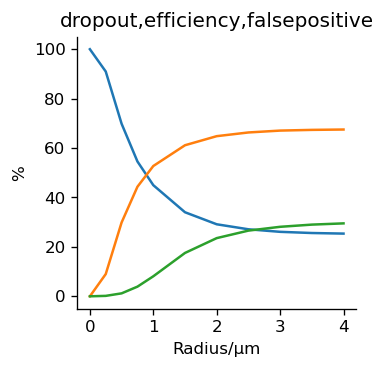

<Figure size 432x288 with 0 Axes>

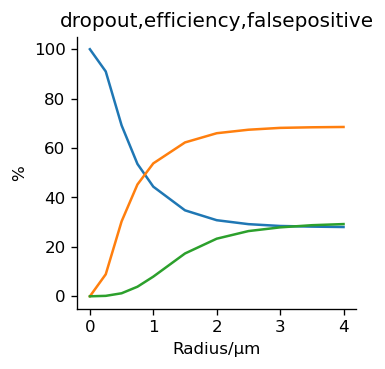

<Figure size 432x288 with 0 Axes>

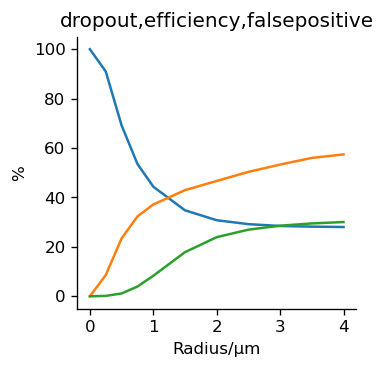

<Figure size 432x288 with 0 Axes>

In [462]:
Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num_GAD1','FP_GAD1%','Efficiency_GAD1%','FN_GAD1%',
                                                                  'Num_Lamp5','FP_Lamp5%','Efficiency_Lamp5%','FN_Lamp5%',
                                                                  'Num_ALL','FP_ALL%','Efficiency_ALL%','FN_ALL%'])
Decoding_Efficiency.to_csv(seg_dir + spot_extraction + 'Decoding_Efficiency.csv', index=False)   
fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_ALL%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_ALL%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_ALL%'].values)
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title('dropout,efficiency,falsepositive')
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_GAD1%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_GAD1%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_GAD1%'].values)
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title('dropout,efficiency,falsepositive')
plt.show()
plt.tight_layout()


fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_Lamp5%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_Lamp5%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_Lamp5%'].values)
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title('dropout,efficiency,falsepositive')
plt.show()
plt.tight_layout()

### Decoding for two channels of rounds without ROI_affine

In [ ]:
%%time 
# for cells that distance >1, find the lists of 15 nearest ROI; if distance j <1, apply the j ransac/icp affine to this images.
##time: 60 images, 60 s for 4 images (c0-c3) if apply image ransac,40 s for 4 images (c0-c3) if not.
tile_number = 5 #35
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
df_allroi = pd.read_csv(roi_dir)

# align C3 and C0 of fixed round using FISH spots
# GAD1 cells 
gad1_list = [2,3,5,20,24,33,59,60,81,137,151,152,194,220,224,237,277,394] #2
Rounds = ["R2","R1"] 
Round = Rounds[0]
# if Round == Rounds[0]:
for Round in Rounds: # ['R2','R1']
    
    j=0
    warp_spots_c0_all = np.zeros((1, 4))
    spot_mov_c0_all = np.zeros((1, 4))
    spot_fix_c3_all = np.zeros((1, 4))
    fix_spacing=np.array([0.42,0.23,0.23])
    Dist_sum_1 = np.zeros((len(gad1_list), 4)) # directory to file containing the registration stats
    for i in range(0, tile_number): # distributed
#         i = 0
        roi_dir = seg_dir + 'allroi_matched.csv'       # directory to file containing the ROI correspondence
        df_allroi = pd.read_csv(roi_dir)
        fix3_path = seg_dir + 'R2_3tm50_1920/ROI/'
        ROI_RGB_path = seg_dir + 'R2_3tm50_1920/ROI_RGB/'
        if not os.path.exists(ROI_RGB_path): os.mkdir(ROI_RGB_path)
        roi_dir = fix3_path + str(i) + '/ROI_id.csv'   # directory to file containing the ROI correspondence of single tile
        df_tile_roi = pd.read_csv(roi_dir)
        ROI_id = df_tile_roi['fix'].astype(int)
        Chn = 'C0'
        Global_detection = 1 # rs-fish
        neighbor_radius0 = 1    
        for aa in ROI_id:  ## ROI_id set{gad1_list}
#             if aa in gad1_list:
#             if aa == 5:   
                # find nearest affine for cca
                spotdir = seg_dir + 'R2ROI_points_fix.txt'
                global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
                    seg_dir,spotdir,aa,Rounds)
                
                print(Round + ': ' + 'C3; ' + Round + ': ' + Chn)       
                roi_dir = fix3_path + str(i) + '/'+ Round + '_' + str(aa) + '_C3.tif'
                fixed_ROI = imread(roi_dir)
                roi_dir = fix3_path + str(i) + '/'+ Round + '_' + str(aa) + '_' + Chn + '.tif'
                moving_ROI = imread(roi_dir)
                roi_dir = fix3_path + str(i) + '/'+ Round + '_' + str(aa) + '_C2.tif'
                fixed_ROI_c2 = imread(roi_dir)
    
                if Round == Rounds[0]: # R2
                    P1_C0,P2_C0,distances_1,fix_spots_0,mov_spots_0,warp_spots_new_0,ICP_affine_0,cc_0,dd_0 = ROI_apply_cca_affine_bash(
                        segmentation1,aa,aa,fixed_ROI,moving_ROI,global_affine_fix,inv_affine_fix,Transform_fix,Chn,Global_detection,hAir,neighbor_radius0,Round)
                
                else:
                    P1_C0,P2_C0,distances_1,fix_spots_0,mov_spots_0,warp_spots_new_0,ICP_affine_0,cc_0,dd_0 = ROI_apply_cca_affine_bash(
                        segmentation2,aa,aa,fixed_ROI,moving_ROI,global_affine_mov,inv_affine_mov,Transform_mov,Chn,Global_detection,hAir,neighbor_radius0,Round)

                # for rounds, save C3 spots, C0 spots, warped C0 spots.
                spot_fix3 = fix_spots_0/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
                spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa)))
                spot_fix_c3_all = np.row_stack((spot_fix_c3_all,spot_fix_c3))
                
                spot_mov0 = mov_spots_0/fix_spacing + [2*dd_0[0],4*dd_0[1],4*dd_0[2]]  # in phsical distance of S2
                spot_mov_c0 = np.column_stack((spot_mov0,np.ones(len(spot_mov0)).dot(aa)))
                spot_mov_c0_all = np.row_stack((spot_mov_c0_all,spot_mov_c0))
                
                warp_spots_0 = warp_spots_new_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
                warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_0)).dot(aa)))
                warp_spots_c0_all = np.row_stack((warp_spots_c0_all,warp_spots_new_c0))
                
                lo=np.percentile(np.ndarray.flatten(fixed_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
                bg_dapi=np.percentile(np.ndarray.flatten(fixed_ROI_c2[fixed_ROI_c2!=0]),1) 
                bg_data=np.percentile(np.ndarray.flatten(fixed_ROI[fixed_ROI!=0]),1) #Estimate background in AF546 channel
                dapi_factor=np.median((fixed_ROI[fixed_ROI_c2>lo] - bg_data)/(fixed_ROI_c2[fixed_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
                fixed_ROI  = np.maximum(0, fixed_ROI - bg_data - dapi_factor * (fixed_ROI_c2 -bg_dapi)).astype('float32')#subtract
                    
                a_rgb = np.zeros(fixed_ROI.shape + (3,))
                a_rgb[..., 0] = fixed_ROI.astype(np.uint16)
                a_rgb[..., 1] = ICP_affine_0.astype(np.uint16)
                a_rgb[..., 2] = moving_ROI.astype(np.uint16)
                roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C3' + Chn +'_cca.tif'
                imsave(roi_dir, a_rgb)
                a_rgb = []

                # remember to remove the first 000 coordinates
                Dist_sum_1[j,:] = [aa,P1_C0,P2_C0,distances_1]
                j = j + 1
                
    Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','C0_p1','C0_p2','C1_dist'])
    spot_extraction = ['hAir/','RS-FISH/affine_cca/'][1]
    Dist_sum_pre.to_csv(seg_dir + spot_extraction + Round + '_colocalization_cca.csv', index=False)         
    spot_fix_c3_all = spot_fix_c3_all[spot_fix_c3_all[:,3]!= 0,:]
    np.savetxt(seg_dir + spot_extraction + 'ROIaffine_'+ Round + '_c3_spots.txt',spot_fix_c3_all,delimiter=',')
    spot_mov_c0_all = spot_mov_c0_all[spot_mov_c0_all[:,3]!= 0,:]
    np.savetxt(seg_dir + spot_extraction + 'ROIaffine_'+ Round + '_c0_spots.txt',spot_fix_c1_all,delimiter=',') 
    warp_spots_c0_all = warp_spots_c0_all[warp_spots_c0_all[:,3]!= 0,:]
    np.savetxt(seg_dir + spot_extraction + 'ROIaffine_'+ Round + '_c0_spots_cca.txt',warp_spots_c0_all,delimiter=',')   

### Decoding errors for 4 channels after cca w/o ROI_affine

In [ ]:
# s=fix_spots_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='fix_spots_0', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')
# s=mov_spots_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='mov_spots_0', size=3,
#                   face_color='red',edge_color='red',blending='opaque')
# s=warp_spots_new_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='warp_spots_new_0', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# viewer.add_image(fixed_ROI,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(ICP_affine_0,colormap='magenta',blending='additive') #load image data into napari
# viewer.add_image(moving_ROI,colormap='red',blending='additive') #load image data into napari

# lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_spots_0,warp_spots_new_0,1)

# s=lipo_c0[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='fix_spots_0co', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')
# s=lipo_c1[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='warp_spots_new_0co', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_spots_0,mov_spots_0,1)

s=lipo_c0[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='fix_spots_0co', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')
s=lipo_c1[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='mov_spots_0co', size=3,
                  face_color='green',edge_color='green',blending='opaque')

In [ ]:
# spot_fix_c3_all = spot_fix_c3_all[spot_fix_c3_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c3_spots.txt',spot_fix_c3_all,delimiter=',')
# # spot_fix_c2_all = spot_fix_c2_all[spot_fix_c2_all[:,3]!= 0,:]
# # np.savetxt(seg_dir + 'ROIaffine_R2_c2_spots.txt',spot_fix_c2_all,delimiter=',') 
# spot_fix_c1_all = spot_fix_c1_all[spot_fix_c1_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all,delimiter=',') 
# spot_fix_c0_all = spot_fix_c0_all[spot_fix_c0_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all,delimiter=',')

# warp_spots_c1_all = warp_spots_c1_all[warp_spots_c1_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c1_spots.txt',warp_spots_c1_all,delimiter=',')
# warp_spots_c0_all = warp_spots_c0_all[warp_spots_c0_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c0_spots.txt',warp_spots_c0_all,delimiter=',')

# 
Rounds = ['R2','R1']
chn = ['c3','c0']
spot_fix_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
spot_fix_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
warp_spots_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + 'cca_spots.txt',delimiter=',')
warp_spots_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + 'cca_spots.txt',delimiter=',')

radius = 1 # in um
for aa in gad1_list:
    fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3]== aa,:]
    fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa,:]
    warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa,:]
    warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa,:]

    # R1 GAD1 for R2 lamp5    
    lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c3,warp_c0,radius)
    print(np.mean([p1,p2]))
    violin_distance(lipo_c0,lipo_c1)

    # R1 lamp5 for R2 GAD1   
    lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c0,warp_c3,radius)
    print(np.mean([p1,p2]))
    violin_distance(lipo_c0,lipo_c1)

    # R1 lamp5 for R1 GAD1   
    lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c0,warp_c3,radius)
    print(np.mean([p1,p2]))
    violin_distance(lipo_c0,lipo_c1)

### ROI_affine for 4 channels without cca

In [ ]:
%%time  
# time: 60 images, 60 s for 4 images (c0-c3) if apply image ransac,40 s for 4 images (c0-c3) if not.
tile_number = 5 #35
seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
df_allroi = pd.read_csv(roi_dir)
spot_fix_c3_all = np.zeros((1, 4))
warp_spots_c3_all = np.zeros((1, 4))
spot_fix_c1_all = np.zeros((1, 4))
warp_spots_c1_all = np.zeros((1, 4))
spot_fix_c0_all = np.zeros((1, 4))
warp_spots_c0_all = np.zeros((1, 4))
fix_spacing=np.array([0.42,0.23,0.23])
j=0
Dist_sum_1 = np.zeros((len(df_allroi['fix']), 14)) # directory to file containing the registration stats


for i in range(0, tile_number): # distributed
#     i = 0
#     seg_dir1='E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/segmentation/'
#     segmentation1=imread(seg_dir+'mask_all_R2.tif')
#     seg_dir='E:/Maxprobe_analysis/R2_R1_3tm50/copytostephan/'
#     segmentation2=imread(seg_dir+'mask_all_R1.tif') # Before bigstream
    roi_dir = seg_dir + 'allroi_matched.csv'       # directory to file containing the ROI correspondence
    df_allroi = pd.read_csv(roi_dir)

    fix3_path = seg_dir + 'R2_3tm50_1920/ROI/'
    ROI_RGB_path = seg_dir + 'R2_3tm50_1920/ROI_RGB/'
    if not os.path.exists(ROI_RGB_path): os.mkdir(ROI_RGB_path)
    roi_dir = fix3_path + str(i) + '/ROI_id.csv'   # directory to file containing the ROI correspondence of single tile
    df_tile_roi = pd.read_csv(roi_dir)
    ROI_id = df_tile_roi['fix'].astype(int)
#     ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
    
    for aa in ROI_id:
#             aa = 5
            roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_C2.tif'
            fixed_ROI_c2 = imread(roi_dir)
#             ROI_moving = df_allroi.loc[df_allroi['fix'].astype(int) == aa]['mov'].values[0].astype(int) #379
            ROI_moving = aa
            print('ROI_fix: ' + str(aa) + '; ROI_moving: ' + str(ROI_moving))
            roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_C2.tif'
            moving_ROI_c2 = imread(roi_dir)

            #for dapi: ~50 blobs can be detected
            threshold_fixed=0.001/50 #/50
            threshold_moving=0.001/5 #/5
            cc_r=12 
            match_threshold=0.6  #0.7
            align_threshold=0.5
            Global_detection = 0
            image_ransac = 1 # 1 is to get point correspondences from image; or 0 is to use nearest neighbors for local ransac
            P1_C2,P2_C2,_,_,distances_2,global_affine2,inv_affine2,Transform2,inv_Transform2,fix_spots_2,mov_spots_2,warp_spots_new_2,ICP_affine_2,cc_2 = ROI_affine_bash(
            segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,moving_ROI_c2,threshold_fixed,threshold_moving,
            cc_r,match_threshold,align_threshold,Global_detection,image_ransac)
            a_rgb = np.zeros(fixed_ROI_c2.shape + (4,))
            a_rgb[..., 0] = fixed_ROI_c2.astype(np.uint16)
            a_rgb[..., 1] = ICP_affine_2.astype(np.uint16)
            
            Global_detection = 1
            ransac_affine = 1 ## 1 is to apply local ransac affine (not use image) before ICP,0 is used orginal point cloud for ICP.
#             image_ransac = 1 # > 0 is to get point correspondences from image after using nearest neighbors ; or 0 is to use nearest neighbors for local ransac
            hAir = 0 # 0 is RS-FISH; 1 is for hAirlocalize
            for Chn in ["C0","C3"]: # ["C0","C3","C1"]
#                 Chn = "C3"
                print(Chn)
                roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                fixed_ROI = imread(roi_dir)
                roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_'+ Chn + '.tif'
                moving_ROI = imread(roi_dir)
                # save rgb images
                if Chn == "C0":
                    #for c0
                    threshold_fixed=0.001/20 #/20
                    threshold_moving=0.001/2 #/2
                    match_threshold=0.5  #0.5
                    align_threshold=0.5  #0.5
                    neighbor_radius0 = 12
                    image_ransac = 1 # number is specific distance threshold for non-dapi track  
                    P1_C0,P2_C0,_,_,pair_dist_0,fix_spots_0,mov_spots_0,warp_spots_new_0,ICP_affine_0,moving_affine_0,cc_0 = ROI_trackaffine_bash(
                    segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,
                    ransac_affine,global_affine2,inv_affine2,Transform2,inv_Transform2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
#                     mov_ds = ROI_trackaffine_bash(
#                     segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,
#                     ransac_affine,global_affine3,inv_Transform3,Chn,Global_detection)
                    distances_0 = np.mean(pair_dist_0)
                    a_rgb[..., 2] = fixed_ROI.astype(np.uint16)
                    a_rgb[..., 3] = ICP_affine_0.astype(np.uint16)
#                     a_rgb[..., 3] = moving_affine_0.astype(np.uint16)
                    roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C2' + Chn +'.tif'
                    imsave(roi_dir, a_rgb)
                    a_rgb = []

                elif Chn == "C3":
                    #for c3
                    threshold_fixed=0.001/8 #/4
                    threshold_moving=0.001/4 #/2
                    match_threshold=0.5  #0.7
                    align_threshold=0.5
                    neighbor_radius0 = 12
                    image_ransac = 1 # number is specific distance threshold 
                    P1_C3,P2_C3,dist1,dist2,pair_dist_3,fix_spots_3,mov_spots_3,warp_spots_new_3,ICP_affine_3,moving_affine_3,cc_3 = ROI_trackaffine_bash(
                    segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,
                    ransac_affine,global_affine2,inv_affine2,Transform2,inv_Transform2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0)
#                     P1_C3,P2_C3 = ROI_trackaffine_bash(
#                     segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,cc_r,match_threshold,align_threshold,
#                     ransac_affine,global_affine2,inv_affine2,inv_Transform2,Chn,Global_detection,image_ransac)
                    distances_3 = np.mean(pair_dist_3)
                    
                    lo=np.percentile(np.ndarray.flatten(fixed_ROI_c2),99.5) #Estimate fluorescence intensity of bright DAPI signals
                    bg_dapi=np.percentile(np.ndarray.flatten(fixed_ROI_c2[fixed_ROI_c2!=0]),1) 
                    bg_data=np.percentile(np.ndarray.flatten(fixed_ROI[fixed_ROI!=0]),1) #Estimate background in AF546 channel
                    dapi_factor=np.median((fixed_ROI[fixed_ROI_c2>lo] - bg_data)/(fixed_ROI_c2[fixed_ROI_c2>lo] - bg_dapi)) #Estimate % of signal bleedthrough
                    fixed_ROI  = np.maximum(0, fixed_ROI - bg_data - dapi_factor * (fixed_ROI_c2 -bg_dapi)).astype('float32')#subtract background and bleedthrough
                    
                    a_rgb = np.zeros(fixed_ROI.shape + (4,))
                    a_rgb[..., 0] = fixed_ROI.astype(np.uint16)
                    a_rgb[..., 1] = ICP_affine_3.astype(np.uint16)
#                     a_rgb[..., 1] = moving_affine_3.astype(np.uint16)
#                     roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C3' + Chn +'.tif'
#                     imsave(roi_dir, a_rgb)
                else:
                    #for c1
                    threshold_fixed=0.001/20 #/20
                    threshold_moving=0.001/2 #/2
                    match_threshold=0.7  #0.5
                    align_threshold=0.5  # 0.5
                    neighbor_radius0 = 12
                    image_ransac = 1 # number is specific distance threshold
                    P1_C1,P2_C1,_,_,pair_dist_1, fix_spots_1,mov_spots_1,warp_spots_new_1, ICP_affine_1,moving_affine_1,cc_1 = ROI_trackaffine_bash(
                        segmentation1,segmentation2,aa,ROI_moving,fixed_ROI,moving_ROI,moving_ROI_c2,threshold_fixed,threshold_moving,cc_r,
                        match_threshold,align_threshold,ransac_affine,global_affine2,inv_affine2,Transform2,
                        inv_Transform2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0) 
                    distances_1 = np.mean(pair_dist_1)
                    a_rgb[..., 2] = fixed_ROI.astype(np.uint16)
                    a_rgb[..., 3] = ICP_affine_1.astype(np.uint16)
#                     a_rgb[..., 3] = moving_affine_1.astype(np.uint16)
                    roi_dir = ROI_RGB_path + '/'+ str(aa) + '_' + 'C3' + Chn +'.tif'
                    imsave(roi_dir, a_rgb)
                    a_rgb = []

            # save C3 spots, global affine, warp affine.        
            spot_fix3 = fix_spots_3/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # pre:in um, post: in px[um to px + mask(0, in px)]
            spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa))) # add ROI_ID
            spot_fix_c3_all = np.row_stack((spot_fix_c3_all,spot_fix_c3))   # for all ROIs
            warp_spots_3 = warp_spots_new_3[:,:3]/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # in pixels of S2
            warp_spots_new_c3 = np.column_stack((warp_spots_3,np.ones(len(warp_spots_new_3)).dot(aa)))
            warp_spots_c3_all = np.row_stack((warp_spots_c3_all,warp_spots_new_c3))
            
            # save C1 spots, global affine, warp affine.
            spot_fix1 = fix_spots_1/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_all = np.row_stack((spot_fix_c1_all,spot_fix_c1))
            warp_spots_1 = warp_spots_new_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
            warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_1)).dot(aa)))
            warp_spots_c1_all = np.row_stack((warp_spots_c1_all,warp_spots_new_c1))
            
            # save C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_0/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_all = np.row_stack((spot_fix_c0_all,spot_fix_c0))
            warp_spots_0 = warp_spots_new_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_0)).dot(aa)))
            warp_spots_c0_all = np.row_stack((warp_spots_c0_all,warp_spots_new_c0))
            
            # remember to remove the first 000 coordinates
            Dist_sum_1[j,:] = [aa,ROI_moving,distances_0,P1_C0,P2_C0,
                               distances_1,P1_C1,P2_C1,distances_2,P1_C2,P2_C2,
                               distances_3,P1_C3,P2_C3]
            j = j + 1

In [ ]:
# Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C0_dist','C1_dist','C2_dist','C3_dist'])
Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C0_dist','C0_p1','C0_p2',
                                    'C1_dist','C1_p1','C1_p2','C2_dist','C2_p1',
                                    'C2_p2','C3_dist','C3_p1','C3_p2'])
spot_extraction = ['hAir/','RS-FISH/'][1]
Dist_sum_pre.to_csv(seg_dir + spot_extraction + 'R2R1_colocalization_RS-FISH_ransac_revisedtransform.csv', index=False)

# spot_fix_c3_all = spot_fix_c3_all[spot_fix_c3_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c3_spots.txt',spot_fix_c3_all,delimiter=',')
# # spot_fix_c2_all = spot_fix_c2_all[spot_fix_c2_all[:,3]!= 0,:]
# # np.savetxt(seg_dir + 'ROIaffine_R2_c2_spots.txt',spot_fix_c2_all,delimiter=',') 
# spot_fix_c1_all = spot_fix_c1_all[spot_fix_c1_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all,delimiter=',') 
# spot_fix_c0_all = spot_fix_c0_all[spot_fix_c0_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all,delimiter=',')

# warp_spots_c3_all = warp_spots_c3_all[warp_spots_c3_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c3_spots.txt',warp_spots_c3_all,delimiter=',')
# # warp_spots_c2_all = warp_spots_c2_all[warp_spots_c2_all[:,3]!= 0,:]
# # np.savetxt(seg_dir + 'ROIaffine_R1_c2_spots.txt',warp_spots_c2_all,delimiter=',')
# warp_spots_c1_all = warp_spots_c1_all[warp_spots_c1_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c1_spots.txt',warp_spots_c1_all,delimiter=',')
# warp_spots_c0_all = warp_spots_c0_all[warp_spots_c0_all[:,3]!= 0,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R1_c0_spots.txt',warp_spots_c0_all,delimiter=',')

In [ ]:
# need to revise the spots location.
# visualization all spots
spotdir = seg_dir + 'RS-FISH/ROIaffine_R2_c3_spots.txt'
spot_mov = np.loadtxt(spotdir, delimiter=',')
bad_list = [478,494,778,896,952,1022,1035,1071,1106] #292
list2 = []
for i in bad_list:
    list2 = list2 + list(np.where(spot_mov[:,3] == i)[0])
spot_mov =np.delete(spot_mov, list2, axis=0)
# fix_spots1 = spot_mov[:,:3]
fix_spots1 = spot_mov[spot_mov[:,3] == 5][:,:3]

fix_spacing=np.array([0.42,0.23,0.23])
s = fix_spots1[:,:3]/fix_spacing #convert spot um to pixel coordinates
# s = warp_spots_c3_all[:,:3]/fix_spacing
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='fix_spots', size=3,
                  face_color='green',edge_color='green',blending='opaque')

spotdir = seg_dir + 'RS-FISH/ROIaffine_R1_c3_spots.txt'
spot_mov = np.loadtxt(spotdir, delimiter=',')
list2 = []
for i in bad_list:
    list2 = list2 + list(np.where(spot_mov[:,3] == i)[0])
spot_mov =np.delete(spot_mov, list2, axis=0)
# moving_spots1 = spot_mov[spot_mov[:,3] == 7][:,:3]
# moving_spots1 = spot_mov[:,:3]
moving_spots1 = spot_mov[spot_mov[:,3] == 5][:,:3]
s = moving_spots1[:,:3]/fix_spacing #convert spot um to pixel coordinates
# s = warp_spots_c3_all[:,:3]/fix_spacing
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='moving_spots', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')

In [ ]:
# compare all different settings
spot_extraction = ['hAir/','RS-FISH/'][1]
roi_dir = seg_dir + spot_extraction + 'R2R1_colocalization_RS-FISH_ransac_betterc0.csv' # rs-fish with image ransac
# roi_dir = seg_dir + spot_extraction + 'R2R1_colocalization_RS-FISH_ransac_badc0.csv' # rs-fish without image ransac
# roi_dir = seg_dir + 'R2R1_colocalization_hAirransac.csv'  # global air spots but with local ransac affine again
# roi_dir = seg_dir + 'R2R1_colocalization_noransac.csv' # global air spots but no local ransac affine
# roi_dir = seg_dir + 'R2R1_colocalization_hair.csv' # global air spots
# roi_dir = seg_dir + 'R2R1_colocalization_1120.csv' # local image spots but without c0
# roi_dir = seg_dir + 'R2R1_colocalization_1071.csv' # local image spots
df_tile_roi = []
df_tile_roi = pd.read_csv(roi_dir)

# remove the bad ROI
# df_tile_roi = df_tile_roi[(df_tile_roi['C3_dist']>1)]
# bad_list = [478,494,778,896,952,1022,1035,1071,1106] #292
# bad_idx =[175,178,183,186,187,192,197,206,213]
bad_idx =[173,176,181,184,185,190,195,204,211]
# list(set(df_tile_roi['roi_fix']).difference(set(bad_list)))
df_tile_roi = df_tile_roi.drop(bad_idx)

# select columns
ROI_dist = []
ROI_dist = (df_tile_roi['C3_p1']).values #C3_dist
ROI_dist[ROI_dist == 0] = []
ROI_dist = ROI_dist[~np.isnan(ROI_dist)]

fig=plt.figure(dpi=120,figsize=(2,3))
plt.violinplot(ROI_dist)
sns.despine() 
# a = np.arange(0,2)
# plt.yticks(a[::10])
plt.ylim(0,100)
plt.xlabel('Cells:'+ str(ROI_dist.shape[0]))
# plt.ylabel('Distance/μm')
plt.ylabel('% of colocalization')
plt.xticks([])
ave=np.average(ROI_dist)
plt.title(str(float('%.2f' % ave)))
plt.show()
plt.tight_layout()

### compare with different method of point cloud registration

In [ ]:
print(dist1)
print(dist2)
print(distances_3)
fix_spots_31 = fix_spots_3[:,:3]/fix_spacing
# warp_spots_new_3 = warp_spots_new_3[:,:3]/fix_spacing
mov_spots_31 = mov_spots_3[:,:3]/fix_spacing
# lipo_c0,lipo_c1,_,_,_,_,_, = colocalization(fix_spots_3,warp_spots_new_3,3)
lipo_c0,lipo_c1,_,_,_,_,_, = colocalization(fix_spots_31,mov_spots_31,6)
violin_distance(lipo_c0,lipo_c1)

In [ ]:
# dist_co = 6
# #ransac
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/111_C3C1_0.txt'
# spot_fix=np.loadtxt(spotdir, delimiter='\t')
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/111_C3C1_1.txt'
# spot_mov=np.loadtxt(spotdir, delimiter='\t')
# print(spot_mov[:,0:3].shape)
# print(spot_fix[:,0:3].shape)
# A1,B1,_,_,dist,_,_ = colocalization(spot_fix[:,0:3],spot_mov[:,0:3],dist_co)
# violin_distance(A1,B1)

# # ICP for ransac live
# A = spot_fix[:,0:3]
# B = spot_mov[:,0:3]
# Transform, distances1,C = icp(A, B,1)
# inv_Transform, distances2,C = icp(B, A,1)
# p = np.append(B, np.ones((B.shape[0],1)), axis=1)
# C = p.dot(inv_Transform.T)
# A1,B1,_,_,dist,_,_ = colocalization(A,C,dist_co)
# violin_distance(A1,B1)

# #ransac_ICP
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/ICP_111_C3C1_0.txt'
# spot_fix=np.loadtxt(spotdir, delimiter='\t')
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/ICP_111_C3C1_1.txt'
# spot_mov=np.loadtxt(spotdir, delimiter='\t')
# print(spot_mov[:,0:3].shape)
# print(spot_fix[:,0:3].shape)
# A1,B1,_,_,dist,_,_ = colocalization(spot_fix[:,0:3],spot_mov[:,0:3],dist_co)
# violin_distance(A1,B1)

# #Bigstitcher 
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/fused_tp_0_ch_0.txt'
# spot_fix=np.loadtxt(spotdir, delimiter='\t')
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/fused_tp_0_ch_1.txt'
# spot_mov=np.loadtxt(spotdir, delimiter='\t')
# print(spot_mov[:,0:3].shape)
# print(spot_fix[:,0:3].shape)
# A1,B1,_,_,dist,_,_ = colocalization(spot_fix[:,0:3],spot_mov[:,0:3],dist_co)
# violin_distance(A1,B1)

# dist_co = 200
# #before
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/5_R2_C3_0.txt'
# spot_fix=np.loadtxt(spotdir, delimiter='\t')
# spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/5_R1_C3_1.txt'
# spot_mov=np.loadtxt(spotdir, delimiter='\t')
# print(spot_mov[:,0:3].shape)
# print(spot_fix[:,0:3].shape)
# A1,B1,_,_,dist,_,_ = colocalization(spot_fix[:,0:3],spot_mov[:,0:3],dist_co)
# violin_distance(A1,B1)

#Bigstitcher 
spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/5_R2_C3_fused_0.txt'
spot_fix=np.loadtxt(spotdir, delimiter='\t')
spotdir = seg_dir + 'R2_3tm50_1920/ICP_111_C3C1/5_R1_C3_fused_1.txt'
spot_mov=np.loadtxt(spotdir, delimiter='\t')
print(spot_mov[:,0:3].shape)
print(spot_fix[:,0:3].shape)

A1,B1,_,_,dist,_,_ = colocalization(spot_fix[:,0:3],spot_mov[:,0:3],6)
violin_distance(A1,B1)

In [ ]:
s=lipo_c0#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_fix_spots', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')

s=lipo_c1#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_warp_spots', size=3,
                  face_color='green',edge_color='green',blending='opaque')

In [ ]:
s=fix_spots_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fix_spots', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')

s=mov_spots_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov_spots', size=3,
                  face_color='green',edge_color='green',blending='opaque')

s=warp_spots_new_0[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp_spots', size=3,
                  face_color='green',edge_color='green',blending='opaque')

s=fix_spots_3[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_fix_spots', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')

# s=mov_spots_3[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_mov_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

s=warp_spots_new_3[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_warp_spots', size=3,
                  face_color='green',edge_color='green',blending='opaque')

# s=moving_spots1[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='moving_spots1', size=3,
#                   face_color='green',edge_color='green',blending='opaque')



# s=fix_spots_2[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c2_fix_spots', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

# s=mov_spots_2[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c2_mov_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# s=moving_spots1[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='moving_spots1', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# s=warp_spots_new_2[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c2_warp_spots', size=3,
#                   face_color='green',edge_color='green',blending='opaque')


viewer.add_image(fixed_ROI_c0,colormap='green',blending='additive') #load image data into napari
# viewer.layers['fixed_ROI'].contrast_limits=(200, 1600)
viewer.add_image(moving_ROI,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['moving_ROI'].contrast_limits=(200, 1600)
viewer.add_image(fixed_ROI_c3,colormap='red',blending='additive') #load image data into napari
viewer.add_image(ICP_affine_3,colormap='magenta',blending='additive') #load image data into napari
viewer.add_image(ICP_affine_0,colormap='green',blending='additive') #load image data into napari
# viewer.layers['ICP_affine_3'].contrast_limits=(200, 1600)
# viewer.add_image(moving_affine_0,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['moving_affine_0'].contrast_limits=(200, 1600)

# viewer.add_image(fixed_ROI_c2,colormap='green',blending='additive') #load image data into napari
# viewer.add_image(moving_ROI_c2,colormap='red',blending='additive') #load image data into napari
# viewer.layers['fixed_ROI_c2'].contrast_limits=(200, 1600)
# viewer.layers['moving_ROI_c2'].contrast_limits=(200, 1600)
# viewer.add_image(ICP_affine_2,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['ICP_affine_2'].contrast_limits=(200, 1600)

In [ ]:
roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_c3' + '.tif'
fixed_ROI = imread(roi_dir)
viewer.add_image(fixed_ROI,colormap='green',blending='additive') #load image data into napari

# Validate transform for images and points

In [ ]:
# transform cca for fixed images
zoom = [2,4,4]
mov_spacing =fix_spacing
AA=np.where(segmentation1==338)
cc = [min(AA[0]),min(AA[1]),min(AA[2])]
BB=np.where(segmentation2==338)
dd = [min(BB[0]),min(BB[1]),min(BB[2])]

# fix_affine_0 = transform.apply_global_affine(fixed_ROI,fixed_ROI,fix_spacing, fix_spacing, global_affine_fix,)
# fix_ds = transform.apply_global_affine(fixed_ROI,fix_affine_0,fix_spacing, fix_spacing,inv_Transform_fix,)

print(f'RS-FISH points from cluster')
spotdir1 = seg_dir + 'RS-FISH/R2_' + Chn + '_ROI.txt'
spotdir2 = seg_dir + 'RS-FISH/R1_' + Chn + '_ROI.txt'

spot_fix=np.loadtxt(spotdir1, delimiter=',')
fixed_spots1 = spot_fix[spot_fix[:,4] == 338][:,:3]
# find specific moving roi
spot_mov=np.loadtxt(spotdir2, delimiter=',')
moving_spots1 = spot_mov[spot_mov[:,4] == 338][:,:3]       
# change to zyx order
fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
# convert to physical units
ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
fix_spots = (fixed_spots11 - ccc * fix_spacing)
ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
mov_spots = (moving_spots11 - ddd * mov_spacing)
########################################################################

# ## apply cca affine for fix spots
# points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
# warp_spots_1 = points1.dot(inv_affine_fix.T)
# points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
# fix_spots_x = points2.dot(inv_Transform_fix.T)
# fix_spots_x = fix_spots_x[:,:3] 
# ## apply cca affine for mov spots
# points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
# warp_spots_2 = points2.dot(inv_affine_mov.T)
# points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
# mov_spots_x = points2.dot(inv_Transform_mov.T)
# mov_spots_x = mov_spots_x[:,:3]

In [ ]:
s=fix_spots[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fix_spots', size=3,
                  face_color='magenta',edge_color='magenta',blending='opaque')
s=fix_spots_x[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fix_xspots', size=3,
                  face_color='green',edge_color='green',blending='opaque')
viewer.add_image(fixed_ROI,colormap='green',blending='additive') #load image data into napari
viewer.layers['fixed_ROI'].contrast_limits=(200, 1600)
viewer.add_image(fix_ds,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['fix_ds'].contrast_limits=(200, 1600)

In [ ]:
global_affine2,inv_affine2,Transform2,inv_Transform2

In [ ]:
# A = fix_spots[:,:3]
# B = mov_spots[:,:3]
# neighbor_radius2 = 3
# inv_Transform, distances2, D = icp(B, A,neighbor_radius2) # B->A return um
# Transform,_,_= icp(A, B,neighbor_radius2) # B->A 


# s=D[:,:3]/fix_spacing #convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='D', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')
inv_Transform = np.row_stack((inv_affine2,np.array([[0,0,0,1]])))   ## B->A spots (right) with B->A transform (right) in um
ICP_affine1 = scipy.ndimage.affine_transform(moving_ROI,np.linalg.inv(inv_Transform))
# inv_Transform = np.row_stack((global_affine2,np.array([[0,0,0,1]])))   ## B->A spots (right) with B->A transform (right) in um
# ICP_affine1 = scipy.ndimage.affine_transform(moving_ROI,global_affine2) # mov->registered mov with reversed transform

x,y,z = fixed_ROI.shape
a,b,c = ICP_affine1.shape
# crop away border
# ICP_affine1 = ICP_affine1[0:x,0:y,0:z]
# ICP_affine1 = ICP_affine1[a-x:-1,b-y:-1,c-z:-1]
# ICP_affine1 = ICP_affine1[0:x,0:y,c-z:-1]
viewer.add_image(ICP_affine1,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine1'].contrast_limits=(200, 600)


In [ ]:
# crop away border and save aligned images
x,y,z = fixed_ROI.shape
# crop away border
ICP_affine3 = ICP_affine2[0:x,0:y,0:z]
print(ICP_affine3.shape)
viewer.add_image(ICP_affine2,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine2'].contrast_limits=(200, 600)
viewer.add_image(ICP_affine3,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine3'].contrast_limits=(200, 600)

In [ ]:
inv_Transform = np.row_stack((global_affine2,np.array([[0,0,0,1]]))) #FIX->FIX_reg
D = p.dot(np.linalg.inv(inv_Transform).T)

global_affine = transform.apply_global_affine(  
    fixed_ROI, moving_ROI,fix_spacing, fix_spacing,global_affine2,) #A->B transform in um

In [ ]:
B = mov_spots[:,:3]

# p = np.append(B, np.ones((B.shape[0],1)), axis=1) 
# inv_Transform = np.row_stack((inv_affine2,np.array([[0,0,0,1]]))) #MOV->MOV_reg
# C1 = p.dot(inv_affine2.T)                         ## B->A spots (right) with B->A transform (right) in um
inv_Transform = np.row_stack((global_affine2,np.array([[0,0,0,1]]))) #FIX->FIX_reg
C1 = p.dot(np.linalg.inv(inv_Transform).T)

s=C1[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='D', size=3,
                  face_color='green',edge_color='green',blending='opaque')

global_affine = transform.apply_global_affine(fixed_ROI, moving_ROI,fix_spacing, fix_spacing,global_affine2,) #A->B transform in um
viewer.add_image(global_affine,colormap='green',blending='additive') #load image data into napari
viewer.layers['global_affine'].contrast_limits=(200, 600)

In [ ]:
p = np.append(B, np.ones((B.shape[0],1)), axis=1) 
inv_Transform = np.row_stack((global_affine2,np.array([[0,0,0,1]]))) #FIX->FIX_reg
C1 = p.dot(np.linalg.inv(inv_Transform).T)   ## B->A spots (right) with B->A transform (right) in um
ICP_affine1 = transform.apply_global_affine(fixed_ROI, moving_ROI,fix_spacing, fix_spacing,global_affine2,) #A->B transform in um

p = C1
inv_Transform = Transform2
C2 = p.dot(np.linalg.inv(inv_Transform).T)    ## B->A spots (right) with B->A transform (right) in um
ICP_affine2 = transform.apply_global_affine(fixed_ROI, ICP_affine1,fix_spacing,fix_spacing,Transform2,) #A->B transform in um

In [ ]:
A = fix_spots[:,:3]
B = mov_spots[:,:3]
# neighbor_radius2 = 3
# inv_Transform, distances2, _ = icp(B, A,neighbor_radius2) # B->A
p = np.append(B, np.ones((B.shape[0],1)), axis=1) 
inv_Transform = np.row_stack((global_affine2,np.array([[0,0,0,1]]))) #FIX->FIX_reg
C1 = p.dot(np.linalg.inv(inv_Transform).T)   ## B->A spots (right) with B->A transform (right) in um
# ICP_affine1 = scipy.ndimage.affine_transform(moving_ROI,np.linalg.inv(inv_Transform))
ICP_affine1 = transform.apply_global_affine(fixed_ROI, moving_ROI,fix_spacing, fix_spacing,global_affine2,) #A->B transform in um

# inv_Transform = np.row_stack((inv_Transform2,np.array([[0,0,0,1]])))
p = C1
inv_Transform = Transform2
# p = np.append(B, np.ones((B.shape[0],1)), axis=1)
C2 = p.dot(np.linalg.inv(inv_Transform).T)    ## B->A spots (right) with B->A transform (right) in um
# ICP_affine2 = scipy.ndimage.affine_transform(ICP_affine1,np.linalg.inv(inv_Transform))
ICP_affine2 = transform.apply_global_affine(fixed_ROI, ICP_affine1,fix_spacing,fix_spacing,Transform2,) #A->B transform in um

# spot match image
C = C1[:,:3]
s=C[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='C1', size=3,
                  face_color='green',edge_color='green',blending='opaque')

viewer.add_image(ICP_affine1,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine1'].contrast_limits=(200, 600)


C = C2[:,:3]
s=C[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='C2', size=3,
                  face_color='green',edge_color='green',blending='opaque')

viewer.add_image(ICP_affine2,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine2'].contrast_limits=(200, 600)

In [ ]:
A = fix_spots[:,:3]
B = mov_spots[:,:3]
neighbor_radius2 = 3
inv_Transform, distances2, C = icp(B, A,neighbor_radius2) # B->A 
# p = np.append(B, np.ones((B.shape[0],1)), axis=1)
# C = p.dot(inv_Transform.T)                         ## B->A spots (right) with B->A transform (right)

ICP_affine = scipy.ndimage.affine_transform(moving_ROI,np.linalg.inv(inv_Transform)) 
C = C[:,:3]

s=C[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='C_um', size=3,
                  face_color='green',edge_color='green',blending='opaque')

viewer.add_image(ICP_affine,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine'].contrast_limits=(200, 600)

## Use import spots or not. If yes, the spot should be aligned with images by checking with Napari

### napari viewer for single ROI

In [ ]:
%%time
# ROI_napari(mov_affine3, fixed_ROI3, moving_ROI3, fix_spots3, warp_spots_new3,ICP_affine3,fix_spacing)
# ROI_napari(mov_affine, fixed_ROI, moving_ROI, fix_spots, warp_spots_new,ICP_affine,fix_spacing)
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()
viewer.add_image(fixed_ROI,colormap='green',blending='additive') #load image data into napari
viewer.add_image(moving_ROI,colormap='red',blending='additive') #load image data into napari
viewer.layers['fixed_ROI'].contrast_limits=(200, 600)
viewer.layers['moving_ROI'].contrast_limits=(200, 600)
viewer.add_image(mov_ds,colormap='yellow',blending='additive') #load image data into napari
viewer.layers['mov_ds'].contrast_limits=(200, 600)
viewer.add_image(mov_affine,colormap='yellow',blending='additive') #load image data into napari
viewer.layers['mov_affine'].contrast_limits=(200, 600)
viewer.add_image(ICP_affine,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine'].contrast_limits=(200, 600)
viewer.add_image(ICP_affine_inv,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine_inv'].contrast_limits=(200, 600)
s=fix_spots[:,:3]/fix_spacing#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fixed_match', size=1,
                  face_color='green',edge_color='green',blending='opaque') 
C = warp_spots_new
viewer.add_points(np.transpose(np.array([C[:,0]/fix_spacing[0],C[:,1]/fix_spacing[1],C[:,2]/fix_spacing[2]])),name ='warp_spots_new', size=1,
                  face_color='yellow',edge_color='yellow',blending='opaque') 
C = warp_spots
viewer.add_points(np.transpose(np.array([C[:,0]/fix_spacing[0],C[:,1]/fix_spacing[1],C[:,2]/fix_spacing[2]])),name ='C', size=1,
                  face_color='yellow',edge_color='yellow',blending='opaque') 

viewer.add_image(fixed_ROI3,colormap='green',blending='additive') #load image data into napari
viewer.add_image(moving_ROI3,colormap='red',blending='additive') #load image data into napari
viewer.layers['fixed_ROI3'].contrast_limits=(200, 3400)
viewer.layers['moving_ROI3'].contrast_limits=(200, 3400)
# viewer.add_image(mov_affine3,colormap='yellow',blending='additive') #load image data into napari
# viewer.layers['mov_affine3'].contrast_limits=(200, 3400)
viewer.add_image(ICP_affine3,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine3'].contrast_limits=(200, 3400)
# viewer.add_image(ICP_affine_inv3,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['ICP_affine_inv3'].contrast_limits=(200, 3400)
# s=fix_spots3[:,:3]/fix_spacing#convert spot physical coordinates to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_fixed_match', size=1,
#                   face_color='green',edge_color='green',blending='opaque') 
# C3 = warp_spots_new3
# viewer.add_points(np.transpose(np.array([C3[:,0]/fix_spacing[0],C3[:,1]/fix_spacing[1],C3[:,2]/fix_spacing[2]])),name ='C3', size=1,
#                   face_color='yellow',edge_color='yellow',blending='opaque') 

### Napari view all spots inside ROIs

In [ ]:
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()
# xyz 1882 2500 2500 
zoom=[2,4,4]
s=spot_fix_c0_all[:,:3]#convert spot physical coordinates to pixel coordinates
#load spots into napari, pixel positions in xyz order
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fixed', size=1,
                  face_color='yellow',edge_color='yellow',blending='opaque') 
s=warp_spots_c0_all[:,:3]#convert spot physical coordinates to pixel coordinates
#load spots into napari, pixel positions in xyz order
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=1,
                  face_color='green',edge_color='green',blending='opaque') 

s=spot_fix_c3_all[:,:3]#convert spot physical coordinates to pixel coordinates
#load spots into napari, pixel positions in xyz order
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_fixed', size=1,
                  face_color='yellow',edge_color='yellow',blending='opaque') 
s=warp_spots_c3_all[:,:3]#convert spot physical coordinates to pixel coordinates
#load spots into napari, pixel positions in xyz order
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_warp', size=1,
                  face_color='green',edge_color='green',blending='opaque') 

# plot images
planes = 0
a=50
fix_ds = fixed3[planes:planes+a ,:,:]
mov_ds = moving3[planes:planes+a ,:,:]
fix_spacing=np.array([0.42,0.23,0.23])
zoom_image=np.array([1,1,1])
fix_ds_spacing = fix_spacing/zoom_image
viewer.add_image(fix_ds,colormap='green',blending='additive') 
viewer.layers['fix_ds'].contrast_limits=(200, 1000)
viewer.add_image(mov_ds,colormap='red',blending='additive') 
viewer.layers['mov_ds'].contrast_limits=(200, 1000)

# CPD

In [ ]:
import copy
import numpy as np
import open3d as o3
from probreg import cpd
import transforms3d as t3d

def estimate_normals(pcd, params):
    pcd.estimate_normals(search_param=params)
    pcd.orient_normals_to_align_with_direction()# load source and target point cloud

source = o3.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
source.remove_non_finite_points()
target = copy.deepcopy(source)

# read points of # point cloud
# xyz = np.asarray(result.points)

A = fix_spots_new0
B = mov_spots_new0

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
# pcd = o3.geometry.PointCloud()
target.points = o3.utility.Vector3dVector(A)
source.points = o3.utility.Vector3dVector(B)
# o3.io.write_point_cloud("../../test_data/sync.ply", pcd)
# o3.visualization.draw_geometries(pcd)

# register
tf_param, _, _ = cpd.registration_cpd(source, target)
result = copy.deepcopy(source)
result.points = tf_param.transform(result.points)

# draw result
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0.5, 1])
# o3.visualization.draw_geometries([result,source])

s=np.asarray(source.points)[:,:3]/fix_spacing#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_src', size=1,
                  face_color='green',edge_color='green',blending='opaque')
s=np.asarray(target.points)[:,:3]/fix_spacing#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_tar', size=1,
                  face_color='yelow',edge_color='yellow',blending='opaque')
s=np.asarray(result.points)[:,:3]/fix_spacing#convert spot physical coordinates to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_cpd', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque')

# ICP

In [ ]:
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0.5, 1])
threshold = 0.05 # how to set initially
icp_iteration = 100
for i in range(icp_iteration):
    reg_p2p = o3.pipelines.registration.registration_icp(result, target, threshold,
                np.identity(4), o3.pipelines.registration.TransformationEstimationPointToPoint(),
                o3.pipelines.registration.ICPConvergenceCriteria(max_iteration=1))
    result.transform(reg_p2p.transformation)
#     vis.update_geometry(source)
#     vis.update_geometry(target)
#     vis.update_geometry(result)
#     vis.poll_events()
# vis.run()
o3.visualization.draw_geometries([result,source,target])

In [ ]:
#Bigstitcher
# R_dir ='E:/Maxprobe_analysis/R2_R1_3tm50/Bigstitcher'
# imsave(R_dir + '/ID#5/fixed_ROI3.tif', fixed_ROI3)
# imsave(R_dir + '/ID#5/moving_ROI3.tif', moving_ROI3)
# imsave(R_dir + '/ID#5/fixed_ROI.tif', fixed_ROI)
# imsave(R_dir + '/ID#5/moving_ROI.tif', moving_ROI)

# global_affine_bs=np.eye(4)
# global_affine_bs[0]=[1.0003, 0.0194, -0.059, 1.7654]
# global_affine_bs[1]=[-0.031, 1.0568, -0.0156, -10.1989]
# global_affine_bs[2]=[-0.0035, -0.0051, 0.9936, 0.5553]
# # Scaling: 1.0008, 1.057, 0.9955
# bs_affine = transform.apply_global_affine(
# moving_ROI3,fixed_ROI3,
# fix_spacing, fix_spacing,
# global_affine_bs,)
# viewer.add_image(bs_affine,colormap='magenta',blending='additive') #load image data into napari
# viewer.layers['bs_affine'].contrast_limits=(200, 3400)

# # fix_spots_new3
# B = fix_spots_new3
# p = np.append(B, np.ones((B.shape[0],1)), axis=1)
# C = p.dot(global_affine_bs.T)
# s=C[:,:3]/fix_spacing#convert spot physical coordinates to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c3_fixed_BS_match', size=1,
#                   face_color='magenta',edge_color='magenta',blending='opaque') 

distances = distances_3
fig=plt.figure(dpi=120,figsize=(2,3))
plt.violinplot(distances)
sns.despine() 
plt.xticks([])
plt.xlabel('Spots:'+ str(distances.shape[0]))
plt.ylabel('Distance/um')
ave=np.average(distances)
plt.title(str(float('%.2f' % ave)))
# plt.axis('off')
plt.show()
plt.tight_layout()
viewer.add_image(ICP_affine3,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine3'].contrast_limits=(200, 3400)

distances = distances_0
fig=plt.figure(dpi=120,figsize=(2,3))
plt.violinplot(distances)
sns.despine() 
plt.xticks([])
plt.xlabel('Spots:'+ str(distances.shape[0]))
plt.ylabel('Distance/um')
ave=np.average(distances)
plt.title(str(float('%.2f' % ave)))
# plt.axis('off')
plt.show()
plt.tight_layout()
viewer.add_image(ICP_affine,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['ICP_affine'].contrast_limits=(200, 3400)

# Test efficiency

### Colocalization across rounds: R2/R1 C3; C0;

In [ ]:
neighbor_radius1 = 6
print('colocalization of R2/R1 C3 spots')
lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,dist,_,_ = colocalization(spot_fix_c3_all[:,:3],warp_spots_c3_all[:,:3],neighbor_radius1)  # return in pixel
print(np.mean(eucldist(lipo_c0,lipo_c1)))

# print('colocalization of R2/R1 C0 spots')
# lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,dist,_,_ = colocalization(spot_fix_c0_all[:,:3],warp_spots_c0_all[:,:3],neighbor_radius1)  # return in pixel
# print(np.mean(eucldist(lipo_c0,lipo_c1)))

fig=plt.figure(dpi=120,figsize=(2,3))
plt.violinplot(eucldist(lipo_c0,lipo_c1))
sns.despine() 
plt.xticks([])
plt.ylim([0,neighbor_radius1*2])
plt.xlabel('Spots:'+ str(eucldist(lipo_c0,lipo_c1).shape[0]))
plt.ylabel('Distance/pixel')
ave=np.average(eucldist(lipo_c0,lipo_c1))
plt.title(str(float('%.2f' % ave)))
# plt.axis('off')
plt.show()
plt.tight_layout()

### Colocalization SAME rounds: R2 C3/C0;Non-registered; Registered R1 C3/C0;

In [ ]:
print('colocalization of R2 C3/C0 spots')
lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,dist,_,_ = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel
print(eucldist(lipo_c0,lipo_c1))

print('colocalization of Non-registered R1 spots')
lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,dist,_,_ = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel
print(eucldist(lipo_c0,lipo_c1))

print('colocalization of registered R1 spots') 
lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,dist,_,_ = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel
print(eucldist(lipo_c0,lipo_c1))

fig=plt.figure(dpi=120,figsize=(2,3))
plt.violinplot(eucldist_vectorized(lipo_c0,lipo_c1))
sns.despine() 
plt.xticks([])
plt.ylim([0,neighbor_radius1*2])
plt.xlabel('Spots:'+ str(eucldist_vectorized(lipo_c0,lipo_c1).shape[0]))
plt.ylabel('Distance/pixel')
ave=np.average(eucldist_vectorized(lipo_c0,lipo_c1))
plt.title(str(float('%.2f' % ave)))
# plt.axis('off')
plt.show()
plt.tight_layout()

### For handling multiple channels

In [ ]:
# planes = 0
# a=50
# fix_ds = fixed3[planes:planes+a ,:,:]
# # mov_ds = moving3[planes:planes+a ,:,:]
# fix_spacing=np.array([0.42,0.23,0.23])
# # zoom=np.array([0.5,0.25,0.25])
# zoom_image=np.array([1,1,1])
# fix_ds_spacing = fix_spacing/zoom_image

# # plot images
# viewer.add_image(fix_ds,colormap='green',blending='additive') 
# viewer.layers['fix_ds'].contrast_limits=(200, 1000)
# # viewer.add_image(mov_ds,colormap='red',blending='additive') 
# # viewer.layers['mov_ds'].contrast_limits=(200, 1000)

# # global_affine_all = affine.ransac_affine(
# #     fix_ds, mov_ds,
# #     fix_ds_spacing, fix_ds_spacing,
# #     min_radius=6, max_radius=12, match_threshold=0.40,
# #     cc_radius=12, 
# # )

# # # or from the bigstream results
# # print(global_affine_all)
# global_affine_all=np.eye(4)
# global_affine_all[0]=[ 1.01452988, -0.01885208,  -0.03336844,  18.66071098]
# global_affine_all[1]=[0.09519188,   1.00508661,  -0.09667662, -17.6666447 ]
# global_affine_all[2]=[-0.07341534,  0.06896605,   0.97213685,   9.59959212]

# # apply the global affine to the moving image
# mov_affine_all = transform.apply_global_affine(
#     fix_ds, mov_ds,
#     fix_ds_spacing, fix_ds_spacing,
#     global_affine_all,
# )

# viewer.add_image(mov_affine_all,colormap='magenta',blending='additive') 
# viewer.layers['mov_affine_all'].contrast_limits=(200, 1000)

## ROI_Ransac from Bigstream
### Spots can be choosed from bigstream extracted spots

In [ ]:
# Airlocolize spots data
fix_spacing=np.array([0.42,0.23,0.23])
mov_spacing=fix_spacing
# fix_ds_spacing = fix_spacing/zoom
min_radius=6
max_radius=12
cc_r=12
cc_radius=cc_r # used for radius pixel of context information. 
match_threshold=0.5  #0.7 for c3, 0.4 for c0c3, 0.5 for c0
nspots=30000
num_sigma_max=6
align_threshold=3.0
threshold_fixed=0.0001 #0.001 for c3 fix mov 
threshold_moving=0.0005 #0.0001 for c0 fix; 0.0005 for c0 moving;

AA=np.where(segmentation1==ROI_fixed)
fixed_ROI = fixed[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
          min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
          min(AA[2])*zoom[2]:max(AA[2])*zoom[2]]
print(fixed_ROI.shape)

BB=np.where(segmentation1==ROI_moving)
moving_ROI = moving[min(BB[0])*zoom[0]:max(BB[0])*zoom[0],
          min(BB[1])*zoom[1]:max(BB[1])*zoom[1],
          min(BB[2])*zoom[2]:max(BB[2])*zoom[2]]
print(moving_ROI.shape)
fix_ds = fixed_ROI
mov_ds = moving_ROI
# get spots
print('Getting key points')

# use import spots or not. If yes, the spot should align with images checked with Napari
hAir = 0
# Adapt ROI from images or from hAirlocalize
if hAir < 1:
    print(f'hAirlocalize points')
    # read spot data into memory as numpy arrays  Airlocolize spots data in xyz order: physical distance
    spotdir = 'E:/Maxprobe_analysis/R2_R1_3tm50/R2_3tm50_1920/spots/R2_c3_ROI.txt'
    spot_fix=np.loadtxt(spotdir, delimiter=',')
    fixed_spots1 = spot_fix[spot_fix[:,4] == i][:,:3]
    spotdir = 'E:/Maxprobe_analysis/R2_R1_3tm50/R1_3tm50_1920/spots/R1_c3_ROI.txt'
    spot_mov=np.loadtxt(spotdir, delimiter=',')
    moving_spots1 = spot_mov[spot_mov[:,4] == i][:,:3]
    # change to zyx order
    fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
    moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
    # convert to physical units
    ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
    fix_spots = (fixed_spots11 - ccc * fix_spacing)
    fix_spots_new = fix_spots
    ns = fix_spots.shape[0]
    print(f'FIXED image: found {ns} key points')

    dd = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
#     mov_spots_h = (moving_spots11/fix_spacing - dd).astype(int)
    mov_spots = (moving_spots11 - dd * mov_spacing)
    ns = mov_spots.shape[0]
    print(f'MOVING image: found {ns} key points')
    
    # get contexts
    fix_spots0 = features.get_spot_context(
        fixed3, fixed_spots11, fix_spacing, cc_r,
    )
    mov_spots0 = features.get_spot_context(
        moving3, moving_spots11, mov_spacing, cc_r,
    )

    print(f'get contexts')

    # get point correspondences may change to mutual information
    correlations = features.pairwise_correlation(
        fix_spots0, mov_spots0,
    )
    print(f'correlations')
    fix_spots1, mov_spots1 = features.match_points(
        fix_spots0, mov_spots0,
        correlations, match_threshold,
    )

    ns = fix_spots1.shape[0]
    print(f'MATCHED points: found {ns} matched points')

    global_affine = ransac_align_points(fix_spots1 - cc * fix_spacing, mov_spots1 - dd * mov_spacing, align_threshold,)
    print(global_affine)

    inv_affine = ransac_align_points(mov_spots1 - dd * mov_spacing, fix_spots1 - cc * fix_spacing, align_threshold,)
#     print(inv_affine)

# functions for applying transforms are in bigstream.transform. apply the global affine to the moving image
mov_affine = transform.apply_global_affine(
    fix_ds, mov_ds,
    fix_spacing, fix_spacing,
    global_affine,
)

### We use ICP to register point clouds of an example ROI dataset. 
#### spots data were generated by Airlocolize of the multiFISH pipeline
These spots have not been registered at all?

In [ ]:
#transform spots
if __name__ == "__main__":
    A = fix_spots
    B = mov_spots
    B = warp_spots_new[:,:3]
    #     A = np.random.randint(0,101,(20,3))  # 20 points for test
    #     rotz = lambda theta: np.array([[np.cos(theta),-np.sin(theta),0],
    #                                        [np.sin(theta),np.cos(theta),0],
    #                                        [0,0,1]])
    #     trans = np.array([2.12,-0.2,1.3])
    #     B = A.dot(rotz(np.pi/4).T) + trans 

    Transform, distances,C = icp(A, B)
    inv_Transform, distances,C = icp(B, A)
    print(np.mean(distances))
    np.set_printoptions(precision=3,suppress=True)
    print (Transform)
    # functions for applying transforms are in bigstream.transform. apply the global affine to the moving image
    ICP_affine = transform.apply_global_affine(
        fix_ds, mov_affine,
        fix_spacing, fix_spacing,
        Transform,)
    #     print (inv_Transform)
    p = np.append(B, np.ones((B.shape[0],1)), axis=1)
    C = p.dot(inv_Transform.T)

    #     viewer = napari.view_image(data.astronaut(), rgb=True)
    #     napari.run()
    viewer.add_image(ICP_affine,colormap='red',blending='additive') #load image data into napari
    viewer.layers['ICP_affine'].contrast_limits=(200, 3400)  

    viewer.add_points(np.transpose(np.array([A[:,0]/fix_spacing[0],A[:,1]/fix_spacing[1],A[:,2]/fix_spacing[2]])),name ='A', size=1,
                      face_color='green',edge_color='green',blending='opaque') 
    viewer.add_points(np.transpose(np.array([B[:,0]/fix_spacing[0],B[:,1]/fix_spacing[1],B[:,2]/fix_spacing[2]])),name ='B', size=1, 
                      face_color='red',edge_color='red',blending='opaque') 
    viewer.add_points(np.transpose(np.array([C[:,0]/fix_spacing[0],C[:,1]/fix_spacing[1],C[:,2]/fix_spacing[2]])),name ='C', size=1,
                      face_color='yellow',edge_color='yellow',blending='opaque') 

In [ ]:
# Test ICP distance change. Minor increased performance
spot_fix = fix_spots
warp_spots_new,_ = get_spot_inside(warp_spots,segmentation1,fix_spacing,ROI_fixed,cc)
spot_mov = C
lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,dist,_,_ = colocalization(spot_fix,spot_mov,neighbor_radius1)  # return in pixel

# find and remove spots outside of this ROI
c0=spot_fix[:,:3].copy()
c1=spot_mov[:,:3].copy()
kdtree_c0 = cKDTree(c0)
kdtree_c1 = cKDTree(c1)
dist2,idx2 = kdtree_c0.query(c1, k=3)

fig=plt.figure(dpi=120,figsize=(2,3))
plt.violinplot(dist2[:,0])
sns.despine() 
plt.xticks([])
plt.ylim([0,neighbor_radius1*2])
plt.xlabel('Spots:'+ str(dist2[:,0].shape[0]))
plt.ylabel('Distance/pixel')
ave=np.average(dist2[:,0])
plt.title(str(float('%.2f' % ave)))
# plt.axis('off')
plt.show()
plt.tight_layout()

### Need correlational method that calculates the mutual information, not only the intensity of blobs. 

In [ ]:
# grab and flatten context
a_con = np.array( [a[1].flatten() for a in fix_spots0] , dtype=object)
b_con = np.array( [b[1].flatten() for b in mov_spots0] , dtype=object)

# get means and std for all contexts, center contexts
a_mean, a_std = _stats(a_con)
b_mean, b_std = _stats(b_con)
a_con = a_con - a_mean[..., None]
b_con = b_con - b_mean[..., None]

# compute pairwise correlations
corr = np.matmul(a_con, b_con.T)
corr = corr / a_std[..., None]
corr = corr / b_std[None, ...]
corr = corr / a_con.shape[1]

# contexts with no variability are nan, set to 0
corr[np.isnan(corr)] = 0
correlations = corr

In [ ]:
viewer.add_image(R1C3_aligned,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['R1C3_aligned'].contrast_limits=(200, 1400)

In [ ]:
imsave(seg_dir + 'R1C3_aligned_505_0.7_8.tif',R1C3_aligned)
# imsave(seg_dir + 'R2C3_ROI.tif',R2C3_ROI)
# imsave(seg_dir + 'R1C3_ROI.tif',R1C3_ROI)

In [ ]:
viewer.add_image(R2C3_ROI,colormap='green',blending='additive') #load image data into napari
viewer.add_image(R1C3_ROI,colormap='red',blending='additive') #load image data into napari
viewer.add_image(R1C3_aligned,colormap='magenta',blending='additive') #load image data into napari
viewer.layers['R2C3_ROI'].contrast_limits=(200, 1400)
viewer.layers['R1C3_ROI'].contrast_limits=(200, 1400)
viewer.layers['R1C3_aligned'].contrast_limits=(200, 1400)

### Visualize aligned images

In [ ]:
viewer.add_image(R2C3_ROI,colormap='green',blending='additive') #load image data into napari
viewer.add_image(R1C3_aligned,colormap='red',blending='additive') #load image data into napari
viewer.add_image(R2C0_aligned,colormap='magenta',blending='additive') #load image data into napari
viewer.add_image(R1C0_aligned,colormap='yellow',blending='additive') #load image data into napari
viewer.layers['R2C3_ROI'].contrast_limits=(200, 1400)
viewer.layers['R1C3_aligned'].contrast_limits=(200, 1400)
viewer.layers['R2C0_aligned'].contrast_limits=(200, 400)
viewer.layers['R1C0_aligned'].contrast_limits=(200, 400)

## Another round of registration

In [ ]:
# with the same parameters will not make the images getting better registered. Removed it.
# apply the global affine to the moving image
global_affine2 = affine.ransac_affine(
    R2C3_ROI, R1C3_aligned,
    fix_ds_spacing, fix_ds_spacing,
    min_radius=2, max_radius=8, match_threshold=0.5,
    cc_radius=8
)
# functions for applying transforms are in bigstream.transform
# apply the global affine to the moving image
R1C3_aligned2 = transform.apply_global_affine(
    R2C3_ROI, R1C3_aligned,
    fix_ds_spacing, fix_ds_spacing,
    global_affine2,
)

viewer.add_image(R1C3_aligned2,colormap='red',blending='additive') #load image data into napari
viewer.layers['R1C3_aligned2'].contrast_limits=(200, 1400)    

## Deformable registration
# Not find a good way to get fine results yet

In [ ]:
from bigstream import deform
warps = deform.deformable_align(
    fix_ds, mov_affine,
    fix_ds_spacing, fix_ds_spacing,
    iterations=[500,250,100,1],
    shrink_factors=[8,4,2,1],
    smooth_sigmas=[16,8,4,2],
)
    
from CircuitSeeker import defreg as csdr
# local_warps = local_warps.squeeze()

aligned = csdr.applyTransformToImage(
    fix_ds, mov_affine,
    fix_ds_spacing, fix_ds_spacing,
    transform_list=[warps,]
)
print(aligned.shape)
viewer.add_image(aligned,colormap='red',blending='additive') #load image data into napari
viewer.layers['aligned'].contrast_limits=(200, 1400)   

In [473]:
### ransac_ICP
# https://github.com/renhaofan/nvidia-docker-demo/blob/3253cd0a9939e0c69c4c4170c9434569157325b2/workspace/assignments/09-point-cloud-registration/association/ransac_icp.py
    

SyntaxError: invalid syntax (2868804244.py, line 2)

In [ ]:
import collections
import copy
import concurrent.futures

import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.transform import Rotation
import open3d as o3d

# RANSAC configuration:
RANSACParams = collections.namedtuple(
    'RANSACParams',
    [
        'max_workers',
        'num_samples', 
        'max_correspondence_distance', 'max_iteration', 'max_validation', 'max_refinement'
    ]
)

# fast pruning algorithm configuration:
CheckerParams = collections.namedtuple(
    'CheckerParams', 
    ['max_correspondence_distance', 'max_edge_length_ratio', 'normal_angle_threshold']
)

def get_potential_matches(feature_source, feature_target):
    """
    Get potential matches
    Parameters
    ----------
    feature_source: open3d.registration.Feature
        feature descriptions of source point cloud
    feature_target: open3d.registration.Feature
        feature descriptions of target point cloud
    Returns
    ----------
    matches: numpy.ndarray
        potential matches as N-by-2 numpy.ndarray
    """
    # build search tree on target features:
    search_tree = o3d.geometry.KDTreeFlann(feature_target)

    # generate nearest-neighbor match for all the points in the source:
    _, N = feature_source.shape
    matches = []
    for i in range(N):
        query = feature_source[:, i]
        _, idx_nn_target, _ = search_tree.search_knn_vector_xd(query, 1)
        matches.append(
            [i, idx_nn_target[0]]
        )

    # format:
    matches = np.asarray(
        matches
    )

    return matches

def solve_icp(P, Q):
    """
    Solve ICP
    Parameters
    ----------
    P: numpy.ndarray
        source point cloud as N-by-3 numpy.ndarray
    Q: numpy.ndarray
        target point cloud as N-by-3 numpy.ndarray
    Returns
    ----------
    T: transform matrix as 4-by-4 numpy.ndarray
        transformation matrix from one-step ICP
    """
    # compute centers:
    up = P.mean(axis = 0)
    uq = Q.mean(axis = 0)

    # move to center:
    P_centered = P - up
    Q_centered = Q - uq

    U, s, V = np.linalg.svd(np.dot(Q_centered.T, P_centered), full_matrices=True, compute_uv=True)
    R = np.dot(U, V)
    t = uq - np.dot(R, up)

    # format as transform:
    T = np.zeros((4, 4))
    T[0:3, 0:3] = R
    T[0:3, 3] = t
    T[3, 3] = 1.0

    return T

def is_valid_match(
    pcd_source, pcd_target,
    proposal,
    checker_params 
):
    """
    Check proposal validity using the fast pruning algorithm
    Parameters
    ----------
    pcd_source: open3d.geometry.PointCloud
        source point cloud
    pcd_target: open3d.geometry.PointCloud
        target point cloud
    proposal: numpy.ndarray
        RANSAC potential as num_samples-by-2 numpy.ndarray
    checker_params:
        fast pruning algorithm configuration
    Returns
    ----------
    T: transform matrix as numpy.ndarray or None
        whether the proposal is a valid match for validation
    """
    idx_source, idx_target = proposal[:,0], proposal[:,1]

    # TODO: this checker should only be used for pure translation
    if not checker_params.normal_angle_threshold is None:
        # get corresponding normals:
        normals_source = np.asarray(pcd_source.normals)[idx_source]
        normals_target = np.asarray(pcd_target.normals)[idx_target]

        # a. normal direction check:
        normal_cos_distances = (normals_source*normals_target).sum(axis = 1)
        is_valid_normal_match = np.all(normal_cos_distances >= np.cos(checker_params.normal_angle_threshold)) 

        if not is_valid_normal_match:
            return None

    # get corresponding points:
    points_source = np.asarray(pcd_source.points)[idx_source]
    points_target = np.asarray(pcd_target.points)[idx_target]

    # b. edge length ratio check:
    pdist_source = pdist(points_source)
    pdist_target = pdist(points_target)
    is_valid_edge_length = np.all(
        np.logical_and(
            pdist_source > checker_params.max_edge_length_ratio * pdist_target,
            pdist_target > checker_params.max_edge_length_ratio * pdist_source
        )
    )

    if not is_valid_edge_length:
        return None

    # c. fast correspondence distance check:s
    T = solve_icp(points_source, points_target)
    R, t = T[0:3, 0:3], T[0:3, 3]
    deviation = np.linalg.norm(
        points_target - np.dot(points_source, R.T) - t,
        axis = 1
    )
    is_valid_correspondence_distance = np.all(deviation <= checker_params.max_correspondence_distance)

    return T if is_valid_correspondence_distance else None

def shall_terminate(result_curr, result_prev):
    # relative fitness improvement:
    relative_fitness_gain = result_curr.fitness / result_prev.fitness - 1

    return relative_fitness_gain < 0.01

def exact_match(
    pcd_source, pcd_target, search_tree_target,
    T,
    max_correspondence_distance, max_iteration
):
    """
    Perform exact match on given point cloud pair
    Parameters
    ----------
    pcd_source: open3d.geometry.PointCloud
        source point cloud
    pcd_target: open3d.geometry.PointCloud
        target point cloud
    search_tree_target: scipy.spatial.KDTree
        target point cloud search tree
    T: numpy.ndarray
        transform matrix as 4-by-4 numpy.ndarray
    max_correspondence_distance: float
        correspondence pair distance threshold
    max_iteration:
        max num. of iterations 
    Returns
    ----------
    result: open3d.registration.RegistrationResult
        Open3D registration result
    """
    # num. points in the source:
    N = len(pcd_source.points)

    # evaluate relative change for early stopping:
    result_prev = result_curr = o3d.registration.evaluate_registration(
        pcd_source, pcd_target, max_correspondence_distance, T
    )

    for _ in range(max_iteration):
        # TODO: transform is actually an in-place operation. deep copy first otherwise the result will be WRONG
        pcd_source_current = copy.deepcopy(pcd_source)
        # apply transform:
        pcd_source_current = pcd_source_current.transform(T)
        
        # find correspondence:
        matches = []
        for n in range(N):
            query = np.asarray(pcd_source_current.points)[n]
            _, idx_nn_target, dis_nn_target = search_tree_target.search_knn_vector_3d(query, 1)

            if dis_nn_target[0] <= max_correspondence_distance:
                matches.append(
                    [n, idx_nn_target[0]]
                )
        matches = np.asarray(matches)

        if len(matches) >= 4:
            # sovle ICP:
            P = np.asarray(pcd_source.points)[matches[:,0]]
            Q = np.asarray(pcd_target.points)[matches[:,1]]
            T = solve_icp(P, Q)

            # evaluate:
            result_curr = o3d.registration.evaluate_registration(
                pcd_source, pcd_target, max_correspondence_distance, T
            )

            # if no significant improvement:
            if shall_terminate(result_curr, result_prev):
                print('[RANSAC ICP]: Early stopping.')
                break

    return result_curr

def ransac_match(
    pcd_source, pcd_target, 
    feature_source, feature_target,
    ransac_params, checker_params
):
    """
    Perform RANSAC match on given point cloud pair
    Parameters
    ----------
    pcd_source: open3d.geometry.PointCloud
        source point cloud
    pcd_target: open3d.geometry.PointCloud
        target point cloud
    ransac_params:
        RANSAC configuration
    checker_params:
        fast pruning algorithm configuration
    Returns
    ----------
    best_result: open3d.registration.RegistrationResult
        best matching result from RANSAC ICP
    """
    # identify potential matches:
    matches = get_potential_matches(feature_source, feature_target)

    # build search tree on the target:
    search_tree_target = o3d.geometry.KDTreeFlann(pcd_target)

    # RANSAC:
    N, _ = matches.shape
    idx_matches = np.arange(N)

    T = None
    
    # proposal generator:
    proposal_generator = (
        matches[np.random.choice(idx_matches, ransac_params.num_samples, replace=False)] for _ in iter(int, 1)
    )
    # validator:
    validator = lambda proposal: is_valid_match(pcd_source, pcd_target, proposal, checker_params)

    with concurrent.futures.ThreadPoolExecutor(max_workers=ransac_params.max_workers) as executor:            
        for T in map(
            validator, 
            proposal_generator
        ):
            print(T)
            if not (T is None):
                break

    # set baseline:
    print('[RANSAC ICP]: Get first valid proposal. Start registration...')
    best_result = exact_match(
        pcd_source, pcd_target, search_tree_target,
        T,
        ransac_params.max_correspondence_distance, 
        ransac_params.max_refinement
    )

    # RANSAC:
    num_validation = 0
    for i in range(ransac_params.max_iteration):
        # get proposal:
        T = validator(next(proposal_generator))

        # check validity:
        if (not (T is None)) and (num_validation < ransac_params.max_validation):
            num_validation += 1

            # refine estimation on all keypoints:
            result = exact_match(
                pcd_source, pcd_target, search_tree_target,
                T,
                ransac_params.max_correspondence_distance, 
                ransac_params.max_refinement
            )
            
            # update best result:
            best_result = best_result if best_result.fitness > result.fitness else result

            if num_validation == ransac_params.max_validation:
                break

    return best_result